Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 0.0539
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0106
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0080
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0068
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0059
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0055
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0051
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0048
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0046
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0045


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10, D Loss: 1.3175, G Loss: 0.8782
Epoch 2/10, D Loss: 1.4792, G Loss: 0.7203
Epoch 3/10, D Loss: 1.2586, G Loss: 0.7864
Epoch 4/10, D Loss: 1.2318, G Loss: 0.7220
Epoch 5/10, D Loss: 1.2857, G Loss: 0.6579
Epoch 6/10, D Loss: 1.2692, G Loss: 0.7396
Epoch 7/10, D Loss: 1.2930, G Loss: 0.6693
Epoch 8/10, D Loss: 1.2996, G Loss: 0.6747
Epoch 9/10, D Loss: 1.3777, G Loss: 0.6730
Epoch 10/10, D Loss: 1.3658, G Loss: 0.6680


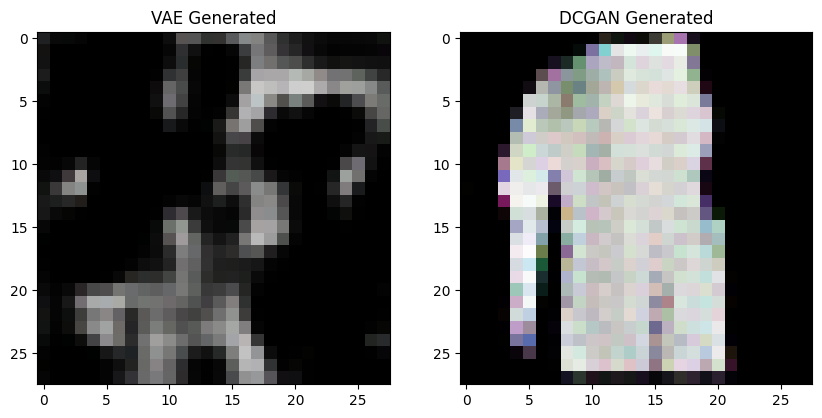

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, LeakyReLU, BatchNormalization, Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess Fashion-MNIST dataset
def load_data():
    (x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = np.expand_dims(x_train, axis=-1)  # (28, 28, 1)
    x_train = np.tile(x_train, (1, 1, 1, 3))  # Convert to 3-channel RGB
    x_train = x_train.astype('float32') / 255.0
    return x_train

# Variational Autoencoder (VAE) Components
class VAE(Model):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            Input(shape=(28, 28, 3)),
            Conv2D(32, 3, activation='relu', strides=2, padding='same'),
            Conv2D(64, 3, activation='relu', strides=2, padding='same'),
            Flatten(),
            Dense(latent_dim * 2)  # Mean and log variance
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            Input(shape=(latent_dim,)),
            Dense(7 * 7 * 64, activation='relu'),
            Reshape((7, 7, 64)),
            Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(3, 3, activation='sigmoid', padding='same')
        ])

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + eps * tf.exp(logvar * 0.5)

    def call(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z)

# DCGAN Components
class DCGAN:
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

        # Generator
        self.generator = tf.keras.Sequential([
            Dense(7 * 7 * 128, input_dim=latent_dim, activation='relu'),
            Reshape((7, 7, 128)),
            Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(3, 3, activation='sigmoid', padding='same')
        ])

        # Discriminator
        self.discriminator = tf.keras.Sequential([
            Conv2D(64, 3, strides=2, padding='same', input_shape=(28, 28, 3)),
            LeakyReLU(0.2),
            Conv2D(128, 3, strides=2, padding='same'),
            LeakyReLU(0.2),
            Flatten(),
            Dense(1, activation='sigmoid')
        ])

        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)

        # Labels
        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))

        # Train Discriminator
        with tf.GradientTape() as tape:
            real_loss = self.loss_fn(real_labels, self.discriminator(real_images))
            fake_loss = self.loss_fn(fake_labels, self.discriminator(generated_images))
            d_loss = real_loss + fake_loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            fake_predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(real_labels, fake_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        return d_loss, g_loss

# Load data
x_train = load_data()

# Train VAE
vae = VAE()
# Add a loss function to the compile method
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')  # Using 'mse' as an example
vae.fit(x_train, x_train, epochs=10, batch_size=128)

# Train DCGAN
dcgan = DCGAN()
batch_size = 128
epochs = 10
for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        d_loss, g_loss = dcgan.train_step(x_train[i:i+batch_size])
    print(f"Epoch {epoch + 1}/{epochs}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

# Generate images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
random_latent_vector = tf.random.normal(shape=(1, 100))
axes[0].imshow(vae.decoder(random_latent_vector)[0])
axes[0].set_title("VAE Generated")
axes[1].imshow(dcgan.generator(random_latent_vector)[0])
axes[1].set_title("DCGAN Generated")
plt.show()


# Updated Code

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 0.1303
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0733
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0665
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0646
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0635
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0628
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0621
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0617
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0611
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0604
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0587
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0558
Epoch 13/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0544
Epoch 14/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0537
Epoch 15/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step -

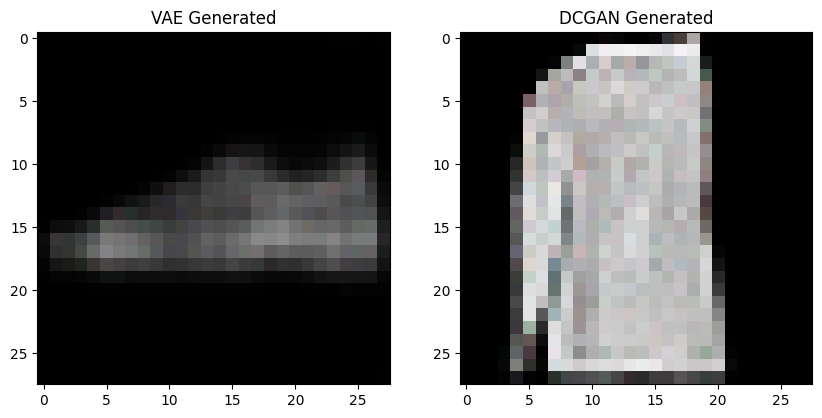

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, LeakyReLU,
    BatchNormalization, Input, Dropout, Lambda
)
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# Load and preprocess Fashion-MNIST dataset
def load_data():
    (x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = np.expand_dims(x_train, axis=-1)  # (28, 28, 1)
    x_train = np.tile(x_train, (1, 1, 1, 3))  # Convert to 3-channel RGB
    x_train = x_train.astype('float32') / 255.0
    return x_train

# Variational Autoencoder (VAE)
class VAE(Model):
    def __init__(self, latent_dim=256):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            Input(shape=(28, 28, 3)),
            Conv2D(32, 3, strides=2, padding='same', activation=LeakyReLU(0.2)),
            Conv2D(64, 3, strides=2, padding='same', activation=LeakyReLU(0.2)),
            Flatten(),
            Dense(latent_dim * 2)  # Mean and log variance
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            Input(shape=(latent_dim,)),
            Dense(7 * 7 * 64, activation=LeakyReLU(0.2)),
            Reshape((7, 7, 64)),
            Conv2DTranspose(64, 3, strides=2, padding='same', activation=LeakyReLU(0.2)),
            Conv2DTranspose(32, 3, strides=2, padding='same', activation=LeakyReLU(0.2)),
            Conv2DTranspose(3, 3, activation='sigmoid', padding='same')
        ])

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + eps * tf.exp(logvar * 0.5)

    def call(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z)

    def vae_loss(self, x, reconstructed_x):
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(x, reconstructed_x))
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
        return reconstruction_loss + kl_loss

# DCGAN Components
class DCGAN:
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

        # Generator
        self.generator = tf.keras.Sequential([
            Dense(7 * 7 * 128, input_dim=latent_dim, activation=LeakyReLU(0.2)),
            Reshape((7, 7, 128)),
            BatchNormalization(),
            Conv2DTranspose(128, 3, strides=2, padding='same', activation=LeakyReLU(0.2)),
            BatchNormalization(),
            Conv2DTranspose(64, 3, strides=2, padding='same', activation=LeakyReLU(0.2)),
            BatchNormalization(),
            Conv2DTranspose(3, 3, activation='sigmoid', padding='same')
        ])

        # Discriminator
        self.discriminator = tf.keras.Sequential([
            Conv2D(64, 3, strides=2, padding='same', input_shape=(28, 28, 3)),
            LeakyReLU(0.2),
            Dropout(0.3),
            Conv2D(128, 3, strides=2, padding='same'),
            LeakyReLU(0.2),
            Dropout(0.5),
            Flatten(),
            Dense(1, activation='sigmoid')
        ])

        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))  # Match the latent_dim of VAE
        generated_images = self.generator(random_latent_vector)  # Use random_latent_vector instead of random_latent_vectors

        # Labels
        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))

        # Train Discriminator
        with tf.GradientTape() as tape:
            real_loss = self.loss_fn(real_labels, self.discriminator(real_images))
            fake_loss = self.loss_fn(fake_labels, self.discriminator(generated_images))
            d_loss = real_loss + fake_loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vector)  # Use random_latent_vector instead of random_latent_vectors
            fake_predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(real_labels, fake_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        return d_loss, g_loss

# Load data
x_train = load_data()

# Train VAE
vae = VAE()
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=vae.vae_loss)
vae.fit(x_train, x_train, epochs=50, batch_size=128)

# Train DCGAN
dcgan = DCGAN()
batch_size = 128
epochs = 50  # Increased epochs for better training
for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        d_loss, g_loss = dcgan.train_step(x_train[i:i+batch_size])
    print(f"Epoch {epoch + 1}/{epochs}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

# Generate images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# VAE expects latent_dim=256
random_latent_vector_vae = tf.random.normal(shape=(1, 256))  # Match VAE's latent_dim
axes[0].imshow(vae.decoder(random_latent_vector_vae)[0])
axes[0].set_title("VAE Generated")

# DCGAN expects latent_dim=100
random_latent_vector_dcgan = tf.random.normal(shape=(1, 100))  # Match DCGAN's latent_dim
axes[1].imshow(dcgan.generator(random_latent_vector_dcgan)[0])
axes[1].set_title("DCGAN Generated")

plt.show()

# Summary of Fixes
✅ VAE:

Added KL divergence + reconstruction loss
Increased latent dimension to 256
Used LeakyReLU in decoder
✅ DCGAN:

Added BatchNormalization for stable training
Reduced learning rate to 0.0001
Increased epochs to 50 for better generation
Added Dropout (0.3-0.5) in discriminator to prevent overfitting

# 2. Deep Convolutional Generative Adversarial Network (DCGAN) for Colored MNIST Images

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bars

# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape the data to have 3 channels (RGB)
x_train = np.expand_dims(x_train, -1)
x_train = np.repeat(x_train, 3, axis=-1)  # Convert grayscale to RGB
x_train = x_train.astype('float32') / 255.0

# DCGAN Model
latent_dim = 128

# Generator
generator = tf.keras.Sequential([
    layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((7, 7, 256)),
    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

# Discriminator
discriminator = tf.keras.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 3]),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1)
])

# GAN Model
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.trainable = False

gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Training loop with tqdm progress bars
def train_dcgan(gan, generator, discriminator, dataset, latent_dim, epochs=50, batch_size=128):
    num_batches = len(dataset)
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        # Wrap the dataset iterator with tqdm for a progress bar
        for batch_idx, real_images in tqdm(enumerate(dataset), total=num_batches, desc="Batches"):
            if batch_idx >= num_batches:
                break  # Stop after iterating through all batches in the dataset
            batch_size = real_images.shape[0]
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            generated_images = generator.predict(noise)
            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, real_labels)
        print(f"D Loss: {d_loss}, G Loss: {g_loss}")
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, latent_dim)

def generate_and_save_images(generator, epoch, latent_dim, n=10):
    noise = np.random.normal(0, 1, (n, latent_dim))
    generated_images = generator.predict(noise)
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow((generated_images[i] + 1) / 2)
        plt.axis("off")
    plt.show()

# Train the DCGAN
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128)
train_dcgan(gan, generator, discriminator, dataset, latent_dim, epochs=50)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bars

# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape the data to have 3 channels (RGB)
x_train = np.expand_dims(x_train, -1)
x_train = np.repeat(x_train, 3, axis=-1)  # Convert grayscale to RGB
x_train = x_train.astype('float32') / 255.0

# DCGAN Model
latent_dim = 128

# Generator
generator = tf.keras.Sequential([
    layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((7, 7, 256)),
    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

# Discriminator
discriminator = tf.keras.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 3]),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1)
])

# GAN Model
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.trainable = False

gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Training loop with tqdm progress bars
def train_dcgan(gan, generator, discriminator, dataset, latent_dim, epochs=5, batch_size=128):
    num_batches = len(dataset)
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        # Wrap the dataset iterator with tqdm for a progress bar
        for batch_idx, real_images in tqdm(enumerate(dataset), total=num_batches, desc="Batches"):
            if batch_idx >= num_batches:
                break  # Stop after iterating through all batches in the dataset
            batch_size = real_images.shape[0]
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            generated_images = generator.predict(noise)
            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, real_labels)
        print(f"D Loss: {d_loss}, G Loss: {g_loss}")
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, latent_dim)

def generate_and_save_images(generator, epoch, latent_dim, n=10):
    noise = np.random.normal(0, 1, (n, latent_dim))
    generated_images = generator.predict(noise)
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow((generated_images[i] + 1) / 2)
        plt.axis("off")
    plt.show()

# Train the DCGAN
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128)
train_dcgan(gan, generator, discriminator, dataset, latent_dim, epochs=5)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/5


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 296ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
Batches:   0%|          | 1/469 [00:07<55:12,  7.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:   0%|          | 2/469 [00:08<30:56,  3.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   1%|          | 3/469 [00:10<23:46,  3.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   1%|          | 4/469 [00:13<21:41,  2.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:   1%|          | 5/469 [00:16<21:46,  2.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:   1%|▏         | 6/469 [00:18<19:42,  2.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:   1%|▏         | 7/469 [00:20<18:21,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:   2%|▏         | 8/469 [00:21<16:52,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:   2%|▏         | 9/469 [00:23<16:22,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   2%|▏         | 10/469 [00:26<17:15,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:   2%|▏         | 11/469 [00:29<18:10,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   3%|▎         | 12/469 [00:31<17:20,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   3%|▎         | 13/469 [00:33<16:13,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:   3%|▎         | 14/469 [00:34<15:42,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:   3%|▎         | 15/469 [00:36<14:55,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:   3%|▎         | 16/469 [00:38<15:36,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:   4%|▎         | 17/469 [00:41<17:11,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   4%|▍         | 18/469 [00:43<16:23,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   4%|▍         | 19/469 [00:45<15:58,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   4%|▍         | 20/469 [00:47<15:30,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   4%|▍         | 21/469 [00:49<15:10,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   5%|▍         | 22/469 [00:51<15:36,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:   5%|▍         | 23/469 [00:54<17:00,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:   5%|▌         | 24/469 [00:56<16:14,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:   5%|▌         | 25/469 [00:58<15:40,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:   6%|▌         | 26/469 [01:00<15:17,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:   6%|▌         | 27/469 [01:02<14:39,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   6%|▌         | 28/469 [01:04<14:57,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:   6%|▌         | 29/469 [01:07<16:48,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   6%|▋         | 30/469 [01:09<15:47,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:   7%|▋         | 31/469 [01:11<15:16,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:   7%|▋         | 32/469 [01:13<15:00,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   7%|▋         | 33/469 [01:15<14:54,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   7%|▋         | 34/469 [01:17<15:35,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:   7%|▋         | 35/469 [01:20<17:09,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   8%|▊         | 36/469 [01:22<16:17,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:   8%|▊         | 37/469 [01:24<15:43,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   8%|▊         | 38/469 [01:26<15:18,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   8%|▊         | 39/469 [01:28<14:32,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:   9%|▊         | 40/469 [01:30<15:01,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:   9%|▊         | 41/469 [01:33<16:55,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


Batches:   9%|▉         | 42/469 [01:36<18:13,  2.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:   9%|▉         | 43/469 [01:38<16:56,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:   9%|▉         | 44/469 [01:40<15:57,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  10%|▉         | 45/469 [01:42<15:14,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


Batches:  10%|▉         | 46/469 [01:45<17:29,  2.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  10%|█         | 47/469 [01:47<16:20,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  10%|█         | 48/469 [01:49<15:27,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  10%|█         | 49/469 [01:51<14:54,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  11%|█         | 50/469 [01:53<14:25,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:  11%|█         | 51/469 [01:55<13:45,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


Batches:  11%|█         | 52/469 [01:57<15:37,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  11%|█▏        | 53/469 [01:59<15:07,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  12%|█▏        | 54/469 [02:01<14:33,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  12%|█▏        | 55/469 [02:03<14:15,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:  12%|█▏        | 56/469 [02:05<14:04,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  12%|█▏        | 57/469 [02:07<13:56,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  12%|█▏        | 58/469 [02:10<15:29,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  13%|█▎        | 59/469 [02:13<16:20,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  13%|█▎        | 60/469 [02:15<15:33,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  13%|█▎        | 61/469 [02:17<14:58,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  13%|█▎        | 62/469 [02:19<14:09,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  13%|█▎        | 63/469 [02:21<13:36,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  14%|█▎        | 64/469 [02:23<15:18,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  14%|█▍        | 65/469 [02:26<16:04,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  14%|█▍        | 66/469 [02:28<14:51,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  14%|█▍        | 67/469 [02:30<13:59,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  14%|█▍        | 68/469 [02:32<13:40,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  15%|█▍        | 69/469 [02:33<12:59,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  15%|█▍        | 70/469 [02:36<14:20,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


Batches:  15%|█▌        | 71/469 [02:39<15:17,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  15%|█▌        | 72/469 [02:41<14:46,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  16%|█▌        | 73/469 [02:43<14:17,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  16%|█▌        | 74/469 [02:45<13:53,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  16%|█▌        | 75/469 [02:47<13:39,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  16%|█▌        | 76/469 [02:50<15:06,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


Batches:  16%|█▋        | 77/469 [02:52<15:45,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  17%|█▋        | 78/469 [02:54<14:45,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  17%|█▋        | 79/469 [02:56<14:07,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  17%|█▋        | 80/469 [02:58<13:46,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  17%|█▋        | 81/469 [03:00<13:25,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  17%|█▋        | 82/469 [03:03<14:50,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


Batches:  18%|█▊        | 83/469 [03:05<14:27,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  18%|█▊        | 84/469 [03:07<13:53,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  18%|█▊        | 85/469 [03:09<13:25,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  18%|█▊        | 86/469 [03:11<13:09,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  19%|█▊        | 87/469 [03:13<12:57,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  19%|█▉        | 88/469 [03:16<14:28,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  19%|█▉        | 89/469 [03:18<15:04,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  19%|█▉        | 90/469 [03:20<14:01,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  19%|█▉        | 91/469 [03:22<13:31,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  20%|█▉        | 92/469 [03:24<13:05,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  20%|█▉        | 93/469 [03:26<12:50,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  20%|██        | 94/469 [03:29<13:43,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  20%|██        | 95/469 [03:31<13:55,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  20%|██        | 96/469 [03:33<13:21,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  21%|██        | 97/469 [03:35<12:35,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  21%|██        | 98/469 [03:36<12:05,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  21%|██        | 99/469 [03:38<11:43,  1.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  21%|██▏       | 100/469 [03:40<11:50,  1.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  22%|██▏       | 101/469 [03:43<13:53,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  22%|██▏       | 102/469 [03:45<13:17,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  22%|██▏       | 103/469 [03:47<12:51,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  22%|██▏       | 104/469 [03:49<12:19,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  22%|██▏       | 105/469 [03:51<12:01,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  23%|██▎       | 106/469 [03:53<12:01,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  23%|██▎       | 107/469 [03:56<13:41,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  23%|██▎       | 108/469 [03:58<13:17,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  23%|██▎       | 109/469 [04:00<12:31,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  23%|██▎       | 110/469 [04:01<12:02,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  24%|██▎       | 111/469 [04:03<11:41,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  24%|██▍       | 112/469 [04:05<11:28,  1.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  24%|██▍       | 113/469 [04:08<13:01,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  24%|██▍       | 114/469 [04:11<13:50,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  25%|██▍       | 115/469 [04:13<13:13,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  25%|██▍       | 116/469 [04:15<12:55,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  25%|██▍       | 117/469 [04:17<13:16,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  25%|██▌       | 118/469 [04:20<14:44,  2.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 301ms/step


Batches:  25%|██▌       | 119/469 [04:24<17:20,  2.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  26%|██▌       | 120/469 [04:26<15:22,  2.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  26%|██▌       | 121/469 [04:28<14:14,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  26%|██▌       | 122/469 [04:30<13:08,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  26%|██▌       | 123/469 [04:32<12:36,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  26%|██▋       | 124/469 [04:36<16:08,  2.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  27%|██▋       | 125/469 [04:40<17:31,  3.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step


Batches:  27%|██▋       | 126/469 [04:43<17:50,  3.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  27%|██▋       | 127/469 [04:45<15:47,  2.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  27%|██▋       | 128/469 [04:48<15:29,  2.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  28%|██▊       | 129/469 [04:50<15:21,  2.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  28%|██▊       | 130/469 [04:52<14:05,  2.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  28%|██▊       | 131/469 [04:55<13:27,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  28%|██▊       | 132/469 [04:58<14:49,  2.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  28%|██▊       | 133/469 [05:00<14:46,  2.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  29%|██▊       | 134/469 [05:04<16:27,  2.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step


Batches:  29%|██▉       | 135/469 [05:07<15:54,  2.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  29%|██▉       | 136/469 [05:09<14:10,  2.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  29%|██▉       | 137/469 [05:11<13:13,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  29%|██▉       | 138/469 [05:13<12:30,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  30%|██▉       | 139/469 [05:15<13:24,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  30%|██▉       | 140/469 [05:17<12:39,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  30%|███       | 141/469 [05:20<12:50,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step


Batches:  30%|███       | 142/469 [05:23<13:40,  2.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  30%|███       | 143/469 [05:25<12:40,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  31%|███       | 144/469 [05:28<13:30,  2.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  31%|███       | 145/469 [05:30<13:42,  2.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  31%|███       | 146/469 [05:32<12:46,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  31%|███▏      | 147/469 [05:34<11:51,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  32%|███▏      | 148/469 [05:36<11:24,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  32%|███▏      | 149/469 [05:38<10:55,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  32%|███▏      | 150/469 [05:41<12:08,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  32%|███▏      | 151/469 [05:43<12:41,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  32%|███▏      | 152/469 [05:45<11:54,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  33%|███▎      | 153/469 [05:47<11:20,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  33%|███▎      | 154/469 [05:49<11:01,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  33%|███▎      | 155/469 [05:51<10:51,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  33%|███▎      | 156/469 [05:54<11:57,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


Batches:  33%|███▎      | 157/469 [05:56<11:33,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  34%|███▎      | 158/469 [05:58<11:08,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  34%|███▍      | 159/469 [06:00<10:55,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  34%|███▍      | 160/469 [06:02<10:24,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  34%|███▍      | 161/469 [06:04<10:18,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  35%|███▍      | 162/469 [06:07<11:37,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  35%|███▍      | 163/469 [06:09<12:12,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  35%|███▍      | 164/469 [06:11<11:28,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  35%|███▌      | 165/469 [06:13<10:57,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  35%|███▌      | 166/469 [06:15<10:30,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  36%|███▌      | 167/469 [06:17<10:19,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  36%|███▌      | 168/469 [06:20<11:24,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  36%|███▌      | 169/469 [06:22<11:14,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  36%|███▌      | 170/469 [06:24<10:46,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  36%|███▋      | 171/469 [06:26<10:25,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  37%|███▋      | 172/469 [06:28<10:11,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  37%|███▋      | 173/469 [06:30<10:06,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  37%|███▋      | 174/469 [06:33<11:05,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  37%|███▋      | 175/469 [06:35<11:36,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  38%|███▊      | 176/469 [06:37<10:47,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  38%|███▊      | 177/469 [06:39<10:09,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  38%|███▊      | 178/469 [06:41<09:45,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  38%|███▊      | 179/469 [06:43<09:34,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  38%|███▊      | 180/469 [06:45<09:52,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  39%|███▊      | 181/469 [06:48<10:59,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  39%|███▉      | 182/469 [06:50<10:30,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  39%|███▉      | 183/469 [06:52<10:10,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  39%|███▉      | 184/469 [06:54<09:51,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  39%|███▉      | 185/469 [06:56<09:30,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  40%|███▉      | 186/469 [06:58<10:14,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  40%|███▉      | 187/469 [07:01<10:59,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  40%|████      | 188/469 [07:03<10:24,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  40%|████      | 189/469 [07:05<09:43,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  41%|████      | 190/469 [07:07<09:31,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  41%|████      | 191/469 [07:09<09:24,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  41%|████      | 192/469 [07:11<09:42,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  41%|████      | 193/469 [07:13<10:26,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  41%|████▏     | 194/469 [07:15<09:59,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  42%|████▏     | 195/469 [07:17<09:43,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  42%|████▏     | 196/469 [07:19<09:32,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  42%|████▏     | 197/469 [07:21<09:12,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  42%|████▏     | 198/469 [07:24<10:08,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  42%|████▏     | 199/469 [07:27<10:36,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  43%|████▎     | 200/469 [07:29<10:05,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  43%|████▎     | 201/469 [07:31<09:39,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  43%|████▎     | 202/469 [07:33<09:18,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  43%|████▎     | 203/469 [07:34<08:50,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  43%|████▎     | 204/469 [07:37<09:56,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  44%|████▎     | 205/469 [07:40<10:26,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  44%|████▍     | 206/469 [07:42<09:50,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  44%|████▍     | 207/469 [07:44<09:12,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  44%|████▍     | 208/469 [07:46<09:04,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  45%|████▍     | 209/469 [07:48<08:59,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  45%|████▍     | 210/469 [07:51<09:58,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  45%|████▍     | 211/469 [07:53<10:19,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  45%|████▌     | 212/469 [07:55<09:32,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  45%|████▌     | 213/469 [07:57<09:04,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  46%|████▌     | 214/469 [07:59<08:43,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  46%|████▌     | 215/469 [08:01<08:38,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  46%|████▌     | 216/469 [08:03<09:08,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  46%|████▋     | 217/469 [08:06<09:50,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  46%|████▋     | 218/469 [08:08<09:21,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  47%|████▋     | 219/469 [08:10<08:57,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  47%|████▋     | 220/469 [08:12<08:44,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  47%|████▋     | 221/469 [08:14<08:25,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  47%|████▋     | 222/469 [08:17<09:20,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  48%|████▊     | 223/469 [08:19<09:48,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  48%|████▊     | 224/469 [08:21<09:15,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  48%|████▊     | 225/469 [08:23<08:55,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  48%|████▊     | 226/469 [08:25<08:40,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  48%|████▊     | 227/469 [08:27<08:27,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  49%|████▊     | 228/469 [08:31<09:49,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  49%|████▉     | 229/469 [08:32<09:02,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  49%|████▉     | 230/469 [08:34<08:42,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  49%|████▉     | 231/469 [08:36<08:27,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  49%|████▉     | 232/469 [08:38<08:11,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  50%|████▉     | 233/469 [08:40<08:03,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  50%|████▉     | 234/469 [08:43<09:14,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  50%|█████     | 235/469 [08:45<08:44,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  50%|█████     | 236/469 [08:47<08:26,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  51%|█████     | 237/469 [08:49<08:14,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  51%|█████     | 238/469 [08:51<08:03,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  51%|█████     | 239/469 [08:53<07:39,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


Batches:  51%|█████     | 240/469 [08:56<08:26,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  51%|█████▏    | 241/469 [08:58<08:20,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  52%|█████▏    | 242/469 [09:00<07:55,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  52%|█████▏    | 243/469 [09:02<07:49,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  52%|█████▏    | 244/469 [09:04<07:42,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  52%|█████▏    | 245/469 [09:06<07:35,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  52%|█████▏    | 246/469 [09:08<07:58,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  53%|█████▎    | 247/469 [09:11<08:27,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  53%|█████▎    | 248/469 [09:13<07:56,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  53%|█████▎    | 249/469 [09:15<07:45,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  53%|█████▎    | 250/469 [09:17<07:33,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  54%|█████▎    | 251/469 [09:19<07:22,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  54%|█████▎    | 252/469 [09:22<08:11,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  54%|█████▍    | 253/469 [09:24<08:39,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  54%|█████▍    | 254/469 [09:26<08:12,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  54%|█████▍    | 255/469 [09:28<07:51,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  55%|█████▍    | 256/469 [09:30<07:35,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  55%|█████▍    | 257/469 [09:32<07:23,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  55%|█████▌    | 258/469 [09:35<08:06,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  55%|█████▌    | 259/469 [09:38<08:26,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  55%|█████▌    | 260/469 [09:40<07:54,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  56%|█████▌    | 261/469 [09:42<07:30,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  56%|█████▌    | 262/469 [09:43<07:05,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  56%|█████▌    | 263/469 [09:45<06:48,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  56%|█████▋    | 264/469 [09:48<07:37,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  57%|█████▋    | 265/469 [09:51<08:01,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  57%|█████▋    | 266/469 [09:53<07:34,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  57%|█████▋    | 267/469 [09:54<07:04,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  57%|█████▋    | 268/469 [09:56<06:56,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  57%|█████▋    | 269/469 [09:58<06:49,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  58%|█████▊    | 270/469 [10:01<07:34,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  58%|█████▊    | 271/469 [10:04<07:55,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  58%|█████▊    | 272/469 [10:06<07:28,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  58%|█████▊    | 273/469 [10:09<07:46,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step


Batches:  58%|█████▊    | 274/469 [10:13<09:30,  2.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 410ms/step


Batches:  59%|█████▊    | 275/469 [10:17<11:09,  3.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step


Batches:  59%|█████▉    | 276/469 [10:21<11:16,  3.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  59%|█████▉    | 277/469 [10:24<11:01,  3.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  59%|█████▉    | 278/469 [10:27<09:50,  3.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  59%|█████▉    | 279/469 [10:30<09:34,  3.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  60%|█████▉    | 280/469 [10:31<08:23,  2.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  60%|█████▉    | 281/469 [10:33<07:43,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  60%|██████    | 282/469 [10:35<07:14,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  60%|██████    | 283/469 [10:37<06:44,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  61%|██████    | 284/469 [10:39<06:36,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


Batches:  61%|██████    | 285/469 [10:42<07:21,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  61%|██████    | 286/469 [10:44<06:54,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  61%|██████    | 287/469 [10:46<06:33,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  61%|██████▏   | 288/469 [10:48<06:23,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  62%|██████▏   | 289/469 [10:50<06:15,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  62%|██████▏   | 290/469 [10:52<06:12,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  62%|██████▏   | 291/469 [10:55<06:56,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  62%|██████▏   | 292/469 [10:57<06:28,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  62%|██████▏   | 293/469 [10:59<06:14,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  63%|██████▎   | 294/469 [11:01<06:03,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  63%|██████▎   | 295/469 [11:03<05:57,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  63%|██████▎   | 296/469 [11:05<06:01,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  63%|██████▎   | 297/469 [11:08<06:47,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  64%|██████▎   | 298/469 [11:10<06:26,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  64%|██████▍   | 299/469 [11:12<06:11,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  64%|██████▍   | 300/469 [11:14<05:53,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  64%|██████▍   | 301/469 [11:16<05:47,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  64%|██████▍   | 302/469 [11:20<07:03,  2.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step


Batches:  65%|██████▍   | 303/469 [11:23<07:39,  2.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  65%|██████▍   | 304/469 [11:25<06:51,  2.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  65%|██████▌   | 305/469 [11:27<06:25,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  65%|██████▌   | 306/469 [11:29<05:59,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  65%|██████▌   | 307/469 [11:31<05:47,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  66%|██████▌   | 308/469 [11:34<06:26,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  66%|██████▌   | 309/469 [11:36<06:04,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  66%|██████▌   | 310/469 [11:38<05:48,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  66%|██████▋   | 311/469 [11:40<05:37,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  67%|██████▋   | 312/469 [11:42<05:30,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  67%|██████▋   | 313/469 [11:44<05:25,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  67%|██████▋   | 314/469 [11:47<06:02,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


Batches:  67%|██████▋   | 315/469 [11:49<06:17,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  67%|██████▋   | 316/469 [11:51<05:49,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  68%|██████▊   | 317/469 [11:53<05:30,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  68%|██████▊   | 318/469 [11:55<05:14,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  68%|██████▊   | 319/469 [11:57<05:03,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  68%|██████▊   | 320/469 [12:00<05:35,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  68%|██████▊   | 321/469 [12:02<05:51,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  69%|██████▊   | 322/469 [12:04<05:30,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  69%|██████▉   | 323/469 [12:07<05:23,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  69%|██████▉   | 324/469 [12:08<05:05,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  69%|██████▉   | 325/469 [12:10<05:02,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step


Batches:  70%|██████▉   | 326/469 [12:14<06:18,  2.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  70%|██████▉   | 327/469 [12:16<05:46,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  70%|██████▉   | 328/469 [12:18<05:24,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  70%|███████   | 329/469 [12:20<05:07,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  70%|███████   | 330/469 [12:22<04:57,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  71%|███████   | 331/469 [12:26<06:07,  2.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  71%|███████   | 332/469 [12:28<05:32,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  71%|███████   | 333/469 [12:30<05:10,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  71%|███████   | 334/469 [12:32<04:54,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  71%|███████▏  | 335/469 [12:34<04:44,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  72%|███████▏  | 336/469 [12:36<04:36,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  72%|███████▏  | 337/469 [12:39<05:05,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  72%|███████▏  | 338/469 [12:41<05:17,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  72%|███████▏  | 339/469 [12:43<04:52,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  72%|███████▏  | 340/469 [12:45<04:40,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  73%|███████▎  | 341/469 [12:47<04:30,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  73%|███████▎  | 342/469 [12:49<04:17,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  73%|███████▎  | 343/469 [12:52<04:40,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  73%|███████▎  | 344/469 [12:54<04:53,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  74%|███████▎  | 345/469 [12:56<04:32,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  74%|███████▍  | 346/469 [12:58<04:22,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  74%|███████▍  | 347/469 [13:00<04:11,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  74%|███████▍  | 348/469 [13:02<04:00,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  74%|███████▍  | 349/469 [13:04<04:19,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  75%|███████▍  | 350/469 [13:07<04:34,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  75%|███████▍  | 351/469 [13:09<04:16,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  75%|███████▌  | 352/469 [13:11<04:06,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  75%|███████▌  | 353/469 [13:13<03:58,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  75%|███████▌  | 354/469 [13:15<03:53,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  76%|███████▌  | 355/469 [13:18<04:15,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  76%|███████▌  | 356/469 [13:20<04:26,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  76%|███████▌  | 357/469 [13:22<04:13,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  76%|███████▋  | 358/469 [13:24<03:56,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  77%|███████▋  | 359/469 [13:26<03:47,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  77%|███████▋  | 360/469 [13:28<03:37,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  77%|███████▋  | 361/469 [13:31<04:01,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  77%|███████▋  | 362/469 [13:33<04:14,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  77%|███████▋  | 363/469 [13:35<03:52,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  78%|███████▊  | 364/469 [13:37<03:42,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  78%|███████▊  | 365/469 [13:39<03:35,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  78%|███████▊  | 366/469 [13:41<03:33,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  78%|███████▊  | 367/469 [13:44<03:54,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  78%|███████▊  | 368/469 [13:46<03:50,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  79%|███████▊  | 369/469 [13:48<03:34,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  79%|███████▉  | 370/469 [13:50<03:27,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  79%|███████▉  | 371/469 [13:52<03:19,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  79%|███████▉  | 372/469 [13:54<03:16,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  80%|███████▉  | 373/469 [13:56<03:25,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  80%|███████▉  | 374/469 [13:59<03:51,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  80%|███████▉  | 375/469 [14:01<03:32,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  80%|████████  | 376/469 [14:03<03:23,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  80%|████████  | 377/469 [14:05<03:14,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  81%|████████  | 378/469 [14:07<03:02,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  81%|████████  | 379/469 [14:09<03:08,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step


Batches:  81%|████████  | 380/469 [14:12<03:30,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  81%|████████  | 381/469 [14:14<03:19,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  81%|████████▏ | 382/469 [14:16<03:07,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  82%|████████▏ | 383/469 [14:18<02:59,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  82%|████████▏ | 384/469 [14:20<02:53,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  82%|████████▏ | 385/469 [14:22<02:45,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  82%|████████▏ | 386/469 [14:26<03:32,  2.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  83%|████████▎ | 387/469 [14:28<03:23,  2.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


Batches:  83%|████████▎ | 388/469 [14:31<03:35,  2.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  83%|████████▎ | 389/469 [14:34<03:33,  2.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  83%|████████▎ | 390/469 [14:36<03:16,  2.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  83%|████████▎ | 391/469 [14:39<03:27,  2.66s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  84%|████████▎ | 392/469 [14:41<03:10,  2.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  84%|████████▍ | 393/469 [14:43<02:53,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  84%|████████▍ | 394/469 [14:45<02:45,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  84%|████████▍ | 395/469 [14:47<02:35,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  84%|████████▍ | 396/469 [14:49<02:31,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


Batches:  85%|████████▍ | 397/469 [14:52<02:51,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  85%|████████▍ | 398/469 [14:54<02:39,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  85%|████████▌ | 399/469 [14:56<02:28,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  85%|████████▌ | 400/469 [14:58<02:23,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  86%|████████▌ | 401/469 [14:59<02:17,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  86%|████████▌ | 402/469 [15:02<02:17,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  86%|████████▌ | 403/469 [15:05<02:36,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  86%|████████▌ | 404/469 [15:07<02:26,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  86%|████████▋ | 405/469 [15:09<02:17,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  87%|████████▋ | 406/469 [15:11<02:11,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  87%|████████▋ | 407/469 [15:13<02:08,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  87%|████████▋ | 408/469 [15:15<02:07,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  87%|████████▋ | 409/469 [15:18<02:21,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


Batches:  87%|████████▋ | 410/469 [15:20<02:12,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  88%|████████▊ | 411/469 [15:22<02:05,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  88%|████████▊ | 412/469 [15:24<02:00,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  88%|████████▊ | 413/469 [15:26<01:55,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  88%|████████▊ | 414/469 [15:28<01:57,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  88%|████████▊ | 415/469 [15:31<02:06,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  89%|████████▊ | 416/469 [15:33<01:58,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  89%|████████▉ | 417/469 [15:34<01:49,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  89%|████████▉ | 418/469 [15:36<01:44,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  89%|████████▉ | 419/469 [15:38<01:41,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  90%|████████▉ | 420/469 [15:40<01:39,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  90%|████████▉ | 421/469 [15:43<01:51,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  90%|████████▉ | 422/469 [15:46<01:50,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  90%|█████████ | 423/469 [15:48<01:41,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  90%|█████████ | 424/469 [15:49<01:33,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  91%|█████████ | 425/469 [15:51<01:29,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  91%|█████████ | 426/469 [15:53<01:27,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  91%|█████████ | 427/469 [15:56<01:34,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  91%|█████████▏| 428/469 [15:59<01:37,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  91%|█████████▏| 429/469 [16:01<01:30,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  92%|█████████▏| 430/469 [16:03<01:24,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  92%|█████████▏| 431/469 [16:05<01:19,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  92%|█████████▏| 432/469 [16:07<01:15,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Batches:  92%|█████████▏| 433/469 [16:09<01:21,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  93%|█████████▎| 434/469 [16:12<01:17,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  93%|█████████▎| 435/469 [16:14<01:13,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  93%|█████████▎| 436/469 [16:16<01:09,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  93%|█████████▎| 437/469 [16:18<01:06,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  93%|█████████▎| 438/469 [16:19<01:03,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  94%|█████████▎| 439/469 [16:22<01:05,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  94%|█████████▍| 440/469 [16:25<01:06,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  94%|█████████▍| 441/469 [16:27<01:01,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  94%|█████████▍| 442/469 [16:29<00:57,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  94%|█████████▍| 443/469 [16:30<00:54,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  95%|█████████▍| 444/469 [16:32<00:50,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  95%|█████████▍| 445/469 [16:35<00:53,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  95%|█████████▌| 446/469 [16:38<00:54,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  95%|█████████▌| 447/469 [16:40<00:48,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  96%|█████████▌| 448/469 [16:42<00:44,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  96%|█████████▌| 449/469 [16:44<00:41,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  96%|█████████▌| 450/469 [16:45<00:38,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  96%|█████████▌| 451/469 [16:48<00:39,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  96%|█████████▋| 452/469 [16:51<00:39,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  97%|█████████▋| 453/469 [16:53<00:35,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  97%|█████████▋| 454/469 [16:55<00:31,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  97%|█████████▋| 455/469 [16:56<00:28,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  97%|█████████▋| 456/469 [16:58<00:25,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  97%|█████████▋| 457/469 [17:01<00:26,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  98%|█████████▊| 458/469 [17:03<00:24,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  98%|█████████▊| 459/469 [17:05<00:21,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  98%|█████████▊| 460/469 [17:07<00:18,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  98%|█████████▊| 461/469 [17:09<00:16,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  99%|█████████▊| 462/469 [17:11<00:14,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  99%|█████████▊| 463/469 [17:14<00:12,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  99%|█████████▉| 464/469 [17:16<00:11,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  99%|█████████▉| 465/469 [17:18<00:08,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  99%|█████████▉| 466/469 [17:20<00:06,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches: 100%|█████████▉| 467/469 [17:22<00:04,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches: 100%|█████████▉| 468/469 [17:24<00:02,  2.05s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches: 100%|██████████| 469/469 [17:28<00:00,  2.24s/it]


D Loss: 9.135977745056152, G Loss: 0.16418570280075073

Epoch 2/5


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:   0%|          | 1/469 [00:01<15:34,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:   0%|          | 2/469 [00:04<18:37,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:   1%|          | 3/469 [00:07<19:29,  2.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:   1%|          | 4/469 [00:09<17:44,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   1%|          | 5/469 [00:11<16:43,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:   1%|▏         | 6/469 [00:13<16:24,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:   1%|▏         | 7/469 [00:15<15:58,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   2%|▏         | 8/469 [00:17<17:16,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:   2%|▏         | 9/469 [00:20<18:13,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:   2%|▏         | 10/469 [00:22<17:14,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:   2%|▏         | 11/469 [00:24<16:10,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:   3%|▎         | 12/469 [00:26<15:56,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:   3%|▎         | 13/469 [00:28<15:36,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   3%|▎         | 14/469 [00:31<17:19,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:   3%|▎         | 15/469 [00:33<17:01,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   3%|▎         | 16/469 [00:35<16:03,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   4%|▎         | 17/469 [00:36<15:16,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:   4%|▍         | 18/469 [00:38<14:43,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:   4%|▍         | 19/469 [00:40<14:37,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   4%|▍         | 20/469 [00:43<15:37,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:   4%|▍         | 21/469 [00:45<17:04,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:   5%|▍         | 22/469 [00:47<16:06,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:   5%|▍         | 23/469 [00:49<15:42,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:   5%|▌         | 24/469 [00:51<15:27,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:   5%|▌         | 25/469 [00:53<15:10,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:   6%|▌         | 26/469 [00:56<16:13,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:   6%|▌         | 27/469 [00:58<16:49,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:   6%|▌         | 28/469 [01:00<16:04,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   6%|▌         | 29/469 [01:02<15:35,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   6%|▋         | 30/469 [01:04<15:06,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   7%|▋         | 31/469 [01:06<14:49,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:   7%|▋         | 32/469 [01:08<14:48,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:   7%|▋         | 33/469 [01:11<16:56,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   7%|▋         | 34/469 [01:13<16:13,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:   7%|▋         | 35/469 [01:15<15:38,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   8%|▊         | 36/469 [01:17<15:12,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:   8%|▊         | 37/469 [01:19<14:56,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   8%|▊         | 38/469 [01:21<15:22,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:   8%|▊         | 39/469 [01:24<16:58,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   9%|▊         | 40/469 [01:26<16:08,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   9%|▊         | 41/469 [01:28<15:26,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:   9%|▉         | 42/469 [01:30<15:02,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   9%|▉         | 43/469 [01:32<14:47,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:   9%|▉         | 44/469 [01:34<14:59,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  10%|▉         | 45/469 [01:37<16:43,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  10%|▉         | 46/469 [01:39<15:50,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  10%|█         | 47/469 [01:41<14:58,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  10%|█         | 48/469 [01:43<14:23,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  10%|█         | 49/469 [01:45<14:00,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  11%|█         | 50/469 [01:47<13:41,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  11%|█         | 51/469 [01:50<15:25,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  11%|█         | 52/469 [01:52<15:03,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  11%|█▏        | 53/469 [01:54<14:41,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  12%|█▏        | 54/469 [01:56<14:16,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  12%|█▏        | 55/469 [01:57<13:38,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  12%|█▏        | 56/469 [01:59<13:31,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  12%|█▏        | 57/469 [02:02<14:56,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  12%|█▏        | 58/469 [02:05<16:01,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  13%|█▎        | 59/469 [02:07<15:18,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  13%|█▎        | 60/469 [02:09<14:24,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  13%|█▎        | 61/469 [02:11<14:10,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  13%|█▎        | 62/469 [02:13<13:57,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  13%|█▎        | 63/469 [02:15<15:16,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  14%|█▎        | 64/469 [02:18<15:57,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  14%|█▍        | 65/469 [02:20<14:56,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  14%|█▍        | 66/469 [02:22<14:24,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  14%|█▍        | 67/469 [02:24<13:53,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  14%|█▍        | 68/469 [02:26<13:46,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  15%|█▍        | 69/469 [02:28<15:11,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:  15%|█▍        | 70/469 [02:31<16:02,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  15%|█▌        | 71/469 [02:33<15:20,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  15%|█▌        | 72/469 [02:35<14:25,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  16%|█▌        | 73/469 [02:37<14:01,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  16%|█▌        | 74/469 [02:39<13:45,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  16%|█▌        | 75/469 [02:42<15:23,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  16%|█▌        | 76/469 [02:45<15:59,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  16%|█▋        | 77/469 [02:47<15:03,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  17%|█▋        | 78/469 [02:49<14:02,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  17%|█▋        | 79/469 [02:51<13:40,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  17%|█▋        | 80/469 [02:52<13:19,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  17%|█▋        | 81/469 [02:55<14:50,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  17%|█▋        | 82/469 [02:58<15:34,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  18%|█▊        | 83/469 [03:00<14:41,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  18%|█▊        | 84/469 [03:02<14:08,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  18%|█▊        | 85/469 [03:04<13:42,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  18%|█▊        | 86/469 [03:06<13:24,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  19%|█▊        | 87/469 [03:09<15:31,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  19%|█▉        | 88/469 [03:11<14:26,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  19%|█▉        | 89/469 [03:13<13:52,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  19%|█▉        | 90/469 [03:15<13:12,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  19%|█▉        | 91/469 [03:17<12:38,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  20%|█▉        | 92/469 [03:19<12:38,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  20%|█▉        | 93/469 [03:22<14:58,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:  20%|██        | 94/469 [03:24<14:13,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  20%|██        | 95/469 [03:26<13:40,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  20%|██        | 96/469 [03:28<13:12,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  21%|██        | 97/469 [03:30<12:33,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  21%|██        | 98/469 [03:32<12:33,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  21%|██        | 99/469 [03:35<14:12,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  21%|██▏       | 100/469 [03:37<13:17,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  22%|██▏       | 101/469 [03:39<12:59,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  22%|██▏       | 102/469 [03:41<12:33,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  22%|██▏       | 103/469 [03:43<12:20,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  22%|██▏       | 104/469 [03:45<12:15,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  22%|██▏       | 105/469 [03:47<13:39,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


Batches:  23%|██▎       | 106/469 [03:50<14:20,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  23%|██▎       | 107/469 [03:52<13:32,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  23%|██▎       | 108/469 [03:54<13:01,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  23%|██▎       | 109/469 [03:56<12:36,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  23%|██▎       | 110/469 [03:58<12:00,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  24%|██▎       | 111/469 [04:00<13:20,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  24%|██▍       | 112/469 [04:03<13:17,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  24%|██▍       | 113/469 [04:05<12:48,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  24%|██▍       | 114/469 [04:07<12:16,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  25%|██▍       | 115/469 [04:09<12:12,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  25%|██▍       | 116/469 [04:11<12:05,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  25%|██▍       | 117/469 [04:13<13:25,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  25%|██▌       | 118/469 [04:16<14:05,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  25%|██▌       | 119/469 [04:18<13:16,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  26%|██▌       | 120/469 [04:20<12:45,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  26%|██▌       | 121/469 [04:22<12:07,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  26%|██▌       | 122/469 [04:24<11:39,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  26%|██▌       | 123/469 [04:26<12:41,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  26%|██▋       | 124/469 [04:29<13:28,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  27%|██▋       | 125/469 [04:31<12:48,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  27%|██▋       | 126/469 [04:33<12:23,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  27%|██▋       | 127/469 [04:35<12:02,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  27%|██▋       | 128/469 [04:37<11:42,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  28%|██▊       | 129/469 [04:40<12:42,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  28%|██▊       | 130/469 [04:42<13:25,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  28%|██▊       | 131/469 [04:44<12:48,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  28%|██▊       | 132/469 [04:46<12:16,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  28%|██▊       | 133/469 [04:48<11:57,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  29%|██▊       | 134/469 [04:50<11:45,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  29%|██▉       | 135/469 [04:53<12:57,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  29%|██▉       | 136/469 [04:56<13:24,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  29%|██▉       | 137/469 [04:58<12:35,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  29%|██▉       | 138/469 [05:00<11:49,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  30%|██▉       | 139/469 [05:02<11:32,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  30%|██▉       | 140/469 [05:04<11:04,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  30%|███       | 141/469 [05:06<12:26,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  30%|███       | 142/469 [05:09<13:06,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  30%|███       | 143/469 [05:11<12:19,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  31%|███       | 144/469 [05:13<11:36,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


Batches:  31%|███       | 145/469 [05:15<11:09,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  31%|███       | 146/469 [05:17<10:59,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  31%|███▏      | 147/469 [05:20<12:10,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  32%|███▏      | 148/469 [05:22<12:03,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  32%|███▏      | 149/469 [05:24<11:22,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  32%|███▏      | 150/469 [05:25<10:49,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  32%|███▏      | 151/469 [05:27<10:34,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  32%|███▏      | 152/469 [05:29<10:26,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  33%|███▎      | 153/469 [05:31<10:26,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  33%|███▎      | 154/469 [05:34<12:09,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  33%|███▎      | 155/469 [05:36<11:31,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  33%|███▎      | 156/469 [05:38<10:48,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  33%|███▎      | 157/469 [05:40<10:34,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  34%|███▎      | 158/469 [05:42<10:29,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  34%|███▍      | 159/469 [05:44<10:35,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  34%|███▍      | 160/469 [05:47<12:04,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  34%|███▍      | 161/469 [05:49<11:25,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  35%|███▍      | 162/469 [05:51<11:01,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  35%|███▍      | 163/469 [05:53<10:45,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  35%|███▍      | 164/469 [05:55<10:19,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  35%|███▌      | 165/469 [05:57<10:12,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  35%|███▌      | 166/469 [06:00<11:28,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  36%|███▌      | 167/469 [06:02<10:59,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  36%|███▌      | 168/469 [06:04<10:38,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  36%|███▌      | 169/469 [06:06<10:21,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  36%|███▌      | 170/469 [06:08<09:56,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  36%|███▋      | 171/469 [06:09<09:51,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  37%|███▋      | 172/469 [06:12<11:03,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  37%|███▋      | 173/469 [06:15<11:36,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  37%|███▋      | 174/469 [06:17<10:44,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  37%|███▋      | 175/469 [06:19<10:26,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  38%|███▊      | 176/469 [06:21<10:09,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  38%|███▊      | 177/469 [06:23<09:59,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  38%|███▊      | 178/469 [06:25<10:51,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  38%|███▊      | 179/469 [06:28<11:28,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  38%|███▊      | 180/469 [06:30<10:50,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  39%|███▊      | 181/469 [06:32<10:12,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  39%|███▉      | 182/469 [06:34<09:58,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  39%|███▉      | 183/469 [06:36<09:42,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  39%|███▉      | 184/469 [06:39<10:42,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  39%|███▉      | 185/469 [06:41<11:08,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  40%|███▉      | 186/469 [06:43<10:23,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  40%|███▉      | 187/469 [06:45<09:57,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  40%|████      | 188/469 [06:47<09:46,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  40%|████      | 189/469 [06:49<09:38,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  41%|████      | 190/469 [06:52<10:36,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  41%|████      | 191/469 [06:54<11:06,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  41%|████      | 192/469 [06:56<10:31,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  41%|████      | 193/469 [06:58<10:02,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  41%|████▏     | 194/469 [07:00<09:43,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  42%|████▏     | 195/469 [07:02<09:16,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  42%|████▏     | 196/469 [07:05<10:22,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


Batches:  42%|████▏     | 197/469 [07:08<10:46,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  42%|████▏     | 198/469 [07:10<10:11,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  42%|████▏     | 199/469 [07:11<09:38,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  43%|████▎     | 200/469 [07:13<09:22,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


Batches:  43%|████▎     | 201/469 [07:15<09:13,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  43%|████▎     | 202/469 [07:18<10:11,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  43%|████▎     | 203/469 [07:21<10:38,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  43%|████▎     | 204/469 [07:23<09:51,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  44%|████▎     | 205/469 [07:25<09:30,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  44%|████▍     | 206/469 [07:27<08:59,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  44%|████▍     | 207/469 [07:28<08:37,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  44%|████▍     | 208/469 [07:31<09:39,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  45%|████▍     | 209/469 [07:33<09:34,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:  45%|████▍     | 210/469 [07:35<09:05,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  45%|████▍     | 211/469 [07:37<08:50,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  45%|████▌     | 212/469 [07:39<08:32,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  45%|████▌     | 213/469 [07:41<08:16,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  46%|████▌     | 214/469 [07:43<08:42,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  46%|████▌     | 215/469 [07:46<09:41,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  46%|████▌     | 216/469 [07:48<09:17,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  46%|████▋     | 217/469 [07:50<08:56,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  46%|████▋     | 218/469 [07:52<08:41,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  47%|████▋     | 219/469 [07:54<08:32,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  47%|████▋     | 220/469 [07:56<08:34,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  47%|████▋     | 221/469 [07:59<09:36,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  47%|████▋     | 222/469 [08:01<08:59,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  48%|████▊     | 223/469 [08:03<08:45,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  48%|████▊     | 224/469 [08:05<08:35,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  48%|████▊     | 225/469 [08:07<08:25,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  48%|████▊     | 226/469 [08:09<08:52,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  48%|████▊     | 227/469 [08:12<09:25,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  49%|████▊     | 228/469 [08:14<08:50,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  49%|████▉     | 229/469 [08:16<08:27,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  49%|████▉     | 230/469 [08:18<08:15,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  49%|████▉     | 231/469 [08:20<08:08,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  49%|████▉     | 232/469 [08:22<08:50,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  50%|████▉     | 233/469 [08:25<09:17,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  50%|████▉     | 234/469 [08:27<08:37,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  50%|█████     | 235/469 [08:29<08:08,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  50%|█████     | 236/469 [08:31<07:55,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  51%|█████     | 237/469 [08:32<07:37,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  51%|█████     | 238/469 [08:35<07:46,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Batches:  51%|█████     | 239/469 [08:37<08:46,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  51%|█████     | 240/469 [08:39<08:23,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  51%|█████▏    | 241/469 [08:41<07:52,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  52%|█████▏    | 242/469 [08:43<07:35,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  52%|█████▏    | 243/469 [08:45<07:33,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  52%|█████▏    | 244/469 [08:47<07:28,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  52%|█████▏    | 245/469 [08:50<08:37,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  52%|█████▏    | 246/469 [08:52<08:04,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  53%|█████▎    | 247/469 [08:54<07:51,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  53%|█████▎    | 248/469 [08:56<07:38,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  53%|█████▎    | 249/469 [08:58<07:32,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  53%|█████▎    | 250/469 [09:00<07:25,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  54%|█████▎    | 251/469 [09:03<08:19,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  54%|█████▎    | 252/469 [09:05<07:47,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  54%|█████▍    | 253/469 [09:07<07:34,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  54%|█████▍    | 254/469 [09:09<07:25,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  54%|█████▍    | 255/469 [09:10<07:07,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  55%|█████▍    | 256/469 [09:12<07:04,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  55%|█████▍    | 257/469 [09:16<08:19,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  55%|█████▌    | 258/469 [09:18<07:53,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  55%|█████▌    | 259/469 [09:20<07:35,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  55%|█████▌    | 260/469 [09:22<07:22,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  56%|█████▌    | 261/469 [09:24<07:13,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  56%|█████▌    | 262/469 [09:26<07:12,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  56%|█████▌    | 263/469 [09:29<08:10,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  56%|█████▋    | 264/469 [09:31<07:45,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  57%|█████▋    | 265/469 [09:33<07:27,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  57%|█████▋    | 266/469 [09:35<07:05,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  57%|█████▋    | 267/469 [09:37<06:49,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  57%|█████▋    | 268/469 [09:38<06:42,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  57%|█████▋    | 269/469 [09:42<07:47,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  58%|█████▊    | 270/469 [09:43<07:12,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  58%|█████▊    | 271/469 [09:45<06:46,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  58%|█████▊    | 272/469 [09:47<06:38,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  58%|█████▊    | 273/469 [09:49<06:28,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  58%|█████▊    | 274/469 [09:51<06:26,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  59%|█████▊    | 275/469 [09:54<07:18,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  59%|█████▉    | 276/469 [09:56<06:59,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  59%|█████▉    | 277/469 [09:58<06:39,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  59%|█████▉    | 278/469 [10:00<06:22,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  59%|█████▉    | 279/469 [10:01<06:17,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  60%|█████▉    | 280/469 [10:03<06:15,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  60%|█████▉    | 281/469 [10:06<06:38,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  60%|██████    | 282/469 [10:09<07:07,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  60%|██████    | 283/469 [10:11<06:48,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  61%|██████    | 284/469 [10:12<06:24,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:  61%|██████    | 285/469 [10:14<06:11,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  61%|██████    | 286/469 [10:16<06:04,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  61%|██████    | 287/469 [10:19<06:22,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  61%|██████▏   | 288/469 [10:21<06:50,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  62%|██████▏   | 289/469 [10:23<06:31,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  62%|██████▏   | 290/469 [10:25<06:18,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  62%|██████▏   | 291/469 [10:27<06:11,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  62%|██████▏   | 292/469 [10:29<05:56,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  62%|██████▏   | 293/469 [10:32<06:26,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  63%|██████▎   | 294/469 [10:34<06:54,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  63%|██████▎   | 295/469 [10:36<06:26,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  63%|██████▎   | 296/469 [10:38<06:02,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  63%|██████▎   | 297/469 [10:40<05:58,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  64%|██████▎   | 298/469 [10:42<05:46,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  64%|██████▍   | 299/469 [10:45<06:20,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  64%|██████▍   | 300/469 [10:47<06:39,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  64%|██████▍   | 301/469 [10:49<06:20,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  64%|██████▍   | 302/469 [10:51<06:05,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  65%|██████▍   | 303/469 [10:53<05:48,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  65%|██████▍   | 304/469 [10:55<05:41,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  65%|██████▌   | 305/469 [10:58<06:18,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  65%|██████▌   | 306/469 [11:00<06:09,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  65%|██████▌   | 307/469 [11:02<05:52,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  66%|██████▌   | 308/469 [11:04<05:32,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  66%|██████▌   | 309/469 [11:06<05:27,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  66%|██████▌   | 310/469 [11:08<05:21,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  66%|██████▋   | 311/469 [11:11<05:45,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Batches:  67%|██████▋   | 312/469 [11:13<06:04,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  67%|██████▋   | 313/469 [11:15<05:38,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  67%|██████▋   | 314/469 [11:17<05:26,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  67%|██████▋   | 315/469 [11:19<05:21,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  67%|██████▋   | 316/469 [11:21<05:17,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  68%|██████▊   | 317/469 [11:24<05:49,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  68%|██████▊   | 318/469 [11:26<05:46,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  68%|██████▊   | 319/469 [11:28<05:30,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  68%|██████▊   | 320/469 [11:30<05:18,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  68%|██████▊   | 321/469 [11:32<05:10,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  69%|██████▊   | 322/469 [11:34<05:02,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  69%|██████▉   | 323/469 [11:37<05:31,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  69%|██████▉   | 324/469 [11:39<05:35,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  69%|██████▉   | 325/469 [11:41<05:19,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  70%|██████▉   | 326/469 [11:43<05:00,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  70%|██████▉   | 327/469 [11:45<04:53,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  70%|██████▉   | 328/469 [11:47<04:47,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  70%|███████   | 329/469 [11:50<05:03,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  70%|███████   | 330/469 [11:52<05:28,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  71%|███████   | 331/469 [11:54<05:08,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  71%|███████   | 332/469 [11:56<04:55,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  71%|███████   | 333/469 [11:58<04:51,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  71%|███████   | 334/469 [12:00<04:38,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  71%|███████▏  | 335/469 [12:03<05:01,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  72%|███████▏  | 336/469 [12:06<05:16,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  72%|███████▏  | 337/469 [12:08<05:00,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  72%|███████▏  | 338/469 [12:10<04:45,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  72%|███████▏  | 339/469 [12:12<04:34,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  72%|███████▏  | 340/469 [12:14<04:28,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  73%|███████▎  | 341/469 [12:17<04:57,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  73%|███████▎  | 342/469 [12:19<05:07,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  73%|███████▎  | 343/469 [12:21<04:49,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  73%|███████▎  | 344/469 [12:23<04:36,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  74%|███████▎  | 345/469 [12:25<04:28,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  74%|███████▍  | 346/469 [12:27<04:16,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  74%|███████▍  | 347/469 [12:30<04:57,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  74%|███████▍  | 348/469 [12:32<04:36,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  74%|███████▍  | 349/469 [12:34<04:25,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  75%|███████▍  | 350/469 [12:36<04:16,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  75%|███████▍  | 351/469 [12:38<04:08,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  75%|███████▌  | 352/469 [12:40<03:56,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  75%|███████▌  | 353/469 [12:43<04:35,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  75%|███████▌  | 354/469 [12:45<04:16,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  76%|███████▌  | 355/469 [12:47<04:05,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  76%|███████▌  | 356/469 [12:49<03:56,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  76%|███████▌  | 357/469 [12:51<03:44,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  76%|███████▋  | 358/469 [12:53<03:43,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Batches:  77%|███████▋  | 359/469 [12:56<04:18,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  77%|███████▋  | 360/469 [12:58<04:05,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  77%|███████▋  | 361/469 [13:00<03:54,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  77%|███████▋  | 362/469 [13:02<03:42,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  77%|███████▋  | 363/469 [13:04<03:37,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  78%|███████▊  | 364/469 [13:06<03:35,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  78%|███████▊  | 365/469 [13:09<04:02,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  78%|███████▊  | 366/469 [13:11<03:52,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  78%|███████▊  | 367/469 [13:13<03:41,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  78%|███████▊  | 368/469 [13:15<03:34,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  79%|███████▊  | 369/469 [13:17<03:28,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  79%|███████▉  | 370/469 [13:19<03:23,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  79%|███████▉  | 371/469 [13:22<03:55,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  79%|███████▉  | 372/469 [13:24<03:42,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  80%|███████▉  | 373/469 [13:26<03:32,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  80%|███████▉  | 374/469 [13:28<03:21,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  80%|███████▉  | 375/469 [13:30<03:12,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  80%|████████  | 376/469 [13:32<03:09,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  80%|████████  | 377/469 [13:35<03:39,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  81%|████████  | 378/469 [13:37<03:25,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  81%|████████  | 379/469 [13:39<03:15,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  81%|████████  | 380/469 [13:41<03:05,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  81%|████████  | 381/469 [13:43<03:01,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  81%|████████▏ | 382/469 [13:45<02:58,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  82%|████████▏ | 383/469 [13:48<03:23,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  82%|████████▏ | 384/469 [13:50<03:09,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  82%|████████▏ | 385/469 [13:52<03:01,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  82%|████████▏ | 386/469 [13:54<02:54,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  83%|████████▎ | 387/469 [13:56<02:49,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  83%|████████▎ | 388/469 [13:58<02:49,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  83%|████████▎ | 389/469 [14:01<03:08,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  83%|████████▎ | 390/469 [14:03<02:58,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  83%|████████▎ | 391/469 [14:05<02:50,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  84%|████████▎ | 392/469 [14:07<02:40,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  84%|████████▍ | 393/469 [14:09<02:33,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  84%|████████▍ | 394/469 [14:11<02:32,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  84%|████████▍ | 395/469 [14:14<02:49,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  84%|████████▍ | 396/469 [14:16<02:41,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  85%|████████▍ | 397/469 [14:18<02:33,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  85%|████████▍ | 398/469 [14:20<02:25,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  85%|████████▌ | 399/469 [14:22<02:20,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  85%|████████▌ | 400/469 [14:24<02:16,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  86%|████████▌ | 401/469 [14:26<02:28,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  86%|████████▌ | 402/469 [14:29<02:27,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  86%|████████▌ | 403/469 [14:31<02:20,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  86%|████████▌ | 404/469 [14:33<02:15,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  86%|████████▋ | 405/469 [14:35<02:09,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  87%|████████▋ | 406/469 [14:37<02:07,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  87%|████████▋ | 407/469 [14:39<02:17,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  87%|████████▋ | 408/469 [14:42<02:23,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  87%|████████▋ | 409/469 [14:44<02:12,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  87%|████████▋ | 410/469 [14:46<02:06,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  88%|████████▊ | 411/469 [14:48<02:01,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  88%|████████▊ | 412/469 [14:50<01:55,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  88%|████████▊ | 413/469 [14:52<02:01,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  88%|████████▊ | 414/469 [14:55<02:07,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  88%|████████▊ | 415/469 [14:57<01:59,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  89%|████████▊ | 416/469 [14:59<01:52,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  89%|████████▉ | 417/469 [15:01<01:48,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  89%|████████▉ | 418/469 [15:03<01:45,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  89%|████████▉ | 419/469 [15:06<01:54,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  90%|████████▉ | 420/469 [15:08<01:57,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  90%|████████▉ | 421/469 [15:10<01:49,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  90%|████████▉ | 422/469 [15:12<01:43,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  90%|█████████ | 423/469 [15:14<01:39,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  90%|█████████ | 424/469 [15:16<01:35,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  91%|█████████ | 425/469 [15:19<01:42,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  91%|█████████ | 426/469 [15:22<01:44,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  91%|█████████ | 427/469 [15:24<01:36,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  91%|█████████▏| 428/469 [15:26<01:30,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  91%|█████████▏| 429/469 [15:28<01:24,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  92%|█████████▏| 430/469 [15:30<01:20,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  92%|█████████▏| 431/469 [15:32<01:26,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  92%|█████████▏| 432/469 [15:35<01:29,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


Batches:  92%|█████████▏| 433/469 [15:37<01:22,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  93%|█████████▎| 434/469 [15:39<01:15,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  93%|█████████▎| 435/469 [15:41<01:12,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  93%|█████████▎| 436/469 [15:43<01:07,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  93%|█████████▎| 437/469 [15:46<01:13,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  93%|█████████▎| 438/469 [15:48<01:10,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  94%|█████████▎| 439/469 [15:50<01:06,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  94%|█████████▍| 440/469 [15:52<01:01,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  94%|█████████▍| 441/469 [15:54<00:58,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  94%|█████████▍| 442/469 [15:56<00:56,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  94%|█████████▍| 443/469 [15:59<00:58,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  95%|█████████▍| 444/469 [16:01<00:59,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  95%|█████████▍| 445/469 [16:03<00:54,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  95%|█████████▌| 446/469 [16:05<00:50,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  95%|█████████▌| 447/469 [16:07<00:45,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  96%|█████████▌| 448/469 [16:09<00:42,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  96%|█████████▌| 449/469 [16:12<00:45,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  96%|█████████▌| 450/469 [16:15<00:45,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  96%|█████████▌| 451/469 [16:17<00:40,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  96%|█████████▋| 452/469 [16:18<00:36,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  97%|█████████▋| 453/469 [16:20<00:33,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  97%|█████████▋| 454/469 [16:22<00:30,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  97%|█████████▋| 455/469 [16:25<00:31,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  97%|█████████▋| 456/469 [16:28<00:30,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  97%|█████████▋| 457/469 [16:30<00:26,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  98%|█████████▊| 458/469 [16:32<00:23,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  98%|█████████▊| 459/469 [16:34<00:21,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  98%|█████████▊| 460/469 [16:36<00:18,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  98%|█████████▊| 461/469 [16:38<00:18,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  99%|█████████▊| 462/469 [16:41<00:15,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  99%|█████████▊| 463/469 [16:43<00:13,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  99%|█████████▉| 464/469 [16:44<00:10,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  99%|█████████▉| 465/469 [16:46<00:08,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  99%|█████████▉| 466/469 [16:48<00:06,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches: 100%|█████████▉| 467/469 [16:51<00:04,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches: 100%|█████████▉| 468/469 [16:54<00:02,  2.31s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches: 100%|██████████| 469/469 [16:55<00:00,  2.17s/it]


D Loss: 11.572630882263184, G Loss: 0.08220182359218597

Epoch 3/5


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   0%|          | 1/469 [00:01<15:31,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   0%|          | 2/469 [00:03<15:30,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:   1%|          | 3/469 [00:05<15:32,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:   1%|          | 4/469 [00:08<17:44,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:   1%|          | 5/469 [00:11<18:48,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:   1%|▏         | 6/469 [00:13<17:43,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:   1%|▏         | 7/469 [00:15<16:39,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   2%|▏         | 8/469 [00:17<16:26,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   2%|▏         | 9/469 [00:19<15:45,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:   2%|▏         | 10/469 [00:22<17:41,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


Batches:   2%|▏         | 11/469 [00:24<18:28,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:   3%|▎         | 12/469 [00:26<17:01,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:   3%|▎         | 13/469 [00:28<16:29,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:   3%|▎         | 14/469 [00:30<16:05,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   3%|▎         | 15/469 [00:32<15:26,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   3%|▎         | 16/469 [00:35<17:18,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:   4%|▎         | 17/469 [00:37<17:07,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:   4%|▍         | 18/469 [00:39<16:16,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:   4%|▍         | 19/469 [00:41<15:42,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:   4%|▍         | 20/469 [00:43<15:21,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   4%|▍         | 21/469 [00:45<15:01,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:   5%|▍         | 22/469 [00:47<16:04,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:   5%|▍         | 23/469 [00:50<17:02,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   5%|▌         | 24/469 [00:52<16:20,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   5%|▌         | 25/469 [00:54<15:49,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:   6%|▌         | 26/469 [00:56<15:31,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   6%|▌         | 27/469 [00:58<15:13,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:   6%|▌         | 28/469 [01:01<16:42,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:   6%|▌         | 29/469 [01:03<17:27,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:   6%|▋         | 30/469 [01:05<16:29,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:   7%|▋         | 31/469 [01:07<15:53,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   7%|▋         | 32/469 [01:09<15:18,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:   7%|▋         | 33/469 [01:11<14:54,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:   7%|▋         | 34/469 [01:14<16:40,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:   7%|▋         | 35/469 [01:17<17:32,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:   8%|▊         | 36/469 [01:19<16:15,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:   8%|▊         | 37/469 [01:21<15:44,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:   8%|▊         | 38/469 [01:23<15:17,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   8%|▊         | 39/469 [01:25<14:56,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:   9%|▊         | 40/469 [01:27<16:16,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:   9%|▊         | 41/469 [01:30<17:07,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:   9%|▉         | 42/469 [01:32<15:52,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:   9%|▉         | 43/469 [01:34<15:04,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:   9%|▉         | 44/469 [01:36<14:35,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  10%|▉         | 45/469 [01:38<14:40,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  10%|▉         | 46/469 [01:41<16:22,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  10%|█         | 47/469 [01:43<17:07,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  10%|█         | 48/469 [01:45<16:14,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  10%|█         | 49/469 [01:47<15:26,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  11%|█         | 50/469 [01:49<15:00,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  11%|█         | 51/469 [01:51<14:43,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  11%|█         | 52/469 [01:54<16:14,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  11%|█▏        | 53/469 [01:57<16:57,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  12%|█▏        | 54/469 [01:59<15:58,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  12%|█▏        | 55/469 [02:01<15:05,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  12%|█▏        | 56/469 [02:03<14:45,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  12%|█▏        | 57/469 [02:05<14:29,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  12%|█▏        | 58/469 [02:08<16:46,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  13%|█▎        | 59/469 [02:10<15:43,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  13%|█▎        | 60/469 [02:12<15:05,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  13%|█▎        | 61/469 [02:14<14:31,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  13%|█▎        | 62/469 [02:16<14:05,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  13%|█▎        | 63/469 [02:18<13:43,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  14%|█▎        | 64/469 [02:21<16:09,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  14%|█▍        | 65/469 [02:23<15:02,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  14%|█▍        | 66/469 [02:25<14:31,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  14%|█▍        | 67/469 [02:27<13:59,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  14%|█▍        | 68/469 [02:29<13:45,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  15%|█▍        | 69/469 [02:31<13:47,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  15%|█▍        | 70/469 [02:34<15:34,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  15%|█▌        | 71/469 [02:36<14:54,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  15%|█▌        | 72/469 [02:38<14:23,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  16%|█▌        | 73/469 [02:40<14:02,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  16%|█▌        | 74/469 [02:42<13:46,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  16%|█▌        | 75/469 [02:44<13:30,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  16%|█▌        | 76/469 [02:47<15:02,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  16%|█▋        | 77/469 [02:50<15:41,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  17%|█▋        | 78/469 [02:51<14:29,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  17%|█▋        | 79/469 [02:53<13:53,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  17%|█▋        | 80/469 [02:55<13:33,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  17%|█▋        | 81/469 [02:57<13:33,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


Batches:  17%|█▋        | 82/469 [03:00<15:06,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  18%|█▊        | 83/469 [03:03<15:39,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  18%|█▊        | 84/469 [03:05<14:47,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  18%|█▊        | 85/469 [03:07<14:03,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  18%|█▊        | 86/469 [03:09<13:39,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  19%|█▊        | 87/469 [03:11<13:16,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  19%|█▉        | 88/469 [03:14<15:29,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  19%|█▉        | 89/469 [03:16<14:22,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  19%|█▉        | 90/469 [03:18<13:37,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  19%|█▉        | 91/469 [03:20<13:12,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  20%|█▉        | 92/469 [03:22<12:53,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  20%|█▉        | 93/469 [03:24<12:30,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  20%|██        | 94/469 [03:27<14:43,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  20%|██        | 95/469 [03:29<14:03,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  20%|██        | 96/469 [03:31<13:23,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  21%|██        | 97/469 [03:33<12:58,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:  21%|██        | 98/469 [03:35<12:38,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  21%|██        | 99/469 [03:37<12:42,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  21%|██▏       | 100/469 [03:40<14:38,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  22%|██▏       | 101/469 [03:42<13:51,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  22%|██▏       | 102/469 [03:44<13:20,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  22%|██▏       | 103/469 [03:46<13:00,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  22%|██▏       | 104/469 [03:48<12:46,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  22%|██▏       | 105/469 [03:50<12:43,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  23%|██▎       | 106/469 [03:53<14:25,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  23%|██▎       | 107/469 [03:55<13:41,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  23%|██▎       | 108/469 [03:57<12:59,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  23%|██▎       | 109/469 [03:59<12:43,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  23%|██▎       | 110/469 [04:01<12:30,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  24%|██▎       | 111/469 [04:03<12:29,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  24%|██▍       | 112/469 [04:06<13:55,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  24%|██▍       | 113/469 [04:08<13:09,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  24%|██▍       | 114/469 [04:10<12:41,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  25%|██▍       | 115/469 [04:12<12:22,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  25%|██▍       | 116/469 [04:14<12:12,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  25%|██▍       | 117/469 [04:17<13:01,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  25%|██▌       | 118/469 [04:19<13:50,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  25%|██▌       | 119/469 [04:21<13:06,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  26%|██▌       | 120/469 [04:23<12:37,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  26%|██▌       | 121/469 [04:25<12:14,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  26%|██▌       | 122/469 [04:27<11:49,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  26%|██▌       | 123/469 [04:30<13:00,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  26%|██▋       | 124/469 [04:32<13:42,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  27%|██▋       | 125/469 [04:34<12:43,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  27%|██▋       | 126/469 [04:36<12:07,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  27%|██▋       | 127/469 [04:38<11:55,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  27%|██▋       | 128/469 [04:40<11:47,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  28%|██▊       | 129/469 [04:43<12:52,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  28%|██▊       | 130/469 [04:46<13:35,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  28%|██▊       | 131/469 [04:48<12:49,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  28%|██▊       | 132/469 [04:50<12:18,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  28%|██▊       | 133/469 [04:52<11:41,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  29%|██▊       | 134/469 [04:54<11:34,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  29%|██▉       | 135/469 [04:56<12:56,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  29%|██▉       | 136/469 [04:59<13:26,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  29%|██▉       | 137/469 [05:01<12:43,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  29%|██▉       | 138/469 [05:03<12:12,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  30%|██▉       | 139/469 [05:05<11:46,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  30%|██▉       | 140/469 [05:07<11:29,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


Batches:  30%|███       | 141/469 [05:10<12:48,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  30%|███       | 142/469 [05:13<13:20,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  30%|███       | 143/469 [05:15<12:34,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  31%|███       | 144/469 [05:17<11:59,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  31%|███       | 145/469 [05:19<11:17,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  31%|███       | 146/469 [05:20<10:54,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


Batches:  31%|███▏      | 147/469 [05:23<12:13,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  32%|███▏      | 148/469 [05:26<12:44,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  32%|███▏      | 149/469 [05:28<12:06,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  32%|███▏      | 150/469 [05:30<11:27,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  32%|███▏      | 151/469 [05:32<11:13,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  32%|███▏      | 152/469 [05:34<10:59,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


Batches:  33%|███▎      | 153/469 [05:37<12:17,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


Batches:  33%|███▎      | 154/469 [05:39<12:50,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  33%|███▎      | 155/469 [05:42<12:13,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  33%|███▎      | 156/469 [05:43<11:32,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  33%|███▎      | 157/469 [05:45<11:07,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  34%|███▎      | 158/469 [05:47<10:57,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  34%|███▍      | 159/469 [05:51<12:34,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  34%|███▍      | 160/469 [05:53<11:41,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  34%|███▍      | 161/469 [05:55<11:16,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  35%|███▍      | 162/469 [05:57<10:52,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  35%|███▍      | 163/469 [05:59<10:38,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  35%|███▍      | 164/469 [06:01<10:35,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  35%|███▌      | 165/469 [06:03<11:46,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  35%|███▌      | 166/469 [06:05<11:01,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  36%|███▌      | 167/469 [06:07<10:37,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  36%|███▌      | 168/469 [06:09<10:23,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  36%|███▌      | 169/469 [06:11<10:07,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  36%|███▌      | 170/469 [06:13<09:54,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  36%|███▋      | 171/469 [06:16<11:05,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


Batches:  37%|███▋      | 172/469 [06:18<11:37,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  37%|███▋      | 173/469 [06:20<11:03,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  37%|███▋      | 174/469 [06:22<10:37,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  37%|███▋      | 175/469 [06:24<10:18,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  38%|███▊      | 176/469 [06:26<10:08,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


Batches:  38%|███▊      | 177/469 [06:29<11:06,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:  38%|███▊      | 178/469 [06:31<10:44,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  38%|███▊      | 179/469 [06:33<10:07,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  38%|███▊      | 180/469 [06:35<09:51,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  39%|███▊      | 181/469 [06:37<09:32,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  39%|███▉      | 182/469 [06:39<09:16,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  39%|███▉      | 183/469 [06:41<09:52,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  39%|███▉      | 184/469 [06:44<10:52,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  39%|███▉      | 185/469 [06:46<10:17,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  40%|███▉      | 186/469 [06:48<09:44,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  40%|███▉      | 187/469 [06:50<09:31,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  40%|████      | 188/469 [06:51<09:23,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  40%|████      | 189/469 [06:54<09:43,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  41%|████      | 190/469 [06:57<10:39,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  41%|████      | 191/469 [06:58<10:09,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  41%|████      | 192/469 [07:00<09:37,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  41%|████      | 193/469 [07:02<09:24,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  41%|████▏     | 194/469 [07:04<09:10,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  42%|████▏     | 195/469 [07:06<09:13,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  42%|████▏     | 196/469 [07:09<10:36,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  42%|████▏     | 197/469 [07:11<10:07,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  42%|████▏     | 198/469 [07:13<09:43,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  42%|████▏     | 199/469 [07:15<09:22,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  43%|████▎     | 200/469 [07:17<09:09,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  43%|████▎     | 201/469 [07:19<09:09,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  43%|████▎     | 202/469 [07:22<10:13,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


Batches:  43%|████▎     | 203/469 [07:24<09:44,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  43%|████▎     | 204/469 [07:26<09:25,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  44%|████▎     | 205/469 [07:28<09:09,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  44%|████▍     | 206/469 [07:30<09:03,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  44%|████▍     | 207/469 [07:32<08:43,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  44%|████▍     | 208/469 [07:35<09:43,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  45%|████▍     | 209/469 [07:37<10:09,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  45%|████▍     | 210/469 [07:39<09:41,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  45%|████▍     | 211/469 [07:41<09:19,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  45%|████▌     | 212/469 [07:43<08:55,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  45%|████▌     | 213/469 [07:45<08:47,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  46%|████▌     | 214/469 [07:48<10:21,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  46%|████▌     | 215/469 [07:50<09:46,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  46%|████▌     | 216/469 [07:52<09:20,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  46%|████▋     | 217/469 [07:54<09:02,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  46%|████▋     | 218/469 [07:56<08:44,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  47%|████▋     | 219/469 [07:58<08:32,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  47%|████▋     | 220/469 [08:02<09:53,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  47%|████▋     | 221/469 [08:03<09:08,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  47%|████▋     | 222/469 [08:05<08:44,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  48%|████▊     | 223/469 [08:07<08:28,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  48%|████▊     | 224/469 [08:09<08:22,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  48%|████▊     | 225/469 [08:11<08:22,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  48%|████▊     | 226/469 [08:14<09:41,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  48%|████▊     | 227/469 [08:16<08:58,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  49%|████▊     | 228/469 [08:18<08:36,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  49%|████▉     | 229/469 [08:20<08:14,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  49%|████▉     | 230/469 [08:22<08:00,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  49%|████▉     | 231/469 [08:24<07:57,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  49%|████▉     | 232/469 [08:27<09:11,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  50%|████▉     | 233/469 [08:29<08:42,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  50%|████▉     | 234/469 [08:31<08:10,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  50%|█████     | 235/469 [08:33<07:48,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  50%|█████     | 236/469 [08:35<07:46,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  51%|█████     | 237/469 [08:37<07:41,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  51%|█████     | 238/469 [08:40<08:47,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  51%|█████     | 239/469 [08:42<08:24,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


Batches:  51%|█████     | 240/469 [08:43<07:57,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  51%|█████▏    | 241/469 [08:45<07:46,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  52%|█████▏    | 242/469 [08:47<07:36,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  52%|█████▏    | 243/469 [08:49<07:31,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  52%|█████▏    | 244/469 [08:52<08:05,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  52%|█████▏    | 245/469 [08:54<08:20,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  52%|█████▏    | 246/469 [08:56<08:02,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  53%|█████▎    | 247/469 [08:58<07:44,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  53%|█████▎    | 248/469 [09:00<07:33,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  53%|█████▎    | 249/469 [09:02<07:18,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  53%|█████▎    | 250/469 [09:04<07:40,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  54%|█████▎    | 251/469 [09:07<08:17,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  54%|█████▎    | 252/469 [09:09<07:54,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  54%|█████▍    | 253/469 [09:11<07:36,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  54%|█████▍    | 254/469 [09:13<07:27,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:  54%|█████▍    | 255/469 [09:15<07:20,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  55%|█████▍    | 256/469 [09:17<07:21,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  55%|█████▍    | 257/469 [09:20<08:18,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  55%|█████▌    | 258/469 [09:22<07:49,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  55%|█████▌    | 259/469 [09:24<07:20,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  55%|█████▌    | 260/469 [09:26<07:09,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  56%|█████▌    | 261/469 [09:28<07:04,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  56%|█████▌    | 262/469 [09:30<07:05,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  56%|█████▌    | 263/469 [09:33<08:03,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  56%|█████▋    | 264/469 [09:35<07:40,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  57%|█████▋    | 265/469 [09:37<07:16,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  57%|█████▋    | 266/469 [09:39<07:05,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  57%|█████▋    | 267/469 [09:41<06:54,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  57%|█████▋    | 268/469 [09:43<06:46,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  57%|█████▋    | 269/469 [09:46<07:49,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  58%|█████▊    | 270/469 [09:48<07:19,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  58%|█████▊    | 271/469 [09:50<07:03,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  58%|█████▊    | 272/469 [09:51<06:45,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  58%|█████▊    | 273/469 [09:53<06:32,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  58%|█████▊    | 274/469 [09:55<06:33,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  59%|█████▊    | 275/469 [09:58<07:28,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  59%|█████▉    | 276/469 [10:00<07:10,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  59%|█████▉    | 277/469 [10:02<06:53,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  59%|█████▉    | 278/469 [10:04<06:40,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  59%|█████▉    | 279/469 [10:06<06:21,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  60%|█████▉    | 280/469 [10:08<06:15,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  60%|█████▉    | 281/469 [10:11<06:56,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  60%|██████    | 282/469 [10:13<07:16,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  60%|██████    | 283/469 [10:15<06:51,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  61%|██████    | 284/469 [10:17<06:36,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  61%|██████    | 285/469 [10:19<06:26,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  61%|██████    | 286/469 [10:21<06:19,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


Batches:  61%|██████    | 287/469 [10:24<06:57,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


Batches:  61%|██████▏   | 288/469 [10:27<07:16,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  62%|██████▏   | 289/469 [10:29<06:50,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  62%|██████▏   | 290/469 [10:31<06:30,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  62%|██████▏   | 291/469 [10:33<06:17,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  62%|██████▏   | 292/469 [10:35<06:06,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


Batches:  62%|██████▏   | 293/469 [10:37<06:41,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  63%|██████▎   | 294/469 [10:40<06:55,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  63%|██████▎   | 295/469 [10:42<06:29,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  63%|██████▎   | 296/469 [10:44<06:12,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  63%|██████▎   | 297/469 [10:46<05:58,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  64%|██████▎   | 298/469 [10:48<05:44,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  64%|██████▍   | 299/469 [10:51<06:25,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  64%|██████▍   | 300/469 [10:53<06:43,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  64%|██████▍   | 301/469 [10:55<06:18,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  64%|██████▍   | 302/469 [10:57<06:00,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  65%|██████▍   | 303/469 [10:59<05:49,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  65%|██████▍   | 304/469 [11:01<05:41,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  65%|██████▌   | 305/469 [11:04<06:14,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  65%|██████▌   | 306/469 [11:06<06:27,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  65%|██████▌   | 307/469 [11:08<06:04,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  66%|██████▌   | 308/469 [11:10<05:47,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  66%|██████▌   | 309/469 [11:12<05:37,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  66%|██████▌   | 310/469 [11:14<05:23,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  66%|██████▋   | 311/469 [11:17<05:54,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  67%|██████▋   | 312/469 [11:20<06:08,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  67%|██████▋   | 313/469 [11:21<05:46,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  67%|██████▋   | 314/469 [11:23<05:25,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  67%|██████▋   | 315/469 [11:25<05:16,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  67%|██████▋   | 316/469 [11:27<05:10,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  68%|██████▊   | 317/469 [11:30<05:41,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  68%|██████▊   | 318/469 [11:33<05:57,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  68%|██████▊   | 319/469 [11:34<05:31,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  68%|██████▊   | 320/469 [11:36<05:21,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  68%|██████▊   | 321/469 [11:38<05:12,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  69%|██████▊   | 322/469 [11:40<05:05,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  69%|██████▉   | 323/469 [11:43<05:37,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  69%|██████▉   | 324/469 [11:46<05:51,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  69%|██████▉   | 325/469 [11:48<05:25,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  70%|██████▉   | 326/469 [11:50<05:11,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  70%|██████▉   | 327/469 [11:52<04:56,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  70%|██████▉   | 328/469 [11:54<04:48,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  70%|███████   | 329/469 [11:57<05:20,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  70%|███████   | 330/469 [11:59<05:31,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  71%|███████   | 331/469 [12:01<05:12,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  71%|███████   | 332/469 [12:03<04:55,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  71%|███████   | 333/469 [12:05<04:42,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  71%|███████   | 334/469 [12:07<04:36,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  71%|███████▏  | 335/469 [12:10<05:06,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  72%|███████▏  | 336/469 [12:12<05:17,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  72%|███████▏  | 337/469 [12:14<05:02,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  72%|███████▏  | 338/469 [12:16<04:48,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  72%|███████▏  | 339/469 [12:18<04:37,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  72%|███████▏  | 340/469 [12:20<04:28,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


Batches:  73%|███████▎  | 341/469 [12:23<04:55,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  73%|███████▎  | 342/469 [12:25<04:47,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  73%|███████▎  | 343/469 [12:27<04:29,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  73%|███████▎  | 344/469 [12:29<04:16,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  74%|███████▎  | 345/469 [12:31<04:11,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  74%|███████▍  | 346/469 [12:33<04:03,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  74%|███████▍  | 347/469 [12:35<04:19,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  74%|███████▍  | 348/469 [12:38<04:40,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  74%|███████▍  | 349/469 [12:40<04:19,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  75%|███████▍  | 350/469 [12:42<04:11,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  75%|███████▍  | 351/469 [12:44<04:04,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  75%|███████▌  | 352/469 [12:46<03:52,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  75%|███████▌  | 353/469 [12:48<03:56,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  75%|███████▌  | 354/469 [12:51<04:24,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  76%|███████▌  | 355/469 [12:53<04:09,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  76%|███████▌  | 356/469 [12:55<03:58,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  76%|███████▌  | 357/469 [12:57<03:49,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  76%|███████▋  | 358/469 [12:59<03:43,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  77%|███████▋  | 359/469 [13:00<03:39,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Batches:  77%|███████▋  | 360/469 [13:04<04:12,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  77%|███████▋  | 361/469 [13:05<03:55,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  77%|███████▋  | 362/469 [13:07<03:43,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  77%|███████▋  | 363/469 [13:09<03:34,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  78%|███████▊  | 364/469 [13:11<03:26,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  78%|███████▊  | 365/469 [13:13<03:27,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  78%|███████▊  | 366/469 [13:16<04:01,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  78%|███████▊  | 367/469 [13:18<03:48,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  78%|███████▊  | 368/469 [13:20<03:38,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  79%|███████▊  | 369/469 [13:22<03:30,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  79%|███████▉  | 370/469 [13:24<03:24,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  79%|███████▉  | 371/469 [13:26<03:24,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  79%|███████▉  | 372/469 [13:29<03:51,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  80%|███████▉  | 373/469 [13:31<03:36,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  80%|███████▉  | 374/469 [13:33<03:25,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  80%|███████▉  | 375/469 [13:35<03:17,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  80%|████████  | 376/469 [13:37<03:11,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  80%|████████  | 377/469 [13:39<03:13,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  81%|████████  | 378/469 [13:42<03:35,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  81%|████████  | 379/469 [13:44<03:25,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  81%|████████  | 380/469 [13:46<03:15,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  81%|████████  | 381/469 [13:48<03:08,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  81%|████████▏ | 382/469 [13:50<02:59,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  82%|████████▏ | 383/469 [13:53<03:06,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  82%|████████▏ | 384/469 [13:56<03:20,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  82%|████████▏ | 385/469 [13:58<03:08,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  82%|████████▏ | 386/469 [13:59<02:56,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  83%|████████▎ | 387/469 [14:01<02:50,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  83%|████████▎ | 388/469 [14:03<02:45,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  83%|████████▎ | 389/469 [14:06<02:48,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  83%|████████▎ | 390/469 [14:08<03:03,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  83%|████████▎ | 391/469 [14:10<02:54,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  84%|████████▎ | 392/469 [14:12<02:44,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  84%|████████▍ | 393/469 [14:14<02:39,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  84%|████████▍ | 394/469 [14:16<02:32,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  84%|████████▍ | 395/469 [14:18<02:35,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  84%|████████▍ | 396/469 [14:21<02:49,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  85%|████████▍ | 397/469 [14:23<02:39,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  85%|████████▍ | 398/469 [14:25<02:31,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  85%|████████▌ | 399/469 [14:27<02:26,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  85%|████████▌ | 400/469 [14:29<02:22,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  86%|████████▌ | 401/469 [14:32<02:30,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  86%|████████▌ | 402/469 [14:34<02:33,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  86%|████████▌ | 403/469 [14:36<02:23,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  86%|████████▌ | 404/469 [14:38<02:16,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  86%|████████▋ | 405/469 [14:40<02:12,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  87%|████████▋ | 406/469 [14:42<02:09,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  87%|████████▋ | 407/469 [14:44<02:07,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  87%|████████▋ | 408/469 [14:47<02:24,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  87%|████████▋ | 409/469 [14:49<02:12,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  87%|████████▋ | 410/469 [14:51<02:06,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  88%|████████▊ | 411/469 [14:53<02:00,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  88%|████████▊ | 412/469 [14:55<01:57,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  88%|████████▊ | 413/469 [14:57<01:55,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  88%|████████▊ | 414/469 [15:00<02:09,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  88%|████████▊ | 415/469 [15:02<01:58,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  89%|████████▊ | 416/469 [15:04<01:53,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  89%|████████▉ | 417/469 [15:06<01:48,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  89%|████████▉ | 418/469 [15:08<01:44,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  89%|████████▉ | 419/469 [15:10<01:43,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  90%|████████▉ | 420/469 [15:13<01:53,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  90%|████████▉ | 421/469 [15:15<01:47,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  90%|████████▉ | 422/469 [15:17<01:41,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  90%|█████████ | 423/469 [15:19<01:37,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  90%|█████████ | 424/469 [15:21<01:33,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  91%|█████████ | 425/469 [15:23<01:27,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  91%|█████████ | 426/469 [15:26<01:35,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  91%|█████████ | 427/469 [15:28<01:38,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  91%|█████████▏| 428/469 [15:30<01:32,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:  91%|█████████▏| 429/469 [15:32<01:27,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  92%|█████████▏| 430/469 [15:34<01:22,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  92%|█████████▏| 431/469 [15:36<01:18,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


Batches:  92%|█████████▏| 432/469 [15:39<01:25,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  92%|█████████▏| 433/469 [15:42<01:26,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  93%|█████████▎| 434/469 [15:44<01:19,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  93%|█████████▎| 435/469 [15:45<01:13,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  93%|█████████▎| 436/469 [15:48<01:09,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  93%|█████████▎| 437/469 [15:49<01:06,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  93%|█████████▎| 438/469 [15:52<01:10,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


Batches:  94%|█████████▎| 439/469 [15:55<01:12,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  94%|█████████▍| 440/469 [15:57<01:05,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  94%|█████████▍| 441/469 [15:59<01:00,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  94%|█████████▍| 442/469 [16:01<00:57,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  94%|█████████▍| 443/469 [16:03<00:54,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  95%|█████████▍| 444/469 [16:06<01:00,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  95%|█████████▍| 445/469 [16:08<00:55,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  95%|█████████▌| 446/469 [16:10<00:49,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  95%|█████████▌| 447/469 [16:12<00:46,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  96%|█████████▌| 448/469 [16:14<00:42,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  96%|█████████▌| 449/469 [16:16<00:39,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  96%|█████████▌| 450/469 [16:19<00:44,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  96%|█████████▌| 451/469 [16:21<00:40,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  96%|█████████▋| 452/469 [16:23<00:36,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  97%|█████████▋| 453/469 [16:25<00:33,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  97%|█████████▋| 454/469 [16:27<00:31,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  97%|█████████▋| 455/469 [16:29<00:29,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


Batches:  97%|█████████▋| 456/469 [16:32<00:31,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  97%|█████████▋| 457/469 [16:34<00:27,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  98%|█████████▊| 458/469 [16:36<00:24,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  98%|█████████▊| 459/469 [16:38<00:21,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  98%|█████████▊| 460/469 [16:40<00:18,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  98%|█████████▊| 461/469 [16:42<00:16,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  99%|█████████▊| 462/469 [16:45<00:16,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  99%|█████████▊| 463/469 [16:47<00:13,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  99%|█████████▉| 464/469 [16:49<00:10,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  99%|█████████▉| 465/469 [16:51<00:08,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  99%|█████████▉| 466/469 [16:53<00:06,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches: 100%|█████████▉| 467/469 [16:55<00:04,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches: 100%|█████████▉| 468/469 [16:58<00:02,  2.38s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Batches: 100%|██████████| 469/469 [16:59<00:00,  2.17s/it]


D Loss: 12.402481079101562, G Loss: 0.05482574924826622

Epoch 4/5


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:   0%|          | 1/469 [00:02<15:48,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:   0%|          | 2/469 [00:03<15:16,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:   1%|          | 3/469 [00:05<15:13,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:   1%|          | 4/469 [00:07<14:44,  1.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:   1%|          | 5/469 [00:09<15:23,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:   1%|▏         | 6/469 [00:12<17:42,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   1%|▏         | 7/469 [00:14<16:53,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   2%|▏         | 8/469 [00:16<16:02,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:   2%|▏         | 9/469 [00:18<15:42,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   2%|▏         | 10/469 [00:20<15:18,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   2%|▏         | 11/469 [00:22<15:15,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:   3%|▎         | 12/469 [00:25<17:06,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:   3%|▎         | 13/469 [00:27<18:03,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:   3%|▎         | 14/469 [00:29<16:42,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:   3%|▎         | 15/469 [00:31<16:05,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   3%|▎         | 16/469 [00:33<15:25,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:   4%|▎         | 17/469 [00:35<15:13,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:   4%|▍         | 18/469 [00:38<16:57,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:   4%|▍         | 19/469 [00:40<17:44,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   4%|▍         | 20/469 [00:42<16:44,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:   4%|▍         | 21/469 [00:44<16:01,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   5%|▍         | 22/469 [00:46<15:32,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:   5%|▍         | 23/469 [00:48<15:07,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   5%|▌         | 24/469 [00:51<16:50,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:   5%|▌         | 25/469 [00:54<17:39,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   6%|▌         | 26/469 [00:56<16:39,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   6%|▌         | 27/469 [00:58<15:55,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:   6%|▌         | 28/469 [00:59<15:22,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:   6%|▌         | 29/469 [01:01<15:08,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   6%|▋         | 30/469 [01:04<16:45,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:   7%|▋         | 31/469 [01:07<17:32,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:   7%|▋         | 32/469 [01:09<16:31,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:   7%|▋         | 33/469 [01:11<15:34,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   7%|▋         | 34/469 [01:13<15:12,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   7%|▋         | 35/469 [01:15<14:41,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   8%|▊         | 36/469 [01:17<16:19,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:   8%|▊         | 37/469 [01:20<17:12,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   8%|▊         | 38/469 [01:22<16:02,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   8%|▊         | 39/469 [01:24<15:37,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   9%|▊         | 40/469 [01:26<15:12,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:   9%|▊         | 41/469 [01:28<14:31,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:   9%|▉         | 42/469 [01:31<16:08,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:   9%|▉         | 43/469 [01:33<16:52,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   9%|▉         | 44/469 [01:35<15:59,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  10%|▉         | 45/469 [01:37<15:27,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  10%|▉         | 46/469 [01:39<14:44,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  10%|█         | 47/469 [01:41<14:14,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  10%|█         | 48/469 [01:44<15:58,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  10%|█         | 49/469 [01:46<15:44,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  11%|█         | 50/469 [01:48<15:01,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  11%|█         | 51/469 [01:50<14:37,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  11%|█         | 52/469 [01:52<14:15,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  11%|█▏        | 53/469 [01:54<13:46,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  12%|█▏        | 54/469 [01:56<14:58,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  12%|█▏        | 55/469 [01:59<15:55,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  12%|█▏        | 56/469 [02:01<14:52,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  12%|█▏        | 57/469 [02:03<14:31,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  12%|█▏        | 58/469 [02:05<14:13,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  13%|█▎        | 59/469 [02:07<13:59,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  13%|█▎        | 60/469 [02:10<15:21,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  13%|█▎        | 61/469 [02:12<16:14,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  13%|█▎        | 62/469 [02:14<15:21,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  13%|█▎        | 63/469 [02:16<14:48,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  14%|█▎        | 64/469 [02:18<14:26,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  14%|█▍        | 65/469 [02:20<14:10,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  14%|█▍        | 66/469 [02:23<15:37,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


Batches:  14%|█▍        | 67/469 [02:26<16:14,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  14%|█▍        | 68/469 [02:28<15:18,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  15%|█▍        | 69/469 [02:30<14:42,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  15%|█▍        | 70/469 [02:32<14:09,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  15%|█▌        | 71/469 [02:34<13:52,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  15%|█▌        | 72/469 [02:37<15:20,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  16%|█▌        | 73/469 [02:39<16:05,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  16%|█▌        | 74/469 [02:41<15:06,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  16%|█▌        | 75/469 [02:43<14:21,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  16%|█▌        | 76/469 [02:45<13:48,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Batches:  16%|█▋        | 77/469 [02:47<13:14,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  17%|█▋        | 78/469 [02:50<14:38,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  17%|█▋        | 79/469 [02:52<15:21,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  17%|█▋        | 80/469 [02:54<14:26,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  17%|█▋        | 81/469 [02:56<13:51,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  17%|█▋        | 82/469 [02:58<13:27,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  18%|█▊        | 83/469 [03:00<13:12,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  18%|█▊        | 84/469 [03:03<14:34,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  18%|█▊        | 85/469 [03:06<15:14,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  18%|█▊        | 86/469 [03:07<14:27,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  19%|█▊        | 87/469 [03:09<13:51,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  19%|█▉        | 88/469 [03:11<13:25,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  19%|█▉        | 89/469 [03:13<13:10,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  19%|█▉        | 90/469 [03:16<14:22,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  19%|█▉        | 91/469 [03:18<14:08,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  20%|█▉        | 92/469 [03:20<13:29,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  20%|█▉        | 93/469 [03:22<13:14,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  20%|██        | 94/469 [03:24<13:09,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  20%|██        | 95/469 [03:26<12:51,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  20%|██        | 96/469 [03:29<14:10,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  21%|██        | 97/469 [03:32<14:56,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  21%|██        | 98/469 [03:34<14:03,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  21%|██        | 99/469 [03:36<13:24,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  21%|██▏       | 100/469 [03:38<13:05,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  22%|██▏       | 101/469 [03:40<12:46,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  22%|██▏       | 102/469 [03:42<13:58,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  22%|██▏       | 103/469 [03:45<14:40,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  22%|██▏       | 104/469 [03:47<13:47,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  22%|██▏       | 105/469 [03:49<13:17,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  23%|██▎       | 106/469 [03:51<12:54,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  23%|██▎       | 107/469 [03:53<12:40,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  23%|██▎       | 108/469 [03:56<14:51,  2.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  23%|██▎       | 109/469 [03:58<13:52,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  23%|██▎       | 110/469 [04:00<13:18,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  24%|██▎       | 111/469 [04:02<12:55,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  24%|██▍       | 112/469 [04:04<12:33,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  24%|██▍       | 113/469 [04:07<12:25,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  24%|██▍       | 114/469 [04:10<14:16,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  25%|██▍       | 115/469 [04:12<13:30,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  25%|██▍       | 116/469 [04:14<13:00,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  25%|██▍       | 117/469 [04:16<12:34,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  25%|██▌       | 118/469 [04:18<12:13,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  25%|██▌       | 119/469 [04:20<12:00,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  26%|██▌       | 120/469 [04:23<14:04,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  26%|██▌       | 121/469 [04:25<13:19,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  26%|██▌       | 122/469 [04:27<12:49,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  26%|██▌       | 123/469 [04:29<12:05,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  26%|██▋       | 124/469 [04:31<11:38,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  27%|██▋       | 125/469 [04:33<11:25,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  27%|██▋       | 126/469 [04:36<13:22,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  27%|██▋       | 127/469 [04:38<12:35,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  27%|██▋       | 128/469 [04:39<11:58,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  28%|██▊       | 129/469 [04:41<11:44,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  28%|██▊       | 130/469 [04:43<11:34,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  28%|██▊       | 131/469 [04:45<11:31,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  28%|██▊       | 132/469 [04:48<12:57,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  28%|██▊       | 133/469 [04:50<12:27,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  29%|██▊       | 134/469 [04:52<12:02,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  29%|██▉       | 135/469 [04:54<11:47,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  29%|██▉       | 136/469 [04:56<11:18,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  29%|██▉       | 137/469 [04:58<11:03,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  29%|██▉       | 138/469 [05:01<12:23,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  30%|██▉       | 139/469 [05:04<13:06,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  30%|██▉       | 140/469 [05:06<12:26,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  30%|███       | 141/469 [05:08<12:00,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  30%|███       | 142/469 [05:10<11:26,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  30%|███       | 143/469 [05:12<11:10,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


Batches:  31%|███       | 144/469 [05:14<12:25,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  31%|███       | 145/469 [05:17<12:57,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  31%|███       | 146/469 [05:19<12:15,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  31%|███▏      | 147/469 [05:21<11:43,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  32%|███▏      | 148/469 [05:23<11:22,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  32%|███▏      | 149/469 [05:25<11:06,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  32%|███▏      | 150/469 [05:28<12:21,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


Batches:  32%|███▏      | 151/469 [05:31<12:55,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  32%|███▏      | 152/469 [05:33<12:09,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  33%|███▎      | 153/469 [05:35<11:33,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  33%|███▎      | 154/469 [05:36<11:05,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  33%|███▎      | 155/469 [05:38<10:45,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  33%|███▎      | 156/469 [05:42<12:35,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  33%|███▎      | 157/469 [05:44<11:55,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  34%|███▎      | 158/469 [05:46<11:10,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  34%|███▍      | 159/469 [05:47<10:38,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  34%|███▍      | 160/469 [05:49<10:23,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  34%|███▍      | 161/469 [05:51<10:17,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  35%|███▍      | 162/469 [05:54<12:08,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  35%|███▍      | 163/469 [05:56<11:25,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  35%|███▍      | 164/469 [05:58<11:03,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  35%|███▌      | 165/469 [06:00<10:41,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  35%|███▌      | 166/469 [06:02<10:14,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  36%|███▌      | 167/469 [06:04<10:01,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


Batches:  36%|███▌      | 168/469 [06:07<11:30,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  36%|███▌      | 169/469 [06:09<11:05,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  36%|███▌      | 170/469 [06:11<10:41,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  36%|███▋      | 171/469 [06:13<10:09,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  37%|███▋      | 172/469 [06:15<09:57,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  37%|███▋      | 173/469 [06:17<09:50,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  37%|███▋      | 174/469 [06:19<10:46,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  37%|███▋      | 175/469 [06:22<10:49,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  38%|███▊      | 176/469 [06:24<10:23,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  38%|███▊      | 177/469 [06:26<10:09,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  38%|███▊      | 178/469 [06:28<09:54,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  38%|███▊      | 179/469 [06:29<09:34,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  38%|███▊      | 180/469 [06:32<09:47,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  39%|███▊      | 181/469 [06:34<10:53,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  39%|███▉      | 182/469 [06:36<10:18,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  39%|███▉      | 183/469 [06:38<09:49,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  39%|███▉      | 184/469 [06:40<09:38,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  39%|███▉      | 185/469 [06:42<09:33,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  40%|███▉      | 186/469 [06:44<09:27,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  40%|███▉      | 187/469 [06:47<11:11,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  40%|████      | 188/469 [06:49<10:26,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  40%|████      | 189/469 [06:51<10:00,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  41%|████      | 190/469 [06:53<09:40,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  41%|████      | 191/469 [06:55<09:28,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  41%|████      | 192/469 [06:57<09:17,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  41%|████      | 193/469 [07:00<10:53,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  41%|████▏     | 194/469 [07:02<10:17,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  42%|████▏     | 195/469 [07:04<09:48,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  42%|████▏     | 196/469 [07:06<09:31,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  42%|████▏     | 197/469 [07:08<09:18,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  42%|████▏     | 198/469 [07:10<09:13,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  42%|████▏     | 199/469 [07:13<10:23,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  43%|████▎     | 200/469 [07:15<09:51,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  43%|████▎     | 201/469 [07:17<09:30,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  43%|████▎     | 202/469 [07:19<09:18,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  43%|████▎     | 203/469 [07:21<08:57,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  43%|████▎     | 204/469 [07:23<08:51,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  44%|████▎     | 205/469 [07:25<09:50,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  44%|████▍     | 206/469 [07:28<10:21,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  44%|████▍     | 207/469 [07:30<09:34,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  44%|████▍     | 208/469 [07:32<09:12,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  45%|████▍     | 209/469 [07:34<08:54,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  45%|████▍     | 210/469 [07:36<08:39,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  45%|████▍     | 211/469 [07:39<09:44,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  45%|████▌     | 212/469 [07:41<10:13,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  45%|████▌     | 213/469 [07:43<09:40,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  46%|████▌     | 214/469 [07:45<09:14,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  46%|████▌     | 215/469 [07:47<08:53,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  46%|████▌     | 216/469 [07:49<08:31,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  46%|████▋     | 217/469 [07:52<09:30,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  46%|████▋     | 218/469 [07:54<09:56,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  47%|████▋     | 219/469 [07:56<09:20,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  47%|████▋     | 220/469 [07:58<08:53,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  47%|████▋     | 221/469 [08:00<08:39,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  47%|████▋     | 222/469 [08:02<08:31,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  48%|████▊     | 223/469 [08:05<09:26,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  48%|████▊     | 224/469 [08:08<09:51,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  48%|████▊     | 225/469 [08:10<09:13,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  48%|████▊     | 226/469 [08:12<08:49,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  48%|████▊     | 227/469 [08:14<08:34,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  49%|████▊     | 228/469 [08:15<08:12,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  49%|████▉     | 229/469 [08:18<09:09,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  49%|████▉     | 230/469 [08:21<09:34,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  49%|████▉     | 231/469 [08:23<09:00,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  49%|████▉     | 232/469 [08:25<08:40,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  50%|████▉     | 233/469 [08:27<08:22,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  50%|████▉     | 234/469 [08:29<08:06,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


Batches:  50%|█████     | 235/469 [08:32<09:22,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  50%|█████     | 236/469 [08:34<08:50,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  51%|█████     | 237/469 [08:36<08:26,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  51%|█████     | 238/469 [08:38<08:09,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  51%|█████     | 239/469 [08:40<07:47,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  51%|█████     | 240/469 [08:42<07:32,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  51%|█████▏    | 241/469 [08:45<08:55,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  52%|█████▏    | 242/469 [08:47<08:18,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  52%|█████▏    | 243/469 [08:49<07:49,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  52%|█████▏    | 244/469 [08:50<07:36,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  52%|█████▏    | 245/469 [08:52<07:20,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  52%|█████▏    | 246/469 [08:54<07:20,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  53%|█████▎    | 247/469 [08:58<08:46,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  53%|█████▎    | 248/469 [08:59<08:10,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  53%|█████▎    | 249/469 [09:01<07:39,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  53%|█████▎    | 250/469 [09:03<07:29,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  54%|█████▎    | 251/469 [09:05<07:16,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  54%|█████▎    | 252/469 [09:07<07:14,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Batches:  54%|█████▍    | 253/469 [09:10<08:05,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  54%|█████▍    | 254/469 [09:12<08:25,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  54%|█████▍    | 255/469 [09:14<07:48,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  55%|█████▍    | 256/469 [09:16<07:21,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  55%|█████▍    | 257/469 [09:18<07:12,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  55%|█████▌    | 258/469 [09:20<07:05,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  55%|█████▌    | 259/469 [09:23<07:56,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  55%|█████▌    | 260/469 [09:26<08:17,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  56%|█████▌    | 261/469 [09:27<07:48,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  56%|█████▌    | 262/469 [09:29<07:28,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  56%|█████▌    | 263/469 [09:31<07:12,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  56%|█████▋    | 264/469 [09:33<06:54,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  57%|█████▋    | 265/469 [09:36<07:40,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  57%|█████▋    | 266/469 [09:39<08:06,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  57%|█████▋    | 267/469 [09:41<07:37,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  57%|█████▋    | 268/469 [09:43<07:17,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  57%|█████▋    | 269/469 [09:45<07:02,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  58%|█████▊    | 270/469 [09:46<06:43,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  58%|█████▊    | 271/469 [09:49<07:20,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  58%|█████▊    | 272/469 [09:51<07:17,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  58%|█████▊    | 273/469 [09:53<07:00,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  58%|█████▊    | 274/469 [09:55<06:43,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  59%|█████▊    | 275/469 [09:57<06:34,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  59%|█████▉    | 276/469 [09:59<06:27,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


Batches:  59%|█████▉    | 277/469 [10:03<07:46,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


Batches:  59%|█████▉    | 278/469 [10:05<07:59,  2.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  59%|█████▉    | 279/469 [10:07<07:27,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  60%|█████▉    | 280/469 [10:09<07:01,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  60%|█████▉    | 281/469 [10:11<06:44,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  60%|██████    | 282/469 [10:13<06:29,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  60%|██████    | 283/469 [10:16<07:27,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  61%|██████    | 284/469 [10:18<06:53,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  61%|██████    | 285/469 [10:20<06:29,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  61%|██████    | 286/469 [10:22<06:16,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  61%|██████    | 287/469 [10:24<06:01,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  61%|██████▏   | 288/469 [10:25<05:52,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  62%|██████▏   | 289/469 [10:28<06:37,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  62%|██████▏   | 290/469 [10:31<06:57,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  62%|██████▏   | 291/469 [10:33<06:35,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  62%|██████▏   | 292/469 [10:35<06:16,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  62%|██████▏   | 293/469 [10:37<06:06,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  63%|██████▎   | 294/469 [10:39<05:58,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


Batches:  63%|██████▎   | 295/469 [10:42<07:00,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  63%|██████▎   | 296/469 [10:44<06:30,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  63%|██████▎   | 297/469 [10:46<06:15,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  64%|██████▎   | 298/469 [10:48<06:03,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  64%|██████▍   | 299/469 [10:50<05:50,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  64%|██████▍   | 300/469 [10:52<05:45,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  64%|██████▍   | 301/469 [10:55<06:41,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  64%|██████▍   | 302/469 [10:57<06:19,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  65%|██████▍   | 303/469 [10:59<05:54,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  65%|██████▍   | 304/469 [11:01<05:43,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  65%|██████▌   | 305/469 [11:03<05:29,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  65%|██████▌   | 306/469 [11:05<05:23,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  65%|██████▌   | 307/469 [11:08<06:19,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  66%|██████▌   | 308/469 [11:10<05:59,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  66%|██████▌   | 309/469 [11:12<05:43,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  66%|██████▌   | 310/469 [11:14<05:28,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  66%|██████▋   | 311/469 [11:16<05:22,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  67%|██████▋   | 312/469 [11:18<05:20,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  67%|██████▋   | 313/469 [11:21<06:03,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  67%|██████▋   | 314/469 [11:23<05:43,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  67%|██████▋   | 315/469 [11:24<05:29,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  67%|██████▋   | 316/469 [11:26<05:16,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  68%|██████▊   | 317/469 [11:28<05:08,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  68%|██████▊   | 318/469 [11:30<05:05,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  68%|██████▊   | 319/469 [11:33<05:48,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  68%|██████▊   | 320/469 [11:35<05:27,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  68%|██████▊   | 321/469 [11:37<05:10,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  69%|██████▊   | 322/469 [11:39<05:04,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  69%|██████▉   | 323/469 [11:41<04:59,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  69%|██████▉   | 324/469 [11:43<04:59,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step


Batches:  69%|██████▉   | 325/469 [11:46<05:42,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  70%|██████▉   | 326/469 [11:48<05:21,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  70%|██████▉   | 327/469 [11:50<05:09,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  70%|██████▉   | 328/469 [11:52<05:00,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  70%|███████   | 329/469 [11:54<04:50,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  70%|███████   | 330/469 [11:56<04:44,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


Batches:  71%|███████   | 331/469 [11:59<05:26,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  71%|███████   | 332/469 [12:01<05:01,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  71%|███████   | 333/469 [12:03<04:51,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  71%|███████   | 334/469 [12:05<04:39,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  71%|███████▏  | 335/469 [12:07<04:32,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  72%|███████▏  | 336/469 [12:09<04:33,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  72%|███████▏  | 337/469 [12:12<05:11,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  72%|███████▏  | 338/469 [12:14<04:56,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  72%|███████▏  | 339/469 [12:16<04:43,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  72%|███████▏  | 340/469 [12:18<04:32,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  73%|███████▎  | 341/469 [12:20<04:23,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  73%|███████▎  | 342/469 [12:22<04:22,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step


Batches:  73%|███████▎  | 343/469 [12:25<04:55,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  73%|███████▎  | 344/469 [12:27<04:41,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  74%|███████▎  | 345/469 [12:29<04:29,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  74%|███████▍  | 346/469 [12:31<04:16,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  74%|███████▍  | 347/469 [12:33<04:09,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  74%|███████▍  | 348/469 [12:35<04:06,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  74%|███████▍  | 349/469 [12:38<04:35,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


Batches:  75%|███████▍  | 350/469 [12:41<04:47,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  75%|███████▍  | 351/469 [12:43<04:29,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  75%|███████▌  | 352/469 [12:45<04:16,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  75%|███████▌  | 353/469 [12:47<04:03,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  75%|███████▌  | 354/469 [12:48<03:57,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  76%|███████▌  | 355/469 [12:51<04:24,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  76%|███████▌  | 356/469 [12:54<04:19,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  76%|███████▌  | 357/469 [12:56<04:05,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  76%|███████▋  | 358/469 [12:58<03:58,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  77%|███████▋  | 359/469 [13:00<03:52,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  77%|███████▋  | 360/469 [13:02<03:46,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  77%|███████▋  | 361/469 [13:05<04:08,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  77%|███████▋  | 362/469 [13:07<04:18,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  77%|███████▋  | 363/469 [13:09<04:02,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  78%|███████▊  | 364/469 [13:11<03:49,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  78%|███████▊  | 365/469 [13:13<03:37,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  78%|███████▊  | 366/469 [13:15<03:31,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  78%|███████▊  | 367/469 [13:18<03:53,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  78%|███████▊  | 368/469 [13:20<04:02,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  79%|███████▊  | 369/469 [13:22<03:48,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  79%|███████▉  | 370/469 [13:24<03:37,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  79%|███████▉  | 371/469 [13:26<03:30,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  79%|███████▉  | 372/469 [13:28<03:20,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


Batches:  80%|███████▉  | 373/469 [13:31<03:36,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  80%|███████▉  | 374/469 [13:34<03:45,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  80%|███████▉  | 375/469 [13:36<03:34,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  80%|████████  | 376/469 [13:38<03:25,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  80%|████████  | 377/469 [13:40<03:13,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  81%|████████  | 378/469 [13:42<03:06,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


Batches:  81%|████████  | 379/469 [13:44<03:26,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  81%|████████  | 380/469 [13:47<03:34,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  81%|████████  | 381/469 [13:49<03:20,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  81%|████████▏ | 382/469 [13:51<03:09,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  82%|████████▏ | 383/469 [13:53<03:02,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  82%|████████▏ | 384/469 [13:55<02:55,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  82%|████████▏ | 385/469 [13:58<03:12,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  82%|████████▏ | 386/469 [14:00<03:18,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  83%|████████▎ | 387/469 [14:02<03:05,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  83%|████████▎ | 388/469 [14:04<02:55,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  83%|████████▎ | 389/469 [14:06<02:49,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  83%|████████▎ | 390/469 [14:08<02:45,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  83%|████████▎ | 391/469 [14:11<03:02,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  84%|████████▎ | 392/469 [14:14<03:08,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  84%|████████▍ | 393/469 [14:16<02:53,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  84%|████████▍ | 394/469 [14:18<02:45,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  84%|████████▍ | 395/469 [14:20<02:38,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  84%|████████▍ | 396/469 [14:22<02:34,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  85%|████████▍ | 397/469 [14:25<02:59,  2.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  85%|████████▍ | 398/469 [14:27<02:45,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  85%|████████▌ | 399/469 [14:29<02:36,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  85%|████████▌ | 400/469 [14:31<02:26,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  86%|████████▌ | 401/469 [14:33<02:19,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  86%|████████▌ | 402/469 [14:35<02:16,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  86%|████████▌ | 403/469 [14:38<02:38,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  86%|████████▌ | 404/469 [14:40<02:27,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  86%|████████▋ | 405/469 [14:42<02:18,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  87%|████████▋ | 406/469 [14:44<02:13,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  87%|████████▋ | 407/469 [14:46<02:09,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  87%|████████▋ | 408/469 [14:48<02:05,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  87%|████████▋ | 409/469 [14:51<02:23,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  87%|████████▋ | 410/469 [14:53<02:11,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  88%|████████▊ | 411/469 [14:55<02:05,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  88%|████████▊ | 412/469 [14:57<02:01,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  88%|████████▊ | 413/469 [14:59<01:56,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  88%|████████▊ | 414/469 [15:01<01:56,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


Batches:  88%|████████▊ | 415/469 [15:04<02:08,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  89%|████████▊ | 416/469 [15:06<02:00,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  89%|████████▉ | 417/469 [15:08<01:51,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  89%|████████▉ | 418/469 [15:10<01:47,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  89%|████████▉ | 419/469 [15:12<01:42,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  90%|████████▉ | 420/469 [15:14<01:42,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  90%|████████▉ | 421/469 [15:18<01:54,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  90%|████████▉ | 422/469 [15:19<01:46,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  90%|█████████ | 423/469 [15:21<01:39,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  90%|█████████ | 424/469 [15:23<01:33,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  91%|█████████ | 425/469 [15:25<01:30,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  91%|█████████ | 426/469 [15:28<01:30,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  91%|█████████ | 427/469 [15:31<01:40,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  91%|█████████▏| 428/469 [15:33<01:40,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  91%|█████████▏| 429/469 [15:35<01:32,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  92%|█████████▏| 430/469 [15:37<01:26,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  92%|█████████▏| 431/469 [15:39<01:22,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  92%|█████████▏| 432/469 [15:42<01:27,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  92%|█████████▏| 433/469 [15:45<01:28,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  93%|█████████▎| 434/469 [15:47<01:21,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  93%|█████████▎| 435/469 [15:49<01:15,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  93%|█████████▎| 436/469 [15:51<01:11,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  93%|█████████▎| 437/469 [15:53<01:06,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  93%|█████████▎| 438/469 [15:55<01:11,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  94%|█████████▎| 439/469 [15:58<01:09,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  94%|█████████▍| 440/469 [16:00<01:03,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  94%|█████████▍| 441/469 [16:02<00:59,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  94%|█████████▍| 442/469 [16:04<00:56,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  94%|█████████▍| 443/469 [16:06<00:52,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  95%|█████████▍| 444/469 [16:08<00:54,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  95%|█████████▍| 445/469 [16:11<00:55,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  95%|█████████▌| 446/469 [16:13<00:49,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  95%|█████████▌| 447/469 [16:14<00:46,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  96%|█████████▌| 448/469 [16:16<00:43,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  96%|█████████▌| 449/469 [16:18<00:40,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  96%|█████████▌| 450/469 [16:21<00:38,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  96%|█████████▌| 451/469 [16:23<00:41,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  96%|█████████▋| 452/469 [16:25<00:37,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  97%|█████████▋| 453/469 [16:28<00:34,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  97%|█████████▋| 454/469 [16:29<00:31,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  97%|█████████▋| 455/469 [16:31<00:29,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  97%|█████████▋| 456/469 [16:33<00:26,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  97%|█████████▋| 457/469 [16:36<00:28,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


Batches:  98%|█████████▊| 458/469 [16:39<00:26,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  98%|█████████▊| 459/469 [16:41<00:23,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  98%|█████████▊| 460/469 [16:43<00:19,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  98%|█████████▊| 461/469 [16:45<00:17,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  99%|█████████▊| 462/469 [16:47<00:14,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  99%|█████████▊| 463/469 [16:50<00:14,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  99%|█████████▉| 464/469 [16:52<00:11,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  99%|█████████▉| 465/469 [16:54<00:08,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  99%|█████████▉| 466/469 [16:56<00:06,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches: 100%|█████████▉| 467/469 [16:58<00:04,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches: 100%|█████████▉| 468/469 [17:00<00:02,  2.11s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


Batches: 100%|██████████| 469/469 [17:03<00:00,  2.18s/it]


D Loss: 12.815462112426758, G Loss: 0.041130535304546356

Epoch 5/5


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:   0%|          | 1/469 [00:02<21:43,  2.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   0%|          | 2/469 [00:04<18:04,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   1%|          | 3/469 [00:06<16:50,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   1%|          | 4/469 [00:08<16:19,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   1%|          | 5/469 [00:10<15:50,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:   1%|▏         | 6/469 [00:13<18:46,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   1%|▏         | 7/469 [00:15<17:30,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   2%|▏         | 8/469 [00:17<16:43,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   2%|▏         | 9/469 [00:19<16:03,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   2%|▏         | 10/469 [00:21<15:25,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   2%|▏         | 11/469 [00:23<15:21,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:   3%|▎         | 12/469 [00:26<17:49,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


Batches:   3%|▎         | 13/469 [00:29<18:36,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   3%|▎         | 14/469 [00:31<17:36,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   3%|▎         | 15/469 [00:33<16:52,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   3%|▎         | 16/469 [00:35<16:04,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:   4%|▎         | 17/469 [00:37<15:43,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:   4%|▍         | 18/469 [00:40<18:04,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   4%|▍         | 19/469 [00:42<17:07,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   4%|▍         | 20/469 [00:44<16:30,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   4%|▍         | 21/469 [00:46<15:55,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   5%|▍         | 22/469 [00:48<15:31,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:   5%|▍         | 23/469 [00:50<15:41,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:   5%|▌         | 24/469 [00:53<17:25,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   5%|▌         | 25/469 [00:55<16:53,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:   6%|▌         | 26/469 [00:57<16:09,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   6%|▌         | 27/469 [00:59<15:42,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:   6%|▌         | 28/469 [01:01<15:06,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   6%|▌         | 29/469 [01:03<14:47,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


Batches:   6%|▋         | 30/469 [01:06<17:35,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   7%|▋         | 31/469 [01:08<16:20,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:   7%|▋         | 32/469 [01:10<15:41,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   7%|▋         | 33/469 [01:12<15:17,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   7%|▋         | 34/469 [01:14<15:04,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   7%|▋         | 35/469 [01:16<14:56,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:   8%|▊         | 36/469 [01:19<17:24,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   8%|▊         | 37/469 [01:21<16:21,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   8%|▊         | 38/469 [01:23<15:43,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   8%|▊         | 39/469 [01:25<15:08,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   9%|▊         | 40/469 [01:27<14:49,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   9%|▊         | 41/469 [01:29<14:43,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:   9%|▉         | 42/469 [01:32<17:08,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   9%|▉         | 43/469 [01:34<16:07,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   9%|▉         | 44/469 [01:36<15:32,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  10%|▉         | 45/469 [01:38<15:08,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  10%|▉         | 46/469 [01:40<14:52,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  10%|█         | 47/469 [01:43<15:12,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  10%|█         | 48/469 [01:46<16:54,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  10%|█         | 49/469 [01:48<16:00,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  11%|█         | 50/469 [01:50<15:14,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  11%|█         | 51/469 [01:52<14:54,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  11%|█         | 52/469 [01:54<14:30,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  11%|█▏        | 53/469 [01:56<15:04,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  12%|█▏        | 54/469 [01:59<16:33,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  12%|█▏        | 55/469 [02:01<15:38,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  12%|█▏        | 56/469 [02:03<14:55,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  12%|█▏        | 57/469 [02:05<14:29,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  12%|█▏        | 58/469 [02:07<14:14,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  13%|█▎        | 59/469 [02:09<15:11,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  13%|█▎        | 60/469 [02:12<16:06,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  13%|█▎        | 61/469 [02:14<15:11,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  13%|█▎        | 62/469 [02:16<14:22,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  13%|█▎        | 63/469 [02:18<13:53,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  14%|█▎        | 64/469 [02:20<13:32,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  14%|█▍        | 65/469 [02:22<14:18,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  14%|█▍        | 66/469 [02:25<15:48,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  14%|█▍        | 67/469 [02:27<14:59,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  14%|█▍        | 68/469 [02:29<14:31,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  15%|█▍        | 69/469 [02:31<14:04,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  15%|█▍        | 70/469 [02:33<13:45,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  15%|█▌        | 71/469 [02:35<14:54,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  15%|█▌        | 72/469 [02:38<15:38,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  16%|█▌        | 73/469 [02:40<14:47,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  16%|█▌        | 74/469 [02:42<14:06,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  16%|█▌        | 75/469 [02:44<13:40,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  16%|█▌        | 76/469 [02:46<13:28,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  16%|█▋        | 77/469 [02:49<14:49,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  17%|█▋        | 78/469 [02:51<15:32,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  17%|█▋        | 79/469 [02:53<14:37,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  17%|█▋        | 80/469 [02:55<14:01,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  17%|█▋        | 81/469 [02:57<13:37,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  17%|█▋        | 82/469 [02:59<13:21,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  18%|█▊        | 83/469 [03:02<14:44,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  18%|█▊        | 84/469 [03:04<14:37,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  18%|█▊        | 85/469 [03:06<14:04,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  18%|█▊        | 86/469 [03:08<13:38,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  19%|█▊        | 87/469 [03:10<13:18,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  19%|█▉        | 88/469 [03:12<13:08,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  19%|█▉        | 89/469 [03:15<13:59,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  19%|█▉        | 90/469 [03:17<14:43,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  19%|█▉        | 91/469 [03:19<14:04,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  20%|█▉        | 92/469 [03:21<13:30,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  20%|█▉        | 93/469 [03:23<13:11,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  20%|██        | 94/469 [03:25<12:57,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  20%|██        | 95/469 [03:28<14:23,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  20%|██        | 96/469 [03:31<15:02,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  21%|██        | 97/469 [03:33<14:15,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  21%|██        | 98/469 [03:35<13:37,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  21%|██        | 99/469 [03:37<13:12,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  21%|██▏       | 100/469 [03:39<12:57,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


Batches:  22%|██▏       | 101/469 [03:42<15:11,  2.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  22%|██▏       | 102/469 [03:44<14:16,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  22%|██▏       | 103/469 [03:46<13:26,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  22%|██▏       | 104/469 [03:48<13:01,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  22%|██▏       | 105/469 [03:50<12:41,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  23%|██▎       | 106/469 [03:52<12:28,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  23%|██▎       | 107/469 [03:55<14:14,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Batches:  23%|██▎       | 108/469 [03:58<14:40,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  23%|██▎       | 109/469 [04:00<13:41,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  23%|██▎       | 110/469 [04:02<13:13,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  24%|██▎       | 111/469 [04:04<12:46,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  24%|██▍       | 112/469 [04:06<12:28,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  24%|██▍       | 113/469 [04:09<14:02,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  24%|██▍       | 114/469 [04:11<13:29,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  25%|██▍       | 115/469 [04:13<12:59,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  25%|██▍       | 116/469 [04:15<12:34,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  25%|██▍       | 117/469 [04:17<12:20,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  25%|██▌       | 118/469 [04:19<12:04,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:  25%|██▌       | 119/469 [04:22<13:35,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  26%|██▌       | 120/469 [04:24<14:12,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  26%|██▌       | 121/469 [04:26<13:19,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  26%|██▌       | 122/469 [04:28<12:41,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  26%|██▌       | 123/469 [04:30<12:15,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  26%|██▋       | 124/469 [04:32<12:04,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


Batches:  27%|██▋       | 125/469 [04:35<13:12,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  27%|██▋       | 126/469 [04:38<13:44,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  27%|██▋       | 127/469 [04:40<13:02,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  27%|██▋       | 128/469 [04:42<12:27,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  28%|██▊       | 129/469 [04:44<11:57,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  28%|██▊       | 130/469 [04:46<11:45,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


Batches:  28%|██▊       | 131/469 [04:49<13:12,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  28%|██▊       | 132/469 [04:51<13:00,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  28%|██▊       | 133/469 [04:53<12:19,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  29%|██▊       | 134/469 [04:55<11:49,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  29%|██▉       | 135/469 [04:57<11:38,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  29%|██▉       | 136/469 [04:59<11:19,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  29%|██▉       | 137/469 [05:02<12:28,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  29%|██▉       | 138/469 [05:04<13:09,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  30%|██▉       | 139/469 [05:06<12:38,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  30%|██▉       | 140/469 [05:08<12:06,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  30%|███       | 141/469 [05:10<11:46,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  30%|███       | 142/469 [05:12<11:24,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


Batches:  30%|███       | 143/469 [05:16<13:24,  2.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  31%|███       | 144/469 [05:18<12:39,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  31%|███       | 145/469 [05:20<12:08,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  31%|███       | 146/469 [05:22<11:46,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  31%|███▏      | 147/469 [05:24<11:25,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  32%|███▏      | 148/469 [05:26<11:19,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  32%|███▏      | 149/469 [05:29<12:49,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  32%|███▏      | 150/469 [05:31<12:03,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  32%|███▏      | 151/469 [05:33<11:34,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  32%|███▏      | 152/469 [05:35<11:05,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  33%|███▎      | 153/469 [05:37<10:52,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  33%|███▎      | 154/469 [05:39<11:01,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  33%|███▎      | 155/469 [05:42<12:32,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  33%|███▎      | 156/469 [05:44<11:52,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  33%|███▎      | 157/469 [05:46<11:26,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  34%|███▎      | 158/469 [05:48<11:01,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  34%|███▍      | 159/469 [05:50<10:47,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  34%|███▍      | 160/469 [05:52<11:09,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  34%|███▍      | 161/469 [05:55<12:22,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  35%|███▍      | 162/469 [05:57<11:41,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  35%|███▍      | 163/469 [05:59<11:08,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  35%|███▍      | 164/469 [06:01<10:48,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  35%|███▌      | 165/469 [06:03<10:32,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  35%|███▌      | 166/469 [06:05<10:44,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  36%|███▌      | 167/469 [06:08<11:45,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  36%|███▌      | 168/469 [06:10<10:57,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  36%|███▌      | 169/469 [06:12<10:37,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  36%|███▌      | 170/469 [06:14<10:21,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  36%|███▋      | 171/469 [06:16<10:00,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  37%|███▋      | 172/469 [06:18<10:17,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step


Batches:  37%|███▋      | 173/469 [06:21<11:33,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  37%|███▋      | 174/469 [06:23<10:59,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  37%|███▋      | 175/469 [06:25<10:33,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  38%|███▊      | 176/469 [06:27<10:16,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  38%|███▊      | 177/469 [06:29<09:58,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  38%|███▊      | 178/469 [06:31<09:53,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  38%|███▊      | 179/469 [06:34<11:40,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  38%|███▊      | 180/469 [06:36<11:01,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  39%|███▊      | 181/469 [06:38<10:28,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  39%|███▉      | 182/469 [06:40<09:55,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  39%|███▉      | 183/469 [06:42<09:42,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  39%|███▉      | 184/469 [06:44<09:35,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  39%|███▉      | 185/469 [06:47<11:15,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  40%|███▉      | 186/469 [06:49<10:36,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  40%|███▉      | 187/469 [06:51<10:05,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  40%|████      | 188/469 [06:53<09:50,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  40%|████      | 189/469 [06:55<09:38,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  41%|████      | 190/469 [06:57<09:37,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


Batches:  41%|████      | 191/469 [07:00<11:11,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  41%|████      | 192/469 [07:02<10:32,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  41%|████      | 193/469 [07:04<09:56,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  41%|████▏     | 194/469 [07:06<09:43,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  42%|████▏     | 195/469 [07:08<09:26,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  42%|████▏     | 196/469 [07:10<09:35,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  42%|████▏     | 197/469 [07:13<10:54,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  42%|████▏     | 198/469 [07:15<10:18,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  42%|████▏     | 199/469 [07:17<09:43,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  43%|████▎     | 200/469 [07:19<09:25,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  43%|████▎     | 201/469 [07:21<09:11,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  43%|████▎     | 202/469 [07:23<09:10,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  43%|████▎     | 203/469 [07:26<10:37,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  43%|████▎     | 204/469 [07:28<09:54,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  44%|████▎     | 205/469 [07:30<09:28,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  44%|████▍     | 206/469 [07:32<09:10,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  44%|████▍     | 207/469 [07:34<08:47,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  44%|████▍     | 208/469 [07:36<08:35,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  45%|████▍     | 209/469 [07:39<09:51,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  45%|████▍     | 210/469 [07:41<09:26,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  45%|████▍     | 211/469 [07:43<09:01,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  45%|████▌     | 212/469 [07:45<08:52,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  45%|████▌     | 213/469 [07:47<08:43,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  46%|████▌     | 214/469 [07:49<08:36,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Batches:  46%|████▌     | 215/469 [07:52<09:39,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  46%|████▌     | 216/469 [07:54<10:02,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  46%|████▋     | 217/469 [07:56<09:34,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  46%|████▋     | 218/469 [07:58<09:10,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  47%|████▋     | 219/469 [08:00<08:54,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  47%|████▋     | 220/469 [08:02<08:44,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  47%|████▋     | 221/469 [08:06<10:13,  2.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  47%|████▋     | 222/469 [08:08<09:39,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  48%|████▊     | 223/469 [08:10<09:14,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  48%|████▊     | 224/469 [08:12<08:55,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  48%|████▊     | 225/469 [08:14<08:39,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  48%|████▊     | 226/469 [08:16<08:28,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  48%|████▊     | 227/469 [08:19<09:35,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  49%|████▊     | 228/469 [08:21<09:07,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  49%|████▉     | 229/469 [08:23<08:45,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  49%|████▉     | 230/469 [08:25<08:27,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  49%|████▉     | 231/469 [08:27<08:09,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  49%|████▉     | 232/469 [08:29<08:05,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


Batches:  50%|████▉     | 233/469 [08:32<09:23,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  50%|████▉     | 234/469 [08:34<08:43,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  50%|█████     | 235/469 [08:36<08:18,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  50%|█████     | 236/469 [08:38<07:56,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  51%|█████     | 237/469 [08:40<07:50,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  51%|█████     | 238/469 [08:41<07:40,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  51%|█████     | 239/469 [08:45<09:04,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  51%|█████     | 240/469 [08:47<08:32,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  51%|█████▏    | 241/469 [08:49<08:14,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  52%|█████▏    | 242/469 [08:51<08:00,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  52%|█████▏    | 243/469 [08:53<07:48,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  52%|█████▏    | 244/469 [08:55<07:48,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  52%|█████▏    | 245/469 [08:58<09:01,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  52%|█████▏    | 246/469 [09:00<08:35,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  53%|█████▎    | 247/469 [09:02<08:15,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  53%|█████▎    | 248/469 [09:04<07:57,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  53%|█████▎    | 249/469 [09:06<07:45,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  53%|█████▎    | 250/469 [09:09<08:08,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  54%|█████▎    | 251/469 [09:11<08:41,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  54%|█████▎    | 252/469 [09:13<08:15,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  54%|█████▍    | 253/469 [09:15<07:55,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  54%|█████▍    | 254/469 [09:17<07:38,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  54%|█████▍    | 255/469 [09:19<07:23,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  55%|█████▍    | 256/469 [09:22<07:51,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step


Batches:  55%|█████▍    | 257/469 [09:24<08:18,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  55%|█████▌    | 258/469 [09:26<07:55,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  55%|█████▌    | 259/469 [09:28<07:36,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  55%|█████▌    | 260/469 [09:30<07:18,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  56%|█████▌    | 261/469 [09:32<07:08,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  56%|█████▌    | 262/469 [09:35<07:46,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  56%|█████▌    | 263/469 [09:38<08:12,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  56%|█████▋    | 264/469 [09:40<07:47,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  57%|█████▋    | 265/469 [09:42<07:27,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  57%|█████▋    | 266/469 [09:44<07:08,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  57%|█████▋    | 267/469 [09:46<07:00,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


Batches:  57%|█████▋    | 268/469 [09:49<07:42,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  57%|█████▋    | 269/469 [09:51<08:02,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  58%|█████▊    | 270/469 [09:53<07:33,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  58%|█████▊    | 271/469 [09:55<07:12,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  58%|█████▊    | 272/469 [09:57<07:00,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  58%|█████▊    | 273/469 [09:59<06:51,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


Batches:  58%|█████▊    | 274/469 [10:02<07:31,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  59%|█████▊    | 275/469 [10:05<07:49,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  59%|█████▉    | 276/469 [10:07<07:23,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  59%|█████▉    | 277/469 [10:09<07:00,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  59%|█████▉    | 278/469 [10:11<06:43,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  59%|█████▉    | 279/469 [10:12<06:31,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  60%|█████▉    | 280/469 [10:15<07:11,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  60%|█████▉    | 281/469 [10:18<07:31,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  60%|██████    | 282/469 [10:20<07:02,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  60%|██████    | 283/469 [10:22<06:45,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  61%|██████    | 284/469 [10:24<06:31,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  61%|██████    | 285/469 [10:26<06:21,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


Batches:  61%|██████    | 286/469 [10:29<07:02,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  61%|██████    | 287/469 [10:31<07:18,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  61%|██████▏   | 288/469 [10:33<06:53,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  62%|██████▏   | 289/469 [10:35<06:32,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  62%|██████▏   | 290/469 [10:37<06:13,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  62%|██████▏   | 291/469 [10:39<05:59,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  62%|██████▏   | 292/469 [10:42<06:38,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  62%|██████▏   | 293/469 [10:44<06:54,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  63%|██████▎   | 294/469 [10:46<06:30,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  63%|██████▎   | 295/469 [10:48<06:14,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  63%|██████▎   | 296/469 [10:50<06:03,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  63%|██████▎   | 297/469 [10:52<05:57,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  64%|██████▎   | 298/469 [10:55<06:38,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  64%|██████▍   | 299/469 [10:58<06:51,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  64%|██████▍   | 300/469 [11:00<06:26,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  64%|██████▍   | 301/469 [11:02<06:09,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  64%|██████▍   | 302/469 [11:04<05:54,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  65%|██████▍   | 303/469 [11:06<05:43,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  65%|██████▍   | 304/469 [11:08<06:17,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  65%|██████▌   | 305/469 [11:11<06:37,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  65%|██████▌   | 306/469 [11:13<06:13,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  65%|██████▌   | 307/469 [11:15<05:55,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  66%|██████▌   | 308/469 [11:17<05:45,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  66%|██████▌   | 309/469 [11:19<05:37,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


Batches:  66%|██████▌   | 310/469 [11:23<06:31,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  66%|██████▋   | 311/469 [11:24<06:05,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  67%|██████▋   | 312/469 [11:26<05:47,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  67%|██████▋   | 313/469 [11:28<05:32,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  67%|██████▋   | 314/469 [11:30<05:22,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  67%|██████▋   | 315/469 [11:32<05:16,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  67%|██████▋   | 316/469 [11:35<05:59,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  68%|██████▊   | 317/469 [11:37<05:39,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  68%|██████▊   | 318/469 [11:39<05:24,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  68%|██████▊   | 319/469 [11:41<05:17,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  68%|██████▊   | 320/469 [11:43<05:09,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  68%|██████▊   | 321/469 [11:45<05:11,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  69%|██████▊   | 322/469 [11:48<05:45,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  69%|██████▉   | 323/469 [11:50<05:24,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  69%|██████▉   | 324/469 [11:52<05:12,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  69%|██████▉   | 325/469 [11:54<05:02,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  70%|██████▉   | 326/469 [11:56<04:49,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  70%|██████▉   | 327/469 [11:58<04:51,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  70%|██████▉   | 328/469 [12:01<05:30,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  70%|███████   | 329/469 [12:03<05:11,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  70%|███████   | 330/469 [12:05<04:53,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  71%|███████   | 331/469 [12:07<04:43,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  71%|███████   | 332/469 [12:09<04:35,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  71%|███████   | 333/469 [12:11<04:34,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  71%|███████   | 334/469 [12:14<05:16,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  71%|███████▏  | 335/469 [12:16<04:56,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  72%|███████▏  | 336/469 [12:18<04:45,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  72%|███████▏  | 337/469 [12:20<04:38,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  72%|███████▏  | 338/469 [12:22<04:28,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  72%|███████▏  | 339/469 [12:24<04:29,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  72%|███████▏  | 340/469 [12:27<05:07,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  73%|███████▎  | 341/469 [12:29<04:50,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  73%|███████▎  | 342/469 [12:31<04:38,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  73%|███████▎  | 343/469 [12:33<04:29,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  73%|███████▎  | 344/469 [12:35<04:21,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  74%|███████▎  | 345/469 [12:37<04:25,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  74%|███████▍  | 346/469 [12:40<04:53,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  74%|███████▍  | 347/469 [12:42<04:37,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  74%|███████▍  | 348/469 [12:44<04:24,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  74%|███████▍  | 349/469 [12:46<04:17,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  75%|███████▍  | 350/469 [12:48<04:05,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  75%|███████▍  | 351/469 [12:50<04:00,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  75%|███████▌  | 352/469 [12:53<04:39,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  75%|███████▌  | 353/469 [12:55<04:22,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  75%|███████▌  | 354/469 [12:57<04:11,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  76%|███████▌  | 355/469 [12:59<04:01,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  76%|███████▌  | 356/469 [13:01<03:55,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  76%|███████▌  | 357/469 [13:03<03:50,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  76%|███████▋  | 358/469 [13:07<04:27,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  77%|███████▋  | 359/469 [13:09<04:10,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  77%|███████▋  | 360/469 [13:11<03:59,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  77%|███████▋  | 361/469 [13:13<03:47,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  77%|███████▋  | 362/469 [13:14<03:41,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  77%|███████▋  | 363/469 [13:17<03:38,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  78%|███████▊  | 364/469 [13:20<04:06,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  78%|███████▊  | 365/469 [13:22<03:52,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  78%|███████▊  | 366/469 [13:24<03:42,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  78%|███████▊  | 367/469 [13:25<03:30,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  78%|███████▊  | 368/469 [13:27<03:22,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  79%|███████▊  | 369/469 [13:29<03:20,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Batches:  79%|███████▉  | 370/469 [13:32<03:44,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  79%|███████▉  | 371/469 [13:35<03:54,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  79%|███████▉  | 372/469 [13:37<03:39,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  80%|███████▉  | 373/469 [13:39<03:28,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  80%|███████▉  | 374/469 [13:41<03:18,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  80%|███████▉  | 375/469 [13:43<03:12,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  80%|████████  | 376/469 [13:45<03:29,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  80%|████████  | 377/469 [13:48<03:29,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  81%|████████  | 378/469 [13:50<03:19,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  81%|████████  | 379/469 [13:52<03:10,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  81%|████████  | 380/469 [13:54<03:05,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  81%|████████  | 381/469 [13:56<03:00,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  81%|████████▏ | 382/469 [13:58<03:11,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


Batches:  82%|████████▏ | 383/469 [14:01<03:19,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  82%|████████▏ | 384/469 [14:03<03:08,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  82%|████████▏ | 385/469 [14:05<02:59,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  82%|████████▏ | 386/469 [14:07<02:54,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  83%|████████▎ | 387/469 [14:09<02:50,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  83%|████████▎ | 388/469 [14:11<02:56,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


Batches:  83%|████████▎ | 389/469 [14:14<03:09,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  83%|████████▎ | 390/469 [14:16<02:58,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  83%|████████▎ | 391/469 [14:18<02:50,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  84%|████████▎ | 392/469 [14:20<02:44,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  84%|████████▍ | 393/469 [14:22<02:37,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  84%|████████▍ | 394/469 [14:25<02:49,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  84%|████████▍ | 395/469 [14:27<02:56,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  84%|████████▍ | 396/469 [14:29<02:44,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  85%|████████▍ | 397/469 [14:31<02:35,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  85%|████████▍ | 398/469 [14:33<02:28,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  85%|████████▌ | 399/469 [14:35<02:23,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  85%|████████▌ | 400/469 [14:38<02:35,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  86%|████████▌ | 401/469 [14:40<02:41,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  86%|████████▌ | 402/469 [14:42<02:30,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  86%|████████▌ | 403/469 [14:44<02:23,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  86%|████████▌ | 404/469 [14:46<02:15,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  86%|████████▋ | 405/469 [14:48<02:12,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  87%|████████▋ | 406/469 [14:51<02:24,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  87%|████████▋ | 407/469 [14:54<02:29,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  87%|████████▋ | 408/469 [14:56<02:18,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  87%|████████▋ | 409/469 [14:58<02:12,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  87%|████████▋ | 410/469 [15:00<02:06,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  88%|████████▊ | 411/469 [15:02<02:00,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  88%|████████▊ | 412/469 [15:04<02:09,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  88%|████████▊ | 413/469 [15:07<02:12,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  88%|████████▊ | 414/469 [15:09<02:04,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  88%|████████▊ | 415/469 [15:11<01:57,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  89%|████████▊ | 416/469 [15:13<01:51,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  89%|████████▉ | 417/469 [15:15<01:47,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  89%|████████▉ | 418/469 [15:18<01:57,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  89%|████████▉ | 419/469 [15:20<01:56,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  90%|████████▉ | 420/469 [15:22<01:48,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  90%|████████▉ | 421/469 [15:24<01:43,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  90%|████████▉ | 422/469 [15:26<01:38,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  90%|█████████ | 423/469 [15:28<01:34,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  90%|█████████ | 424/469 [15:31<01:40,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  91%|█████████ | 425/469 [15:33<01:43,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  91%|█████████ | 426/469 [15:35<01:35,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  91%|█████████ | 427/469 [15:37<01:30,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  91%|█████████▏| 428/469 [15:39<01:25,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  91%|█████████▏| 429/469 [15:41<01:22,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  92%|█████████▏| 430/469 [15:44<01:27,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  92%|█████████▏| 431/469 [15:46<01:28,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  92%|█████████▏| 432/469 [15:48<01:21,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  92%|█████████▏| 433/469 [15:50<01:17,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  93%|█████████▎| 434/469 [15:52<01:13,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  93%|█████████▎| 435/469 [15:54<01:10,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  93%|█████████▎| 436/469 [15:57<01:12,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  93%|█████████▎| 437/469 [15:59<01:14,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  93%|█████████▎| 438/469 [16:01<01:09,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  94%|█████████▎| 439/469 [16:03<01:03,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  94%|█████████▍| 440/469 [16:05<01:00,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  94%|█████████▍| 441/469 [16:07<00:58,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  94%|█████████▍| 442/469 [16:10<00:59,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  94%|█████████▍| 443/469 [16:13<01:01,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  95%|█████████▍| 444/469 [16:15<00:55,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  95%|█████████▍| 445/469 [16:16<00:51,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  95%|█████████▌| 446/469 [16:18<00:47,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  95%|█████████▌| 447/469 [16:20<00:44,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  96%|█████████▌| 448/469 [16:23<00:46,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  96%|█████████▌| 449/469 [16:26<00:46,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  96%|█████████▌| 450/469 [16:28<00:42,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  96%|█████████▌| 451/469 [16:30<00:38,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  96%|█████████▋| 452/469 [16:32<00:36,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  97%|█████████▋| 453/469 [16:34<00:33,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  97%|█████████▋| 454/469 [16:36<00:34,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  97%|█████████▋| 455/469 [16:39<00:33,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  97%|█████████▋| 456/469 [16:41<00:29,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  97%|█████████▋| 457/469 [16:43<00:25,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  98%|█████████▊| 458/469 [16:45<00:23,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  98%|█████████▊| 459/469 [16:47<00:20,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  98%|█████████▊| 460/469 [16:49<00:20,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  98%|█████████▊| 461/469 [16:52<00:18,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  99%|█████████▊| 462/469 [16:54<00:15,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  99%|█████████▊| 463/469 [16:56<00:12,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  99%|█████████▉| 464/469 [16:58<00:10,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  99%|█████████▉| 465/469 [17:00<00:08,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  99%|█████████▉| 466/469 [17:03<00:07,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches: 100%|█████████▉| 467/469 [17:06<00:04,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches: 100%|█████████▉| 468/469 [17:08<00:02,  2.29s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Batches: 100%|██████████| 469/469 [17:09<00:00,  2.20s/it]


D Loss: 13.061769485473633, G Loss: 0.032908130437135696


# DCGAN Model with adding color

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bars

# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape the data to have 3 channels (RGB)
x_train = np.expand_dims(x_train, -1)
x_train = np.repeat(x_train, 3, axis=-1)  # Convert grayscale to RGB
x_train = x_train.astype('float32') / 255.0

# DCGAN Model
latent_dim = 128

# Generator
generator = tf.keras.Sequential([
    layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((7, 7, 256)),
    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

# Discriminator
discriminator = tf.keras.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 3]),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1)
])

# GAN Model
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.trainable = False

gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Training loop with tqdm progress bars
def train_dcgan(gan, generator, discriminator, dataset, latent_dim, epochs=1, batch_size=128):
    num_batches = len(dataset)
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        # Wrap the dataset iterator with tqdm for a progress bar
        for batch_idx, real_images in tqdm(enumerate(dataset), total=num_batches, desc="Batches"):
            if batch_idx >= num_batches:
                break  # Stop after iterating through all batches in the dataset
            batch_size = real_images.shape[0]
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            generated_images = generator.predict(noise)
            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, real_labels)
        print(f"D Loss: {d_loss}, G Loss: {g_loss}")
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, latent_dim)

def generate_and_save_images(generator, epoch, latent_dim, n=10):
    noise = np.random.normal(0, 1, (n, latent_dim))
    generated_images = generator.predict(noise)
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow((generated_images[i] + 1) / 2)
        plt.axis("off")
    plt.show()

# Train the DCGAN
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128)
train_dcgan(gan, generator, discriminator, dataset, latent_dim, epochs=1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Epoch 1/1


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
Batches:   0%|          | 1/469 [00:09<1:12:16,  9.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:   0%|          | 2/469 [00:11<38:37,  4.96s/it]  

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   1%|          | 3/469 [00:13<27:25,  3.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step


Batches:   1%|          | 4/469 [00:17<29:56,  3.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


Batches:   1%|          | 5/469 [00:20<26:49,  3.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:   1%|▏         | 6/469 [00:21<22:16,  2.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:   1%|▏         | 7/469 [00:23<19:46,  2.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:   2%|▏         | 8/469 [00:25<18:08,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:   2%|▏         | 9/469 [00:28<18:54,  2.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


Batches:   2%|▏         | 10/469 [00:31<19:07,  2.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   2%|▏         | 11/469 [00:32<17:47,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   3%|▎         | 12/469 [00:34<16:49,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   3%|▎         | 13/469 [00:36<16:11,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:   3%|▎         | 14/469 [00:38<15:39,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   3%|▎         | 15/469 [00:41<16:57,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:   3%|▎         | 16/469 [00:44<17:45,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:   4%|▎         | 17/469 [00:46<16:51,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:   4%|▍         | 18/469 [00:47<15:46,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   4%|▍         | 19/469 [00:49<15:21,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   4%|▍         | 20/469 [00:51<14:46,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   4%|▍         | 21/469 [00:53<15:50,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:   5%|▍         | 22/469 [00:56<16:49,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:   5%|▍         | 23/469 [00:58<16:04,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:   5%|▌         | 24/469 [01:00<15:35,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   5%|▌         | 25/469 [01:02<15:10,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   6%|▌         | 26/469 [01:04<14:27,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:   6%|▌         | 27/469 [01:06<16:02,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:   6%|▌         | 28/469 [01:09<16:05,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:   6%|▌         | 29/469 [01:10<15:32,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:   6%|▋         | 30/469 [01:12<14:50,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:   7%|▋         | 31/469 [01:14<14:13,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   7%|▋         | 32/469 [01:16<14:10,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:   7%|▋         | 33/469 [01:18<13:54,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:   7%|▋         | 34/469 [01:21<16:12,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:   7%|▋         | 35/469 [01:23<15:07,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   8%|▊         | 36/469 [01:25<14:49,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   8%|▊         | 37/469 [01:26<14:06,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   8%|▊         | 38/469 [01:28<14:00,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   8%|▊         | 39/469 [01:30<13:53,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


Batches:   9%|▊         | 40/469 [01:33<15:39,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   9%|▊         | 41/469 [01:35<15:06,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:   9%|▉         | 42/469 [01:37<15:52,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:   9%|▉         | 43/469 [01:39<14:44,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:   9%|▉         | 44/469 [01:41<14:46,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  10%|▉         | 45/469 [01:43<14:21,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  10%|▉         | 46/469 [01:46<15:47,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


Batches:  10%|█         | 47/469 [01:48<15:10,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  10%|█         | 48/469 [01:50<14:14,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Batches:  10%|█         | 49/469 [01:51<13:40,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  11%|█         | 50/469 [01:53<13:34,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  11%|█         | 51/469 [01:55<13:29,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  11%|█         | 52/469 [01:57<13:28,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  11%|█▏        | 53/469 [02:00<15:03,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  12%|█▏        | 54/469 [02:02<14:07,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:  12%|█▏        | 55/469 [02:03<13:51,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  12%|█▏        | 56/469 [02:05<13:39,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  12%|█▏        | 57/469 [02:07<13:07,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  12%|█▏        | 58/469 [02:09<12:46,  1.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  13%|█▎        | 59/469 [02:11<14:02,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:  13%|█▎        | 60/469 [02:14<14:16,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  13%|█▎        | 61/469 [02:15<13:52,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  13%|█▎        | 62/469 [02:17<13:34,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  13%|█▎        | 63/469 [02:19<13:22,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  14%|█▎        | 64/469 [02:21<13:21,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  14%|█▍        | 65/469 [02:23<13:20,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  14%|█▍        | 66/469 [02:26<14:54,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  14%|█▍        | 67/469 [02:28<13:59,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  14%|█▍        | 68/469 [02:30<13:39,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  15%|█▍        | 69/469 [02:32<13:25,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  15%|█▍        | 70/469 [02:34<13:14,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  15%|█▌        | 71/469 [02:36<13:07,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step


Batches:  15%|█▌        | 72/469 [02:39<15:22,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  16%|█▌        | 73/469 [02:41<14:33,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  16%|█▌        | 74/469 [02:42<13:41,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  16%|█▌        | 75/469 [02:44<13:23,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  16%|█▌        | 76/469 [02:46<13:10,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  16%|█▋        | 77/469 [02:48<13:00,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  17%|█▋        | 78/469 [02:51<15:08,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  17%|█▋        | 79/469 [02:53<13:57,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  17%|█▋        | 80/469 [02:55<13:30,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  17%|█▋        | 81/469 [02:57<13:09,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  17%|█▋        | 82/469 [02:59<12:54,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  18%|█▊        | 83/469 [03:01<12:44,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  18%|█▊        | 84/469 [03:04<14:47,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  18%|█▊        | 85/469 [03:06<14:03,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  18%|█▊        | 86/469 [03:08<13:33,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  19%|█▊        | 87/469 [03:10<12:52,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  19%|█▉        | 88/469 [03:11<12:25,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  19%|█▉        | 89/469 [03:13<12:03,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  19%|█▉        | 90/469 [03:16<13:38,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


Batches:  19%|█▉        | 91/469 [03:19<14:29,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:  20%|█▉        | 92/469 [03:20<13:44,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  20%|█▉        | 93/469 [03:22<12:55,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  20%|██        | 94/469 [03:24<12:35,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  20%|██        | 95/469 [03:26<12:22,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  20%|██        | 96/469 [03:29<13:48,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


Batches:  21%|██        | 97/469 [03:31<14:28,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  21%|██        | 98/469 [03:33<13:21,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  21%|██        | 99/469 [03:35<12:55,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  21%|██▏       | 100/469 [03:37<12:35,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  22%|██▏       | 101/469 [03:39<12:22,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  22%|██▏       | 102/469 [03:42<13:32,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  22%|██▏       | 103/469 [03:44<14:14,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  22%|██▏       | 104/469 [03:46<13:26,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  22%|██▏       | 105/469 [03:48<12:54,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  23%|██▎       | 106/469 [03:50<12:29,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  23%|██▎       | 107/469 [03:52<12:12,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  23%|██▎       | 108/469 [03:55<13:30,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step


Batches:  23%|██▎       | 109/469 [03:57<13:03,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  23%|██▎       | 110/469 [03:59<12:33,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  24%|██▎       | 111/469 [04:01<12:13,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  24%|██▍       | 112/469 [04:03<11:58,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  24%|██▍       | 113/469 [04:05<11:48,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  24%|██▍       | 114/469 [04:07<12:53,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  25%|██▍       | 115/469 [04:10<13:36,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  25%|██▍       | 116/469 [04:11<12:35,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  25%|██▍       | 117/469 [04:13<12:15,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  25%|██▌       | 118/469 [04:15<11:56,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  25%|██▌       | 119/469 [04:17<11:43,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  26%|██▌       | 120/469 [04:20<12:11,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  26%|██▌       | 121/469 [04:22<13:03,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  26%|██▌       | 122/469 [04:24<12:28,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  26%|██▌       | 123/469 [04:26<11:44,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  26%|██▋       | 124/469 [04:28<11:33,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  27%|██▋       | 125/469 [04:30<11:23,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  27%|██▋       | 126/469 [04:32<12:11,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  27%|██▋       | 127/469 [04:35<12:57,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  27%|██▋       | 128/469 [04:37<12:03,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  28%|██▊       | 129/469 [04:39<11:43,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  28%|██▊       | 130/469 [04:40<11:10,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  28%|██▊       | 131/469 [04:42<10:46,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  28%|██▊       | 132/469 [04:44<11:14,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  28%|██▊       | 133/469 [04:47<12:37,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  29%|██▊       | 134/469 [04:49<12:03,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  29%|██▉       | 135/469 [04:51<11:21,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  29%|██▉       | 136/469 [04:53<10:53,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  29%|██▉       | 137/469 [04:54<10:31,  1.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  29%|██▉       | 138/469 [04:56<10:36,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  30%|██▉       | 139/469 [04:59<12:10,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step


Batches:  30%|██▉       | 140/469 [05:01<11:32,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  30%|███       | 141/469 [05:03<10:57,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  30%|███       | 142/469 [05:05<10:48,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  30%|███       | 143/469 [05:07<10:46,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  31%|███       | 144/469 [05:09<10:30,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  31%|███       | 145/469 [05:11<11:47,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  31%|███       | 146/469 [05:14<11:47,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  31%|███▏      | 147/469 [05:16<11:22,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  32%|███▏      | 148/469 [05:18<11:04,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  32%|███▏      | 149/469 [05:19<10:50,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  32%|███▏      | 150/469 [05:21<10:41,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  32%|███▏      | 151/469 [05:24<11:25,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  32%|███▏      | 152/469 [05:26<11:49,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  33%|███▎      | 153/469 [05:28<11:21,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  33%|███▎      | 154/469 [05:30<10:58,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  33%|███▎      | 155/469 [05:32<10:41,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  33%|███▎      | 156/469 [05:34<10:29,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  33%|███▎      | 157/469 [05:36<10:34,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  34%|███▎      | 158/469 [05:39<11:56,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  34%|███▍      | 159/469 [05:41<11:19,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  34%|███▍      | 160/469 [05:43<10:53,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  34%|███▍      | 161/469 [05:45<10:35,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  35%|███▍      | 162/469 [05:47<10:19,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  35%|███▍      | 163/469 [05:49<09:58,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  35%|███▍      | 164/469 [05:52<11:33,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  35%|███▌      | 165/469 [05:53<10:43,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  35%|███▌      | 166/469 [05:55<10:22,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  36%|███▌      | 167/469 [05:57<10:09,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  36%|███▌      | 168/469 [05:59<09:46,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  36%|███▌      | 169/469 [06:01<09:44,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  36%|███▌      | 170/469 [06:04<11:23,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  36%|███▋      | 171/469 [06:06<10:52,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  37%|███▋      | 172/469 [06:08<10:28,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  37%|███▋      | 173/469 [06:10<09:59,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  37%|███▋      | 174/469 [06:12<09:50,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  37%|███▋      | 175/469 [06:14<10:01,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step


Batches:  38%|███▊      | 176/469 [06:18<13:04,  2.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  38%|███▊      | 177/469 [06:22<14:20,  2.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  38%|███▊      | 178/469 [06:24<12:56,  2.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  38%|███▊      | 179/469 [06:25<11:35,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  38%|███▊      | 180/469 [06:27<11:02,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


Batches:  39%|███▊      | 181/469 [06:30<11:42,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  39%|███▉      | 182/469 [06:33<11:55,  2.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  39%|███▉      | 183/469 [06:35<11:10,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  39%|███▉      | 184/469 [06:37<10:36,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  39%|███▉      | 185/469 [06:39<09:55,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  40%|███▉      | 186/469 [06:41<09:38,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  40%|███▉      | 187/469 [06:43<10:41,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  40%|████      | 188/469 [06:46<11:07,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  40%|████      | 189/469 [06:48<10:29,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  41%|████      | 190/469 [06:50<10:01,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  41%|████      | 191/469 [06:52<09:43,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  41%|████      | 192/469 [06:54<09:28,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  41%|████      | 193/469 [06:56<10:11,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  41%|████▏     | 194/469 [06:59<10:42,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  42%|████▏     | 195/469 [07:01<09:52,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  42%|████▏     | 196/469 [07:03<09:32,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  42%|████▏     | 197/469 [07:05<09:16,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  42%|████▏     | 198/469 [07:06<08:52,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  42%|████▏     | 199/469 [07:09<09:46,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  43%|████▎     | 200/469 [07:11<09:52,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  43%|████▎     | 201/469 [07:13<09:31,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  43%|████▎     | 202/469 [07:15<09:03,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  43%|████▎     | 203/469 [07:17<08:43,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  43%|████▎     | 204/469 [07:19<08:26,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  44%|████▎     | 205/469 [07:21<08:17,  1.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  44%|████▍     | 206/469 [07:24<09:50,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  44%|████▍     | 207/469 [07:25<09:12,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  44%|████▍     | 208/469 [07:27<08:44,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  45%|████▍     | 209/469 [07:29<08:27,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  45%|████▍     | 210/469 [07:31<08:24,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  45%|████▍     | 211/469 [07:33<08:12,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  45%|████▌     | 212/469 [07:36<09:18,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


Batches:  45%|████▌     | 213/469 [07:38<09:05,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  46%|████▌     | 214/469 [07:39<08:48,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  46%|████▌     | 215/469 [07:41<08:22,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  46%|████▌     | 216/469 [07:43<08:09,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  46%|████▋     | 217/469 [07:45<08:08,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  46%|████▋     | 218/469 [07:48<08:49,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  47%|████▋     | 219/469 [07:50<09:26,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  47%|████▋     | 220/469 [07:52<09:01,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  47%|████▋     | 221/469 [07:54<08:41,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  47%|████▋     | 222/469 [07:56<08:16,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  48%|████▊     | 223/469 [07:58<08:10,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  48%|████▊     | 224/469 [08:00<08:25,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  48%|████▊     | 225/469 [08:03<09:07,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  48%|████▊     | 226/469 [08:04<08:31,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  48%|████▊     | 227/469 [08:06<08:17,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  49%|████▊     | 228/469 [08:08<08:08,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  49%|████▉     | 229/469 [08:10<07:59,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  49%|████▉     | 230/469 [08:13<08:33,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  49%|████▉     | 231/469 [08:15<08:52,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  49%|████▉     | 232/469 [08:17<08:30,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  50%|████▉     | 233/469 [08:19<08:13,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  50%|████▉     | 234/469 [08:21<07:49,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  50%|█████     | 235/469 [08:23<07:45,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  50%|█████     | 236/469 [08:25<07:33,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  51%|█████     | 237/469 [08:28<08:33,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  51%|█████     | 238/469 [08:30<08:14,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  51%|█████     | 239/469 [08:32<07:58,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  51%|█████     | 240/469 [08:33<07:46,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  51%|█████▏    | 241/469 [08:35<07:37,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  52%|█████▏    | 242/469 [08:37<07:22,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  52%|█████▏    | 243/469 [08:40<07:59,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  52%|█████▏    | 244/469 [08:42<08:31,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  52%|█████▏    | 245/469 [08:44<08:08,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  52%|█████▏    | 246/469 [08:46<07:51,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  53%|█████▎    | 247/469 [08:48<07:37,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  53%|█████▎    | 248/469 [08:50<07:16,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  53%|█████▎    | 249/469 [08:53<07:57,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  53%|█████▎    | 250/469 [08:55<08:25,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  54%|█████▎    | 251/469 [08:57<07:49,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  54%|█████▎    | 252/469 [08:59<07:33,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  54%|█████▍    | 253/469 [09:01<07:25,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  54%|█████▍    | 254/469 [09:03<07:16,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  54%|█████▍    | 255/469 [09:06<07:59,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  55%|█████▍    | 256/469 [09:08<08:21,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  55%|█████▍    | 257/469 [09:10<07:44,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  55%|█████▌    | 258/469 [09:12<07:27,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  55%|█████▌    | 259/469 [09:14<07:05,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  55%|█████▌    | 260/469 [09:16<06:58,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  56%|█████▌    | 261/469 [09:19<07:42,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  56%|█████▌    | 262/469 [09:21<07:39,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  56%|█████▌    | 263/469 [09:23<07:26,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  56%|█████▋    | 264/469 [09:25<07:02,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  57%|█████▋    | 265/469 [09:27<06:53,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  57%|█████▋    | 266/469 [09:28<06:45,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  57%|█████▋    | 267/469 [09:31<07:06,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  57%|█████▋    | 268/469 [09:33<07:30,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  57%|█████▋    | 269/469 [09:35<07:01,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  58%|█████▊    | 270/469 [09:37<06:48,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  58%|█████▊    | 271/469 [09:39<06:39,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  58%|█████▊    | 272/469 [09:41<06:34,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  58%|█████▊    | 273/469 [09:43<06:30,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  58%|█████▊    | 274/469 [09:46<07:21,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  59%|█████▊    | 275/469 [09:48<06:55,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  59%|█████▉    | 276/469 [09:50<06:42,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  59%|█████▉    | 277/469 [09:52<06:32,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  59%|█████▉    | 278/469 [09:53<06:17,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  59%|█████▉    | 279/469 [09:55<06:05,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  60%|█████▉    | 280/469 [09:58<06:50,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  60%|█████▉    | 281/469 [10:01<07:16,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  60%|██████    | 282/469 [10:03<06:54,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  60%|██████    | 283/469 [10:04<06:27,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  61%|██████    | 284/469 [10:06<06:18,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  61%|██████    | 285/469 [10:08<06:11,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  61%|██████    | 286/469 [10:11<06:41,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  61%|██████    | 287/469 [10:14<07:01,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  61%|██████▏   | 288/469 [10:16<06:40,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  62%|██████▏   | 289/469 [10:18<06:25,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  62%|██████▏   | 290/469 [10:19<06:03,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  62%|██████▏   | 291/469 [10:21<05:58,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  62%|██████▏   | 292/469 [10:24<06:27,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  62%|██████▏   | 293/469 [10:26<06:26,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  63%|██████▎   | 294/469 [10:28<06:02,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  63%|██████▎   | 295/469 [10:30<05:53,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  63%|██████▎   | 296/469 [10:32<05:39,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  63%|██████▎   | 297/469 [10:33<05:27,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  64%|██████▎   | 298/469 [10:35<05:31,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  64%|██████▍   | 299/469 [10:38<06:23,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  64%|██████▍   | 300/469 [10:40<06:06,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  64%|██████▍   | 301/469 [10:42<05:53,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  64%|██████▍   | 302/469 [10:44<05:44,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  65%|██████▍   | 303/469 [10:46<05:37,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  65%|██████▍   | 304/469 [10:48<05:42,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  65%|██████▌   | 305/469 [10:51<06:19,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  65%|██████▌   | 306/469 [10:53<06:00,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  65%|██████▌   | 307/469 [10:55<05:38,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  66%|██████▌   | 308/469 [10:57<05:30,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  66%|██████▌   | 309/469 [10:59<05:25,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  66%|██████▌   | 310/469 [11:01<05:34,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  66%|██████▋   | 311/469 [11:04<06:04,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  67%|██████▋   | 312/469 [11:06<05:38,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  67%|██████▋   | 313/469 [11:08<05:19,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  67%|██████▋   | 314/469 [11:10<05:12,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  67%|██████▋   | 315/469 [11:12<05:08,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  67%|██████▋   | 316/469 [11:14<05:13,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  68%|██████▊   | 317/469 [11:17<05:49,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  68%|██████▊   | 318/469 [11:19<05:31,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  68%|██████▊   | 319/469 [11:20<05:09,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  68%|██████▊   | 320/469 [11:22<04:56,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  68%|██████▊   | 321/469 [11:24<04:53,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  69%|██████▊   | 322/469 [11:26<04:54,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  69%|██████▉   | 323/469 [11:29<05:38,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  69%|██████▉   | 324/469 [11:31<05:20,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  69%|██████▉   | 325/469 [11:33<05:02,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  70%|██████▉   | 326/469 [11:35<04:55,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  70%|██████▉   | 327/469 [11:37<04:50,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  70%|██████▉   | 328/469 [11:39<04:50,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  70%|███████   | 329/469 [11:42<05:25,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  70%|███████   | 330/469 [11:44<05:08,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  71%|███████   | 331/469 [11:46<04:47,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  71%|███████   | 332/469 [11:48<04:39,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  71%|███████   | 333/469 [11:50<04:33,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  71%|███████   | 334/469 [11:52<04:33,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


Batches:  71%|███████▏  | 335/469 [11:55<05:09,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  72%|███████▏  | 336/469 [11:56<04:46,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  72%|███████▏  | 337/469 [11:58<04:37,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  72%|███████▏  | 338/469 [12:00<04:29,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  72%|███████▏  | 339/469 [12:02<04:17,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  72%|███████▏  | 340/469 [12:04<04:07,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  73%|███████▎  | 341/469 [12:07<04:51,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  73%|███████▎  | 342/469 [12:09<04:30,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  73%|███████▎  | 343/469 [12:11<04:22,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  73%|███████▎  | 344/469 [12:13<04:17,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  74%|███████▎  | 345/469 [12:15<04:12,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  74%|███████▍  | 346/469 [12:17<04:10,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  74%|███████▍  | 347/469 [12:20<04:40,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  74%|███████▍  | 348/469 [12:22<04:20,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  74%|███████▍  | 349/469 [12:23<04:05,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  75%|███████▍  | 350/469 [12:25<04:00,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  75%|███████▍  | 351/469 [12:27<03:49,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  75%|███████▌  | 352/469 [12:29<03:48,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  75%|███████▌  | 353/469 [12:32<04:15,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  75%|███████▌  | 354/469 [12:35<04:28,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  76%|███████▌  | 355/469 [12:36<04:08,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  76%|███████▌  | 356/469 [12:38<03:59,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  76%|███████▌  | 357/469 [12:40<03:45,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  76%|███████▋  | 358/469 [12:42<03:41,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  77%|███████▋  | 359/469 [12:45<03:57,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  77%|███████▋  | 360/469 [12:47<04:09,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  77%|███████▋  | 361/469 [12:49<03:56,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  77%|███████▋  | 362/469 [12:51<03:42,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  77%|███████▋  | 363/469 [12:53<03:36,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  78%|███████▊  | 364/469 [12:55<03:32,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  78%|███████▊  | 365/469 [12:58<03:53,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:  78%|███████▊  | 366/469 [13:00<04:02,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  78%|███████▊  | 367/469 [13:02<03:42,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  78%|███████▊  | 368/469 [13:04<03:32,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  79%|███████▊  | 369/469 [13:06<03:25,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  79%|███████▉  | 370/469 [13:08<03:15,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  79%|███████▉  | 371/469 [13:10<03:32,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  79%|███████▉  | 372/469 [13:13<03:43,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  80%|███████▉  | 373/469 [13:15<03:31,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  80%|███████▉  | 374/469 [13:17<03:23,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  80%|███████▉  | 375/469 [13:19<03:10,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  80%|████████  | 376/469 [13:21<03:06,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  80%|████████  | 377/469 [13:23<03:15,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


Batches:  81%|████████  | 378/469 [13:26<03:25,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  81%|████████  | 379/469 [13:28<03:15,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  81%|████████  | 380/469 [13:29<03:03,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  81%|████████  | 381/469 [13:31<02:54,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  81%|████████▏ | 382/469 [13:33<02:51,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  82%|████████▏ | 383/469 [13:35<02:54,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  82%|████████▏ | 384/469 [13:38<03:07,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  82%|████████▏ | 385/469 [13:40<02:54,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  82%|████████▏ | 386/469 [13:42<02:48,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  83%|████████▎ | 387/469 [13:44<02:45,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  83%|████████▎ | 388/469 [13:46<02:41,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  83%|████████▎ | 389/469 [13:47<02:38,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  83%|████████▎ | 390/469 [13:51<03:02,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  83%|████████▎ | 391/469 [13:53<02:51,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  84%|████████▎ | 392/469 [13:54<02:39,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  84%|████████▍ | 393/469 [13:56<02:35,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  84%|████████▍ | 394/469 [13:58<02:31,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  84%|████████▍ | 395/469 [14:00<02:28,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  84%|████████▍ | 396/469 [14:03<02:49,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  85%|████████▍ | 397/469 [14:05<02:38,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  85%|████████▍ | 398/469 [14:07<02:32,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  85%|████████▌ | 399/469 [14:09<02:23,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  85%|████████▌ | 400/469 [14:11<02:15,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  86%|████████▌ | 401/469 [14:13<02:09,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  86%|████████▌ | 402/469 [14:16<02:33,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  86%|████████▌ | 403/469 [14:18<02:24,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  86%|████████▌ | 404/469 [14:20<02:18,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  86%|████████▋ | 405/469 [14:21<02:09,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  87%|████████▋ | 406/469 [14:23<02:03,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  87%|████████▋ | 407/469 [14:25<02:00,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  87%|████████▋ | 408/469 [14:28<02:20,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  87%|████████▋ | 409/469 [14:30<02:09,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  87%|████████▋ | 410/469 [14:32<02:04,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  88%|████████▊ | 411/469 [14:34<01:56,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  88%|████████▊ | 412/469 [14:36<01:50,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  88%|████████▊ | 413/469 [14:38<01:48,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


Batches:  88%|████████▊ | 414/469 [14:40<02:00,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  88%|████████▊ | 415/469 [14:43<02:05,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  89%|████████▊ | 416/469 [14:45<01:55,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  89%|████████▉ | 417/469 [14:47<01:49,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  89%|████████▉ | 418/469 [14:49<01:44,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  89%|████████▉ | 419/469 [14:51<01:41,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  90%|████████▉ | 420/469 [14:53<01:49,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  90%|████████▉ | 421/469 [14:56<01:53,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  90%|████████▉ | 422/469 [14:58<01:42,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  90%|█████████ | 423/469 [15:00<01:37,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  90%|█████████ | 424/469 [15:02<01:31,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  91%|█████████ | 425/469 [15:03<01:26,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  91%|█████████ | 426/469 [15:06<01:32,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  91%|█████████ | 427/469 [15:09<01:36,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  91%|█████████▏| 428/469 [15:10<01:27,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  91%|█████████▏| 429/469 [15:12<01:23,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  92%|█████████▏| 430/469 [15:14<01:17,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  92%|█████████▏| 431/469 [15:16<01:15,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  92%|█████████▏| 432/469 [15:19<01:18,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  92%|█████████▏| 433/469 [15:21<01:19,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  93%|█████████▎| 434/469 [15:23<01:13,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  93%|█████████▎| 435/469 [15:25<01:08,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  93%|█████████▎| 436/469 [15:26<01:04,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  93%|█████████▎| 437/469 [15:28<01:02,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  93%|█████████▎| 438/469 [15:30<01:00,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  94%|█████████▎| 439/469 [15:33<01:08,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  94%|█████████▍| 440/469 [15:35<01:01,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  94%|█████████▍| 441/469 [15:37<00:58,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  94%|█████████▍| 442/469 [15:39<00:54,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  94%|█████████▍| 443/469 [15:41<00:52,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  95%|█████████▍| 444/469 [15:43<00:50,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  95%|█████████▍| 445/469 [15:46<00:55,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  95%|█████████▌| 446/469 [15:48<00:50,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  95%|█████████▌| 447/469 [15:50<00:46,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  96%|█████████▌| 448/469 [15:52<00:43,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  96%|█████████▌| 449/469 [15:54<00:40,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  96%|█████████▌| 450/469 [15:56<00:36,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


Batches:  96%|█████████▌| 451/469 [15:59<00:41,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  96%|█████████▋| 452/469 [16:01<00:37,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  97%|█████████▋| 453/469 [16:03<00:33,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  97%|█████████▋| 454/469 [16:05<00:30,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  97%|█████████▋| 455/469 [16:07<00:28,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  97%|█████████▋| 456/469 [16:09<00:26,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  97%|█████████▋| 457/469 [16:12<00:28,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  98%|█████████▊| 458/469 [16:14<00:24,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  98%|█████████▊| 459/469 [16:15<00:21,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  98%|█████████▊| 460/469 [16:17<00:18,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  98%|█████████▊| 461/469 [16:19<00:16,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  99%|█████████▊| 462/469 [16:21<00:14,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


Batches:  99%|█████████▊| 463/469 [16:24<00:13,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  99%|█████████▉| 464/469 [16:26<00:11,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  99%|█████████▉| 465/469 [16:28<00:08,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  99%|█████████▉| 466/469 [16:30<00:06,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches: 100%|█████████▉| 467/469 [16:32<00:04,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches: 100%|█████████▉| 468/469 [16:34<00:01,  2.00s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches: 100%|██████████| 469/469 [16:38<00:00,  2.13s/it]


D Loss: 9.222692489624023, G Loss: 0.049823611974716187


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


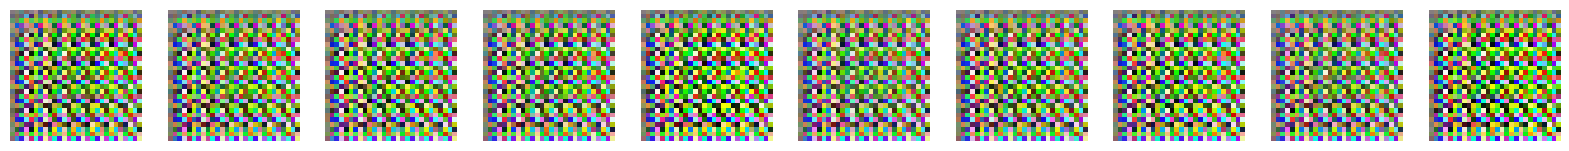

In [ ]:
# Generate and display images after training
generate_and_save_images(generator, epoch=1, latent_dim=latent_dim, n=10)



Epoch 1/10


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


Batches:   0%|          | 1/469 [00:05<40:27,  5.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:   0%|          | 2/469 [00:07<25:35,  3.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   1%|          | 3/469 [00:09<20:42,  2.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:   1%|          | 4/469 [00:11<18:28,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:   1%|          | 5/469 [00:12<17:11,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   1%|▏         | 6/469 [00:14<16:23,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


Batches:   1%|▏         | 7/469 [00:17<18:45,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   2%|▏         | 8/469 [00:19<17:07,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:   2%|▏         | 9/469 [00:21<16:23,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:   2%|▏         | 10/469 [00:23<15:51,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:   2%|▏         | 11/469 [00:25<15:28,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   3%|▎         | 12/469 [00:27<15:11,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


Batches:   3%|▎         | 13/469 [00:30<17:38,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   3%|▎         | 14/469 [00:32<16:39,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   3%|▎         | 15/469 [00:34<15:38,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Batches:   3%|▎         | 16/469 [00:36<15:19,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:   4%|▎         | 17/469 [00:37<14:39,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:   4%|▍         | 18/469 [00:39<14:34,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:   4%|▍         | 19/469 [00:42<16:14,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


Batches:   4%|▍         | 20/469 [00:44<15:52,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:   4%|▍         | 21/469 [00:46<15:23,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:   5%|▍         | 22/469 [00:48<15:08,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:   5%|▍         | 23/469 [00:50<14:26,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:   5%|▌         | 24/469 [00:51<14:00,  1.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:   5%|▌         | 25/469 [00:55<17:17,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step


Batches:   6%|▌         | 26/469 [00:57<17:49,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:   6%|▌         | 27/469 [01:00<18:13,  2.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:   6%|▌         | 28/469 [01:02<17:37,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   6%|▌         | 29/469 [01:05<17:32,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


Batches:   6%|▋         | 30/469 [01:08<19:04,  2.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:   7%|▋         | 31/469 [01:10<19:18,  2.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:   7%|▋         | 32/469 [01:12<17:19,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   7%|▋         | 33/469 [01:14<16:18,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:   7%|▋         | 34/469 [01:16<15:13,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   7%|▋         | 35/469 [01:18<14:35,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   8%|▊         | 36/469 [01:20<14:41,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:   8%|▊         | 37/469 [01:23<16:35,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:   8%|▊         | 38/469 [01:25<15:47,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:   8%|▊         | 39/469 [01:26<14:51,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:   9%|▊         | 40/469 [01:28<14:30,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:   9%|▊         | 41/469 [01:30<13:53,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:   9%|▉         | 42/469 [01:32<13:53,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:   9%|▉         | 43/469 [01:35<16:10,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:   9%|▉         | 44/469 [01:38<16:44,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  10%|▉         | 45/469 [01:40<15:46,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  10%|▉         | 46/469 [01:42<15:04,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  10%|█         | 47/469 [01:44<14:35,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  10%|█         | 48/469 [01:47<18:35,  2.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


Batches:  10%|█         | 49/469 [01:49<17:08,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  11%|█         | 50/469 [01:51<16:02,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  11%|█         | 51/469 [01:53<14:51,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  11%|█         | 52/469 [01:55<14:23,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  11%|█▏        | 53/469 [01:57<13:41,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  12%|█▏        | 54/469 [01:59<14:55,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


Batches:  12%|█▏        | 55/469 [02:02<15:47,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  12%|█▏        | 56/469 [02:04<14:36,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  12%|█▏        | 57/469 [02:06<14:08,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  12%|█▏        | 58/469 [02:08<13:54,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  13%|█▎        | 59/469 [02:09<13:18,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:  13%|█▎        | 60/469 [02:12<14:17,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  13%|█▎        | 61/469 [02:14<15:01,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  13%|█▎        | 62/469 [02:16<14:24,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  13%|█▎        | 63/469 [02:18<13:57,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  14%|█▎        | 64/469 [02:20<13:42,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  14%|█▍        | 65/469 [02:22<13:28,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  14%|█▍        | 66/469 [02:24<13:32,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  14%|█▍        | 67/469 [02:27<15:22,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Batches:  14%|█▍        | 68/469 [02:29<14:13,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  15%|█▍        | 69/469 [02:31<13:26,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  15%|█▍        | 70/469 [02:32<12:54,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  15%|█▌        | 71/469 [02:34<12:53,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  15%|█▌        | 72/469 [02:36<12:54,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


Batches:  16%|█▌        | 73/469 [02:39<15:08,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  16%|█▌        | 74/469 [02:41<14:01,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  16%|█▌        | 75/469 [02:43<13:35,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  16%|█▌        | 76/469 [02:45<13:16,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  16%|█▋        | 77/469 [02:47<12:39,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  17%|█▋        | 78/469 [02:49<12:40,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  17%|█▋        | 79/469 [02:51<14:07,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


Batches:  17%|█▋        | 80/469 [02:54<14:54,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  17%|█▋        | 81/469 [02:56<14:12,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  17%|█▋        | 82/469 [02:58<13:40,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  18%|█▊        | 83/469 [03:00<13:20,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  18%|█▊        | 84/469 [03:02<13:05,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  18%|█▊        | 85/469 [03:04<14:17,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


Batches:  18%|█▊        | 86/469 [03:06<13:54,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  19%|█▊        | 87/469 [03:08<13:22,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  19%|█▉        | 88/469 [03:10<13:03,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  19%|█▉        | 89/469 [03:12<12:49,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  19%|█▉        | 90/469 [03:14<13:07,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step


Batches:  19%|█▉        | 91/469 [03:18<15:35,  2.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step


Batches:  20%|█▉        | 92/469 [03:20<14:21,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  20%|█▉        | 93/469 [03:22<13:40,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  20%|██        | 94/469 [03:23<12:53,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  20%|██        | 95/469 [03:25<12:42,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  20%|██        | 96/469 [03:27<12:28,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  21%|██        | 97/469 [03:30<13:51,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


Batches:  21%|██        | 98/469 [03:32<13:42,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  21%|██        | 99/469 [03:34<12:50,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  21%|██▏       | 100/469 [03:36<12:32,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  22%|██▏       | 101/469 [03:38<11:56,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  22%|██▏       | 102/469 [03:40<11:58,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  22%|██▏       | 103/469 [03:42<11:44,  1.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  22%|██▏       | 104/469 [03:45<13:41,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  22%|██▏       | 105/469 [03:47<13:07,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  23%|██▎       | 106/469 [03:48<12:24,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  23%|██▎       | 107/469 [03:50<12:08,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  23%|██▎       | 108/469 [03:52<11:43,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  23%|██▎       | 109/469 [03:54<11:42,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  23%|██▎       | 110/469 [03:57<13:16,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


Batches:  24%|██▎       | 111/469 [03:59<12:44,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  24%|██▍       | 112/469 [04:01<12:17,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  24%|██▍       | 113/469 [04:03<11:58,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  24%|██▍       | 114/469 [04:05<11:47,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  25%|██▍       | 115/469 [04:06<11:36,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  25%|██▍       | 116/469 [04:09<12:29,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


Batches:  25%|██▍       | 117/469 [04:12<13:19,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  25%|██▌       | 118/469 [04:13<12:39,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  25%|██▌       | 119/469 [04:15<12:15,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  26%|██▌       | 120/469 [04:17<11:54,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  26%|██▌       | 121/469 [04:19<11:38,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  26%|██▌       | 122/469 [04:22<12:54,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


Batches:  26%|██▌       | 123/469 [04:25<13:27,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  26%|██▋       | 124/469 [04:27<12:42,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  27%|██▋       | 125/469 [04:28<12:08,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  27%|██▋       | 126/469 [04:30<11:48,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  27%|██▋       | 127/469 [04:32<11:37,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  27%|██▋       | 128/469 [04:35<12:19,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  28%|██▊       | 129/469 [04:37<13:01,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  28%|██▊       | 130/469 [04:39<12:21,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  28%|██▊       | 131/469 [04:41<11:52,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  28%|██▊       | 132/469 [04:43<11:31,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  28%|██▊       | 133/469 [04:45<11:16,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  29%|██▊       | 134/469 [04:48<12:15,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  29%|██▉       | 135/469 [04:50<12:54,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  29%|██▉       | 136/469 [04:52<12:13,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  29%|██▉       | 137/469 [04:54<11:44,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  29%|██▉       | 138/469 [04:56<11:26,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  30%|██▉       | 139/469 [04:58<10:55,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  30%|██▉       | 140/469 [05:01<11:59,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  30%|███       | 141/469 [05:03<12:36,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  30%|███       | 142/469 [05:05<11:43,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  30%|███       | 143/469 [05:07<11:20,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  31%|███       | 144/469 [05:09<10:47,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Batches:  31%|███       | 145/469 [05:11<10:42,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  31%|███       | 146/469 [05:13<11:30,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  31%|███▏      | 147/469 [05:16<11:56,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  32%|███▏      | 148/469 [05:18<11:27,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  32%|███▏      | 149/469 [05:19<11:05,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  32%|███▏      | 150/469 [05:21<10:52,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  32%|███▏      | 151/469 [05:23<10:25,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  32%|███▏      | 152/469 [05:25<10:05,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  33%|███▎      | 153/469 [05:28<11:52,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  33%|███▎      | 154/469 [05:30<11:20,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  33%|███▎      | 155/469 [05:32<11:01,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  33%|███▎      | 156/469 [05:34<10:43,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  33%|███▎      | 157/469 [05:36<10:32,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  34%|███▎      | 158/469 [05:38<10:32,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  34%|███▍      | 159/469 [05:41<11:56,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  34%|███▍      | 160/469 [05:43<11:22,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  34%|███▍      | 161/469 [05:45<10:40,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  35%|███▍      | 162/469 [05:47<10:28,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  35%|███▍      | 163/469 [05:48<10:04,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  35%|███▍      | 164/469 [05:50<09:44,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


Batches:  35%|███▌      | 165/469 [05:53<11:31,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  35%|███▌      | 166/469 [05:55<10:44,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  36%|███▌      | 167/469 [05:57<10:29,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  36%|███▌      | 168/469 [05:59<10:14,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  36%|███▌      | 169/469 [06:01<09:48,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  36%|███▌      | 170/469 [06:03<09:33,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


Batches:  36%|███▋      | 171/469 [06:05<10:43,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


Batches:  37%|███▋      | 172/469 [06:08<11:20,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  37%|███▋      | 173/469 [06:10<10:32,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  37%|███▋      | 174/469 [06:12<10:14,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  37%|███▋      | 175/469 [06:14<10:01,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  38%|███▊      | 176/469 [06:15<09:36,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  38%|███▊      | 177/469 [06:18<10:32,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  38%|███▊      | 178/469 [06:21<11:08,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  38%|███▊      | 179/469 [06:23<10:39,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  38%|███▊      | 180/469 [06:25<10:14,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  39%|███▊      | 181/469 [06:26<09:44,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  39%|███▉      | 182/469 [06:28<09:21,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  39%|███▉      | 183/469 [06:30<09:51,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  39%|███▉      | 184/469 [06:33<10:34,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  39%|███▉      | 185/469 [06:35<09:52,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  40%|███▉      | 186/469 [06:37<09:24,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  40%|███▉      | 187/469 [06:38<09:02,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  40%|████      | 188/469 [06:40<09:02,  1.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  40%|████      | 189/469 [06:42<09:21,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  41%|████      | 190/469 [06:45<10:24,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  41%|████      | 191/469 [06:47<10:01,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  41%|████      | 192/469 [06:49<09:45,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  41%|████      | 193/469 [06:51<09:29,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  41%|████▏     | 194/469 [06:53<09:17,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Batches:  42%|████▏     | 195/469 [06:55<09:11,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  42%|████▏     | 196/469 [06:58<10:15,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:  42%|████▏     | 197/469 [07:00<09:42,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  42%|████▏     | 198/469 [07:02<09:10,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  42%|████▏     | 199/469 [07:03<08:48,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  43%|████▎     | 200/469 [07:05<08:32,  1.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  43%|████▎     | 201/469 [07:07<08:19,  1.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  43%|████▎     | 202/469 [07:09<08:25,  1.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  43%|████▎     | 203/469 [07:12<09:42,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  43%|████▎     | 204/469 [07:14<09:07,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  44%|████▎     | 205/469 [07:16<08:55,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  44%|████▍     | 206/469 [07:17<08:46,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  44%|████▍     | 207/469 [07:19<08:25,  1.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  44%|████▍     | 208/469 [07:21<08:12,  1.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  45%|████▍     | 209/469 [07:24<09:41,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  45%|████▍     | 210/469 [07:26<09:04,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  45%|████▍     | 211/469 [07:28<08:38,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  45%|████▌     | 212/469 [07:30<08:31,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  45%|████▌     | 213/469 [07:31<08:12,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  46%|████▌     | 214/469 [07:33<08:12,  1.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  46%|████▌     | 215/469 [07:36<09:07,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  46%|████▌     | 216/469 [07:38<08:57,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  46%|████▋     | 217/469 [07:40<08:44,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  46%|████▋     | 218/469 [07:42<08:34,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  47%|████▋     | 219/469 [07:44<08:12,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  47%|████▋     | 220/469 [07:46<07:58,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  47%|████▋     | 221/469 [07:48<08:15,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  47%|████▋     | 222/469 [07:50<08:58,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  48%|████▊     | 223/469 [07:52<08:27,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  48%|████▊     | 224/469 [07:54<08:16,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  48%|████▊     | 225/469 [07:56<07:55,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  48%|████▊     | 226/469 [07:58<07:53,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  48%|████▊     | 227/469 [08:00<07:53,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


Batches:  49%|████▊     | 228/469 [08:03<09:16,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  49%|████▉     | 229/469 [08:05<08:36,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  49%|████▉     | 230/469 [08:07<08:20,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Batches:  49%|████▉     | 231/469 [08:08<07:53,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  49%|████▉     | 232/469 [08:10<07:46,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  50%|████▉     | 233/469 [08:12<07:43,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


Batches:  50%|████▉     | 234/469 [08:15<08:39,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


Batches:  50%|█████     | 235/469 [08:17<08:24,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  50%|█████     | 236/469 [08:19<08:08,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  51%|█████     | 237/469 [08:21<07:45,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  51%|█████     | 238/469 [08:23<07:26,  1.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  51%|█████     | 239/469 [08:24<07:12,  1.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  51%|█████     | 240/469 [08:27<07:34,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  51%|█████▏    | 241/469 [08:29<08:29,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  52%|█████▏    | 242/469 [08:31<08:06,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  52%|█████▏    | 243/469 [08:33<07:51,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  52%|█████▏    | 244/469 [08:35<07:38,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  52%|█████▏    | 245/469 [08:37<07:37,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  52%|█████▏    | 246/469 [08:40<08:36,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  53%|█████▎    | 247/469 [08:43<08:58,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  53%|█████▎    | 248/469 [08:45<08:13,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  53%|█████▎    | 249/469 [08:47<07:53,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  53%|█████▎    | 250/469 [08:48<07:28,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  54%|█████▎    | 251/469 [08:50<07:18,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  54%|█████▎    | 252/469 [08:52<07:23,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  54%|█████▍    | 253/469 [08:55<08:10,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  54%|█████▍    | 254/469 [08:57<07:47,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  54%|█████▍    | 255/469 [08:59<07:29,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  55%|█████▍    | 256/469 [09:01<07:18,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  55%|█████▍    | 257/469 [09:03<07:09,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  55%|█████▌    | 258/469 [09:06<07:38,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  55%|█████▌    | 259/469 [09:08<08:02,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  55%|█████▌    | 260/469 [09:10<07:37,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  56%|█████▌    | 261/469 [09:12<07:08,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  56%|█████▌    | 262/469 [09:14<06:49,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  56%|█████▌    | 263/469 [09:16<06:47,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  56%|█████▋    | 264/469 [09:18<06:49,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


Batches:  57%|█████▋    | 265/469 [09:21<07:41,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  57%|█████▋    | 266/469 [09:23<07:19,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  57%|█████▋    | 267/469 [09:24<06:52,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  57%|█████▋    | 268/469 [09:26<06:35,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  57%|█████▋    | 269/469 [09:28<06:21,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  58%|█████▊    | 270/469 [09:30<06:25,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  58%|█████▊    | 271/469 [09:33<07:28,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  58%|█████▊    | 272/469 [09:35<07:06,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  58%|█████▊    | 273/469 [09:37<06:41,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  58%|█████▊    | 274/469 [09:38<06:23,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  59%|█████▊    | 275/469 [09:40<06:19,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  59%|█████▉    | 276/469 [09:42<06:05,  1.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


Batches:  59%|█████▉    | 277/469 [09:45<06:49,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:  59%|█████▉    | 278/469 [09:47<07:14,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  59%|█████▉    | 279/469 [09:49<06:51,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  60%|█████▉    | 280/469 [09:51<06:27,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  60%|█████▉    | 281/469 [09:53<06:18,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  60%|██████    | 282/469 [09:55<06:02,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  60%|██████    | 283/469 [09:57<06:33,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step


Batches:  61%|██████    | 284/469 [09:59<06:38,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  61%|██████    | 285/469 [10:01<06:23,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  61%|██████    | 286/469 [10:03<06:05,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  61%|██████    | 287/469 [10:05<05:59,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  61%|██████▏   | 288/469 [10:07<05:54,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  62%|██████▏   | 289/469 [10:09<06:02,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  62%|██████▏   | 290/469 [10:12<06:42,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  62%|██████▏   | 291/469 [10:14<06:15,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  62%|██████▏   | 292/469 [10:16<05:54,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  62%|██████▏   | 293/469 [10:17<05:41,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  63%|██████▎   | 294/469 [10:19<05:40,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  63%|██████▎   | 295/469 [10:21<05:39,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  63%|██████▎   | 296/469 [10:24<06:20,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


Batches:  63%|██████▎   | 297/469 [10:27<06:39,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  64%|██████▎   | 298/469 [10:29<06:16,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  64%|██████▍   | 299/469 [10:31<06:03,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  64%|██████▍   | 300/469 [10:32<05:50,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  64%|██████▍   | 301/469 [10:34<05:41,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  64%|██████▍   | 302/469 [10:37<06:05,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


Batches:  65%|██████▍   | 303/469 [10:40<06:24,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  65%|██████▍   | 304/469 [10:41<06:02,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  65%|██████▌   | 305/469 [10:43<05:39,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  65%|██████▌   | 306/469 [10:45<05:23,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  65%|██████▌   | 307/469 [10:47<05:20,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  66%|██████▌   | 308/469 [10:49<05:39,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  66%|██████▌   | 309/469 [10:52<05:50,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  66%|██████▌   | 310/469 [10:54<05:36,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  66%|██████▋   | 311/469 [10:55<05:17,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  67%|██████▋   | 312/469 [10:57<05:04,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  67%|██████▋   | 313/469 [10:59<04:54,  1.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  67%|██████▋   | 314/469 [11:01<04:55,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  67%|██████▋   | 315/469 [11:04<05:50,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


Batches:  67%|██████▋   | 316/469 [11:06<05:33,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  68%|██████▊   | 317/469 [11:08<05:19,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


Batches:  68%|██████▊   | 318/469 [11:10<05:26,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  68%|██████▊   | 319/469 [11:13<05:29,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  68%|██████▊   | 320/469 [11:16<06:20,  2.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step


Batches:  68%|██████▊   | 321/469 [11:19<06:45,  2.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  69%|██████▊   | 322/469 [11:21<06:00,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  69%|██████▉   | 323/469 [11:23<05:35,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  69%|██████▉   | 324/469 [11:25<05:20,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  69%|██████▉   | 325/469 [11:27<04:59,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  70%|██████▉   | 326/469 [11:28<04:47,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  70%|██████▉   | 327/469 [11:31<05:24,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


Batches:  70%|██████▉   | 328/469 [11:33<05:11,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  70%|███████   | 329/469 [11:35<04:51,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  70%|███████   | 330/469 [11:37<04:38,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  71%|███████   | 331/469 [11:39<04:27,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  71%|███████   | 332/469 [11:41<04:19,  1.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  71%|███████   | 333/469 [11:43<04:35,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  71%|███████   | 334/469 [11:45<04:51,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  71%|███████▏  | 335/469 [11:47<04:34,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  72%|███████▏  | 336/469 [11:49<04:28,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  72%|███████▏  | 337/469 [11:51<04:16,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  72%|███████▏  | 338/469 [11:53<04:07,  1.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  72%|███████▏  | 339/469 [11:54<04:01,  1.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  72%|███████▏  | 340/469 [11:57<04:33,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


Batches:  73%|███████▎  | 341/469 [11:59<04:26,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  73%|███████▎  | 342/469 [12:01<04:19,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  73%|███████▎  | 343/469 [12:03<04:14,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  73%|███████▎  | 344/469 [12:05<04:09,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  74%|███████▎  | 345/469 [12:07<04:04,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  74%|███████▍  | 346/469 [12:09<04:17,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  74%|███████▍  | 347/469 [12:12<04:34,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  74%|███████▍  | 348/469 [12:14<04:21,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  74%|███████▍  | 349/469 [12:16<04:06,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  75%|███████▍  | 350/469 [12:18<04:00,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  75%|███████▍  | 351/469 [12:19<03:50,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  75%|███████▌  | 352/469 [12:22<04:06,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  75%|███████▌  | 353/469 [12:24<04:17,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  75%|███████▌  | 354/469 [12:26<04:00,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  76%|███████▌  | 355/469 [12:28<03:54,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  76%|███████▌  | 356/469 [12:30<03:44,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  76%|███████▌  | 357/469 [12:32<03:41,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  76%|███████▋  | 358/469 [12:34<03:41,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  77%|███████▋  | 359/469 [12:37<04:13,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  77%|███████▋  | 360/469 [12:39<03:54,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  77%|███████▋  | 361/469 [12:41<03:45,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  77%|███████▋  | 362/469 [12:43<03:39,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  77%|███████▋  | 363/469 [12:45<03:34,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  78%|███████▊  | 364/469 [12:47<03:34,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  78%|███████▊  | 365/469 [12:50<04:03,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  78%|███████▊  | 366/469 [12:52<03:44,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  78%|███████▊  | 367/469 [12:53<03:30,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  78%|███████▊  | 368/469 [12:55<03:25,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  79%|███████▊  | 369/469 [12:57<03:15,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  79%|███████▉  | 370/469 [12:59<03:08,  1.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


Batches:  79%|███████▉  | 371/469 [13:02<03:31,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


Batches:  79%|███████▉  | 372/469 [13:04<03:44,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  80%|███████▉  | 373/469 [13:06<03:31,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  80%|███████▉  | 374/469 [13:08<03:16,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  80%|███████▉  | 375/469 [13:10<03:06,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  80%|████████  | 376/469 [13:12<03:03,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  80%|████████  | 377/469 [13:15<03:25,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  81%|████████  | 378/469 [13:17<03:20,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  81%|████████  | 379/469 [13:19<03:08,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  81%|████████  | 380/469 [13:20<02:58,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  81%|████████  | 381/469 [13:22<02:51,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  81%|████████▏ | 382/469 [13:24<02:49,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  82%|████████▏ | 383/469 [13:26<02:48,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  82%|████████▏ | 384/469 [13:29<03:10,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  82%|████████▏ | 385/469 [13:31<03:00,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  82%|████████▏ | 386/469 [13:33<02:49,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  83%|████████▎ | 387/469 [13:35<02:44,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  83%|████████▎ | 388/469 [13:37<02:41,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  83%|████████▎ | 389/469 [13:39<02:35,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  83%|████████▎ | 390/469 [13:42<03:00,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  83%|████████▎ | 391/469 [13:43<02:47,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  84%|████████▎ | 392/469 [13:45<02:37,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  84%|████████▍ | 393/469 [13:47<02:33,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  84%|████████▍ | 394/469 [13:49<02:30,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  84%|████████▍ | 395/469 [13:51<02:27,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  84%|████████▍ | 396/469 [13:54<02:49,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  85%|████████▍ | 397/469 [13:56<02:36,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  85%|████████▍ | 398/469 [13:58<02:29,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  85%|████████▌ | 399/469 [14:00<02:23,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  85%|████████▌ | 400/469 [14:02<02:15,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  86%|████████▌ | 401/469 [14:04<02:14,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  86%|████████▌ | 402/469 [14:07<02:35,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  86%|████████▌ | 403/469 [14:09<02:25,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  86%|████████▌ | 404/469 [14:11<02:19,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  86%|████████▋ | 405/469 [14:13<02:13,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  87%|████████▋ | 406/469 [14:15<02:08,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  87%|████████▋ | 407/469 [14:16<02:03,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  87%|████████▋ | 408/469 [14:20<02:20,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  87%|████████▋ | 409/469 [14:21<02:08,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  87%|████████▋ | 410/469 [14:23<02:02,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  88%|████████▊ | 411/469 [14:25<01:57,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  88%|████████▊ | 412/469 [14:27<01:54,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  88%|████████▊ | 413/469 [14:29<01:52,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  88%|████████▊ | 414/469 [14:32<02:08,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  88%|████████▊ | 415/469 [14:34<02:00,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  89%|████████▊ | 416/469 [14:36<01:51,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  89%|████████▉ | 417/469 [14:38<01:47,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  89%|████████▉ | 418/469 [14:40<01:43,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  89%|████████▉ | 419/469 [14:42<01:42,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  90%|████████▉ | 420/469 [14:45<01:54,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  90%|████████▉ | 421/469 [14:47<01:46,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  90%|████████▉ | 422/469 [14:49<01:40,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  90%|█████████ | 423/469 [14:51<01:33,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  90%|█████████ | 424/469 [14:53<01:30,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  91%|█████████ | 425/469 [14:55<01:29,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  91%|█████████ | 426/469 [14:58<01:40,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  91%|█████████ | 427/469 [15:00<01:32,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  91%|█████████▏| 428/469 [15:01<01:25,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  91%|█████████▏| 429/469 [15:03<01:21,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  92%|█████████▏| 430/469 [15:05<01:16,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  92%|█████████▏| 431/469 [15:07<01:15,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  92%|█████████▏| 432/469 [15:10<01:24,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  92%|█████████▏| 433/469 [15:12<01:17,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  93%|█████████▎| 434/469 [15:14<01:12,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  93%|█████████▎| 435/469 [15:16<01:09,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  93%|█████████▎| 436/469 [15:18<01:05,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  93%|█████████▎| 437/469 [15:20<01:03,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  93%|█████████▎| 438/469 [15:23<01:11,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  94%|█████████▎| 439/469 [15:25<01:04,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  94%|█████████▍| 440/469 [15:27<01:00,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  94%|█████████▍| 441/469 [15:28<00:56,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  94%|█████████▍| 442/469 [15:30<00:53,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Batches:  94%|█████████▍| 443/469 [15:32<00:51,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:  95%|█████████▍| 444/469 [15:35<00:55,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


Batches:  95%|█████████▍| 445/469 [15:38<00:56,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  95%|█████████▌| 446/469 [15:40<00:51,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  95%|█████████▌| 447/469 [15:42<00:47,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  96%|█████████▌| 448/469 [15:44<00:44,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  96%|█████████▌| 449/469 [15:45<00:40,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  96%|█████████▌| 450/469 [15:48<00:42,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


Batches:  96%|█████████▌| 451/469 [15:50<00:39,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  96%|█████████▋| 452/469 [15:52<00:35,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  97%|█████████▋| 453/469 [15:54<00:33,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  97%|█████████▋| 454/469 [15:56<00:30,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  97%|█████████▋| 455/469 [15:58<00:28,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  97%|█████████▋| 456/469 [16:00<00:27,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:  97%|█████████▋| 457/469 [16:03<00:27,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Batches:  98%|█████████▊| 458/469 [16:05<00:23,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  98%|█████████▊| 459/469 [16:07<00:20,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  98%|█████████▊| 460/469 [16:09<00:17,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  98%|█████████▊| 461/469 [16:10<00:15,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  99%|█████████▊| 462/469 [16:13<00:14,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  99%|█████████▊| 463/469 [16:15<00:13,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  99%|█████████▉| 464/469 [16:17<00:10,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  99%|█████████▉| 465/469 [16:19<00:08,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  99%|█████████▉| 466/469 [16:21<00:06,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches: 100%|█████████▉| 467/469 [16:23<00:04,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches: 100%|█████████▉| 468/469 [16:25<00:01,  1.98s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches: 100%|██████████| 469/469 [16:29<00:00,  2.11s/it]


D Loss: 8.715473175048828, G Loss: 0.018414201214909554

Epoch 2/10


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:   0%|          | 1/469 [00:01<14:41,  1.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:   0%|          | 2/469 [00:03<14:55,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   1%|          | 3/469 [00:05<15:02,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   1%|          | 4/469 [00:07<15:02,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   1%|          | 5/469 [00:10<16:01,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:   1%|▏         | 6/469 [00:12<17:50,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   1%|▏         | 7/469 [00:14<16:26,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:   2%|▏         | 8/469 [00:16<16:00,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   2%|▏         | 9/469 [00:18<15:43,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:   2%|▏         | 10/469 [00:20<15:07,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   2%|▏         | 11/469 [00:22<15:34,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:   3%|▎         | 12/469 [00:25<17:31,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:   3%|▎         | 13/469 [00:27<16:18,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   3%|▎         | 14/469 [00:29<15:28,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:   3%|▎         | 15/469 [00:30<14:50,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:   3%|▎         | 16/469 [00:32<14:44,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   4%|▎         | 17/469 [00:34<14:44,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:   4%|▍         | 18/469 [00:37<17:20,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   4%|▍         | 19/469 [00:39<16:26,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   4%|▍         | 20/469 [00:41<15:49,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:   4%|▍         | 21/469 [00:43<15:05,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   5%|▍         | 22/469 [00:45<14:49,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:   5%|▍         | 23/469 [00:47<14:48,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:   5%|▌         | 24/469 [00:50<16:43,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   5%|▌         | 25/469 [00:52<15:58,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:   6%|▌         | 26/469 [00:54<15:28,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:   6%|▌         | 27/469 [00:56<15:07,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   6%|▌         | 28/469 [00:57<14:30,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:   6%|▌         | 29/469 [00:59<14:24,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:   6%|▋         | 30/469 [01:02<15:24,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:   7%|▋         | 31/469 [01:04<15:53,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:   7%|▋         | 32/469 [01:06<15:24,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:   7%|▋         | 33/469 [01:08<15:04,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:   7%|▋         | 34/469 [01:10<14:43,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:   7%|▋         | 35/469 [01:12<14:28,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   8%|▊         | 36/469 [01:14<14:50,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:   8%|▊         | 37/469 [01:17<16:35,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:   8%|▊         | 38/469 [01:19<15:49,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:   8%|▊         | 39/469 [01:21<15:13,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:   9%|▊         | 40/469 [01:23<14:48,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:   9%|▊         | 41/469 [01:25<14:34,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:   9%|▉         | 42/469 [01:27<14:55,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:   9%|▉         | 43/469 [01:30<16:25,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:   9%|▉         | 44/469 [01:32<15:19,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  10%|▉         | 45/469 [01:34<14:41,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  10%|▉         | 46/469 [01:36<14:28,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  10%|█         | 47/469 [01:37<13:57,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  10%|█         | 48/469 [01:39<14:08,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  10%|█         | 49/469 [01:43<16:15,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  11%|█         | 50/469 [01:44<15:27,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  11%|█         | 51/469 [01:46<14:54,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  11%|█         | 52/469 [01:48<14:34,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  11%|█▏        | 53/469 [01:50<13:53,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  12%|█▏        | 54/469 [01:52<13:43,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  12%|█▏        | 55/469 [01:55<15:52,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  12%|█▏        | 56/469 [01:57<15:06,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  12%|█▏        | 57/469 [01:59<14:16,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  12%|█▏        | 58/469 [02:01<14:02,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  13%|█▎        | 59/469 [02:03<13:28,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  13%|█▎        | 60/469 [02:05<13:32,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  13%|█▎        | 61/469 [02:08<15:49,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  13%|█▎        | 62/469 [02:10<14:45,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  13%|█▎        | 63/469 [02:12<14:01,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  14%|█▎        | 64/469 [02:13<13:44,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  14%|█▍        | 65/469 [02:15<13:31,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  14%|█▍        | 66/469 [02:17<13:21,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:  14%|█▍        | 67/469 [02:20<15:35,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  14%|█▍        | 68/469 [02:22<14:29,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  15%|█▍        | 69/469 [02:24<14:02,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  15%|█▍        | 70/469 [02:26<13:44,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Batches:  15%|█▌        | 71/469 [02:28<13:28,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  15%|█▌        | 72/469 [02:30<13:20,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  16%|█▌        | 73/469 [02:33<15:21,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  16%|█▌        | 74/469 [02:35<14:33,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  16%|█▌        | 75/469 [02:37<13:59,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  16%|█▌        | 76/469 [02:39<13:34,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  16%|█▋        | 77/469 [02:41<13:16,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  17%|█▋        | 78/469 [02:43<13:16,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  17%|█▋        | 79/469 [02:46<15:08,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  17%|█▋        | 80/469 [02:48<14:22,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  17%|█▋        | 81/469 [02:50<13:53,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  17%|█▋        | 82/469 [02:52<13:29,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  18%|█▊        | 83/469 [02:54<13:13,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  18%|█▊        | 84/469 [02:56<12:56,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  18%|█▊        | 85/469 [02:59<14:42,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  18%|█▊        | 86/469 [03:01<13:58,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  19%|█▊        | 87/469 [03:03<13:25,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  19%|█▉        | 88/469 [03:05<13:04,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  19%|█▉        | 89/469 [03:07<12:52,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  19%|█▉        | 90/469 [03:09<12:53,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  19%|█▉        | 91/469 [03:12<14:33,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  20%|█▉        | 92/469 [03:13<13:33,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  20%|█▉        | 93/469 [03:15<13:05,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  20%|██        | 94/469 [03:17<12:46,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  20%|██        | 95/469 [03:19<12:13,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  20%|██        | 96/469 [03:21<12:10,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  21%|██        | 97/469 [03:24<14:08,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  21%|██        | 98/469 [03:26<13:12,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  21%|██        | 99/469 [03:28<12:46,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  21%|██▏       | 100/469 [03:30<12:32,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  22%|██▏       | 101/469 [03:31<12:00,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  22%|██▏       | 102/469 [03:33<11:57,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  22%|██▏       | 103/469 [03:36<13:32,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


Batches:  22%|██▏       | 104/469 [03:39<14:16,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  22%|██▏       | 105/469 [03:41<13:09,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  23%|██▎       | 106/469 [03:42<12:25,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  23%|██▎       | 107/469 [03:44<11:52,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  23%|██▎       | 108/469 [03:46<11:48,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  23%|██▎       | 109/469 [03:49<13:07,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  23%|██▎       | 110/469 [03:51<13:54,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  24%|██▎       | 111/469 [03:53<13:10,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  24%|██▍       | 112/469 [03:55<12:19,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  24%|██▍       | 113/469 [03:57<12:02,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  24%|██▍       | 114/469 [03:59<11:35,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  25%|██▍       | 115/469 [04:01<12:11,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  25%|██▍       | 116/469 [04:04<13:06,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  25%|██▍       | 117/469 [04:06<12:16,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  25%|██▌       | 118/469 [04:07<11:52,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  25%|██▌       | 119/469 [04:09<11:40,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  26%|██▌       | 120/469 [04:11<11:16,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  26%|██▌       | 121/469 [04:13<11:51,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  26%|██▌       | 122/469 [04:16<13:02,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  26%|██▌       | 123/469 [04:18<12:26,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  26%|██▋       | 124/469 [04:20<12:01,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  27%|██▋       | 125/469 [04:22<11:44,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  27%|██▋       | 126/469 [04:24<11:28,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  27%|██▋       | 127/469 [04:26<11:54,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  27%|██▋       | 128/469 [04:29<12:49,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  28%|██▊       | 129/469 [04:31<12:13,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  28%|██▊       | 130/469 [04:33<11:46,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  28%|██▊       | 131/469 [04:34<11:13,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  28%|██▊       | 132/469 [04:36<11:09,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  28%|██▊       | 133/469 [04:38<10:46,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  29%|██▊       | 134/469 [04:41<12:12,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  29%|██▉       | 135/469 [04:44<12:54,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  29%|██▉       | 136/469 [04:46<12:16,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  29%|██▉       | 137/469 [04:47<11:34,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  29%|██▉       | 138/469 [04:49<11:02,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  30%|██▉       | 139/469 [04:51<10:54,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  30%|██▉       | 140/469 [04:54<12:03,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  30%|███       | 141/469 [04:56<12:43,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  30%|███       | 142/469 [04:58<12:02,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  30%|███       | 143/469 [05:00<11:37,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  31%|███       | 144/469 [05:02<11:16,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  31%|███       | 145/469 [05:04<10:44,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  31%|███       | 146/469 [05:07<12:00,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  31%|███▏      | 147/469 [05:09<11:42,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  32%|███▏      | 148/469 [05:11<11:15,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  32%|███▏      | 149/469 [05:13<10:57,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  32%|███▏      | 150/469 [05:15<10:42,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  32%|███▏      | 151/469 [05:17<10:33,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  32%|███▏      | 152/469 [05:19<11:27,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  33%|███▎      | 153/469 [05:22<12:06,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  33%|███▎      | 154/469 [05:24<11:33,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  33%|███▎      | 155/469 [05:26<10:51,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  33%|███▎      | 156/469 [05:28<10:37,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  33%|███▎      | 157/469 [05:30<10:28,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  34%|███▎      | 158/469 [05:32<11:31,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  34%|███▍      | 159/469 [05:35<12:05,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  34%|███▍      | 160/469 [05:37<11:17,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  34%|███▍      | 161/469 [05:39<10:39,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  35%|███▍      | 162/469 [05:40<10:24,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  35%|███▍      | 163/469 [05:42<10:13,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  35%|███▍      | 164/469 [05:45<11:13,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  35%|███▌      | 165/469 [05:48<11:48,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  35%|███▌      | 166/469 [05:50<11:11,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  36%|███▌      | 167/469 [05:52<10:43,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  36%|███▌      | 168/469 [05:54<10:26,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  36%|███▌      | 169/469 [05:55<10:09,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  36%|███▌      | 170/469 [05:58<11:14,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  36%|███▋      | 171/469 [06:01<11:44,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  37%|███▋      | 172/469 [06:03<10:53,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  37%|███▋      | 173/469 [06:05<10:27,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  37%|███▋      | 174/469 [06:06<09:55,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step


Batches:  37%|███▋      | 175/469 [06:08<09:51,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  38%|███▊      | 176/469 [06:11<10:26,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  38%|███▊      | 177/469 [06:13<11:08,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  38%|███▊      | 178/469 [06:15<10:35,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  38%|███▊      | 179/469 [06:17<10:11,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  38%|███▊      | 180/469 [06:19<09:42,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  39%|███▊      | 181/469 [06:21<09:20,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  39%|███▉      | 182/469 [06:23<10:10,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  39%|███▉      | 183/469 [06:26<10:30,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  39%|███▉      | 184/469 [06:28<10:09,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  39%|███▉      | 185/469 [06:30<09:50,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  40%|███▉      | 186/469 [06:32<09:25,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  40%|███▉      | 187/469 [06:34<09:18,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  40%|████      | 188/469 [06:36<09:24,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  40%|████      | 189/469 [06:39<10:46,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  41%|████      | 190/469 [06:41<10:15,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  41%|████      | 191/469 [06:42<09:39,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  41%|████      | 192/469 [06:44<09:25,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  41%|████      | 193/469 [06:46<09:14,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  41%|████▏     | 194/469 [06:48<09:18,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  42%|████▏     | 195/469 [06:51<10:37,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  42%|████▏     | 196/469 [06:53<10:05,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  42%|████▏     | 197/469 [06:55<09:45,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  42%|████▏     | 198/469 [06:57<09:26,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  42%|████▏     | 199/469 [06:59<09:11,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  43%|████▎     | 200/469 [07:01<08:57,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  43%|████▎     | 201/469 [07:04<10:05,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  43%|████▎     | 202/469 [07:06<09:28,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  43%|████▎     | 203/469 [07:08<09:18,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  43%|████▎     | 204/469 [07:10<08:51,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  44%|████▎     | 205/469 [07:12<08:44,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  44%|████▍     | 206/469 [07:13<08:38,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  44%|████▍     | 207/469 [07:16<09:38,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:  44%|████▍     | 208/469 [07:19<10:08,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  45%|████▍     | 209/469 [07:21<09:34,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  45%|████▍     | 210/469 [07:23<09:12,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Batches:  45%|████▍     | 211/469 [07:25<08:54,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  45%|████▌     | 212/469 [07:27<08:43,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  45%|████▌     | 213/469 [07:29<09:37,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


Batches:  46%|████▌     | 214/469 [07:32<10:01,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  46%|████▌     | 215/469 [07:34<09:28,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  46%|████▌     | 216/469 [07:36<09:03,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  46%|████▋     | 217/469 [07:38<08:57,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:  46%|████▋     | 218/469 [07:40<08:45,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  47%|████▋     | 219/469 [07:43<10:03,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  47%|████▋     | 220/469 [07:45<09:26,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  47%|████▋     | 221/469 [07:47<09:01,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  47%|████▋     | 222/469 [07:49<08:35,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  48%|████▊     | 223/469 [07:51<08:24,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  48%|████▊     | 224/469 [07:53<08:19,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  48%|████▊     | 225/469 [07:56<09:32,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  48%|████▊     | 226/469 [07:58<08:59,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  48%|████▊     | 227/469 [08:00<08:43,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  49%|████▊     | 228/469 [08:02<08:25,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  49%|████▉     | 229/469 [08:04<08:14,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  49%|████▉     | 230/469 [08:06<08:23,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  49%|████▉     | 231/469 [08:09<09:24,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  49%|████▉     | 232/469 [08:11<08:54,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  50%|████▉     | 233/469 [08:13<08:30,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  50%|████▉     | 234/469 [08:15<08:12,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  50%|█████     | 235/469 [08:17<08:00,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  50%|█████     | 236/469 [08:19<08:06,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  51%|█████     | 237/469 [08:22<09:01,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  51%|█████     | 238/469 [08:24<08:20,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  51%|█████     | 239/469 [08:26<08:04,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  51%|█████     | 240/469 [08:28<07:51,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  51%|█████▏    | 241/469 [08:30<07:41,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  52%|█████▏    | 242/469 [08:32<07:43,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  52%|█████▏    | 243/469 [08:34<08:34,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  52%|█████▏    | 244/469 [08:36<08:09,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  52%|█████▏    | 245/469 [08:38<07:52,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  52%|█████▏    | 246/469 [08:40<07:39,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  53%|█████▎    | 247/469 [08:42<07:29,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  53%|█████▎    | 248/469 [08:44<07:22,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  53%|█████▎    | 249/469 [08:47<08:12,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


Batches:  53%|█████▎    | 250/469 [08:50<08:36,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  54%|█████▎    | 251/469 [08:51<07:56,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  54%|█████▎    | 252/469 [08:53<07:39,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  54%|█████▍    | 253/469 [08:55<07:25,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  54%|█████▍    | 254/469 [08:57<07:17,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


Batches:  54%|█████▍    | 255/469 [09:00<08:02,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  55%|█████▍    | 256/469 [09:03<08:22,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  55%|█████▍    | 257/469 [09:05<07:54,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  55%|█████▌    | 258/469 [09:07<07:34,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  55%|█████▌    | 259/469 [09:09<07:22,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  55%|█████▌    | 260/469 [09:10<07:01,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  56%|█████▌    | 261/469 [09:13<07:39,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  56%|█████▌    | 262/469 [09:16<08:03,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  56%|█████▌    | 263/469 [09:18<07:31,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  56%|█████▋    | 264/469 [09:19<07:05,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  57%|█████▋    | 265/469 [09:21<06:55,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  57%|█████▋    | 266/469 [09:23<06:48,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  57%|█████▋    | 267/469 [09:26<07:23,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  57%|█████▋    | 268/469 [09:28<07:45,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  57%|█████▋    | 269/469 [09:30<07:20,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  58%|█████▊    | 270/469 [09:32<07:02,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  58%|█████▊    | 271/469 [09:34<06:52,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  58%|█████▊    | 272/469 [09:36<06:33,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  58%|█████▊    | 273/469 [09:39<07:13,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  58%|█████▊    | 274/469 [09:41<07:37,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  59%|█████▊    | 275/469 [09:43<07:11,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  59%|█████▉    | 276/469 [09:45<06:55,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  59%|█████▉    | 277/469 [09:47<06:34,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  59%|█████▉    | 278/469 [09:49<06:26,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  59%|█████▉    | 279/469 [09:52<07:04,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  60%|█████▉    | 280/469 [09:55<07:23,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  60%|█████▉    | 281/469 [09:56<06:58,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  60%|██████    | 282/469 [09:58<06:40,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Batches:  60%|██████    | 283/469 [10:00<06:18,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  61%|██████    | 284/469 [10:02<06:11,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  61%|██████    | 285/469 [10:05<06:49,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  61%|██████    | 286/469 [10:08<07:11,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  61%|██████    | 287/469 [10:09<06:46,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  61%|██████▏   | 288/469 [10:11<06:20,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  62%|██████▏   | 289/469 [10:13<06:01,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  62%|██████▏   | 290/469 [10:15<05:57,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  62%|██████▏   | 291/469 [10:18<06:22,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  62%|██████▏   | 292/469 [10:20<06:48,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  62%|██████▏   | 293/469 [10:22<06:21,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  63%|██████▎   | 294/469 [10:24<06:08,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  63%|██████▎   | 295/469 [10:26<05:50,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  63%|██████▎   | 296/469 [10:28<05:44,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  63%|██████▎   | 297/469 [10:30<06:18,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  64%|██████▎   | 298/469 [10:33<06:38,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  64%|██████▍   | 299/469 [10:35<06:18,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  64%|██████▍   | 300/469 [10:37<06:02,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  64%|██████▍   | 301/469 [10:39<05:50,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  64%|██████▍   | 302/469 [10:41<05:42,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  65%|██████▍   | 303/469 [10:44<06:20,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  65%|██████▍   | 304/469 [10:46<06:34,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  65%|██████▌   | 305/469 [10:48<06:12,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  65%|██████▌   | 306/469 [10:50<05:53,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  65%|██████▌   | 307/469 [10:52<05:33,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  66%|██████▌   | 308/469 [10:54<05:19,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  66%|██████▌   | 309/469 [10:57<05:57,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  66%|██████▌   | 310/469 [10:59<06:13,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  66%|██████▋   | 311/469 [11:01<05:51,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  67%|██████▋   | 312/469 [11:03<05:29,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  67%|██████▋   | 313/469 [11:05<05:21,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  67%|██████▋   | 314/469 [11:07<05:08,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  67%|██████▋   | 315/469 [11:10<05:39,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  67%|██████▋   | 316/469 [11:12<05:39,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  68%|██████▊   | 317/469 [11:14<05:17,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  68%|██████▊   | 318/469 [11:16<05:11,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  68%|██████▊   | 319/469 [11:17<04:57,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  68%|██████▊   | 320/469 [11:19<04:54,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  68%|██████▊   | 321/469 [11:22<05:00,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  69%|██████▊   | 322/469 [11:24<05:35,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  69%|██████▉   | 323/469 [11:26<05:19,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  69%|██████▉   | 324/469 [11:28<05:06,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  69%|██████▉   | 325/469 [11:30<04:56,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  70%|██████▉   | 326/469 [11:32<04:50,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  70%|██████▉   | 327/469 [11:34<04:57,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  70%|██████▉   | 328/469 [11:37<05:26,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  70%|███████   | 329/469 [11:39<05:08,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  70%|███████   | 330/469 [11:41<04:49,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  71%|███████   | 331/469 [11:43<04:41,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  71%|███████   | 332/469 [11:45<04:34,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  71%|███████   | 333/469 [11:47<04:29,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  71%|███████   | 334/469 [11:50<05:03,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:  71%|███████▏  | 335/469 [11:52<04:52,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  72%|███████▏  | 336/469 [11:54<04:35,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  72%|███████▏  | 337/469 [11:55<04:28,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  72%|███████▏  | 338/469 [11:57<04:24,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  72%|███████▏  | 339/469 [11:59<04:14,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  72%|███████▏  | 340/469 [12:02<04:36,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  73%|███████▎  | 341/469 [12:05<04:52,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  73%|███████▎  | 342/469 [12:06<04:31,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  73%|███████▎  | 343/469 [12:08<04:17,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  73%|███████▎  | 344/469 [12:10<04:11,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  74%|███████▎  | 345/469 [12:12<04:06,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  74%|███████▍  | 346/469 [12:14<04:18,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  74%|███████▍  | 347/469 [12:17<04:34,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  74%|███████▍  | 348/469 [12:19<04:16,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  74%|███████▍  | 349/469 [12:21<04:07,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  75%|███████▍  | 350/469 [12:23<04:01,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  75%|███████▍  | 351/469 [12:25<03:56,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  75%|███████▌  | 352/469 [12:27<04:15,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  75%|███████▌  | 353/469 [12:30<04:26,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  75%|███████▌  | 354/469 [12:32<04:12,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  76%|███████▌  | 355/469 [12:34<04:00,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  76%|███████▌  | 356/469 [12:36<03:52,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  76%|███████▌  | 357/469 [12:38<03:47,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  76%|███████▋  | 358/469 [12:40<04:10,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  77%|███████▋  | 359/469 [12:43<04:19,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  77%|███████▋  | 360/469 [12:45<04:00,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  77%|███████▋  | 361/469 [12:47<03:49,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  77%|███████▋  | 362/469 [12:49<03:42,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  77%|███████▋  | 363/469 [12:51<03:36,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  78%|███████▊  | 364/469 [12:53<03:51,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  78%|███████▊  | 365/469 [12:56<04:02,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  78%|███████▊  | 366/469 [12:58<03:49,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  78%|███████▊  | 367/469 [13:00<03:39,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  78%|███████▊  | 368/469 [13:02<03:30,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  79%|███████▊  | 369/469 [13:04<03:24,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  79%|███████▉  | 370/469 [13:06<03:40,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  79%|███████▉  | 371/469 [13:09<03:50,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  79%|███████▉  | 372/469 [13:11<03:37,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  80%|███████▉  | 373/469 [13:13<03:26,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  80%|███████▉  | 374/469 [13:15<03:14,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  80%|███████▉  | 375/469 [13:17<03:09,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  80%|████████  | 376/469 [13:19<03:29,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  80%|████████  | 377/469 [13:22<03:23,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  81%|████████  | 378/469 [13:23<03:09,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  81%|████████  | 379/469 [13:25<03:03,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  81%|████████  | 380/469 [13:27<02:58,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  81%|████████  | 381/469 [13:29<02:55,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  81%|████████▏ | 382/469 [13:32<03:05,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  82%|████████▏ | 383/469 [13:34<03:11,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  82%|████████▏ | 384/469 [13:36<02:58,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  82%|████████▏ | 385/469 [13:38<02:52,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  82%|████████▏ | 386/469 [13:40<02:45,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  83%|████████▎ | 387/469 [13:42<02:39,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  83%|████████▎ | 388/469 [13:43<02:34,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  83%|████████▎ | 389/469 [13:47<03:03,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  83%|████████▎ | 390/469 [13:49<02:53,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  83%|████████▎ | 391/469 [13:50<02:45,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  84%|████████▎ | 392/469 [13:52<02:36,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  84%|████████▍ | 393/469 [13:54<02:32,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  84%|████████▍ | 394/469 [13:56<02:25,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  84%|████████▍ | 395/469 [13:59<02:50,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  84%|████████▍ | 396/469 [14:01<02:40,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  85%|████████▍ | 397/469 [14:03<02:28,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  85%|████████▍ | 398/469 [14:05<02:24,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  85%|████████▌ | 399/469 [14:07<02:17,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  85%|████████▌ | 400/469 [14:09<02:16,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


Batches:  86%|████████▌ | 401/469 [14:12<02:38,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  86%|████████▌ | 402/469 [14:14<02:28,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  86%|████████▌ | 403/469 [14:16<02:21,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  86%|████████▌ | 404/469 [14:18<02:14,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  86%|████████▋ | 405/469 [14:20<02:10,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  87%|████████▋ | 406/469 [14:21<02:04,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  87%|████████▋ | 407/469 [14:25<02:23,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  87%|████████▋ | 408/469 [14:26<02:12,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Batches:  87%|████████▋ | 409/469 [14:28<02:06,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  87%|████████▋ | 410/469 [14:30<01:59,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  88%|████████▊ | 411/469 [14:32<01:56,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  88%|████████▊ | 412/469 [14:34<01:54,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  88%|████████▊ | 413/469 [14:37<02:10,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  88%|████████▊ | 414/469 [14:39<02:00,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  88%|████████▊ | 415/469 [14:41<01:54,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  89%|████████▊ | 416/469 [14:43<01:49,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step


Batches:  89%|████████▉ | 417/469 [14:45<01:43,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  89%|████████▉ | 418/469 [14:47<01:39,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  89%|████████▉ | 419/469 [14:50<01:55,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  90%|████████▉ | 420/469 [14:52<01:47,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  90%|████████▉ | 421/469 [14:53<01:39,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  90%|████████▉ | 422/469 [14:55<01:35,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  90%|█████████ | 423/469 [14:57<01:30,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  90%|█████████ | 424/469 [14:59<01:28,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  91%|█████████ | 425/469 [15:02<01:41,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  91%|█████████ | 426/469 [15:04<01:34,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  91%|█████████ | 427/469 [15:06<01:29,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  91%|█████████▏| 428/469 [15:08<01:25,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  91%|█████████▏| 429/469 [15:10<01:21,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  92%|█████████▏| 430/469 [15:12<01:17,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  92%|█████████▏| 431/469 [15:15<01:25,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  92%|█████████▏| 432/469 [15:17<01:19,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  92%|█████████▏| 433/469 [15:19<01:15,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  93%|█████████▎| 434/469 [15:21<01:10,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:  93%|█████████▎| 435/469 [15:23<01:07,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  93%|█████████▎| 436/469 [15:24<01:03,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  93%|█████████▎| 437/469 [15:27<01:08,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  93%|█████████▎| 438/469 [15:30<01:10,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  94%|█████████▎| 439/469 [15:31<01:05,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  94%|█████████▍| 440/469 [15:33<01:01,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  94%|█████████▍| 441/469 [15:35<00:57,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  94%|█████████▍| 442/469 [15:37<00:54,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  94%|█████████▍| 443/469 [15:40<00:57,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  95%|█████████▍| 444/469 [15:43<00:58,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


Batches:  95%|█████████▍| 445/469 [15:44<00:52,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  95%|█████████▌| 446/469 [15:46<00:47,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  95%|█████████▌| 447/469 [15:48<00:45,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  96%|█████████▌| 448/469 [15:50<00:42,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  96%|█████████▌| 449/469 [15:53<00:44,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  96%|█████████▌| 450/469 [15:55<00:44,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  96%|█████████▌| 451/469 [15:57<00:39,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  96%|█████████▋| 452/469 [15:59<00:36,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  97%|█████████▋| 453/469 [16:01<00:33,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  97%|█████████▋| 454/469 [16:03<00:30,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  97%|█████████▋| 455/469 [16:06<00:31,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  97%|█████████▋| 456/469 [16:09<00:30,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  97%|█████████▋| 457/469 [16:11<00:26,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  98%|█████████▊| 458/469 [16:13<00:23,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  98%|█████████▊| 459/469 [16:14<00:20,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  98%|█████████▊| 460/469 [16:16<00:18,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  98%|█████████▊| 461/469 [16:19<00:17,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  99%|█████████▊| 462/469 [16:21<00:15,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  99%|█████████▊| 463/469 [16:23<00:12,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  99%|█████████▉| 464/469 [16:25<00:10,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  99%|█████████▉| 465/469 [16:27<00:08,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  99%|█████████▉| 466/469 [16:29<00:06,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches: 100%|█████████▉| 467/469 [16:31<00:04,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches: 100%|█████████▉| 468/469 [16:34<00:02,  2.28s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches: 100%|██████████| 469/469 [16:36<00:00,  2.12s/it]


D Loss: 10.761934280395508, G Loss: 0.009209126234054565

Epoch 3/10


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   0%|          | 1/469 [00:01<15:09,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:   0%|          | 2/469 [00:03<15:13,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:   1%|          | 3/469 [00:05<14:42,  1.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:   1%|          | 4/469 [00:07<14:52,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:   1%|          | 5/469 [00:10<16:13,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:   1%|▏         | 6/469 [00:12<17:02,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   1%|▏         | 7/469 [00:14<16:02,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:   2%|▏         | 8/469 [00:16<15:42,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:   2%|▏         | 9/469 [00:18<15:29,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:   2%|▏         | 10/469 [00:20<15:17,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   2%|▏         | 11/469 [00:22<15:34,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:   3%|▎         | 12/469 [00:25<17:48,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:   3%|▎         | 13/469 [00:27<17:30,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   3%|▎         | 14/469 [00:29<16:29,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   3%|▎         | 15/469 [00:31<15:59,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:   3%|▎         | 16/469 [00:33<15:18,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:   4%|▎         | 17/469 [00:35<15:51,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:   4%|▍         | 18/469 [00:38<17:23,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   4%|▍         | 19/469 [00:40<16:10,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   4%|▍         | 20/469 [00:41<15:19,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:   4%|▍         | 21/469 [00:43<15:01,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   5%|▍         | 22/469 [00:45<14:48,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   5%|▍         | 23/469 [00:47<14:56,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:   5%|▌         | 24/469 [00:50<17:11,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:   5%|▌         | 25/469 [00:52<16:22,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   6%|▌         | 26/469 [00:54<15:25,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:   6%|▌         | 27/469 [00:56<15:04,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:   6%|▌         | 28/469 [00:58<14:48,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:   6%|▌         | 29/469 [01:00<14:47,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:   6%|▋         | 30/469 [01:03<17:03,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   7%|▋         | 31/469 [01:05<16:12,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:   7%|▋         | 32/469 [01:07<15:31,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   7%|▋         | 33/469 [01:09<15:05,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:   7%|▋         | 34/469 [01:11<14:44,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:   7%|▋         | 35/469 [01:13<14:50,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:   8%|▊         | 36/469 [01:16<16:56,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   8%|▊         | 37/469 [01:18<16:08,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   8%|▊         | 38/469 [01:20<15:33,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   8%|▊         | 39/469 [01:22<15:06,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   9%|▊         | 40/469 [01:24<14:48,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:   9%|▊         | 41/469 [01:26<15:14,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:   9%|▉         | 42/469 [01:29<16:48,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:   9%|▉         | 43/469 [01:31<15:54,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:   9%|▉         | 44/469 [01:33<15:11,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  10%|▉         | 45/469 [01:35<14:46,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  10%|▉         | 46/469 [01:37<14:25,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  10%|█         | 47/469 [01:39<14:56,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  10%|█         | 48/469 [01:42<16:22,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  10%|█         | 49/469 [01:44<15:19,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  11%|█         | 50/469 [01:46<14:48,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  11%|█         | 51/469 [01:48<14:28,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  11%|█         | 52/469 [01:50<13:53,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  11%|█▏        | 53/469 [01:52<14:03,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  12%|█▏        | 54/469 [01:55<15:46,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  12%|█▏        | 55/469 [01:57<15:03,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  12%|█▏        | 56/469 [01:59<14:32,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  12%|█▏        | 57/469 [02:01<14:12,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  12%|█▏        | 58/469 [02:02<13:38,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Batches:  13%|█▎        | 59/469 [02:05<14:00,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  13%|█▎        | 60/469 [02:07<15:40,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  13%|█▎        | 61/469 [02:09<14:55,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  13%|█▎        | 62/469 [02:11<14:27,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  13%|█▎        | 63/469 [02:13<14:01,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  14%|█▎        | 64/469 [02:15<13:29,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  14%|█▍        | 65/469 [02:17<13:42,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  14%|█▍        | 66/469 [02:20<15:32,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  14%|█▍        | 67/469 [02:22<14:48,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  14%|█▍        | 68/469 [02:24<14:15,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  15%|█▍        | 69/469 [02:26<13:49,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  15%|█▍        | 70/469 [02:28<13:31,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  15%|█▌        | 71/469 [02:30<13:20,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  15%|█▌        | 72/469 [02:33<15:10,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  16%|█▌        | 73/469 [02:35<14:30,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  16%|█▌        | 74/469 [02:37<13:59,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  16%|█▌        | 75/469 [02:39<13:19,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  16%|█▌        | 76/469 [02:41<13:05,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  16%|█▋        | 77/469 [02:43<13:13,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  17%|█▋        | 78/469 [02:46<15:10,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  17%|█▋        | 79/469 [02:48<14:09,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  17%|█▋        | 80/469 [02:49<13:29,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  17%|█▋        | 81/469 [02:51<12:53,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  17%|█▋        | 82/469 [02:53<12:42,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  18%|█▊        | 83/469 [02:55<12:20,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  18%|█▊        | 84/469 [02:58<14:51,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  18%|█▊        | 85/469 [03:00<13:57,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  18%|█▊        | 86/469 [03:02<13:29,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  19%|█▊        | 87/469 [03:04<12:52,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  19%|█▉        | 88/469 [03:06<12:43,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  19%|█▉        | 89/469 [03:08<12:21,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  19%|█▉        | 90/469 [03:11<14:36,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  19%|█▉        | 91/469 [03:13<13:39,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  20%|█▉        | 92/469 [03:14<13:13,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  20%|█▉        | 93/469 [03:16<12:58,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  20%|██        | 94/469 [03:18<12:46,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  20%|██        | 95/469 [03:20<12:36,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  20%|██        | 96/469 [03:24<14:33,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  21%|██        | 97/469 [03:25<13:49,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  21%|██        | 98/469 [03:27<13:15,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  21%|██        | 99/469 [03:29<12:39,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  21%|██▏       | 100/469 [03:31<12:30,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  22%|██▏       | 101/469 [03:33<12:32,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  22%|██▏       | 102/469 [03:36<14:19,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  22%|██▏       | 103/469 [03:38<13:32,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  22%|██▏       | 104/469 [03:40<13:05,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  22%|██▏       | 105/469 [03:42<12:42,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  23%|██▎       | 106/469 [03:44<12:22,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  23%|██▎       | 107/469 [03:46<12:28,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  23%|██▎       | 108/469 [03:49<14:07,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  23%|██▎       | 109/469 [03:51<13:24,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  23%|██▎       | 110/469 [03:53<12:53,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  24%|██▎       | 111/469 [03:55<12:16,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  24%|██▍       | 112/469 [03:57<12:03,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  24%|██▍       | 113/469 [03:59<11:49,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  24%|██▍       | 114/469 [04:02<13:37,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  25%|██▍       | 115/469 [04:04<12:42,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  25%|██▍       | 116/469 [04:06<12:18,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  25%|██▍       | 117/469 [04:08<11:46,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  25%|██▌       | 118/469 [04:09<11:37,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  25%|██▌       | 119/469 [04:11<11:31,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  26%|██▌       | 120/469 [04:15<13:29,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  26%|██▌       | 121/469 [04:16<12:41,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  26%|██▌       | 122/469 [04:18<12:15,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  26%|██▌       | 123/469 [04:20<12:01,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  26%|██▋       | 124/469 [04:22<11:49,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


Batches:  27%|██▋       | 125/469 [04:24<11:36,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  27%|██▋       | 126/469 [04:28<13:52,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:  27%|██▋       | 127/469 [04:30<13:04,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  27%|██▋       | 128/469 [04:32<12:27,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  28%|██▊       | 129/469 [04:33<11:45,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  28%|██▊       | 130/469 [04:35<11:28,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  28%|██▊       | 131/469 [04:37<11:24,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  28%|██▊       | 132/469 [04:40<13:05,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  28%|██▊       | 133/469 [04:42<12:25,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  29%|██▊       | 134/469 [04:44<11:44,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  29%|██▉       | 135/469 [04:46<11:15,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  29%|██▉       | 136/469 [04:48<11:04,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  29%|██▉       | 137/469 [04:50<11:03,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  29%|██▉       | 138/469 [04:53<12:49,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  30%|██▉       | 139/469 [04:55<12:14,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  30%|██▉       | 140/469 [04:57<11:48,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  30%|███       | 141/469 [04:59<11:25,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Batches:  30%|███       | 142/469 [05:01<10:56,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  30%|███       | 143/469 [05:03<10:53,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  31%|███       | 144/469 [05:06<12:29,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  31%|███       | 145/469 [05:08<11:51,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  31%|███       | 146/469 [05:10<11:26,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  31%|███▏      | 147/469 [05:12<11:09,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  32%|███▏      | 148/469 [05:14<10:57,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  32%|███▏      | 149/469 [05:16<11:08,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  32%|███▏      | 150/469 [05:19<12:21,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  32%|███▏      | 151/469 [05:21<11:31,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  32%|███▏      | 152/469 [05:22<10:56,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  33%|███▎      | 153/469 [05:24<10:43,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  33%|███▎      | 154/469 [05:26<10:35,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  33%|███▎      | 155/469 [05:28<10:25,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step


Batches:  33%|███▎      | 156/469 [05:31<12:14,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  33%|███▎      | 157/469 [05:33<11:38,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


Batches:  34%|███▎      | 158/469 [05:35<11:10,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  34%|███▍      | 159/469 [05:37<10:49,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  34%|███▍      | 160/469 [05:39<10:33,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  34%|███▍      | 161/469 [05:41<10:12,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  35%|███▍      | 162/469 [05:44<11:33,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  35%|███▍      | 163/469 [05:47<12:03,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  35%|███▍      | 164/469 [05:49<11:23,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  35%|███▌      | 165/469 [05:51<10:56,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  35%|███▌      | 166/469 [05:52<10:35,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Batches:  36%|███▌      | 167/469 [05:54<10:22,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:  36%|███▌      | 168/469 [05:57<11:39,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  36%|███▌      | 169/469 [05:59<11:05,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  36%|███▌      | 170/469 [06:02<11:41,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:  36%|███▋      | 171/469 [06:04<10:52,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  37%|███▋      | 172/469 [06:06<10:19,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  37%|███▋      | 173/469 [06:08<10:03,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  37%|███▋      | 174/469 [06:10<11:11,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Batches:  37%|███▋      | 175/469 [06:13<11:41,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  38%|███▊      | 176/469 [06:15<10:51,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  38%|███▊      | 177/469 [06:17<10:15,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  38%|███▊      | 178/469 [06:19<09:50,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  38%|███▊      | 179/469 [06:21<09:40,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  38%|███▊      | 180/469 [06:23<10:40,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  39%|███▊      | 181/469 [06:26<11:15,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  39%|███▉      | 182/469 [06:28<10:41,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  39%|███▉      | 183/469 [06:30<10:15,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  39%|███▉      | 184/469 [06:32<09:56,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  39%|███▉      | 185/469 [06:34<09:41,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  40%|███▉      | 186/469 [06:37<10:47,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


Batches:  40%|███▉      | 187/469 [06:39<11:16,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  40%|████      | 188/469 [06:41<10:36,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  40%|████      | 189/469 [06:43<10:07,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  41%|████      | 190/469 [06:45<09:45,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  41%|████      | 191/469 [06:47<09:21,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  41%|████      | 192/469 [06:50<10:24,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  41%|████      | 193/469 [06:52<10:07,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  41%|████▏     | 194/469 [06:54<09:36,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  42%|████▏     | 195/469 [06:56<09:22,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  42%|████▏     | 196/469 [06:57<09:01,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  42%|████▏     | 197/469 [06:59<08:47,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  42%|████▏     | 198/469 [07:02<09:28,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  42%|████▏     | 199/469 [07:04<10:09,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  43%|████▎     | 200/469 [07:06<09:33,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  43%|████▎     | 201/469 [07:08<09:15,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  43%|████▎     | 202/469 [07:10<09:04,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  43%|████▎     | 203/469 [07:12<08:53,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  43%|████▎     | 204/469 [07:14<09:25,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  44%|████▎     | 205/469 [07:17<09:56,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  44%|████▍     | 206/469 [07:19<09:29,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  44%|████▍     | 207/469 [07:21<09:04,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  44%|████▍     | 208/469 [07:23<08:45,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  45%|████▍     | 209/469 [07:24<08:29,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  45%|████▍     | 210/469 [07:27<08:31,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  45%|████▍     | 211/469 [07:30<09:56,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  45%|████▌     | 212/469 [07:31<09:17,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  45%|████▌     | 213/469 [07:33<09:02,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


Batches:  46%|████▌     | 214/469 [07:35<08:48,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  46%|████▌     | 215/469 [07:37<08:36,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  46%|████▌     | 216/469 [07:39<08:21,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  46%|████▋     | 217/469 [07:42<09:42,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  46%|████▋     | 218/469 [07:44<09:15,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  47%|████▋     | 219/469 [07:46<08:54,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  47%|████▋     | 220/469 [07:48<08:38,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  47%|████▋     | 221/469 [07:50<08:19,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  47%|████▋     | 222/469 [07:52<08:23,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  48%|████▊     | 223/469 [07:55<09:32,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  48%|████▊     | 224/469 [07:57<08:55,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  48%|████▊     | 225/469 [07:59<08:29,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  48%|████▊     | 226/469 [08:01<08:18,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  48%|████▊     | 227/469 [08:03<08:00,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  49%|████▊     | 228/469 [08:04<07:45,  1.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  49%|████▉     | 229/469 [08:08<09:15,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  49%|████▉     | 230/469 [08:10<08:50,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  49%|████▉     | 231/469 [08:12<08:29,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  49%|████▉     | 232/469 [08:13<08:07,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  50%|████▉     | 233/469 [08:15<07:52,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  50%|████▉     | 234/469 [08:17<07:40,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  50%|█████     | 235/469 [08:20<08:46,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  50%|█████     | 236/469 [08:22<08:27,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  51%|█████     | 237/469 [08:24<08:02,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  51%|█████     | 238/469 [08:26<07:55,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  51%|█████     | 239/469 [08:28<07:47,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  51%|█████     | 240/469 [08:30<07:31,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  51%|█████▏    | 241/469 [08:32<08:00,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  52%|█████▏    | 242/469 [08:35<08:20,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  52%|█████▏    | 243/469 [08:37<07:54,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  52%|█████▏    | 244/469 [08:39<07:43,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  52%|█████▏    | 245/469 [08:40<07:34,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  52%|█████▏    | 246/469 [08:42<07:27,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  53%|█████▎    | 247/469 [08:45<07:35,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  53%|█████▎    | 248/469 [08:47<08:25,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  53%|█████▎    | 249/469 [08:49<07:53,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  53%|█████▎    | 250/469 [08:51<07:38,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  54%|█████▎    | 251/469 [08:53<07:26,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  54%|█████▎    | 252/469 [08:55<07:18,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  54%|█████▍    | 253/469 [08:57<07:12,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  54%|█████▍    | 254/469 [09:00<08:28,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  54%|█████▍    | 255/469 [09:02<07:59,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  55%|█████▍    | 256/469 [09:04<07:30,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  55%|█████▍    | 257/469 [09:06<07:17,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  55%|█████▌    | 258/469 [09:08<07:02,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  55%|█████▌    | 259/469 [09:10<07:00,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  55%|█████▌    | 260/469 [09:13<07:57,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  56%|█████▌    | 261/469 [09:15<08:18,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  56%|█████▌    | 262/469 [09:17<07:50,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  56%|█████▌    | 263/469 [09:19<07:30,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  56%|█████▋    | 264/469 [09:21<07:10,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  57%|█████▋    | 265/469 [09:23<07:01,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  57%|█████▋    | 266/469 [09:26<08:08,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  57%|█████▋    | 267/469 [09:28<07:40,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  57%|█████▋    | 268/469 [09:30<07:14,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  57%|█████▋    | 269/469 [09:32<07:02,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  58%|█████▊    | 270/469 [09:34<06:52,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  58%|█████▊    | 271/469 [09:36<06:53,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  58%|█████▊    | 272/469 [09:40<07:50,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  58%|█████▊    | 273/469 [09:42<07:23,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  58%|█████▊    | 274/469 [09:43<07:03,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  59%|█████▊    | 275/469 [09:45<06:48,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  59%|█████▉    | 276/469 [09:47<06:31,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  59%|█████▉    | 277/469 [09:49<06:25,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  59%|█████▉    | 278/469 [09:52<07:15,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  59%|█████▉    | 279/469 [09:54<06:57,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  60%|█████▉    | 280/469 [09:56<06:43,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  60%|█████▉    | 281/469 [09:58<06:27,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  60%|██████    | 282/469 [10:00<06:22,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  60%|██████    | 283/469 [10:02<06:15,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


Batches:  61%|██████    | 284/469 [10:05<07:17,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  61%|██████    | 285/469 [10:07<06:45,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  61%|██████    | 286/469 [10:09<06:28,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  61%|██████    | 287/469 [10:11<06:17,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  61%|██████▏   | 288/469 [10:13<06:09,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  62%|██████▏   | 289/469 [10:15<06:06,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  62%|██████▏   | 290/469 [10:18<07:03,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  62%|██████▏   | 291/469 [10:20<06:32,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  62%|██████▏   | 292/469 [10:22<06:13,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  62%|██████▏   | 293/469 [10:24<05:57,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  63%|██████▎   | 294/469 [10:26<05:53,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  63%|██████▎   | 295/469 [10:28<05:55,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  63%|██████▎   | 296/469 [10:31<06:41,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  63%|██████▎   | 297/469 [10:33<06:17,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  64%|██████▎   | 298/469 [10:34<05:56,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  64%|██████▍   | 299/469 [10:36<05:46,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  64%|██████▍   | 300/469 [10:38<05:40,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  64%|██████▍   | 301/469 [10:40<05:35,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  64%|██████▍   | 302/469 [10:43<06:15,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  65%|██████▍   | 303/469 [10:45<06:11,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  65%|██████▍   | 304/469 [10:47<05:48,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  65%|██████▌   | 305/469 [10:49<05:38,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  65%|██████▌   | 306/469 [10:51<05:32,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  65%|██████▌   | 307/469 [10:53<05:25,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  66%|██████▌   | 308/469 [10:55<05:42,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  66%|██████▌   | 309/469 [10:58<06:04,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  66%|██████▌   | 310/469 [11:00<05:46,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  66%|██████▋   | 311/469 [11:02<05:33,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  67%|██████▋   | 312/469 [11:04<05:24,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  67%|██████▋   | 313/469 [11:06<05:10,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  67%|██████▋   | 314/469 [11:08<05:36,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  67%|██████▋   | 315/469 [11:11<05:55,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  67%|██████▋   | 316/469 [11:13<05:37,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  68%|██████▊   | 317/469 [11:15<05:24,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  68%|██████▊   | 318/469 [11:17<05:13,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  68%|██████▊   | 319/469 [11:19<05:06,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  68%|██████▊   | 320/469 [11:21<05:35,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  68%|██████▊   | 321/469 [11:24<05:49,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  69%|██████▊   | 322/469 [11:26<05:29,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  69%|██████▉   | 323/469 [11:28<05:15,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  69%|██████▉   | 324/469 [11:30<05:04,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  69%|██████▉   | 325/469 [11:32<04:57,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  70%|██████▉   | 326/469 [11:35<05:24,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  70%|██████▉   | 327/469 [11:37<05:38,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  70%|██████▉   | 328/469 [11:39<05:13,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  70%|███████   | 329/469 [11:41<04:59,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  70%|███████   | 330/469 [11:43<04:49,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  71%|███████   | 331/469 [11:45<04:45,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  71%|███████   | 332/469 [11:48<05:13,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  71%|███████   | 333/469 [11:51<05:25,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  71%|███████   | 334/469 [11:52<05:01,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  71%|███████▏  | 335/469 [11:54<04:43,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  72%|███████▏  | 336/469 [11:56<04:35,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  72%|███████▏  | 337/469 [11:58<04:28,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  72%|███████▏  | 338/469 [12:01<04:57,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  72%|███████▏  | 339/469 [12:03<04:51,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  72%|███████▏  | 340/469 [12:05<04:33,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  73%|███████▎  | 341/469 [12:07<04:25,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  73%|███████▎  | 342/469 [12:09<04:16,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step


Batches:  73%|███████▎  | 343/469 [12:11<04:12,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  73%|███████▎  | 344/469 [12:13<04:14,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  74%|███████▎  | 345/469 [12:16<04:42,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  74%|███████▍  | 346/469 [12:18<04:28,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  74%|███████▍  | 347/469 [12:20<04:14,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  74%|███████▍  | 348/469 [12:21<04:03,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  74%|███████▍  | 349/469 [12:23<03:54,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  75%|███████▍  | 350/469 [12:25<03:58,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  75%|███████▍  | 351/469 [12:28<04:31,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  75%|███████▌  | 352/469 [12:30<04:17,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  75%|███████▌  | 353/469 [12:32<04:07,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  75%|███████▌  | 354/469 [12:34<03:58,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  76%|███████▌  | 355/469 [12:36<03:52,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  76%|███████▌  | 356/469 [12:38<03:43,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


Batches:  76%|███████▌  | 357/469 [12:41<04:08,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  76%|███████▋  | 358/469 [12:43<04:20,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  77%|███████▋  | 359/469 [12:45<04:05,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  77%|███████▋  | 360/469 [12:47<03:53,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  77%|███████▋  | 361/469 [12:49<03:40,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  77%|███████▋  | 362/469 [12:51<03:36,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  77%|███████▋  | 363/469 [12:54<03:57,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  78%|███████▊  | 364/469 [12:57<04:07,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  78%|███████▊  | 365/469 [12:59<03:52,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  78%|███████▊  | 366/469 [13:01<03:43,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  78%|███████▊  | 367/469 [13:03<03:35,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  78%|███████▊  | 368/469 [13:05<03:30,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


Batches:  79%|███████▊  | 369/469 [13:07<03:50,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


Batches:  79%|███████▉  | 370/469 [13:09<03:41,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Batches:  79%|███████▉  | 371/469 [13:11<03:30,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


Batches:  79%|███████▉  | 372/469 [13:13<03:22,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  80%|███████▉  | 373/469 [13:15<03:16,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  80%|███████▉  | 374/469 [13:17<03:12,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  80%|███████▉  | 375/469 [13:20<03:22,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  80%|████████  | 376/469 [13:22<03:33,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  80%|████████  | 377/469 [13:24<03:18,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  81%|████████  | 378/469 [13:26<03:12,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  81%|████████  | 379/469 [13:28<03:04,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  81%|████████  | 380/469 [13:30<02:57,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  81%|████████  | 381/469 [13:32<03:09,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  81%|████████▏ | 382/469 [13:35<03:20,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  82%|████████▏ | 383/469 [13:37<03:09,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  82%|████████▏ | 384/469 [13:39<02:59,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  82%|████████▏ | 385/469 [13:41<02:50,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  82%|████████▏ | 386/469 [13:43<02:47,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  83%|████████▎ | 387/469 [13:45<02:56,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  83%|████████▎ | 388/469 [13:48<03:06,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  83%|████████▎ | 389/469 [13:50<02:56,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  83%|████████▎ | 390/469 [13:52<02:49,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  83%|████████▎ | 391/469 [13:54<02:42,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  84%|████████▎ | 392/469 [13:56<02:34,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  84%|████████▍ | 393/469 [13:58<02:48,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  84%|████████▍ | 394/469 [14:01<02:56,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  84%|████████▍ | 395/469 [14:03<02:45,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  84%|████████▍ | 396/469 [14:05<02:38,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  85%|████████▍ | 397/469 [14:07<02:32,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  85%|████████▍ | 398/469 [14:09<02:28,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  85%|████████▌ | 399/469 [14:12<02:40,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  85%|████████▌ | 400/469 [14:14<02:34,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  86%|████████▌ | 401/469 [14:16<02:26,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  86%|████████▌ | 402/469 [14:18<02:20,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  86%|████████▌ | 403/469 [14:20<02:15,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  86%|████████▌ | 404/469 [14:22<02:13,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  86%|████████▋ | 405/469 [14:25<02:24,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  87%|████████▋ | 406/469 [14:27<02:29,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  87%|████████▋ | 407/469 [14:29<02:19,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  87%|████████▋ | 408/469 [14:31<02:12,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  87%|████████▋ | 409/469 [14:33<02:06,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  87%|████████▋ | 410/469 [14:35<02:01,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  88%|████████▊ | 411/469 [14:38<02:09,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  88%|████████▊ | 412/469 [14:40<02:14,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  88%|████████▊ | 413/469 [14:42<02:05,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  88%|████████▊ | 414/469 [14:44<01:58,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  88%|████████▊ | 415/469 [14:46<01:53,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  89%|████████▊ | 416/469 [14:48<01:49,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  89%|████████▉ | 417/469 [14:51<01:59,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  89%|████████▉ | 418/469 [14:53<01:55,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  89%|████████▉ | 419/469 [14:55<01:48,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  90%|████████▉ | 420/469 [14:57<01:43,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  90%|████████▉ | 421/469 [14:59<01:37,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  90%|████████▉ | 422/469 [15:01<01:33,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  90%|█████████ | 423/469 [15:03<01:37,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  90%|█████████ | 424/469 [15:06<01:43,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  91%|█████████ | 425/469 [15:08<01:37,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  91%|█████████ | 426/469 [15:10<01:31,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  91%|█████████ | 427/469 [15:12<01:27,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  91%|█████████▏| 428/469 [15:14<01:24,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  91%|█████████▏| 429/469 [15:17<01:29,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  92%|█████████▏| 430/469 [15:19<01:28,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  92%|█████████▏| 431/469 [15:21<01:21,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  92%|█████████▏| 432/469 [15:23<01:17,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  92%|█████████▏| 433/469 [15:25<01:14,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  93%|█████████▎| 434/469 [15:27<01:11,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  93%|█████████▎| 435/469 [15:29<01:11,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  93%|█████████▎| 436/469 [15:32<01:17,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  93%|█████████▎| 437/469 [15:34<01:11,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  93%|█████████▎| 438/469 [15:36<01:06,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  94%|█████████▎| 439/469 [15:38<01:01,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  94%|█████████▍| 440/469 [15:40<00:59,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  94%|█████████▍| 441/469 [15:42<00:59,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  94%|█████████▍| 442/469 [15:45<01:03,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  94%|█████████▍| 443/469 [15:47<00:57,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  95%|█████████▍| 444/469 [15:49<00:53,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  95%|█████████▍| 445/469 [15:51<00:50,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  95%|█████████▌| 446/469 [15:53<00:46,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  95%|█████████▌| 447/469 [15:55<00:45,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  96%|█████████▌| 448/469 [15:58<00:48,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  96%|█████████▌| 449/469 [16:00<00:44,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:  96%|█████████▌| 450/469 [16:02<00:40,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  96%|█████████▌| 451/469 [16:04<00:37,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  96%|█████████▋| 452/469 [16:06<00:35,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  97%|█████████▋| 453/469 [16:08<00:33,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  97%|█████████▋| 454/469 [16:11<00:34,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  97%|█████████▋| 455/469 [16:13<00:30,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  97%|█████████▋| 456/469 [16:15<00:27,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  97%|█████████▋| 457/469 [16:16<00:24,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  98%|█████████▊| 458/469 [16:18<00:22,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  98%|█████████▊| 459/469 [16:21<00:21,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  98%|█████████▊| 460/469 [16:24<00:21,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  98%|█████████▊| 461/469 [16:26<00:17,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  99%|█████████▊| 462/469 [16:27<00:14,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  99%|█████████▊| 463/469 [16:29<00:12,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  99%|█████████▉| 464/469 [16:31<00:10,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Batches:  99%|█████████▉| 465/469 [16:34<00:08,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  99%|█████████▉| 466/469 [16:37<00:07,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches: 100%|█████████▉| 467/469 [16:39<00:04,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches: 100%|█████████▉| 468/469 [16:41<00:02,  2.15s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches: 100%|██████████| 469/469 [16:42<00:00,  2.14s/it]


D Loss: 11.453519821166992, G Loss: 0.006139948032796383

Epoch 4/10


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   0%|          | 1/469 [00:01<15:22,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   0%|          | 2/469 [00:04<15:37,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:   1%|          | 3/469 [00:06<19:01,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:   1%|          | 4/469 [00:08<17:06,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:   1%|          | 5/469 [00:10<16:21,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:   1%|▏         | 6/469 [00:12<15:35,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   1%|▏         | 7/469 [00:14<15:28,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:   2%|▏         | 8/469 [00:16<15:10,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:   2%|▏         | 9/469 [00:19<17:54,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:   2%|▏         | 10/469 [00:21<16:58,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:   2%|▏         | 11/469 [00:23<16:21,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   3%|▎         | 12/469 [00:25<15:50,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:   3%|▎         | 13/469 [00:27<15:36,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:   3%|▎         | 14/469 [00:29<15:38,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:   3%|▎         | 15/469 [00:32<17:49,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   3%|▎         | 16/469 [00:34<16:54,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   4%|▎         | 17/469 [00:36<16:13,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   4%|▍         | 18/469 [00:38<15:42,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   4%|▍         | 19/469 [00:40<15:37,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   4%|▍         | 20/469 [00:42<15:52,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:   4%|▍         | 21/469 [00:45<17:44,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   5%|▍         | 22/469 [00:47<16:33,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:   5%|▍         | 23/469 [00:49<15:53,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:   5%|▌         | 24/469 [00:51<15:09,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   5%|▌         | 25/469 [00:53<14:58,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   6%|▌         | 26/469 [00:55<15:06,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Batches:   6%|▌         | 27/469 [00:58<17:10,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:   6%|▌         | 28/469 [01:00<16:16,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:   6%|▌         | 29/469 [01:02<15:39,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:   6%|▋         | 30/469 [01:04<15:16,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:   7%|▋         | 31/469 [01:06<14:57,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:   7%|▋         | 32/469 [01:08<15:17,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:   7%|▋         | 33/469 [01:11<17:03,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:   7%|▋         | 34/469 [01:13<16:11,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   7%|▋         | 35/469 [01:15<15:19,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   8%|▊         | 36/469 [01:17<14:43,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:   8%|▊         | 37/469 [01:19<14:30,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:   8%|▊         | 38/469 [01:21<14:38,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:   8%|▊         | 39/469 [01:24<16:47,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step


Batches:   9%|▊         | 40/469 [01:26<15:55,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:   9%|▊         | 41/469 [01:28<15:19,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:   9%|▉         | 42/469 [01:30<14:51,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   9%|▉         | 43/469 [01:31<14:32,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   9%|▉         | 44/469 [01:34<14:53,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  10%|▉         | 45/469 [01:37<16:35,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  10%|▉         | 46/469 [01:38<15:28,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  10%|█         | 47/469 [01:40<14:43,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  10%|█         | 48/469 [01:42<14:26,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  10%|█         | 49/469 [01:44<14:00,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  11%|█         | 50/469 [01:46<14:08,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  11%|█         | 51/469 [01:49<16:16,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  11%|█         | 52/469 [01:51<15:11,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  11%|█▏        | 53/469 [01:53<14:41,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  12%|█▏        | 54/469 [01:55<14:04,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  12%|█▏        | 55/469 [01:57<13:52,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  12%|█▏        | 56/469 [01:59<13:31,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  12%|█▏        | 57/469 [02:02<15:54,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  12%|█▏        | 58/469 [02:04<15:06,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  13%|█▎        | 59/469 [02:06<14:32,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  13%|█▎        | 60/469 [02:08<14:09,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  13%|█▎        | 61/469 [02:10<13:58,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  13%|█▎        | 62/469 [02:12<13:56,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  13%|█▎        | 63/469 [02:15<15:41,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  14%|█▎        | 64/469 [02:17<14:48,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  14%|█▍        | 65/469 [02:19<14:05,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  14%|█▍        | 66/469 [02:20<13:33,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  14%|█▍        | 67/469 [02:22<13:24,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  14%|█▍        | 68/469 [02:24<13:20,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  15%|█▍        | 69/469 [02:27<14:57,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  15%|█▍        | 70/469 [02:30<15:39,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Batches:  15%|█▌        | 71/469 [02:32<14:33,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  15%|█▌        | 72/469 [02:34<14:06,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  16%|█▌        | 73/469 [02:36<13:45,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  16%|█▌        | 74/469 [02:37<13:16,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  16%|█▌        | 75/469 [02:40<14:53,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  16%|█▌        | 76/469 [02:42<14:45,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  16%|█▋        | 77/469 [02:44<14:09,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  17%|█▋        | 78/469 [02:46<13:32,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  17%|█▋        | 79/469 [02:48<13:19,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  17%|█▋        | 80/469 [02:50<12:57,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  17%|█▋        | 81/469 [02:53<14:01,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  17%|█▋        | 82/469 [02:55<14:35,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  18%|█▊        | 83/469 [02:57<13:56,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  18%|█▊        | 84/469 [02:59<13:28,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  18%|█▊        | 85/469 [03:01<12:58,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  18%|█▊        | 86/469 [03:03<12:53,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  19%|█▊        | 87/469 [03:05<13:02,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  19%|█▉        | 88/469 [03:08<14:50,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  19%|█▉        | 89/469 [03:10<13:58,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  19%|█▉        | 90/469 [03:12<13:25,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  19%|█▉        | 91/469 [03:14<13:03,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  20%|█▉        | 92/469 [03:16<12:47,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  20%|█▉        | 93/469 [03:18<12:52,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  20%|██        | 94/469 [03:21<14:36,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  20%|██        | 95/469 [03:23<13:52,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  20%|██        | 96/469 [03:25<13:21,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  21%|██        | 97/469 [03:27<13:03,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  21%|██        | 98/469 [03:29<12:33,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  21%|██        | 99/469 [03:31<12:24,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  21%|██▏       | 100/469 [03:34<14:20,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  22%|██▏       | 101/469 [03:36<13:37,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  22%|██▏       | 102/469 [03:38<12:55,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  22%|██▏       | 103/469 [03:40<12:38,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  22%|██▏       | 104/469 [03:42<12:26,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  22%|██▏       | 105/469 [03:44<12:35,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  23%|██▎       | 106/469 [03:47<14:16,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  23%|██▎       | 107/469 [03:49<13:28,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  23%|██▎       | 108/469 [03:51<12:54,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  23%|██▎       | 109/469 [03:53<12:32,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  23%|██▎       | 110/469 [03:55<12:17,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  24%|██▎       | 111/469 [03:57<12:30,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  24%|██▍       | 112/469 [04:00<14:07,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  24%|██▍       | 113/469 [04:02<13:21,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  24%|██▍       | 114/469 [04:04<12:56,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  25%|██▍       | 115/469 [04:06<12:28,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  25%|██▍       | 116/469 [04:08<12:17,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  25%|██▍       | 117/469 [04:10<12:41,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step


Batches:  25%|██▌       | 118/469 [04:13<13:54,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  25%|██▌       | 119/469 [04:15<13:18,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  26%|██▌       | 120/469 [04:17<12:45,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  26%|██▌       | 121/469 [04:19<12:21,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  26%|██▌       | 122/469 [04:21<12:08,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  26%|██▌       | 123/469 [04:24<13:08,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  26%|██▋       | 124/469 [04:26<13:47,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  27%|██▋       | 125/469 [04:28<12:59,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  27%|██▋       | 126/469 [04:30<12:32,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  27%|██▋       | 127/469 [04:32<12:05,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  27%|██▋       | 128/469 [04:34<11:47,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  28%|██▊       | 129/469 [04:37<13:04,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  28%|██▊       | 130/469 [04:39<13:06,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  28%|██▊       | 131/469 [04:42<12:37,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  28%|██▊       | 132/469 [04:44<12:15,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  28%|██▊       | 133/469 [04:46<12:00,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  29%|██▊       | 134/469 [04:47<11:31,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  29%|██▉       | 135/469 [04:50<12:37,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step


Batches:  29%|██▉       | 136/469 [04:53<13:19,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  29%|██▉       | 137/469 [04:55<12:20,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  29%|██▉       | 138/469 [04:57<11:55,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  30%|██▉       | 139/469 [04:59<11:23,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  30%|██▉       | 140/469 [05:01<11:10,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  30%|███       | 141/469 [05:03<12:20,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  30%|███       | 142/469 [05:06<12:54,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  30%|███       | 143/469 [05:08<12:02,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  31%|███       | 144/469 [05:10<11:39,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  31%|███       | 145/469 [05:12<11:26,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  31%|███       | 146/469 [05:14<11:16,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  31%|███▏      | 147/469 [05:17<12:28,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Batches:  32%|███▏      | 148/469 [05:19<13:02,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  32%|███▏      | 149/469 [05:21<12:06,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  32%|███▏      | 150/469 [05:23<11:40,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  32%|███▏      | 151/469 [05:25<11:22,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  32%|███▏      | 152/469 [05:28<11:28,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


Batches:  33%|███▎      | 153/469 [05:31<13:20,  2.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  33%|███▎      | 154/469 [05:33<12:27,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  33%|███▎      | 155/469 [05:35<11:50,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  33%|███▎      | 156/469 [05:37<11:15,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  33%|███▎      | 157/469 [05:39<11:03,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  34%|███▎      | 158/469 [05:41<11:15,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  34%|███▍      | 159/469 [05:44<12:21,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  34%|███▍      | 160/469 [05:46<11:46,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  34%|███▍      | 161/469 [05:48<11:19,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  35%|███▍      | 162/469 [05:50<10:57,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  35%|███▍      | 163/469 [05:52<10:36,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  35%|███▍      | 164/469 [05:54<10:23,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  35%|███▌      | 165/469 [05:57<12:04,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  35%|███▌      | 166/469 [05:59<11:25,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  36%|███▌      | 167/469 [06:01<10:54,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  36%|███▌      | 168/469 [06:03<10:26,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  36%|███▌      | 169/469 [06:05<10:19,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  36%|███▌      | 170/469 [06:07<10:11,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


Batches:  36%|███▋      | 171/469 [06:10<11:46,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  37%|███▋      | 172/469 [06:12<11:07,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  37%|███▋      | 173/469 [06:14<10:43,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  37%|███▋      | 174/469 [06:16<10:24,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  37%|███▋      | 175/469 [06:18<10:13,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  38%|███▊      | 176/469 [06:21<10:28,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  38%|███▊      | 177/469 [06:24<11:43,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  38%|███▊      | 178/469 [06:26<11:07,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  38%|███▊      | 179/469 [06:28<10:35,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Batches:  38%|███▊      | 180/469 [06:29<10:13,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  39%|███▊      | 181/469 [06:31<09:49,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  39%|███▉      | 182/469 [06:34<10:18,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  39%|███▉      | 183/469 [06:37<11:17,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  39%|███▉      | 184/469 [06:39<10:43,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  39%|███▉      | 185/469 [06:41<10:09,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  40%|███▉      | 186/469 [06:43<09:55,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  40%|███▉      | 187/469 [06:45<09:48,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  40%|████      | 188/469 [06:47<10:27,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  40%|████      | 189/469 [06:50<11:14,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  41%|████      | 190/469 [06:52<10:39,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  41%|████      | 191/469 [06:54<10:02,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  41%|████      | 192/469 [06:56<09:49,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  41%|████      | 193/469 [06:58<09:29,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  41%|████▏     | 194/469 [07:01<10:25,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  42%|████▏     | 195/469 [07:03<10:37,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  42%|████▏     | 196/469 [07:05<10:10,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  42%|████▏     | 197/469 [07:07<09:38,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  42%|████▏     | 198/469 [07:09<09:26,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  42%|████▏     | 199/469 [07:11<09:20,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  43%|████▎     | 200/469 [07:14<10:02,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  43%|████▎     | 201/469 [07:16<10:38,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  43%|████▎     | 202/469 [07:18<10:03,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  43%|████▎     | 203/469 [07:20<09:31,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  43%|████▎     | 204/469 [07:22<09:18,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  44%|████▎     | 205/469 [07:24<09:02,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  44%|████▍     | 206/469 [07:27<09:36,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  44%|████▍     | 207/469 [07:29<10:10,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  44%|████▍     | 208/469 [07:31<09:42,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  45%|████▍     | 209/469 [07:33<09:20,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  45%|████▍     | 210/469 [07:35<09:07,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  45%|████▍     | 211/469 [07:37<08:51,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  45%|████▌     | 212/469 [07:40<09:54,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  45%|████▌     | 213/469 [07:43<10:21,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  46%|████▌     | 214/469 [07:45<09:44,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  46%|████▌     | 215/469 [07:47<09:22,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  46%|████▌     | 216/469 [07:49<09:01,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  46%|████▋     | 217/469 [07:51<08:47,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  46%|████▋     | 218/469 [07:54<09:43,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  47%|████▋     | 219/469 [07:56<10:10,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  47%|████▋     | 220/469 [07:58<09:28,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  47%|████▋     | 221/469 [08:00<09:04,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  47%|████▋     | 222/469 [08:02<08:46,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  48%|████▊     | 223/469 [08:04<08:33,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  48%|████▊     | 224/469 [08:07<09:59,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  48%|████▊     | 225/469 [08:10<09:28,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  48%|████▊     | 226/469 [08:12<09:01,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  48%|████▊     | 227/469 [08:14<08:42,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  49%|████▊     | 228/469 [08:16<08:26,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  49%|████▉     | 229/469 [08:18<08:28,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  49%|████▉     | 230/469 [08:21<09:28,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  49%|████▉     | 231/469 [08:23<09:05,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  49%|████▉     | 232/469 [08:25<08:38,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  50%|████▉     | 233/469 [08:27<08:15,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  50%|████▉     | 234/469 [08:29<08:06,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  50%|█████     | 235/469 [08:31<08:01,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  50%|█████     | 236/469 [08:34<09:25,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  51%|█████     | 237/469 [08:36<08:44,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  51%|█████     | 238/469 [08:38<08:25,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  51%|█████     | 239/469 [08:40<08:10,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  51%|█████     | 240/469 [08:42<07:57,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  51%|█████▏    | 241/469 [08:44<07:58,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  52%|█████▏    | 242/469 [08:47<09:04,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  52%|█████▏    | 243/469 [08:49<08:36,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  52%|█████▏    | 244/469 [08:51<08:06,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  52%|█████▏    | 245/469 [08:53<07:50,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  52%|█████▏    | 246/469 [08:55<07:41,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  53%|█████▎    | 247/469 [08:57<07:51,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  53%|█████▎    | 248/469 [09:00<08:50,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  53%|█████▎    | 249/469 [09:02<08:22,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  53%|█████▎    | 250/469 [09:04<07:57,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  54%|█████▎    | 251/469 [09:06<07:42,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  54%|█████▎    | 252/469 [09:08<07:29,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  54%|█████▍    | 253/469 [09:10<07:40,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


Batches:  54%|█████▍    | 254/469 [09:13<08:37,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  54%|█████▍    | 255/469 [09:15<08:09,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  55%|█████▍    | 256/469 [09:17<07:50,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  55%|█████▍    | 257/469 [09:19<07:37,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  55%|█████▌    | 258/469 [09:21<07:26,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  55%|█████▌    | 259/469 [09:24<08:00,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  55%|█████▌    | 260/469 [09:27<08:21,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  56%|█████▌    | 261/469 [09:29<07:46,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  56%|█████▌    | 262/469 [09:31<07:33,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  56%|█████▌    | 263/469 [09:33<07:17,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  56%|█████▋    | 264/469 [09:35<06:58,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  57%|█████▋    | 265/469 [09:37<07:38,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  57%|█████▋    | 266/469 [09:40<07:48,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  57%|█████▋    | 267/469 [09:42<07:27,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  57%|█████▋    | 268/469 [09:44<07:09,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  57%|█████▋    | 269/469 [09:46<06:59,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  58%|█████▊    | 270/469 [09:48<06:53,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  58%|█████▊    | 271/469 [09:50<07:32,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  58%|█████▊    | 272/469 [09:53<07:54,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  58%|█████▊    | 273/469 [09:55<07:31,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  58%|█████▊    | 274/469 [09:57<07:09,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  59%|█████▊    | 275/469 [09:59<06:49,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  59%|█████▉    | 276/469 [10:01<06:40,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  59%|█████▉    | 277/469 [10:04<07:24,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Batches:  59%|█████▉    | 278/469 [10:07<07:44,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  59%|█████▉    | 279/469 [10:09<07:09,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  60%|█████▉    | 280/469 [10:11<06:54,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  60%|█████▉    | 281/469 [10:13<06:43,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  60%|██████    | 282/469 [10:15<06:33,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


Batches:  60%|██████    | 283/469 [10:17<07:10,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


Batches:  61%|██████    | 284/469 [10:20<07:27,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  61%|██████    | 285/469 [10:22<07:01,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  61%|██████    | 286/469 [10:24<06:35,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  61%|██████    | 287/469 [10:26<06:16,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  61%|██████▏   | 288/469 [10:28<06:10,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  62%|██████▏   | 289/469 [10:31<06:46,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  62%|██████▏   | 290/469 [10:33<07:06,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  62%|██████▏   | 291/469 [10:35<06:40,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  62%|██████▏   | 292/469 [10:37<06:24,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  62%|██████▏   | 293/469 [10:39<06:11,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  63%|██████▎   | 294/469 [10:41<05:57,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  63%|██████▎   | 295/469 [10:44<06:37,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  63%|██████▎   | 296/469 [10:46<06:34,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  63%|██████▎   | 297/469 [10:48<06:11,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  64%|██████▎   | 298/469 [10:50<06:00,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  64%|██████▍   | 299/469 [10:52<05:54,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  64%|██████▍   | 300/469 [10:54<05:48,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  64%|██████▍   | 301/469 [10:57<06:18,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  64%|██████▍   | 302/469 [10:59<06:20,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  65%|██████▍   | 303/469 [11:01<05:59,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  65%|██████▍   | 304/469 [11:03<05:45,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  65%|██████▌   | 305/469 [11:05<05:32,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  65%|██████▌   | 306/469 [11:07<05:29,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  65%|██████▌   | 307/469 [11:09<05:47,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  66%|██████▌   | 308/469 [11:12<06:26,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  66%|██████▌   | 309/469 [11:14<06:06,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  66%|██████▌   | 310/469 [11:16<05:46,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  66%|██████▋   | 311/469 [11:18<05:36,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Batches:  67%|██████▋   | 312/469 [11:20<05:22,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  67%|██████▋   | 313/469 [11:23<05:41,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  67%|██████▋   | 314/469 [11:25<06:05,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  67%|██████▋   | 315/469 [11:27<05:47,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  67%|██████▋   | 316/469 [11:29<05:35,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  68%|██████▊   | 317/469 [11:31<05:23,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  68%|██████▊   | 318/469 [11:33<05:10,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  68%|██████▊   | 319/469 [11:36<05:35,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  68%|██████▊   | 320/469 [11:39<05:51,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  68%|██████▊   | 321/469 [11:41<05:32,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  69%|██████▊   | 322/469 [11:43<05:19,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  69%|██████▉   | 323/469 [11:44<05:08,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  69%|██████▉   | 324/469 [11:46<04:59,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  69%|██████▉   | 325/469 [11:49<05:33,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  70%|██████▉   | 326/469 [11:52<05:31,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  70%|██████▉   | 327/469 [11:54<05:14,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  70%|██████▉   | 328/469 [11:56<04:57,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  70%|███████   | 329/469 [11:58<04:51,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  70%|███████   | 330/469 [12:00<04:46,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  71%|███████   | 331/469 [12:02<05:12,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  71%|███████   | 332/469 [12:05<05:28,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  71%|███████   | 333/469 [12:07<05:09,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  71%|███████   | 334/469 [12:09<04:55,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  71%|███████▏  | 335/469 [12:11<04:42,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  72%|███████▏  | 336/469 [12:13<04:36,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  72%|███████▏  | 337/469 [12:16<05:01,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  72%|███████▏  | 338/469 [12:18<05:13,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  72%|███████▏  | 339/469 [12:20<04:55,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  72%|███████▏  | 340/469 [12:22<04:37,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  73%|███████▎  | 341/469 [12:24<04:30,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  73%|███████▎  | 342/469 [12:26<04:18,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  73%|███████▎  | 343/469 [12:29<04:46,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  73%|███████▎  | 344/469 [12:32<04:59,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  74%|███████▎  | 345/469 [12:33<04:38,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  74%|███████▍  | 346/469 [12:35<04:25,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  74%|███████▍  | 347/469 [12:37<04:17,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  74%|███████▍  | 348/469 [12:39<04:08,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  74%|███████▍  | 349/469 [12:42<04:31,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step


Batches:  75%|███████▍  | 350/469 [12:45<04:38,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  75%|███████▍  | 351/469 [12:47<04:24,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  75%|███████▌  | 352/469 [12:49<04:11,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  75%|███████▌  | 353/469 [12:51<04:04,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  75%|███████▌  | 354/469 [12:53<03:58,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  76%|███████▌  | 355/469 [12:55<04:16,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  76%|███████▌  | 356/469 [12:58<04:23,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  76%|███████▌  | 357/469 [13:00<04:10,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  76%|███████▋  | 358/469 [13:02<03:59,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  77%|███████▋  | 359/469 [13:04<03:48,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  77%|███████▋  | 360/469 [13:06<03:43,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  77%|███████▋  | 361/469 [13:08<03:48,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  77%|███████▋  | 362/469 [13:11<04:13,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  77%|███████▋  | 363/469 [13:13<04:01,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  78%|███████▊  | 364/469 [13:15<03:52,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  78%|███████▊  | 365/469 [13:17<03:43,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  78%|███████▊  | 366/469 [13:19<03:35,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  78%|███████▊  | 367/469 [13:22<03:53,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  78%|███████▊  | 368/469 [13:24<03:55,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  79%|███████▊  | 369/469 [13:26<03:43,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  79%|███████▉  | 370/469 [13:28<03:34,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  79%|███████▉  | 371/469 [13:30<03:27,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  79%|███████▉  | 372/469 [13:32<03:20,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  80%|███████▉  | 373/469 [13:35<03:30,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  80%|███████▉  | 374/469 [13:37<03:41,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  80%|███████▉  | 375/469 [13:39<03:29,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  80%|████████  | 376/469 [13:41<03:20,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  80%|████████  | 377/469 [13:43<03:14,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  81%|████████  | 378/469 [13:45<03:08,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  81%|████████  | 379/469 [13:48<03:22,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  81%|████████  | 380/469 [13:50<03:30,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  81%|████████  | 381/469 [13:52<03:16,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  81%|████████▏ | 382/469 [13:54<03:07,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  82%|████████▏ | 383/469 [13:56<03:00,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  82%|████████▏ | 384/469 [13:58<02:54,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  82%|████████▏ | 385/469 [14:01<03:14,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  82%|████████▏ | 386/469 [14:04<03:13,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  83%|████████▎ | 387/469 [14:06<03:02,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  83%|████████▎ | 388/469 [14:08<02:56,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  83%|████████▎ | 389/469 [14:10<02:50,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  83%|████████▎ | 390/469 [14:12<02:44,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  83%|████████▎ | 391/469 [14:14<02:58,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  84%|████████▎ | 392/469 [14:17<03:04,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  84%|████████▍ | 393/469 [14:19<02:53,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  84%|████████▍ | 394/469 [14:21<02:43,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  84%|████████▍ | 395/469 [14:23<02:33,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  84%|████████▍ | 396/469 [14:25<02:30,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  85%|████████▍ | 397/469 [14:28<02:46,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


Batches:  85%|████████▍ | 398/469 [14:30<02:51,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  85%|████████▌ | 399/469 [14:32<02:38,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  85%|████████▌ | 400/469 [14:34<02:30,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  86%|████████▌ | 401/469 [14:36<02:24,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  86%|████████▌ | 402/469 [14:38<02:17,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  86%|████████▌ | 403/469 [14:41<02:29,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  86%|████████▌ | 404/469 [14:43<02:29,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  86%|████████▋ | 405/469 [14:45<02:20,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  87%|████████▋ | 406/469 [14:47<02:13,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  87%|████████▋ | 407/469 [14:49<02:09,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  87%|████████▋ | 408/469 [14:51<02:05,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  87%|████████▋ | 409/469 [14:54<02:13,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  87%|████████▋ | 410/469 [14:56<02:19,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  88%|████████▊ | 411/469 [14:59<02:10,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  88%|████████▊ | 412/469 [15:00<02:02,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  88%|████████▊ | 413/469 [15:02<01:56,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  88%|████████▊ | 414/469 [15:04<01:52,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  88%|████████▊ | 415/469 [15:07<02:01,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  89%|████████▊ | 416/469 [15:10<02:05,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  89%|████████▉ | 417/469 [15:12<01:56,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  89%|████████▉ | 418/469 [15:14<01:51,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  89%|████████▉ | 419/469 [15:16<01:46,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  90%|████████▉ | 420/469 [15:18<01:42,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  90%|████████▉ | 421/469 [15:20<01:50,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  90%|████████▉ | 422/469 [15:23<01:53,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  90%|█████████ | 423/469 [15:25<01:43,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  90%|█████████ | 424/469 [15:27<01:38,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  91%|█████████ | 425/469 [15:29<01:32,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  91%|█████████ | 426/469 [15:31<01:28,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  91%|█████████ | 427/469 [15:34<01:35,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  91%|█████████▏| 428/469 [15:36<01:37,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  91%|█████████▏| 429/469 [15:38<01:29,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  92%|█████████▏| 430/469 [15:40<01:24,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  92%|█████████▏| 431/469 [15:42<01:20,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  92%|█████████▏| 432/469 [15:44<01:17,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


Batches:  92%|█████████▏| 433/469 [15:48<01:29,  2.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  93%|█████████▎| 434/469 [15:50<01:21,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  93%|█████████▎| 435/469 [15:52<01:15,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  93%|█████████▎| 436/469 [15:54<01:10,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  93%|█████████▎| 437/469 [15:55<01:06,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  93%|█████████▎| 438/469 [15:57<01:03,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  94%|█████████▎| 439/469 [16:00<01:09,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


Batches:  94%|█████████▍| 440/469 [16:03<01:10,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  94%|█████████▍| 441/469 [16:05<01:04,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  94%|█████████▍| 442/469 [16:07<00:59,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  94%|█████████▍| 443/469 [16:09<00:56,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  95%|█████████▍| 444/469 [16:11<00:52,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  95%|█████████▍| 445/469 [16:14<00:58,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  95%|█████████▌| 446/469 [16:16<00:52,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  95%|█████████▌| 447/469 [16:18<00:48,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  96%|█████████▌| 448/469 [16:20<00:44,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  96%|█████████▌| 449/469 [16:22<00:41,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  96%|█████████▌| 450/469 [16:24<00:39,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  96%|█████████▌| 451/469 [16:27<00:42,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  96%|█████████▋| 452/469 [16:29<00:38,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  97%|█████████▋| 453/469 [16:31<00:34,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  97%|█████████▋| 454/469 [16:33<00:31,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  97%|█████████▋| 455/469 [16:35<00:29,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  97%|█████████▋| 456/469 [16:37<00:27,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  97%|█████████▋| 457/469 [16:40<00:28,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  98%|█████████▊| 458/469 [16:42<00:24,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  98%|█████████▊| 459/469 [16:44<00:21,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  98%|█████████▊| 460/469 [16:46<00:19,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  98%|█████████▊| 461/469 [16:48<00:16,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  99%|█████████▊| 462/469 [16:50<00:14,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  99%|█████████▊| 463/469 [16:53<00:14,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  99%|█████████▉| 464/469 [16:56<00:11,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  99%|█████████▉| 465/469 [16:58<00:08,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  99%|█████████▉| 466/469 [16:59<00:06,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches: 100%|█████████▉| 467/469 [17:01<00:04,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches: 100%|█████████▉| 468/469 [17:03<00:02,  2.04s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches: 100%|██████████| 469/469 [17:06<00:00,  2.19s/it]


D Loss: 11.795635223388672, G Loss: 0.00460517592728138

Epoch 5/10


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:   0%|          | 1/469 [00:02<22:11,  2.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:   0%|          | 2/469 [00:04<17:56,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   1%|          | 3/469 [00:06<16:50,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:   1%|          | 4/469 [00:08<16:11,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   1%|          | 5/469 [00:10<15:55,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:   1%|▏         | 6/469 [00:13<18:57,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   1%|▏         | 7/469 [00:15<17:45,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   2%|▏         | 8/469 [00:17<16:59,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:   2%|▏         | 9/469 [00:19<16:27,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   2%|▏         | 10/469 [00:21<16:01,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   2%|▏         | 11/469 [00:24<16:22,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:   3%|▎         | 12/469 [00:27<18:13,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   3%|▎         | 13/469 [00:29<17:15,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   3%|▎         | 14/469 [00:31<16:35,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   3%|▎         | 15/469 [00:33<16:06,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:   3%|▎         | 16/469 [00:35<15:40,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   4%|▎         | 17/469 [00:37<15:14,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:   4%|▍         | 18/469 [00:40<17:32,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step


Batches:   4%|▍         | 19/469 [00:42<17:02,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   4%|▍         | 20/469 [00:44<16:18,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   4%|▍         | 21/469 [00:46<15:37,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   5%|▍         | 22/469 [00:48<15:15,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   5%|▍         | 23/469 [00:49<15:03,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:   5%|▌         | 24/469 [00:52<16:57,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:   5%|▌         | 25/469 [00:55<17:00,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   6%|▌         | 26/469 [00:57<16:20,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:   6%|▌         | 27/469 [00:59<15:36,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   6%|▌         | 28/469 [01:01<15:21,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   6%|▌         | 29/469 [01:03<15:09,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   6%|▋         | 30/469 [01:05<16:35,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:   7%|▋         | 31/469 [01:08<17:35,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   7%|▋         | 32/469 [01:10<16:40,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   7%|▋         | 33/469 [01:12<15:54,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:   7%|▋         | 34/469 [01:14<15:21,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   7%|▋         | 35/469 [01:16<15:00,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   8%|▊         | 36/469 [01:19<16:40,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:   8%|▊         | 37/469 [01:21<16:25,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:   8%|▊         | 38/469 [01:23<15:47,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   8%|▊         | 39/469 [01:25<15:17,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   9%|▊         | 40/469 [01:27<14:57,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:   9%|▊         | 41/469 [01:29<14:32,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   9%|▉         | 42/469 [01:32<15:49,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:   9%|▉         | 43/469 [01:34<16:48,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   9%|▉         | 44/469 [01:36<16:03,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  10%|▉         | 45/469 [01:38<15:34,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  10%|▉         | 46/469 [01:40<15:05,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  10%|█         | 47/469 [01:42<14:41,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


Batches:  10%|█         | 48/469 [01:45<16:16,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  10%|█         | 49/469 [01:48<16:07,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  11%|█         | 50/469 [01:49<15:19,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  11%|█         | 51/469 [01:51<14:49,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  11%|█         | 52/469 [01:53<14:31,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  11%|█▏        | 53/469 [01:55<14:11,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  12%|█▏        | 54/469 [01:58<15:38,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  12%|█▏        | 55/469 [02:01<16:28,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  12%|█▏        | 56/469 [02:03<15:31,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  12%|█▏        | 57/469 [02:05<14:45,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  12%|█▏        | 58/469 [02:07<14:13,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  13%|█▎        | 59/469 [02:09<14:06,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  13%|█▎        | 60/469 [02:11<15:38,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  13%|█▎        | 61/469 [02:14<16:26,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  13%|█▎        | 62/469 [02:16<15:32,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  13%|█▎        | 63/469 [02:18<14:56,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  14%|█▎        | 64/469 [02:20<14:30,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  14%|█▍        | 65/469 [02:22<14:07,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step


Batches:  14%|█▍        | 66/469 [02:25<16:31,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  14%|█▍        | 67/469 [02:27<15:28,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  14%|█▍        | 68/469 [02:29<14:43,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  15%|█▍        | 69/469 [02:31<14:12,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  15%|█▍        | 70/469 [02:33<13:52,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  15%|█▌        | 71/469 [02:35<13:47,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  15%|█▌        | 72/469 [02:39<16:05,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  16%|█▌        | 73/469 [02:41<15:23,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  16%|█▌        | 74/469 [02:43<14:36,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  16%|█▌        | 75/469 [02:45<14:03,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  16%|█▌        | 76/469 [02:47<13:42,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  16%|█▋        | 77/469 [02:49<14:04,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  17%|█▋        | 78/469 [02:52<15:33,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  17%|█▋        | 79/469 [02:54<14:45,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  17%|█▋        | 80/469 [02:56<14:02,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  17%|█▋        | 81/469 [02:58<13:30,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  17%|█▋        | 82/469 [03:00<13:13,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  18%|█▊        | 83/469 [03:02<13:03,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  18%|█▊        | 84/469 [03:05<14:57,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  18%|█▊        | 85/469 [03:07<15:31,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  18%|█▊        | 86/469 [03:09<14:40,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  19%|█▊        | 87/469 [03:11<14:02,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  19%|█▉        | 88/469 [03:13<13:32,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  19%|█▉        | 89/469 [03:15<13:16,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  19%|█▉        | 90/469 [03:19<15:23,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  19%|█▉        | 91/469 [03:20<14:22,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  20%|█▉        | 92/469 [03:22<13:48,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  20%|█▉        | 93/469 [03:24<13:25,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  20%|██        | 94/469 [03:26<13:07,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  20%|██        | 95/469 [03:28<12:52,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  20%|██        | 96/469 [03:32<14:48,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  21%|██        | 97/469 [03:33<13:54,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  21%|██        | 98/469 [03:35<13:27,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  21%|██        | 99/469 [03:38<13:08,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  21%|██▏       | 100/469 [03:39<12:47,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  22%|██▏       | 101/469 [03:42<13:04,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  22%|██▏       | 102/469 [03:45<14:28,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  22%|██▏       | 103/469 [03:47<13:38,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  22%|██▏       | 104/469 [03:49<13:11,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  22%|██▏       | 105/469 [03:51<12:48,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  23%|██▎       | 106/469 [03:53<12:34,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  23%|██▎       | 107/469 [03:55<12:24,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  23%|██▎       | 108/469 [03:58<14:31,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  23%|██▎       | 109/469 [04:00<13:44,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  23%|██▎       | 110/469 [04:02<13:10,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  24%|██▎       | 111/469 [04:04<12:46,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  24%|██▍       | 112/469 [04:06<12:29,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  24%|██▍       | 113/469 [04:08<12:47,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  24%|██▍       | 114/469 [04:11<14:20,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  25%|██▍       | 115/469 [04:13<13:33,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  25%|██▍       | 116/469 [04:15<12:59,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  25%|██▍       | 117/469 [04:17<12:36,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  25%|██▌       | 118/469 [04:19<12:17,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  25%|██▌       | 119/469 [04:22<12:59,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  26%|██▌       | 120/469 [04:25<14:01,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  26%|██▌       | 121/469 [04:27<13:18,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  26%|██▌       | 122/469 [04:28<12:36,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  26%|██▌       | 123/469 [04:30<12:16,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  26%|██▋       | 124/469 [04:32<12:02,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  27%|██▋       | 125/469 [04:35<12:58,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  27%|██▋       | 126/469 [04:38<13:25,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  27%|██▋       | 127/469 [04:40<12:42,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  27%|██▋       | 128/469 [04:42<12:17,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  28%|██▊       | 129/469 [04:44<11:59,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  28%|██▊       | 130/469 [04:46<11:35,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  28%|██▊       | 131/469 [04:48<12:06,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  28%|██▊       | 132/469 [04:51<13:14,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  28%|██▊       | 133/469 [04:53<12:34,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  29%|██▊       | 134/469 [04:55<12:05,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  29%|██▉       | 135/469 [04:57<11:45,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  29%|██▉       | 136/469 [04:59<11:28,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  29%|██▉       | 137/469 [05:01<12:24,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  29%|██▉       | 138/469 [05:04<13:03,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  30%|██▉       | 139/469 [05:06<12:20,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  30%|██▉       | 140/469 [05:08<11:55,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  30%|███       | 141/469 [05:10<11:35,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  30%|███       | 142/469 [05:12<11:21,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  30%|███       | 143/469 [05:15<12:35,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  31%|███       | 144/469 [05:17<13:07,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  31%|███       | 145/469 [05:19<12:24,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  31%|███       | 146/469 [05:21<11:46,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  31%|███▏      | 147/469 [05:23<11:25,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  32%|███▏      | 148/469 [05:25<11:05,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  32%|███▏      | 149/469 [05:28<12:19,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  32%|███▏      | 150/469 [05:31<12:48,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  32%|███▏      | 151/469 [05:33<12:06,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  32%|███▏      | 152/469 [05:35<11:37,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  33%|███▎      | 153/469 [05:37<11:17,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  33%|███▎      | 154/469 [05:39<11:06,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  33%|███▎      | 155/469 [05:42<12:18,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step


Batches:  33%|███▎      | 156/469 [05:44<12:08,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  33%|███▎      | 157/469 [05:46<11:38,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  34%|███▎      | 158/469 [05:48<11:07,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  34%|███▍      | 159/469 [05:50<10:44,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  34%|███▍      | 160/469 [05:52<10:34,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  34%|███▍      | 161/469 [05:55<11:40,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


Batches:  35%|███▍      | 162/469 [05:57<11:44,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  35%|███▍      | 163/469 [05:59<11:13,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  35%|███▍      | 164/469 [06:01<10:52,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  35%|███▌      | 165/469 [06:03<10:30,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  35%|███▌      | 166/469 [06:05<10:20,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  36%|███▌      | 167/469 [06:08<11:21,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  36%|███▌      | 168/469 [06:10<11:55,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  36%|███▌      | 169/469 [06:12<11:18,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  36%|███▌      | 170/469 [06:14<10:52,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  36%|███▋      | 171/469 [06:16<10:37,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  37%|███▋      | 172/469 [06:18<10:14,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  37%|███▋      | 173/469 [06:21<11:11,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  37%|███▋      | 174/469 [06:23<11:19,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  37%|███▋      | 175/469 [06:25<10:42,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  38%|███▊      | 176/469 [06:27<10:24,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  38%|███▊      | 177/469 [06:29<10:07,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  38%|███▊      | 178/469 [06:31<09:58,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  38%|███▊      | 179/469 [06:34<10:46,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


Batches:  38%|███▊      | 180/469 [06:36<11:11,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  39%|███▊      | 181/469 [06:38<10:37,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  39%|███▉      | 182/469 [06:40<10:18,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  39%|███▉      | 183/469 [06:42<09:56,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  39%|███▉      | 184/469 [06:44<09:47,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  39%|███▉      | 185/469 [06:47<10:13,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  40%|███▉      | 186/469 [06:50<11:11,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  40%|███▉      | 187/469 [06:52<10:38,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  40%|████      | 188/469 [06:54<10:12,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  40%|████      | 189/469 [06:56<09:54,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  41%|████      | 190/469 [06:58<09:42,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  41%|████      | 191/469 [07:00<10:24,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Batches:  41%|████      | 192/469 [07:03<10:49,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  41%|████      | 193/469 [07:05<10:21,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  41%|████▏     | 194/469 [07:07<09:54,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  42%|████▏     | 195/469 [07:09<09:40,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  42%|████▏     | 196/469 [07:11<09:25,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  42%|████▏     | 197/469 [07:13<10:05,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  42%|████▏     | 198/469 [07:16<10:44,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  42%|████▏     | 199/469 [07:18<10:11,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  43%|████▎     | 200/469 [07:20<09:48,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  43%|████▎     | 201/469 [07:22<09:30,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  43%|████▎     | 202/469 [07:24<09:15,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  43%|████▎     | 203/469 [07:27<10:09,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  43%|████▎     | 204/469 [07:30<10:35,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  44%|████▎     | 205/469 [07:31<09:54,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  44%|████▍     | 206/469 [07:33<09:32,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  44%|████▍     | 207/469 [07:35<09:17,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  44%|████▍     | 208/469 [07:37<09:07,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  45%|████▍     | 209/469 [07:40<10:07,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  45%|████▍     | 210/469 [07:43<10:31,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  45%|████▍     | 211/469 [07:45<09:55,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  45%|████▌     | 212/469 [07:47<09:29,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  45%|████▌     | 213/469 [07:49<09:10,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  46%|████▌     | 214/469 [07:51<08:56,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


Batches:  46%|████▌     | 215/469 [07:54<09:53,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  46%|████▌     | 216/469 [07:57<10:17,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  46%|████▋     | 217/469 [07:59<09:42,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  46%|████▋     | 218/469 [08:01<09:18,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  47%|████▋     | 219/469 [08:03<08:54,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  47%|████▋     | 220/469 [08:04<08:36,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  47%|████▋     | 221/469 [08:08<10:09,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  47%|████▋     | 222/469 [08:10<09:37,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  48%|████▊     | 223/469 [08:12<09:10,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  48%|████▊     | 224/469 [08:14<08:50,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  48%|████▊     | 225/469 [08:16<08:37,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  48%|████▊     | 226/469 [08:18<08:27,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step


Batches:  48%|████▊     | 227/469 [08:21<09:43,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  49%|████▊     | 228/469 [08:23<09:14,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  49%|████▉     | 229/469 [08:25<08:50,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  49%|████▉     | 230/469 [08:27<08:33,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  49%|████▉     | 231/469 [08:29<08:21,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  49%|████▉     | 232/469 [08:31<08:28,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  50%|████▉     | 233/469 [08:34<09:31,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  50%|████▉     | 234/469 [08:36<08:55,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  50%|█████     | 235/469 [08:38<08:34,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  50%|█████     | 236/469 [08:40<08:20,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  51%|█████     | 237/469 [08:42<08:10,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  51%|█████     | 238/469 [08:45<08:19,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  51%|█████     | 239/469 [08:48<09:08,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  51%|█████     | 240/469 [08:50<08:29,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  51%|█████▏    | 241/469 [08:51<08:08,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  52%|█████▏    | 242/469 [08:53<07:52,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  52%|█████▏    | 243/469 [08:55<07:41,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  52%|█████▏    | 244/469 [08:57<07:45,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  52%|█████▏    | 245/469 [09:00<08:44,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  52%|█████▏    | 246/469 [09:02<08:16,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  53%|█████▎    | 247/469 [09:04<07:47,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  53%|█████▎    | 248/469 [09:06<07:34,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  53%|█████▎    | 249/469 [09:08<07:26,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  53%|█████▎    | 250/469 [09:10<07:22,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  54%|█████▎    | 251/469 [09:13<08:17,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  54%|█████▎    | 252/469 [09:15<07:57,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  54%|█████▍    | 253/469 [09:17<07:40,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  54%|█████▍    | 254/469 [09:19<07:20,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  54%|█████▍    | 255/469 [09:21<07:06,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  55%|█████▍    | 256/469 [09:23<06:55,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  55%|█████▍    | 257/469 [09:25<07:48,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  55%|█████▌    | 258/469 [09:28<08:12,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  55%|█████▌    | 259/469 [09:30<07:45,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  55%|█████▌    | 260/469 [09:32<07:26,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  56%|█████▌    | 261/469 [09:34<07:12,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  56%|█████▌    | 262/469 [09:36<07:02,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  56%|█████▌    | 263/469 [09:39<07:46,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  56%|█████▋    | 264/469 [09:41<07:43,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  57%|█████▋    | 265/469 [09:43<07:22,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  57%|█████▋    | 266/469 [09:45<07:01,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  57%|█████▋    | 267/469 [09:47<06:46,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  57%|█████▋    | 268/469 [09:48<06:33,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  57%|█████▋    | 269/469 [09:51<07:05,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


Batches:  58%|█████▊    | 270/469 [09:54<07:33,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  58%|█████▊    | 271/469 [09:55<07:10,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  58%|█████▊    | 272/469 [09:57<06:54,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  58%|█████▊    | 273/469 [09:59<06:37,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  58%|█████▊    | 274/469 [10:01<06:30,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  59%|█████▊    | 275/469 [10:04<06:54,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  59%|█████▉    | 276/469 [10:06<07:16,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  59%|█████▉    | 277/469 [10:08<06:57,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  59%|█████▉    | 278/469 [10:10<06:44,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  59%|█████▉    | 279/469 [10:12<06:32,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  60%|█████▉    | 280/469 [10:14<06:23,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  60%|█████▉    | 281/469 [10:16<06:25,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  60%|██████    | 282/469 [10:19<07:15,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  60%|██████    | 283/469 [10:21<06:50,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  61%|██████    | 284/469 [10:23<06:32,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  61%|██████    | 285/469 [10:25<06:20,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  61%|██████    | 286/469 [10:27<06:11,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Batches:  61%|██████    | 287/469 [10:29<06:11,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


Batches:  61%|██████▏   | 288/469 [10:32<07:01,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  62%|██████▏   | 289/469 [10:34<06:39,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  62%|██████▏   | 290/469 [10:36<06:22,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  62%|██████▏   | 291/469 [10:38<06:10,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  62%|██████▏   | 292/469 [10:40<05:57,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  62%|██████▏   | 293/469 [10:42<06:02,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  63%|██████▎   | 294/469 [10:45<06:45,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  63%|██████▎   | 295/469 [10:47<06:18,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  63%|██████▎   | 296/469 [10:49<06:04,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  63%|██████▎   | 297/469 [10:50<05:53,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  64%|██████▎   | 298/469 [10:52<05:40,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  64%|██████▍   | 299/469 [10:54<05:35,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  64%|██████▍   | 300/469 [10:57<06:18,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  64%|██████▍   | 301/469 [11:00<06:36,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  64%|██████▍   | 302/469 [11:02<06:09,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  65%|██████▍   | 303/469 [11:04<05:53,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  65%|██████▍   | 304/469 [11:06<05:44,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  65%|██████▌   | 305/469 [11:07<05:30,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  65%|██████▌   | 306/469 [11:10<06:06,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  65%|██████▌   | 307/469 [11:12<06:04,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  66%|██████▌   | 308/469 [11:14<05:46,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  66%|██████▌   | 309/469 [11:16<05:29,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  66%|██████▌   | 310/469 [11:18<05:17,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  66%|██████▋   | 311/469 [11:20<05:13,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  67%|██████▋   | 312/469 [11:22<05:31,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  67%|██████▋   | 313/469 [11:25<05:58,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  67%|██████▋   | 314/469 [11:27<05:40,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  67%|██████▋   | 315/469 [11:29<05:25,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  67%|██████▋   | 316/469 [11:31<05:15,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  68%|██████▊   | 317/469 [11:33<05:08,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  68%|██████▊   | 318/469 [11:35<05:10,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  68%|██████▊   | 319/469 [11:38<05:47,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  68%|██████▊   | 320/469 [11:40<05:24,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  68%|██████▊   | 321/469 [11:42<05:12,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  69%|██████▊   | 322/469 [11:44<05:02,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  69%|██████▉   | 323/469 [11:46<04:55,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  69%|██████▉   | 324/469 [11:48<04:53,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  69%|██████▉   | 325/469 [11:51<05:34,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  70%|██████▉   | 326/469 [11:53<05:16,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  70%|██████▉   | 327/469 [11:55<05:03,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  70%|██████▉   | 328/469 [11:56<04:49,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  70%|███████   | 329/469 [11:58<04:42,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  70%|███████   | 330/469 [12:00<04:39,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  71%|███████   | 331/469 [12:03<05:12,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  71%|███████   | 332/469 [12:05<04:59,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  71%|███████   | 333/469 [12:07<04:44,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  71%|███████   | 334/469 [12:09<04:35,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  71%|███████▏  | 335/469 [12:11<04:31,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  72%|███████▏  | 336/469 [12:13<04:26,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Batches:  72%|███████▏  | 337/469 [12:16<04:58,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  72%|███████▏  | 338/469 [12:18<05:11,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  72%|███████▏  | 339/469 [12:20<04:49,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  72%|███████▏  | 340/469 [12:22<04:33,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  73%|███████▎  | 341/469 [12:24<04:24,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  73%|███████▎  | 342/469 [12:26<04:18,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  73%|███████▎  | 343/469 [12:29<04:41,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  73%|███████▎  | 344/469 [12:31<04:39,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  74%|███████▎  | 345/469 [12:33<04:25,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  74%|███████▍  | 346/469 [12:35<04:16,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  74%|███████▍  | 347/469 [12:37<04:09,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  74%|███████▍  | 348/469 [12:39<04:01,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  74%|███████▍  | 349/469 [12:41<04:16,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  75%|███████▍  | 350/469 [12:44<04:28,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  75%|███████▍  | 351/469 [12:46<04:17,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  75%|███████▌  | 352/469 [12:48<04:06,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  75%|███████▌  | 353/469 [12:50<03:58,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Batches:  75%|███████▌  | 354/469 [12:52<03:52,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  76%|███████▌  | 355/469 [12:54<03:51,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  76%|███████▌  | 356/469 [12:57<04:24,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  76%|███████▌  | 357/469 [12:59<04:04,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  76%|███████▋  | 358/469 [13:00<03:53,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  77%|███████▋  | 359/469 [13:02<03:45,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  77%|███████▋  | 360/469 [13:04<03:36,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  77%|███████▋  | 361/469 [13:06<03:33,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  77%|███████▋  | 362/469 [13:09<04:09,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  77%|███████▋  | 363/469 [13:11<03:53,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  78%|███████▊  | 364/469 [13:13<03:42,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  78%|███████▊  | 365/469 [13:15<03:31,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  78%|███████▊  | 366/469 [13:17<03:27,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  78%|███████▊  | 367/469 [13:19<03:23,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  78%|███████▊  | 368/469 [13:22<03:56,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  79%|███████▊  | 369/469 [13:24<03:38,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  79%|███████▉  | 370/469 [13:26<03:29,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  79%|███████▉  | 371/469 [13:28<03:21,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  79%|███████▉  | 372/469 [13:30<03:17,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  80%|███████▉  | 373/469 [13:32<03:15,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  80%|███████▉  | 374/469 [13:35<03:44,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  80%|███████▉  | 375/469 [13:37<03:30,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  80%|████████  | 376/469 [13:39<03:20,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  80%|████████  | 377/469 [13:41<03:13,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  81%|████████  | 378/469 [13:43<03:07,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  81%|████████  | 379/469 [13:45<03:00,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Batches:  81%|████████  | 380/469 [13:48<03:27,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  81%|████████  | 381/469 [13:50<03:14,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  81%|████████▏ | 382/469 [13:52<03:05,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  82%|████████▏ | 383/469 [13:54<02:58,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  82%|████████▏ | 384/469 [13:56<02:53,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  82%|████████▏ | 385/469 [13:58<02:52,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  82%|████████▏ | 386/469 [14:01<03:14,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  83%|████████▎ | 387/469 [14:03<03:02,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  83%|████████▎ | 388/469 [14:05<02:53,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  83%|████████▎ | 389/469 [14:07<02:47,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  83%|████████▎ | 390/469 [14:08<02:39,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  83%|████████▎ | 391/469 [14:10<02:38,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  84%|████████▎ | 392/469 [14:13<03:00,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  84%|████████▍ | 393/469 [14:15<02:49,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  84%|████████▍ | 394/469 [14:17<02:40,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  84%|████████▍ | 395/469 [14:19<02:34,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  84%|████████▍ | 396/469 [14:21<02:29,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  85%|████████▍ | 397/469 [14:23<02:24,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  85%|████████▍ | 398/469 [14:26<02:45,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  85%|████████▌ | 399/469 [14:28<02:34,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  85%|████████▌ | 400/469 [14:30<02:26,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  86%|████████▌ | 401/469 [14:32<02:19,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  86%|████████▌ | 402/469 [14:34<02:15,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  86%|████████▌ | 403/469 [14:36<02:14,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  86%|████████▌ | 404/469 [14:39<02:29,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  86%|████████▋ | 405/469 [14:41<02:21,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  87%|████████▋ | 406/469 [14:43<02:14,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  87%|████████▋ | 407/469 [14:45<02:08,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  87%|████████▋ | 408/469 [14:47<02:02,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  87%|████████▋ | 409/469 [14:49<02:00,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  87%|████████▋ | 410/469 [14:52<02:12,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  88%|████████▊ | 411/469 [14:54<02:16,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  88%|████████▊ | 412/469 [14:56<02:07,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  88%|████████▊ | 413/469 [14:58<01:59,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  88%|████████▊ | 414/469 [15:00<01:53,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  88%|████████▊ | 415/469 [15:02<01:50,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  89%|████████▊ | 416/469 [15:05<01:59,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  89%|████████▉ | 417/469 [15:07<02:02,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  89%|████████▉ | 418/469 [15:09<01:53,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  89%|████████▉ | 419/469 [15:11<01:47,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  90%|████████▉ | 420/469 [15:13<01:42,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  90%|████████▉ | 421/469 [15:15<01:38,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  90%|████████▉ | 422/469 [15:18<01:45,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  90%|█████████ | 423/469 [15:20<01:48,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  90%|█████████ | 424/469 [15:22<01:39,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  91%|█████████ | 425/469 [15:24<01:32,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  91%|█████████ | 426/469 [15:26<01:28,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  91%|█████████ | 427/469 [15:28<01:25,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  91%|█████████▏| 428/469 [15:31<01:31,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  91%|█████████▏| 429/469 [15:33<01:34,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  92%|█████████▏| 430/469 [15:35<01:27,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  92%|█████████▏| 431/469 [15:37<01:21,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  92%|█████████▏| 432/469 [15:39<01:17,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  92%|█████████▏| 433/469 [15:41<01:13,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  93%|█████████▎| 434/469 [15:44<01:19,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  93%|█████████▎| 435/469 [15:46<01:16,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  93%|█████████▎| 436/469 [15:48<01:11,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  93%|█████████▎| 437/469 [15:50<01:07,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  93%|█████████▎| 438/469 [15:52<01:04,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  94%|█████████▎| 439/469 [15:54<01:00,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  94%|█████████▍| 440/469 [15:56<01:02,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  94%|█████████▍| 441/469 [15:59<01:03,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  94%|█████████▍| 442/469 [16:01<00:58,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  94%|█████████▍| 443/469 [16:03<00:53,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  95%|█████████▍| 444/469 [16:05<00:50,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  95%|█████████▍| 445/469 [16:07<00:47,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  95%|█████████▌| 446/469 [16:09<00:46,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  95%|█████████▌| 447/469 [16:12<00:51,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  96%|█████████▌| 448/469 [16:14<00:46,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  96%|█████████▌| 449/469 [16:16<00:42,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  96%|█████████▌| 450/469 [16:18<00:39,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  96%|█████████▌| 451/469 [16:19<00:36,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  96%|█████████▋| 452/469 [16:21<00:34,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  97%|█████████▋| 453/469 [16:24<00:36,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  97%|█████████▋| 454/469 [16:26<00:32,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  97%|█████████▋| 455/469 [16:28<00:29,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  97%|█████████▋| 456/469 [16:30<00:26,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  97%|█████████▋| 457/469 [16:32<00:24,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  98%|█████████▊| 458/469 [16:34<00:21,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  98%|█████████▊| 459/469 [16:37<00:22,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  98%|█████████▊| 460/469 [16:39<00:21,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  98%|█████████▊| 461/469 [16:41<00:17,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  99%|█████████▊| 462/469 [16:43<00:14,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  99%|█████████▊| 463/469 [16:45<00:12,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  99%|█████████▉| 464/469 [16:47<00:10,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  99%|█████████▉| 465/469 [16:50<00:09,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  99%|█████████▉| 466/469 [16:52<00:06,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches: 100%|█████████▉| 467/469 [16:54<00:04,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches: 100%|█████████▉| 468/469 [16:56<00:02,  2.06s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Batches: 100%|██████████| 469/469 [16:57<00:00,  2.17s/it]


D Loss: 12.003154754638672, G Loss: 0.0036842068657279015

Epoch 6/10


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:   0%|          | 1/469 [00:02<16:01,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   0%|          | 2/469 [00:04<16:21,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:   1%|          | 3/469 [00:07<19:26,  2.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   1%|          | 4/469 [00:09<17:45,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   1%|          | 5/469 [00:11<16:47,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   1%|▏         | 6/469 [00:13<16:12,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   1%|▏         | 7/469 [00:15<15:51,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   2%|▏         | 8/469 [00:17<15:53,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:   2%|▏         | 9/469 [00:20<18:02,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   2%|▏         | 10/469 [00:22<17:02,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:   2%|▏         | 11/469 [00:23<16:21,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   3%|▎         | 12/469 [00:25<15:42,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   3%|▎         | 13/469 [00:27<15:18,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   3%|▎         | 14/469 [00:29<15:24,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:   3%|▎         | 15/469 [00:32<17:37,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   3%|▎         | 16/469 [00:34<16:40,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:   4%|▎         | 17/469 [00:36<16:01,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   4%|▍         | 18/469 [00:38<15:24,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   4%|▍         | 19/469 [00:40<15:01,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   4%|▍         | 20/469 [00:42<15:01,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:   4%|▍         | 21/469 [00:45<16:59,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   5%|▍         | 22/469 [00:47<16:16,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   5%|▍         | 23/469 [00:49<15:43,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   5%|▌         | 24/469 [00:51<15:20,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   5%|▌         | 25/469 [00:53<15:02,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   6%|▌         | 26/469 [00:55<14:50,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:   6%|▌         | 27/469 [00:57<16:30,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:   6%|▌         | 28/469 [01:00<16:22,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   6%|▌         | 29/469 [01:02<15:43,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   6%|▋         | 30/469 [01:03<15:03,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:   7%|▋         | 31/469 [01:05<14:46,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:   7%|▋         | 32/469 [01:07<14:31,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   7%|▋         | 33/469 [01:10<15:02,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:   7%|▋         | 34/469 [01:12<16:33,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   7%|▋         | 35/469 [01:14<15:52,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   8%|▊         | 36/469 [01:16<15:06,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   8%|▊         | 37/469 [01:18<14:45,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:   8%|▊         | 38/469 [01:20<14:28,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   8%|▊         | 39/469 [01:22<15:04,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:   9%|▊         | 40/469 [01:25<16:32,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   9%|▊         | 41/469 [01:27<15:44,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   9%|▉         | 42/469 [01:29<15:08,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:   9%|▉         | 43/469 [01:31<14:41,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:   9%|▉         | 44/469 [01:33<14:26,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  10%|▉         | 45/469 [01:35<15:14,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  10%|▉         | 46/469 [01:38<16:23,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  10%|█         | 47/469 [01:40<15:35,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  10%|█         | 48/469 [01:42<14:59,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  10%|█         | 49/469 [01:44<14:37,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  11%|█         | 50/469 [01:46<14:17,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  11%|█         | 51/469 [01:49<15:21,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  11%|█         | 52/469 [01:51<15:50,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  11%|█▏        | 53/469 [01:53<15:07,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  12%|█▏        | 54/469 [01:55<14:36,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  12%|█▏        | 55/469 [01:57<14:11,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  12%|█▏        | 56/469 [01:59<13:56,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  12%|█▏        | 57/469 [02:01<14:07,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  12%|█▏        | 58/469 [02:04<15:38,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  13%|█▎        | 59/469 [02:06<14:49,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  13%|█▎        | 60/469 [02:08<14:11,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  13%|█▎        | 61/469 [02:10<13:53,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  13%|█▎        | 62/469 [02:11<13:40,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  13%|█▎        | 63/469 [02:13<13:20,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  14%|█▎        | 64/469 [02:16<14:57,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  14%|█▍        | 65/469 [02:19<15:48,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  14%|█▍        | 66/469 [02:21<14:48,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  14%|█▍        | 67/469 [02:23<14:16,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  14%|█▍        | 68/469 [02:25<13:53,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  15%|█▍        | 69/469 [02:26<13:32,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  15%|█▍        | 70/469 [02:29<15:04,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  15%|█▌        | 71/469 [02:31<14:49,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  15%|█▌        | 72/469 [02:33<14:18,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  16%|█▌        | 73/469 [02:35<13:54,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  16%|█▌        | 74/469 [02:37<13:33,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  16%|█▌        | 75/469 [02:39<13:19,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  16%|█▌        | 76/469 [02:42<14:23,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  16%|█▋        | 77/469 [02:45<15:14,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  17%|█▋        | 78/469 [02:47<14:27,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


Batches:  17%|█▋        | 79/469 [02:48<13:54,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  17%|█▋        | 80/469 [02:50<13:19,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  17%|█▋        | 81/469 [02:52<13:02,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  17%|█▋        | 82/469 [02:55<14:04,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  18%|█▊        | 83/469 [02:57<14:35,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  18%|█▊        | 84/469 [02:59<13:47,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  18%|█▊        | 85/469 [03:01<13:20,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  18%|█▊        | 86/469 [03:03<13:08,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  19%|█▊        | 87/469 [03:05<12:53,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  19%|█▉        | 88/469 [03:07<12:49,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  19%|█▉        | 89/469 [03:10<14:47,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  19%|█▉        | 90/469 [03:12<14:01,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  19%|█▉        | 91/469 [03:14<13:27,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  20%|█▉        | 92/469 [03:16<12:55,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  20%|█▉        | 93/469 [03:18<12:39,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  20%|██        | 94/469 [03:20<12:42,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  20%|██        | 95/469 [03:23<14:33,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  20%|██        | 96/469 [03:25<13:47,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  21%|██        | 97/469 [03:27<13:15,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  21%|██        | 98/469 [03:29<12:53,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  21%|██        | 99/469 [03:31<12:39,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  21%|██▏       | 100/469 [03:33<12:44,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  22%|██▏       | 101/469 [03:36<14:27,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  22%|██▏       | 102/469 [03:38<13:33,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  22%|██▏       | 103/469 [03:40<12:52,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  22%|██▏       | 104/469 [03:42<12:25,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  22%|██▏       | 105/469 [03:44<12:13,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  23%|██▎       | 106/469 [03:46<12:12,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  23%|██▎       | 107/469 [03:49<14:09,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  23%|██▎       | 108/469 [03:51<13:24,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  23%|██▎       | 109/469 [03:53<12:53,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  23%|██▎       | 110/469 [03:55<12:29,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  24%|██▎       | 111/469 [03:56<12:12,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  24%|██▍       | 112/469 [03:58<12:10,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  24%|██▍       | 113/469 [04:02<13:53,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  24%|██▍       | 114/469 [04:03<13:00,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  25%|██▍       | 115/469 [04:05<12:22,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  25%|██▍       | 116/469 [04:07<12:03,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


Batches:  25%|██▍       | 117/469 [04:09<11:49,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  25%|██▌       | 118/469 [04:11<11:42,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  25%|██▌       | 119/469 [04:14<13:19,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  26%|██▌       | 120/469 [04:16<12:46,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  26%|██▌       | 121/469 [04:18<12:09,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  26%|██▌       | 122/469 [04:20<11:56,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  26%|██▌       | 123/469 [04:22<11:32,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  26%|██▋       | 124/469 [04:24<11:14,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  27%|██▋       | 125/469 [04:26<12:34,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  27%|██▋       | 126/469 [04:29<13:18,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  27%|██▋       | 127/469 [04:31<12:25,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  27%|██▋       | 128/469 [04:33<11:59,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  28%|██▊       | 129/469 [04:35<11:31,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  28%|██▊       | 130/469 [04:37<11:20,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  28%|██▊       | 131/469 [04:39<12:36,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  28%|██▊       | 132/469 [04:42<13:15,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  28%|██▊       | 133/469 [04:44<12:24,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  29%|██▊       | 134/469 [04:46<11:49,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  29%|██▉       | 135/469 [04:48<11:23,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  29%|██▉       | 136/469 [04:50<11:14,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  29%|██▉       | 137/469 [04:52<12:22,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  29%|██▉       | 138/469 [04:55<13:01,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  30%|██▉       | 139/469 [04:57<12:10,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  30%|██▉       | 140/469 [04:59<11:42,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  30%|███       | 141/469 [05:01<11:20,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  30%|███       | 142/469 [05:03<10:57,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  30%|███       | 143/469 [05:05<11:51,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  31%|███       | 144/469 [05:08<12:05,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  31%|███       | 145/469 [05:09<11:34,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  31%|███       | 146/469 [05:11<11:08,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  31%|███▏      | 147/469 [05:13<10:55,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  32%|███▏      | 148/469 [05:15<10:47,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Batches:  32%|███▏      | 149/469 [05:18<11:16,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  32%|███▏      | 150/469 [05:20<12:21,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  32%|███▏      | 151/469 [05:22<11:45,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  32%|███▏      | 152/469 [05:24<11:07,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  33%|███▎      | 153/469 [05:26<10:49,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  33%|███▎      | 154/469 [05:28<10:27,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  33%|███▎      | 155/469 [05:30<10:32,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  33%|███▎      | 156/469 [05:33<12:02,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  33%|███▎      | 157/469 [05:35<11:28,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  34%|███▎      | 158/469 [05:37<11:07,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  34%|███▍      | 159/469 [05:39<10:49,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  34%|███▍      | 160/469 [05:41<10:34,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  34%|███▍      | 161/469 [05:43<10:47,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  35%|███▍      | 162/469 [05:46<12:08,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  35%|███▍      | 163/469 [05:48<11:21,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  35%|███▍      | 164/469 [05:50<10:55,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  35%|███▌      | 165/469 [05:52<10:38,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  35%|███▌      | 166/469 [05:54<10:15,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  36%|███▌      | 167/469 [05:56<10:10,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  36%|███▌      | 168/469 [05:59<11:44,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  36%|███▌      | 169/469 [06:01<11:00,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  36%|███▌      | 170/469 [06:03<10:28,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  36%|███▋      | 171/469 [06:05<10:06,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  37%|███▋      | 172/469 [06:07<09:50,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  37%|███▋      | 173/469 [06:09<09:47,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  37%|███▋      | 174/469 [06:12<11:33,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  37%|███▋      | 175/469 [06:14<10:56,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  38%|███▊      | 176/469 [06:16<10:30,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  38%|███▊      | 177/469 [06:18<10:10,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  38%|███▊      | 178/469 [06:20<09:55,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  38%|███▊      | 179/469 [06:22<09:56,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  38%|███▊      | 180/469 [06:25<11:19,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  39%|███▊      | 181/469 [06:27<10:35,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  39%|███▉      | 182/469 [06:28<10:03,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  39%|███▉      | 183/469 [06:30<09:48,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  39%|███▉      | 184/469 [06:32<09:37,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  39%|███▉      | 185/469 [06:34<09:34,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  40%|███▉      | 186/469 [06:37<10:50,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  40%|███▉      | 187/469 [06:39<10:24,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  40%|████      | 188/469 [06:41<09:58,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  40%|████      | 189/469 [06:43<09:39,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  41%|████      | 190/469 [06:45<09:27,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  41%|████      | 191/469 [06:47<09:18,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  41%|████      | 192/469 [06:50<10:24,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  41%|████      | 193/469 [06:52<10:51,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  41%|████▏     | 194/469 [06:54<10:16,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  42%|████▏     | 195/469 [06:56<09:47,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  42%|████▏     | 196/469 [06:58<09:22,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  42%|████▏     | 197/469 [07:00<09:11,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  42%|████▏     | 198/469 [07:03<10:02,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  42%|████▏     | 199/469 [07:05<10:31,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  43%|████▎     | 200/469 [07:07<09:56,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  43%|████▎     | 201/469 [07:09<09:24,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  43%|████▎     | 202/469 [07:11<09:09,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  43%|████▎     | 203/469 [07:13<08:52,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  43%|████▎     | 204/469 [07:16<09:41,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  44%|████▎     | 205/469 [07:18<10:12,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  44%|████▍     | 206/469 [07:20<09:40,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  44%|████▍     | 207/469 [07:22<09:16,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  44%|████▍     | 208/469 [07:24<09:01,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  45%|████▍     | 209/469 [07:26<08:42,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  45%|████▍     | 210/469 [07:29<09:33,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  45%|████▍     | 211/469 [07:31<09:40,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  45%|████▌     | 212/469 [07:33<09:14,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  45%|████▌     | 213/469 [07:35<08:49,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  46%|████▌     | 214/469 [07:37<08:37,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  46%|████▌     | 215/469 [07:39<08:29,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  46%|████▌     | 216/469 [07:41<08:41,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  46%|████▋     | 217/469 [07:44<09:47,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  46%|████▋     | 218/469 [07:46<09:09,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  47%|████▋     | 219/469 [07:48<08:50,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  47%|████▋     | 220/469 [07:50<08:34,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  47%|████▋     | 221/469 [07:51<08:17,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  47%|████▋     | 222/469 [07:54<08:19,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Batches:  48%|████▊     | 223/469 [07:56<09:25,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  48%|████▊     | 224/469 [07:58<08:59,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  48%|████▊     | 225/469 [08:00<08:36,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  48%|████▊     | 226/469 [08:02<08:15,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  48%|████▊     | 227/469 [08:04<08:00,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  49%|████▊     | 228/469 [08:06<07:55,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  49%|████▉     | 229/469 [08:09<08:45,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  49%|████▉     | 230/469 [08:11<08:49,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  49%|████▉     | 231/469 [08:13<08:32,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  49%|████▉     | 232/469 [08:15<08:17,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  50%|████▉     | 233/469 [08:17<08:05,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  50%|████▉     | 234/469 [08:19<07:49,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  50%|█████     | 235/469 [08:21<08:19,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  50%|█████     | 236/469 [08:24<08:45,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Batches:  51%|█████     | 237/469 [08:26<08:21,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  51%|█████     | 238/469 [08:28<07:56,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  51%|█████     | 239/469 [08:30<07:46,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  51%|█████     | 240/469 [08:31<07:38,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  51%|█████▏    | 241/469 [08:33<07:36,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  52%|█████▏    | 242/469 [08:37<08:49,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  52%|█████▏    | 243/469 [08:39<08:22,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  52%|█████▏    | 244/469 [08:41<08:03,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  52%|█████▏    | 245/469 [08:42<07:41,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  52%|█████▏    | 246/469 [08:44<07:26,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  53%|█████▎    | 247/469 [08:46<07:18,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  53%|█████▎    | 248/469 [08:49<08:34,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  53%|█████▎    | 249/469 [08:51<08:06,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  53%|█████▎    | 250/469 [08:53<07:45,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  54%|█████▎    | 251/469 [08:55<07:32,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  54%|█████▎    | 252/469 [08:57<07:23,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  54%|█████▍    | 253/469 [08:59<07:18,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  54%|█████▍    | 254/469 [09:02<08:27,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  54%|█████▍    | 255/469 [09:04<07:59,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  55%|█████▍    | 256/469 [09:06<07:39,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  55%|█████▍    | 257/469 [09:08<07:23,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  55%|█████▌    | 258/469 [09:10<07:12,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  55%|█████▌    | 259/469 [09:12<07:10,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  55%|█████▌    | 260/469 [09:15<07:58,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  56%|█████▌    | 261/469 [09:17<07:39,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  56%|█████▌    | 262/469 [09:19<07:23,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  56%|█████▌    | 263/469 [09:21<07:09,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  56%|█████▋    | 264/469 [09:23<06:59,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  57%|█████▋    | 265/469 [09:25<06:47,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  57%|█████▋    | 266/469 [09:28<07:32,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  57%|█████▋    | 267/469 [09:30<07:33,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  57%|█████▋    | 268/469 [09:32<07:12,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  57%|█████▋    | 269/469 [09:34<06:58,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  58%|█████▊    | 270/469 [09:36<06:47,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  58%|█████▊    | 271/469 [09:38<06:35,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  58%|█████▊    | 272/469 [09:40<06:56,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  58%|█████▊    | 273/469 [09:43<07:28,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  58%|█████▊    | 274/469 [09:45<07:05,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  59%|█████▊    | 275/469 [09:47<06:51,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  59%|█████▉    | 276/469 [09:48<06:39,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  59%|█████▉    | 277/469 [09:50<06:30,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  59%|█████▉    | 278/469 [09:53<06:58,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  59%|█████▉    | 279/469 [09:56<07:22,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  60%|█████▉    | 280/469 [09:58<06:58,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  60%|█████▉    | 281/469 [10:00<06:41,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  60%|██████    | 282/469 [10:01<06:28,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  60%|██████    | 283/469 [10:03<06:18,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  61%|██████    | 284/469 [10:06<06:39,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  61%|██████    | 285/469 [10:08<06:53,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  61%|██████    | 286/469 [10:10<06:35,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  61%|██████    | 287/469 [10:12<06:22,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  61%|██████▏   | 288/469 [10:14<06:12,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  62%|██████▏   | 289/469 [10:16<05:59,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  62%|██████▏   | 290/469 [10:18<06:04,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  62%|██████▏   | 291/469 [10:21<06:53,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  62%|██████▏   | 292/469 [10:23<06:30,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  62%|██████▏   | 293/469 [10:25<06:14,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  63%|██████▎   | 294/469 [10:27<06:02,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  63%|██████▎   | 295/469 [10:29<05:54,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  63%|██████▎   | 296/469 [10:31<05:57,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  63%|██████▎   | 297/469 [10:34<06:40,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  64%|██████▎   | 298/469 [10:36<06:18,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  64%|██████▍   | 299/469 [10:38<06:03,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  64%|██████▍   | 300/469 [10:40<05:52,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  64%|██████▍   | 301/469 [10:42<05:42,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  64%|██████▍   | 302/469 [10:44<05:47,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  65%|██████▍   | 303/469 [10:47<06:34,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  65%|██████▍   | 304/469 [10:49<06:07,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  65%|██████▌   | 305/469 [10:51<05:48,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  65%|██████▌   | 306/469 [10:53<05:37,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  65%|██████▌   | 307/469 [10:55<05:28,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  66%|██████▌   | 308/469 [10:57<05:22,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  66%|██████▌   | 309/469 [11:00<06:04,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  66%|██████▌   | 310/469 [11:01<05:46,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  66%|██████▋   | 311/469 [11:03<05:34,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  67%|██████▋   | 312/469 [11:05<05:25,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  67%|██████▋   | 313/469 [11:07<05:18,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  67%|██████▋   | 314/469 [11:09<05:11,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


Batches:  67%|██████▋   | 315/469 [11:12<05:47,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  67%|██████▋   | 316/469 [11:14<05:41,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  68%|██████▊   | 317/469 [11:16<05:27,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  68%|██████▊   | 318/469 [11:18<05:15,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  68%|██████▊   | 319/469 [11:20<05:03,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  68%|██████▊   | 320/469 [11:22<04:57,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  68%|██████▊   | 321/469 [11:25<05:17,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  69%|██████▊   | 322/469 [11:27<05:37,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  69%|██████▉   | 323/469 [11:29<05:19,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  69%|██████▉   | 324/469 [11:31<05:07,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  69%|██████▉   | 325/469 [11:33<04:54,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  70%|██████▉   | 326/469 [11:35<04:45,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  70%|██████▉   | 327/469 [11:37<05:01,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  70%|██████▉   | 328/469 [11:40<05:25,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  70%|███████   | 329/469 [11:42<05:07,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  70%|███████   | 330/469 [11:44<04:54,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  71%|███████   | 331/469 [11:46<04:44,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


Batches:  71%|███████   | 332/469 [11:48<04:40,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  71%|███████   | 333/469 [11:50<04:47,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  71%|███████   | 334/469 [11:53<05:11,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  71%|███████▏  | 335/469 [11:55<04:54,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  72%|███████▏  | 336/469 [11:57<04:42,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  72%|███████▏  | 337/469 [11:59<04:30,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  72%|███████▏  | 338/469 [12:01<04:24,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  72%|███████▏  | 339/469 [12:03<04:30,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


Batches:  72%|███████▏  | 340/469 [12:06<04:59,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  73%|███████▎  | 341/469 [12:08<04:39,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  73%|███████▎  | 342/469 [12:09<04:28,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  73%|███████▎  | 343/469 [12:11<04:19,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  73%|███████▎  | 344/469 [12:13<04:12,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  74%|███████▎  | 345/469 [12:16<04:15,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  74%|███████▍  | 346/469 [12:18<04:47,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  74%|███████▍  | 347/469 [12:20<04:27,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  74%|███████▍  | 348/469 [12:22<04:17,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  74%|███████▍  | 349/469 [12:24<04:05,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  75%|███████▍  | 350/469 [12:26<03:59,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  75%|███████▍  | 351/469 [12:28<03:58,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  75%|███████▌  | 352/469 [12:31<04:33,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  75%|███████▌  | 353/469 [12:33<04:15,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  75%|███████▌  | 354/469 [12:35<04:04,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  76%|███████▌  | 355/469 [12:37<03:52,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  76%|███████▌  | 356/469 [12:39<03:47,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  76%|███████▌  | 357/469 [12:41<03:41,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  76%|███████▋  | 358/469 [12:44<04:19,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  77%|███████▋  | 359/469 [12:46<04:02,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  77%|███████▋  | 360/469 [12:48<03:52,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  77%|███████▋  | 361/469 [12:50<03:44,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  77%|███████▋  | 362/469 [12:52<03:38,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  77%|███████▋  | 363/469 [12:54<03:35,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  78%|███████▊  | 364/469 [12:57<04:08,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  78%|███████▊  | 365/469 [12:59<03:50,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  78%|███████▊  | 366/469 [13:01<03:39,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  78%|███████▊  | 367/469 [13:03<03:31,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  78%|███████▊  | 368/469 [13:04<03:24,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:  79%|███████▊  | 369/469 [13:06<03:21,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  79%|███████▉  | 370/469 [13:10<03:51,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  79%|███████▉  | 371/469 [13:11<03:36,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  79%|███████▉  | 372/469 [13:13<03:26,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  80%|███████▉  | 373/469 [13:15<03:19,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  80%|███████▉  | 374/469 [13:17<03:13,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  80%|███████▉  | 375/469 [13:19<03:10,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  80%|████████  | 376/469 [13:22<03:39,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  80%|████████  | 377/469 [13:24<03:25,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  81%|████████  | 378/469 [13:26<03:15,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  81%|████████  | 379/469 [13:28<03:05,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  81%|████████  | 380/469 [13:30<02:59,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  81%|████████  | 381/469 [13:32<02:57,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  81%|████████▏ | 382/469 [13:35<03:23,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  82%|████████▏ | 383/469 [13:37<03:11,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  82%|████████▏ | 384/469 [13:39<03:01,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  82%|████████▏ | 385/469 [13:41<02:54,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  82%|████████▏ | 386/469 [13:43<02:48,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  83%|████████▎ | 387/469 [13:45<02:46,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  83%|████████▎ | 388/469 [13:48<03:11,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  83%|████████▎ | 389/469 [13:50<02:57,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  83%|████████▎ | 390/469 [13:52<02:48,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  83%|████████▎ | 391/469 [13:54<02:40,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  84%|████████▎ | 392/469 [13:56<02:35,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  84%|████████▍ | 393/469 [13:58<02:32,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  84%|████████▍ | 394/469 [14:01<02:55,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  84%|████████▍ | 395/469 [14:03<02:44,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  84%|████████▍ | 396/469 [14:05<02:36,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  85%|████████▍ | 397/469 [14:07<02:30,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  85%|████████▍ | 398/469 [14:09<02:25,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  85%|████████▌ | 399/469 [14:11<02:23,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  85%|████████▌ | 400/469 [14:14<02:41,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  86%|████████▌ | 401/469 [14:16<02:30,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  86%|████████▌ | 402/469 [14:18<02:22,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  86%|████████▌ | 403/469 [14:20<02:16,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  86%|████████▌ | 404/469 [14:22<02:12,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  86%|████████▋ | 405/469 [14:24<02:10,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  87%|████████▋ | 406/469 [14:26<02:23,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  87%|████████▋ | 407/469 [14:28<02:16,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  87%|████████▋ | 408/469 [14:30<02:09,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  87%|████████▋ | 409/469 [14:32<02:04,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  87%|████████▋ | 410/469 [14:34<01:58,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  88%|████████▊ | 411/469 [14:36<01:55,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  88%|████████▊ | 412/469 [14:39<02:07,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  88%|████████▊ | 413/469 [14:42<02:12,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  88%|████████▊ | 414/469 [14:44<02:03,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  88%|████████▊ | 415/469 [14:46<01:56,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  89%|████████▊ | 416/469 [14:48<01:51,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  89%|████████▉ | 417/469 [14:50<01:47,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  89%|████████▉ | 418/469 [14:52<01:54,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  89%|████████▉ | 419/469 [14:55<01:58,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  90%|████████▉ | 420/469 [14:57<01:50,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  90%|████████▉ | 421/469 [14:59<01:43,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  90%|████████▉ | 422/469 [15:01<01:38,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  90%|█████████ | 423/469 [15:03<01:34,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  90%|█████████ | 424/469 [15:05<01:42,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  91%|█████████ | 425/469 [15:08<01:45,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  91%|█████████ | 426/469 [15:10<01:37,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  91%|█████████ | 427/469 [15:12<01:30,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  91%|█████████▏| 428/469 [15:14<01:25,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  91%|█████████▏| 429/469 [15:16<01:21,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  92%|█████████▏| 430/469 [15:19<01:28,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  92%|█████████▏| 431/469 [15:21<01:30,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  92%|█████████▏| 432/469 [15:23<01:22,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  92%|█████████▏| 433/469 [15:25<01:16,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  93%|█████████▎| 434/469 [15:27<01:12,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  93%|█████████▎| 435/469 [15:29<01:08,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  93%|█████████▎| 436/469 [15:32<01:12,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  93%|█████████▎| 437/469 [15:34<01:14,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  93%|█████████▎| 438/469 [15:36<01:08,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  94%|█████████▎| 439/469 [15:38<01:03,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  94%|█████████▍| 440/469 [15:40<01:00,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  94%|█████████▍| 441/469 [15:42<00:56,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  94%|█████████▍| 442/469 [15:45<01:00,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  94%|█████████▍| 443/469 [15:47<01:01,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  95%|█████████▍| 444/469 [15:49<00:55,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  95%|█████████▍| 445/469 [15:51<00:51,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  95%|█████████▌| 446/469 [15:53<00:47,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  95%|█████████▌| 447/469 [15:55<00:44,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  96%|█████████▌| 448/469 [15:58<00:46,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  96%|█████████▌| 449/469 [16:00<00:46,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  96%|█████████▌| 450/469 [16:02<00:42,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  96%|█████████▌| 451/469 [16:04<00:38,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  96%|█████████▋| 452/469 [16:06<00:35,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  97%|█████████▋| 453/469 [16:08<00:32,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  97%|█████████▋| 454/469 [16:11<00:33,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  97%|█████████▋| 455/469 [16:13<00:31,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  97%|█████████▋| 456/469 [16:15<00:28,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  97%|█████████▋| 457/469 [16:17<00:25,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  98%|█████████▊| 458/469 [16:19<00:22,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  98%|█████████▊| 459/469 [16:21<00:20,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  98%|█████████▊| 460/469 [16:23<00:18,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  98%|█████████▊| 461/469 [16:26<00:18,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  99%|█████████▊| 462/469 [16:28<00:15,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  99%|█████████▊| 463/469 [16:30<00:12,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  99%|█████████▉| 464/469 [16:32<00:10,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  99%|█████████▉| 465/469 [16:34<00:08,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  99%|█████████▉| 466/469 [16:36<00:06,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches: 100%|█████████▉| 467/469 [16:39<00:04,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches: 100%|█████████▉| 468/469 [16:41<00:02,  2.22s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Batches: 100%|██████████| 469/469 [16:43<00:00,  2.14s/it]


D Loss: 12.138391494750977, G Loss: 0.0030702294316142797

Epoch 7/10


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:   0%|          | 1/469 [00:02<15:44,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   0%|          | 2/469 [00:03<15:20,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   1%|          | 3/469 [00:06<15:45,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:   1%|          | 4/469 [00:09<18:49,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:   1%|          | 5/469 [00:11<17:26,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   1%|▏         | 6/469 [00:12<16:24,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:   1%|▏         | 7/469 [00:14<15:54,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   2%|▏         | 8/469 [00:16<15:33,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   2%|▏         | 9/469 [00:18<15:20,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:   2%|▏         | 10/469 [00:21<17:55,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   2%|▏         | 11/469 [00:23<16:58,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   3%|▎         | 12/469 [00:25<16:17,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   3%|▎         | 13/469 [00:27<15:42,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   3%|▎         | 14/469 [00:29<15:27,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:   3%|▎         | 15/469 [00:31<15:32,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:   3%|▎         | 16/469 [00:34<17:52,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   4%|▎         | 17/469 [00:36<16:41,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   4%|▍         | 18/469 [00:38<16:01,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   4%|▍         | 19/469 [00:40<15:33,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   4%|▍         | 20/469 [00:42<15:12,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:   4%|▍         | 21/469 [00:44<15:12,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:   5%|▍         | 22/469 [00:47<17:27,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   5%|▍         | 23/469 [00:49<16:33,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   5%|▌         | 24/469 [00:51<15:55,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   5%|▌         | 25/469 [00:53<15:26,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:   6%|▌         | 26/469 [00:55<15:05,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   6%|▌         | 27/469 [00:57<15:12,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:   6%|▌         | 28/469 [01:00<17:02,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   6%|▌         | 29/469 [01:02<16:04,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:   6%|▋         | 30/469 [01:04<15:36,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:   7%|▋         | 31/469 [01:06<15:11,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step


Batches:   7%|▋         | 32/469 [01:08<14:38,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:   7%|▋         | 33/469 [01:10<14:26,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:   7%|▋         | 34/469 [01:12<16:04,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:   7%|▋         | 35/469 [01:15<16:07,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   8%|▊         | 36/469 [01:17<15:28,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:   8%|▊         | 37/469 [01:18<15:02,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:   8%|▊         | 38/469 [01:20<14:42,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:   8%|▊         | 39/469 [01:22<14:26,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:   9%|▊         | 40/469 [01:25<15:32,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:   9%|▊         | 41/469 [01:28<16:28,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   9%|▉         | 42/469 [01:29<15:40,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   9%|▉         | 43/469 [01:31<14:57,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   9%|▉         | 44/469 [01:33<14:34,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  10%|▉         | 45/469 [01:35<14:20,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  10%|▉         | 46/469 [01:38<15:35,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  10%|█         | 47/469 [01:41<16:24,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  10%|█         | 48/469 [01:42<15:35,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  10%|█         | 49/469 [01:44<14:57,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  11%|█         | 50/469 [01:46<14:31,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  11%|█         | 51/469 [01:48<14:03,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  11%|█         | 52/469 [01:51<15:27,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  11%|█▏        | 53/469 [01:54<16:15,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  12%|█▏        | 54/469 [01:56<15:24,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  12%|█▏        | 55/469 [01:57<14:48,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  12%|█▏        | 56/469 [01:59<14:22,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  12%|█▏        | 57/469 [02:01<13:53,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  12%|█▏        | 58/469 [02:04<15:21,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  13%|█▎        | 59/469 [02:07<16:07,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  13%|█▎        | 60/469 [02:09<15:17,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  13%|█▎        | 61/469 [02:11<14:38,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  13%|█▎        | 62/469 [02:13<14:11,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  13%|█▎        | 63/469 [02:15<13:50,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  14%|█▎        | 64/469 [02:17<15:19,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  14%|█▍        | 65/469 [02:20<15:59,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  14%|█▍        | 66/469 [02:22<14:57,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  14%|█▍        | 67/469 [02:24<14:18,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  14%|█▍        | 68/469 [02:26<13:57,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  15%|█▍        | 69/469 [02:28<13:42,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  15%|█▍        | 70/469 [02:31<15:11,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  15%|█▌        | 71/469 [02:33<15:48,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  15%|█▌        | 72/469 [02:35<14:55,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  16%|█▌        | 73/469 [02:37<14:08,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  16%|█▌        | 74/469 [02:39<13:40,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  16%|█▌        | 75/469 [02:41<13:23,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  16%|█▌        | 76/469 [02:44<14:41,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  16%|█▋        | 77/469 [02:46<15:26,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  17%|█▋        | 78/469 [02:48<14:31,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  17%|█▋        | 79/469 [02:50<13:53,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  17%|█▋        | 80/469 [02:52<13:23,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  17%|█▋        | 81/469 [02:54<13:03,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  17%|█▋        | 82/469 [02:57<14:15,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  18%|█▊        | 83/469 [02:59<15:03,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  18%|█▊        | 84/469 [03:01<14:18,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  18%|█▊        | 85/469 [03:03<13:35,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  18%|█▊        | 86/469 [03:05<13:08,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  19%|█▊        | 87/469 [03:07<12:55,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  19%|█▉        | 88/469 [03:10<14:11,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  19%|█▉        | 89/469 [03:12<15:01,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  19%|█▉        | 90/469 [03:14<14:11,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  19%|█▉        | 91/469 [03:16<13:33,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  20%|█▉        | 92/469 [03:18<13:07,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  20%|█▉        | 93/469 [03:20<12:47,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  20%|██        | 94/469 [03:23<13:54,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  20%|██        | 95/469 [03:25<14:38,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  20%|██        | 96/469 [03:27<13:53,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  21%|██        | 97/469 [03:29<13:18,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  21%|██        | 98/469 [03:31<12:52,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  21%|██        | 99/469 [03:33<12:34,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  21%|██▏       | 100/469 [03:36<13:47,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  22%|██▏       | 101/469 [03:38<14:31,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  22%|██▏       | 102/469 [03:40<13:34,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  22%|██▏       | 103/469 [03:42<13:01,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  22%|██▏       | 104/469 [03:44<12:37,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  22%|██▏       | 105/469 [03:46<12:21,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  23%|██▎       | 106/469 [03:49<13:33,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  23%|██▎       | 107/469 [03:51<13:39,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  23%|██▎       | 108/469 [03:53<13:03,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  23%|██▎       | 109/469 [03:55<12:37,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  23%|██▎       | 110/469 [03:57<12:20,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  24%|██▎       | 111/469 [03:59<12:01,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  24%|██▍       | 112/469 [04:01<12:31,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  24%|██▍       | 113/469 [04:04<13:47,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  24%|██▍       | 114/469 [04:06<13:04,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  25%|██▍       | 115/469 [04:08<12:32,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


Batches:  25%|██▍       | 116/469 [04:10<12:14,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  25%|██▍       | 117/469 [04:12<11:58,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  25%|██▌       | 118/469 [04:14<12:38,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  25%|██▌       | 119/469 [04:17<13:36,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  26%|██▌       | 120/469 [04:19<12:53,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  26%|██▌       | 121/469 [04:21<12:23,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  26%|██▌       | 122/469 [04:23<11:56,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  26%|██▌       | 123/469 [04:25<11:43,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  26%|██▋       | 124/469 [04:27<12:17,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  27%|██▋       | 125/469 [04:30<13:20,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  27%|██▋       | 126/469 [04:32<12:40,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  27%|██▋       | 127/469 [04:34<12:09,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  27%|██▋       | 128/469 [04:36<11:46,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  28%|██▊       | 129/469 [04:38<11:27,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  28%|██▊       | 130/469 [04:40<12:15,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  28%|██▊       | 131/469 [04:43<13:01,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  28%|██▊       | 132/469 [04:45<12:24,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  28%|██▊       | 133/469 [04:47<11:57,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  29%|██▊       | 134/469 [04:49<11:36,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  29%|██▉       | 135/469 [04:51<11:20,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  29%|██▉       | 136/469 [04:53<12:16,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  29%|██▉       | 137/469 [04:56<12:54,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  29%|██▉       | 138/469 [04:58<12:13,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  30%|██▉       | 139/469 [05:00<11:45,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  30%|██▉       | 140/469 [05:02<11:25,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  30%|███       | 141/469 [05:04<11:10,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  30%|███       | 142/469 [05:06<12:10,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  30%|███       | 143/469 [05:09<12:18,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  31%|███       | 144/469 [05:11<11:46,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  31%|███       | 145/469 [05:13<11:22,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  31%|███       | 146/469 [05:15<10:59,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  31%|███▏      | 147/469 [05:17<10:48,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  32%|███▏      | 148/469 [05:19<11:06,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  32%|███▏      | 149/469 [05:22<12:25,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  32%|███▏      | 150/469 [05:24<11:46,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  32%|███▏      | 151/469 [05:26<11:19,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  32%|███▏      | 152/469 [05:28<11:00,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  33%|███▎      | 153/469 [05:29<10:39,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  33%|███▎      | 154/469 [05:32<10:53,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  33%|███▎      | 155/469 [05:35<12:19,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  33%|███▎      | 156/469 [05:36<11:33,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  33%|███▎      | 157/469 [05:38<11:06,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  34%|███▎      | 158/469 [05:40<10:40,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  34%|███▍      | 159/469 [05:42<10:30,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  34%|███▍      | 160/469 [05:44<10:35,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  34%|███▍      | 161/469 [05:48<12:08,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  35%|███▍      | 162/469 [05:49<11:19,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  35%|███▍      | 163/469 [05:51<10:51,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  35%|███▍      | 164/469 [05:53<10:32,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  35%|███▌      | 165/469 [05:55<10:14,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  35%|███▌      | 166/469 [05:57<10:18,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Batches:  36%|███▌      | 167/469 [06:00<11:43,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  36%|███▌      | 168/469 [06:02<11:06,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  36%|███▌      | 169/469 [06:04<10:37,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  36%|███▌      | 170/469 [06:06<10:19,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  36%|███▋      | 171/469 [06:08<10:04,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  37%|███▋      | 172/469 [06:10<09:51,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


Batches:  37%|███▋      | 173/469 [06:13<11:03,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  37%|███▋      | 174/469 [06:15<11:35,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  37%|███▋      | 175/469 [06:17<10:55,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  38%|███▊      | 176/469 [06:19<10:26,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  38%|███▊      | 177/469 [06:21<10:07,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  38%|███▊      | 178/469 [06:23<09:56,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  38%|███▊      | 179/469 [06:26<11:01,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  38%|███▊      | 180/469 [06:28<10:53,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  39%|███▊      | 181/469 [06:30<10:21,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  39%|███▉      | 182/469 [06:32<10:01,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  39%|███▉      | 183/469 [06:34<09:46,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  39%|███▉      | 184/469 [06:36<09:38,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  39%|███▉      | 185/469 [06:38<10:19,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  40%|███▉      | 186/469 [06:41<10:52,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  40%|███▉      | 187/469 [06:43<10:21,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  40%|████      | 188/469 [06:45<09:50,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  40%|████      | 189/469 [06:47<09:37,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  41%|████      | 190/469 [06:49<09:19,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  41%|████      | 191/469 [06:51<09:44,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  41%|████      | 192/469 [06:54<10:39,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  41%|████      | 193/469 [06:56<10:09,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  41%|████▏     | 194/469 [06:58<09:42,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  42%|████▏     | 195/469 [07:00<09:27,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  42%|████▏     | 196/469 [07:02<09:12,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  42%|████▏     | 197/469 [07:04<09:46,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  42%|████▏     | 198/469 [07:07<10:30,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  42%|████▏     | 199/469 [07:09<09:57,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  43%|████▎     | 200/469 [07:11<09:34,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  43%|████▎     | 201/469 [07:13<09:17,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  43%|████▎     | 202/469 [07:15<09:03,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  43%|████▎     | 203/469 [07:17<09:03,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  43%|████▎     | 204/469 [07:20<10:26,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  44%|████▎     | 205/469 [07:22<09:53,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  44%|████▍     | 206/469 [07:24<09:28,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  44%|████▍     | 207/469 [07:26<09:11,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  44%|████▍     | 208/469 [07:28<08:58,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  45%|████▍     | 209/469 [07:30<09:00,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  45%|████▍     | 210/469 [07:33<10:13,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  45%|████▍     | 211/469 [07:35<09:36,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  45%|████▌     | 212/469 [07:37<09:12,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  45%|████▌     | 213/469 [07:39<08:54,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  46%|████▌     | 214/469 [07:41<08:41,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  46%|████▌     | 215/469 [07:43<08:46,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


Batches:  46%|████▌     | 216/469 [07:46<09:58,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  46%|████▋     | 217/469 [07:48<09:25,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  46%|████▋     | 218/469 [07:50<09:01,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  47%|████▋     | 219/469 [07:52<08:44,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  47%|████▋     | 220/469 [07:54<08:32,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  47%|████▋     | 221/469 [07:56<08:38,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  47%|████▋     | 222/469 [07:59<09:44,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  48%|████▊     | 223/469 [08:01<09:12,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  48%|████▊     | 224/469 [08:03<08:43,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  48%|████▊     | 225/469 [08:05<08:27,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  48%|████▊     | 226/469 [08:06<08:14,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  48%|████▊     | 227/469 [08:09<08:14,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  49%|████▊     | 228/469 [08:12<09:26,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  49%|████▉     | 229/469 [08:13<08:49,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  49%|████▉     | 230/469 [08:15<08:28,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  49%|████▉     | 231/469 [08:17<08:13,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  49%|████▉     | 232/469 [08:19<08:03,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  50%|████▉     | 233/469 [08:21<08:00,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  50%|████▉     | 234/469 [08:24<09:15,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  50%|█████     | 235/469 [08:26<08:43,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  50%|█████     | 236/469 [08:28<08:22,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  51%|█████     | 237/469 [08:30<08:06,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  51%|█████     | 238/469 [08:32<07:50,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  51%|█████     | 239/469 [08:34<07:48,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  51%|█████     | 240/469 [08:37<09:01,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  51%|█████▏    | 241/469 [08:39<08:30,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  52%|█████▏    | 242/469 [08:41<08:07,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  52%|█████▏    | 243/469 [08:43<07:48,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  52%|█████▏    | 244/469 [08:45<07:35,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  52%|█████▏    | 245/469 [08:47<07:31,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  52%|█████▏    | 246/469 [08:50<08:44,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


Batches:  53%|█████▎    | 247/469 [08:52<08:15,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  53%|█████▎    | 248/469 [08:54<07:53,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  53%|█████▎    | 249/469 [08:56<07:38,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  53%|█████▎    | 250/469 [08:58<07:28,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  54%|█████▎    | 251/469 [09:00<07:28,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  54%|█████▎    | 252/469 [09:03<08:22,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  54%|█████▍    | 253/469 [09:05<07:58,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  54%|█████▍    | 254/469 [09:07<07:37,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  54%|█████▍    | 255/469 [09:09<07:23,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  55%|█████▍    | 256/469 [09:11<07:15,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  55%|█████▍    | 257/469 [09:13<07:08,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Batches:  55%|█████▌    | 258/469 [09:16<07:57,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  55%|█████▌    | 259/469 [09:18<08:15,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  55%|█████▌    | 260/469 [09:20<07:47,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  56%|█████▌    | 261/469 [09:22<07:26,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  56%|█████▌    | 262/469 [09:24<07:08,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  56%|█████▌    | 263/469 [09:26<07:00,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  56%|█████▋    | 264/469 [09:29<07:46,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  57%|█████▋    | 265/469 [09:31<08:07,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  57%|█████▋    | 266/469 [09:33<07:38,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  57%|█████▋    | 267/469 [09:35<07:14,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  57%|█████▋    | 268/469 [09:37<07:03,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  57%|█████▋    | 269/469 [09:39<06:51,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  58%|█████▊    | 270/469 [09:42<07:36,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  58%|█████▊    | 271/469 [09:44<07:27,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  58%|█████▊    | 272/469 [09:46<07:04,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  58%|█████▊    | 273/469 [09:48<06:50,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  58%|█████▊    | 274/469 [09:50<06:39,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  59%|█████▊    | 275/469 [09:52<06:32,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  59%|█████▉    | 276/469 [09:55<07:01,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  59%|█████▉    | 277/469 [09:57<07:17,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  59%|█████▉    | 278/469 [09:59<06:54,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  59%|█████▉    | 279/469 [10:01<06:37,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  60%|█████▉    | 280/469 [10:03<06:27,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  60%|█████▉    | 281/469 [10:05<06:19,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  60%|██████    | 282/469 [10:07<06:22,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  60%|██████    | 283/469 [10:10<07:16,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  61%|██████    | 284/469 [10:12<06:53,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  61%|██████    | 285/469 [10:14<06:30,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  61%|██████    | 286/469 [10:16<06:19,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  61%|██████    | 287/469 [10:18<06:10,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  61%|██████▏   | 288/469 [10:20<06:10,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Batches:  62%|██████▏   | 289/469 [10:23<06:56,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  62%|██████▏   | 290/469 [10:25<06:35,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  62%|██████▏   | 291/469 [10:27<06:20,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  62%|██████▏   | 292/469 [10:29<06:08,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  62%|██████▏   | 293/469 [10:31<05:56,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  63%|██████▎   | 294/469 [10:32<05:49,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  63%|██████▎   | 295/469 [10:35<06:27,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  63%|██████▎   | 296/469 [10:38<06:28,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  63%|██████▎   | 297/469 [10:39<06:07,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  64%|██████▎   | 298/469 [10:41<05:56,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  64%|██████▍   | 299/469 [10:43<05:50,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  64%|██████▍   | 300/469 [10:45<05:42,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  64%|██████▍   | 301/469 [10:48<06:03,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  64%|██████▍   | 302/469 [10:50<06:27,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  65%|██████▍   | 303/469 [10:52<06:06,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  65%|██████▍   | 304/469 [10:54<05:53,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  65%|██████▌   | 305/469 [10:56<05:40,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  65%|██████▌   | 306/469 [10:58<05:32,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  65%|██████▌   | 307/469 [11:01<06:01,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  66%|██████▌   | 308/469 [11:04<06:16,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  66%|██████▌   | 309/469 [11:06<05:56,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  66%|██████▌   | 310/469 [11:07<05:41,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  66%|██████▋   | 311/469 [11:09<05:30,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:  67%|██████▋   | 312/469 [11:11<05:21,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  67%|██████▋   | 313/469 [11:14<05:46,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  67%|██████▋   | 314/469 [11:17<06:04,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  67%|██████▋   | 315/469 [11:19<05:44,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  67%|██████▋   | 316/469 [11:21<05:28,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  68%|██████▊   | 317/469 [11:23<05:17,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  68%|██████▊   | 318/469 [11:24<05:06,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  68%|██████▊   | 319/469 [11:27<05:38,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  68%|██████▊   | 320/469 [11:30<05:51,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  68%|██████▊   | 321/469 [11:32<05:30,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  69%|██████▊   | 322/469 [11:34<05:16,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  69%|██████▉   | 323/469 [11:36<05:06,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  69%|██████▉   | 324/469 [11:38<04:56,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  69%|██████▉   | 325/469 [11:40<05:25,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  70%|██████▉   | 326/469 [11:43<05:26,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  70%|██████▉   | 327/469 [11:45<05:07,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  70%|██████▉   | 328/469 [11:47<04:56,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  70%|███████   | 329/469 [11:49<04:48,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  70%|███████   | 330/469 [11:50<04:42,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  71%|███████   | 331/469 [11:53<05:01,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  71%|███████   | 332/469 [11:56<05:16,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  71%|███████   | 333/469 [11:58<05:00,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  71%|███████   | 334/469 [12:00<04:48,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  71%|███████▏  | 335/469 [12:02<04:39,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  72%|███████▏  | 336/469 [12:04<04:31,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  72%|███████▏  | 337/469 [12:06<04:32,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  72%|███████▏  | 338/469 [12:09<05:09,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  72%|███████▏  | 339/469 [12:11<04:51,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  72%|███████▏  | 340/469 [12:13<04:38,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  73%|███████▎  | 341/469 [12:15<04:29,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  73%|███████▎  | 342/469 [12:17<04:21,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  73%|███████▎  | 343/469 [12:19<04:20,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  73%|███████▎  | 344/469 [12:22<04:55,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  74%|███████▎  | 345/469 [12:24<04:37,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  74%|███████▍  | 346/469 [12:26<04:24,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  74%|███████▍  | 347/469 [12:27<04:14,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  74%|███████▍  | 348/469 [12:29<04:07,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  74%|███████▍  | 349/469 [12:31<04:03,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  75%|███████▍  | 350/469 [12:35<04:41,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  75%|███████▍  | 351/469 [12:37<04:23,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  75%|███████▌  | 352/469 [12:38<04:11,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  75%|███████▌  | 353/469 [12:40<04:02,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  75%|███████▌  | 354/469 [12:42<03:53,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  76%|███████▌  | 355/469 [12:44<03:50,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  76%|███████▌  | 356/469 [12:47<04:26,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  76%|███████▌  | 357/469 [12:49<04:09,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  76%|███████▋  | 358/469 [12:51<03:58,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  77%|███████▋  | 359/469 [12:54<04:04,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  77%|███████▋  | 360/469 [12:56<03:56,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  77%|███████▋  | 361/469 [12:58<04:00,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  77%|███████▋  | 362/469 [13:01<04:15,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  77%|███████▋  | 363/469 [13:03<03:59,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


Batches:  78%|███████▊  | 364/469 [13:05<03:48,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  78%|███████▊  | 365/469 [13:07<03:40,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  78%|███████▊  | 366/469 [13:09<03:33,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  78%|███████▊  | 367/469 [13:11<03:27,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  78%|███████▊  | 368/469 [13:14<04:00,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  79%|███████▊  | 369/469 [13:16<03:44,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  79%|███████▉  | 370/469 [13:18<03:33,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  79%|███████▉  | 371/469 [13:20<03:26,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  79%|███████▉  | 372/469 [13:22<03:19,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  80%|███████▉  | 373/469 [13:24<03:18,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  80%|███████▉  | 374/469 [13:27<03:45,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  80%|███████▉  | 375/469 [13:29<03:31,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  80%|████████  | 376/469 [13:31<03:19,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  80%|████████  | 377/469 [13:33<03:11,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  81%|████████  | 378/469 [13:35<03:05,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  81%|████████  | 379/469 [13:37<03:06,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  81%|████████  | 380/469 [13:40<03:29,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  81%|████████  | 381/469 [13:42<03:16,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  81%|████████▏ | 382/469 [13:44<03:05,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  82%|████████▏ | 383/469 [13:46<02:59,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  82%|████████▏ | 384/469 [13:48<02:54,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  82%|████████▏ | 385/469 [13:50<02:51,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  82%|████████▏ | 386/469 [13:53<03:15,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  83%|████████▎ | 387/469 [13:55<03:03,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  83%|████████▎ | 388/469 [13:57<02:54,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  83%|████████▎ | 389/469 [13:59<02:48,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  83%|████████▎ | 390/469 [14:01<02:42,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  83%|████████▎ | 391/469 [14:03<02:41,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  84%|████████▎ | 392/469 [14:06<03:02,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  84%|████████▍ | 393/469 [14:08<02:51,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  84%|████████▍ | 394/469 [14:10<02:42,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  84%|████████▍ | 395/469 [14:12<02:35,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  84%|████████▍ | 396/469 [14:14<02:30,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  85%|████████▍ | 397/469 [14:16<02:29,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  85%|████████▍ | 398/469 [14:19<02:46,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  85%|████████▌ | 399/469 [14:21<02:36,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  85%|████████▌ | 400/469 [14:23<02:28,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  86%|████████▌ | 401/469 [14:25<02:22,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  86%|████████▌ | 402/469 [14:27<02:17,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  86%|████████▌ | 403/469 [14:29<02:16,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Batches:  86%|████████▌ | 404/469 [14:32<02:33,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  86%|████████▋ | 405/469 [14:34<02:23,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  87%|████████▋ | 406/469 [14:36<02:15,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  87%|████████▋ | 407/469 [14:38<02:09,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  87%|████████▋ | 408/469 [14:39<02:04,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  87%|████████▋ | 409/469 [14:41<02:01,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  87%|████████▋ | 410/469 [14:45<02:20,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  88%|████████▊ | 411/469 [14:47<02:10,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  88%|████████▊ | 412/469 [14:49<02:03,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  88%|████████▊ | 413/469 [14:51<01:57,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  88%|████████▊ | 414/469 [14:53<01:53,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  88%|████████▊ | 415/469 [14:54<01:48,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  89%|████████▊ | 416/469 [14:58<02:05,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  89%|████████▉ | 417/469 [15:00<01:56,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  89%|████████▉ | 418/469 [15:01<01:49,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  89%|████████▉ | 419/469 [15:03<01:44,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  90%|████████▉ | 420/469 [15:05<01:40,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  90%|████████▉ | 421/469 [15:07<01:38,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  90%|████████▉ | 422/469 [15:11<01:51,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  90%|█████████ | 423/469 [15:13<01:43,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  90%|█████████ | 424/469 [15:14<01:37,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  91%|█████████ | 425/469 [15:16<01:32,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  91%|█████████ | 426/469 [15:18<01:27,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  91%|█████████ | 427/469 [15:20<01:24,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  91%|█████████▏| 428/469 [15:23<01:36,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  91%|█████████▏| 429/469 [15:25<01:28,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  92%|█████████▏| 430/469 [15:27<01:23,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  92%|█████████▏| 431/469 [15:29<01:19,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  92%|█████████▏| 432/469 [15:31<01:15,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  92%|█████████▏| 433/469 [15:33<01:12,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  93%|█████████▎| 434/469 [15:36<01:22,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  93%|█████████▎| 435/469 [15:38<01:15,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  93%|█████████▎| 436/469 [15:40<01:10,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  93%|█████████▎| 437/469 [15:42<01:06,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  93%|█████████▎| 438/469 [15:44<01:03,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  94%|█████████▎| 439/469 [15:46<01:01,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  94%|█████████▍| 440/469 [15:49<01:08,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  94%|█████████▍| 441/469 [15:51<01:03,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  94%|█████████▍| 442/469 [15:53<00:58,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  94%|█████████▍| 443/469 [15:55<00:54,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  95%|█████████▍| 444/469 [15:57<00:51,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  95%|█████████▍| 445/469 [15:59<00:49,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  95%|█████████▌| 446/469 [16:02<00:54,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  95%|█████████▌| 447/469 [16:04<00:49,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  96%|█████████▌| 448/469 [16:06<00:45,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  96%|█████████▌| 449/469 [16:08<00:42,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  96%|█████████▌| 450/469 [16:10<00:39,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  96%|█████████▌| 451/469 [16:12<00:37,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  96%|█████████▋| 452/469 [16:15<00:40,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  97%|█████████▋| 453/469 [16:17<00:35,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  97%|█████████▋| 454/469 [16:19<00:32,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  97%|█████████▋| 455/469 [16:21<00:28,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  97%|█████████▋| 456/469 [16:23<00:26,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  97%|█████████▋| 457/469 [16:25<00:24,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  98%|█████████▊| 458/469 [16:28<00:26,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  98%|█████████▊| 459/469 [16:30<00:22,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  98%|█████████▊| 460/469 [16:32<00:19,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  98%|█████████▊| 461/469 [16:34<00:16,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  99%|█████████▊| 462/469 [16:36<00:14,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  99%|█████████▊| 463/469 [16:38<00:12,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  99%|█████████▉| 464/469 [16:41<00:11,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  99%|█████████▉| 465/469 [16:43<00:08,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  99%|█████████▉| 466/469 [16:45<00:06,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches: 100%|█████████▉| 467/469 [16:47<00:04,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches: 100%|█████████▉| 468/469 [16:49<00:02,  2.03s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Batches: 100%|██████████| 469/469 [16:50<00:00,  2.16s/it]


D Loss: 12.239195823669434, G Loss: 0.002631625160574913

Epoch 8/10


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   0%|          | 1/469 [00:02<16:04,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   0%|          | 2/469 [00:04<15:30,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:   1%|          | 3/469 [00:07<19:56,  2.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:   1%|          | 4/469 [00:09<17:46,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   1%|          | 5/469 [00:11<16:44,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   1%|▏         | 6/469 [00:12<15:59,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   1%|▏         | 7/469 [00:14<15:37,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   2%|▏         | 8/469 [00:16<15:43,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


Batches:   2%|▏         | 9/469 [00:20<18:19,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   2%|▏         | 10/469 [00:22<17:08,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   2%|▏         | 11/469 [00:24<16:28,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:   3%|▎         | 12/469 [00:25<15:57,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   3%|▎         | 13/469 [00:27<15:30,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   3%|▎         | 14/469 [00:29<15:10,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:   3%|▎         | 15/469 [00:32<17:49,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:   3%|▎         | 16/469 [00:34<16:53,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:   4%|▎         | 17/469 [00:36<16:13,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   4%|▍         | 18/469 [00:38<15:44,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:   4%|▍         | 19/469 [00:40<15:21,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:   4%|▍         | 20/469 [00:42<15:24,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:   4%|▍         | 21/469 [00:45<17:36,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:   5%|▍         | 22/469 [00:47<16:41,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   5%|▍         | 23/469 [00:49<15:58,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   5%|▌         | 24/469 [00:51<15:27,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   5%|▌         | 25/469 [00:53<15:06,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:   6%|▌         | 26/469 [00:55<15:03,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:   6%|▌         | 27/469 [00:58<17:19,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:   6%|▌         | 28/469 [01:00<16:17,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   6%|▌         | 29/469 [01:02<15:31,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


Batches:   6%|▋         | 30/469 [01:04<15:05,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   7%|▋         | 31/469 [01:06<14:51,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:   7%|▋         | 32/469 [01:08<14:46,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:   7%|▋         | 33/469 [01:11<17:08,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   7%|▋         | 34/469 [01:13<16:14,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:   7%|▋         | 35/469 [01:15<15:34,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:   8%|▊         | 36/469 [01:17<15:03,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:   8%|▊         | 37/469 [01:19<14:36,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:   8%|▊         | 38/469 [01:21<14:18,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:   8%|▊         | 39/469 [01:24<16:14,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


Batches:   9%|▊         | 40/469 [01:26<17:02,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   9%|▊         | 41/469 [01:28<16:03,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   9%|▉         | 42/469 [01:30<15:25,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   9%|▉         | 43/469 [01:32<14:49,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   9%|▉         | 44/469 [01:34<14:33,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  10%|▉         | 45/469 [01:37<17:00,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  10%|▉         | 46/469 [01:39<15:59,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  10%|█         | 47/469 [01:41<15:16,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  10%|█         | 48/469 [01:43<14:42,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  10%|█         | 49/469 [01:45<14:22,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  11%|█         | 50/469 [01:47<14:17,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  11%|█         | 51/469 [01:50<16:40,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  11%|█         | 52/469 [01:52<15:44,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  11%|█▏        | 53/469 [01:54<15:02,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  12%|█▏        | 54/469 [01:56<14:25,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  12%|█▏        | 55/469 [01:58<14:00,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  12%|█▏        | 56/469 [02:00<13:49,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  12%|█▏        | 57/469 [02:03<16:16,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  12%|█▏        | 58/469 [02:05<15:25,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  13%|█▎        | 59/469 [02:07<14:48,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  13%|█▎        | 60/469 [02:09<14:17,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  13%|█▎        | 61/469 [02:11<14:00,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  13%|█▎        | 62/469 [02:13<13:50,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  13%|█▎        | 63/469 [02:16<16:14,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  14%|█▎        | 64/469 [02:18<15:12,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  14%|█▍        | 65/469 [02:20<14:33,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  14%|█▍        | 66/469 [02:22<13:59,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  14%|█▍        | 67/469 [02:24<13:41,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  14%|█▍        | 68/469 [02:26<13:28,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  15%|█▍        | 69/469 [02:29<15:22,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  15%|█▍        | 70/469 [02:31<14:50,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  15%|█▌        | 71/469 [02:33<14:12,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  15%|█▌        | 72/469 [02:35<13:45,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  16%|█▌        | 73/469 [02:37<13:24,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  16%|█▌        | 74/469 [02:39<13:15,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  16%|█▌        | 75/469 [02:42<14:47,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  16%|█▌        | 76/469 [02:44<14:45,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  16%|█▋        | 77/469 [02:46<14:02,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  17%|█▋        | 78/469 [02:48<13:34,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  17%|█▋        | 79/469 [02:50<13:18,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  17%|█▋        | 80/469 [02:52<12:58,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  17%|█▋        | 81/469 [02:54<13:54,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  17%|█▋        | 82/469 [02:57<15:00,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  18%|█▊        | 83/469 [02:59<14:15,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  18%|█▊        | 84/469 [03:01<13:40,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  18%|█▊        | 85/469 [03:03<13:18,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step


Batches:  18%|█▊        | 86/469 [03:05<13:03,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  19%|█▊        | 87/469 [03:07<14:02,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  19%|█▉        | 88/469 [03:10<14:48,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  19%|█▉        | 89/469 [03:12<14:01,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  19%|█▉        | 90/469 [03:14<13:30,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  19%|█▉        | 91/469 [03:16<13:06,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  20%|█▉        | 92/469 [03:18<12:52,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  20%|█▉        | 93/469 [03:20<13:57,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  20%|██        | 94/469 [03:23<14:43,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  20%|██        | 95/469 [03:25<13:56,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  20%|██        | 96/469 [03:27<13:22,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  21%|██        | 97/469 [03:29<12:58,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  21%|██        | 98/469 [03:31<12:43,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  21%|██        | 99/469 [03:34<14:08,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step


Batches:  21%|██▏       | 100/469 [03:36<14:20,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  22%|██▏       | 101/469 [03:38<13:37,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  22%|██▏       | 102/469 [03:40<13:07,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  22%|██▏       | 103/469 [03:42<12:44,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  22%|██▏       | 104/469 [03:44<12:28,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  22%|██▏       | 105/469 [03:46<13:02,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  23%|██▎       | 106/469 [03:49<14:16,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  23%|██▎       | 107/469 [03:51<13:29,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  23%|██▎       | 108/469 [03:53<12:58,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  23%|██▎       | 109/469 [03:55<12:34,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  23%|██▎       | 110/469 [03:57<12:16,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  24%|██▎       | 111/469 [03:59<13:01,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  24%|██▍       | 112/469 [04:02<13:57,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  24%|██▍       | 113/469 [04:04<13:13,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  24%|██▍       | 114/469 [04:06<12:43,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  25%|██▍       | 115/469 [04:08<12:18,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  25%|██▍       | 116/469 [04:10<12:02,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  25%|██▍       | 117/469 [04:13<12:59,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  25%|██▌       | 118/469 [04:15<13:31,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  25%|██▌       | 119/469 [04:17<12:54,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  26%|██▌       | 120/469 [04:19<12:24,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  26%|██▌       | 121/469 [04:21<12:04,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  26%|██▌       | 122/469 [04:23<11:55,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  26%|██▌       | 123/469 [04:25<11:56,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  26%|██▋       | 124/469 [04:28<13:18,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  27%|██▋       | 125/469 [04:30<12:44,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  27%|██▋       | 126/469 [04:32<12:15,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  27%|██▋       | 127/469 [04:34<11:57,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  27%|██▋       | 128/469 [04:36<11:41,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  28%|██▊       | 129/469 [04:38<11:29,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  28%|██▊       | 130/469 [04:41<13:31,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  28%|██▊       | 131/469 [04:43<12:45,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  28%|██▊       | 132/469 [04:45<12:11,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  28%|██▊       | 133/469 [04:47<11:47,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  29%|██▊       | 134/469 [04:49<11:27,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  29%|██▉       | 135/469 [04:51<11:14,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  29%|██▉       | 136/469 [04:54<13:13,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  29%|██▉       | 137/469 [04:56<12:26,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  29%|██▉       | 138/469 [04:58<11:54,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  30%|██▉       | 139/469 [05:00<11:29,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  30%|██▉       | 140/469 [05:02<11:12,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  30%|███       | 141/469 [05:04<11:00,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  30%|███       | 142/469 [05:07<12:59,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  30%|███       | 143/469 [05:09<12:17,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  31%|███       | 144/469 [05:11<11:45,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  31%|███       | 145/469 [05:13<11:21,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  31%|███       | 146/469 [05:15<11:04,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  31%|███▏      | 147/469 [05:17<10:58,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  32%|███▏      | 148/469 [05:20<12:24,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  32%|███▏      | 149/469 [05:22<12:52,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  32%|███▏      | 150/469 [05:24<12:01,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  32%|███▏      | 151/469 [05:26<11:27,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  32%|███▏      | 152/469 [05:28<11:04,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  33%|███▎      | 153/469 [05:30<10:46,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Batches:  33%|███▎      | 154/469 [05:33<12:40,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  33%|███▎      | 155/469 [05:35<11:57,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  33%|███▎      | 156/469 [05:37<11:20,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  33%|███▎      | 157/469 [05:39<10:57,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  34%|███▎      | 158/469 [05:41<10:40,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  34%|███▍      | 159/469 [05:43<10:27,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  34%|███▍      | 160/469 [05:46<12:18,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  34%|███▍      | 161/469 [05:48<11:34,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  35%|███▍      | 162/469 [05:50<10:58,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  35%|███▍      | 163/469 [05:52<10:36,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  35%|███▍      | 164/469 [05:54<10:23,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  35%|███▌      | 165/469 [05:56<10:17,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  35%|███▌      | 166/469 [05:59<12:04,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  36%|███▌      | 167/469 [06:01<11:18,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  36%|███▌      | 168/469 [06:03<10:50,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  36%|███▌      | 169/469 [06:05<10:31,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  36%|███▌      | 170/469 [06:07<10:16,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  36%|███▋      | 171/469 [06:09<10:09,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step


Batches:  37%|███▋      | 172/469 [06:12<11:49,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  37%|███▋      | 173/469 [06:14<11:07,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  37%|███▋      | 174/469 [06:16<10:37,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  37%|███▋      | 175/469 [06:18<10:20,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  38%|███▊      | 176/469 [06:20<10:05,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  38%|███▊      | 177/469 [06:22<09:57,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  38%|███▊      | 178/469 [06:25<11:38,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  38%|███▊      | 179/469 [06:27<10:54,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  38%|███▊      | 180/469 [06:29<10:26,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  39%|███▊      | 181/469 [06:31<10:06,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  39%|███▉      | 182/469 [06:33<09:51,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  39%|███▉      | 183/469 [06:35<09:48,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  39%|███▉      | 184/469 [06:38<11:04,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  39%|███▉      | 185/469 [06:41<11:28,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  40%|███▉      | 186/469 [06:43<10:43,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  40%|███▉      | 187/469 [06:45<10:12,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  40%|████      | 188/469 [06:47<09:47,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  40%|████      | 189/469 [06:49<09:34,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  41%|████      | 190/469 [06:52<11:19,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  41%|████      | 191/469 [06:54<10:37,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  41%|████      | 192/469 [06:56<10:09,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  41%|████      | 193/469 [06:58<09:41,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  41%|████▏     | 194/469 [07:00<09:28,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  42%|████▏     | 195/469 [07:02<09:26,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  42%|████▏     | 196/469 [07:05<10:50,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  42%|████▏     | 197/469 [07:07<10:13,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  42%|████▏     | 198/469 [07:09<09:50,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  42%|████▏     | 199/469 [07:11<09:33,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  43%|████▎     | 200/469 [07:13<09:24,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  43%|████▎     | 201/469 [07:15<09:40,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  43%|████▎     | 202/469 [07:18<10:54,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  43%|████▎     | 203/469 [07:20<10:17,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  43%|████▎     | 204/469 [07:22<09:53,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  44%|████▎     | 205/469 [07:25<09:35,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  44%|████▍     | 206/469 [07:26<09:16,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  44%|████▍     | 207/469 [07:29<09:28,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  44%|████▍     | 208/469 [07:32<10:26,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  45%|████▍     | 209/469 [07:34<09:48,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  45%|████▍     | 210/469 [07:36<09:27,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  45%|████▍     | 211/469 [07:38<09:13,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  45%|████▌     | 212/469 [07:40<09:03,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  45%|████▌     | 213/469 [07:42<09:31,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step


Batches:  46%|████▌     | 214/469 [07:45<10:13,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  46%|████▌     | 215/469 [07:47<09:40,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Batches:  46%|████▌     | 216/469 [07:49<09:20,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  46%|████▋     | 217/469 [07:51<09:02,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  46%|████▋     | 218/469 [07:53<08:47,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  47%|████▋     | 219/469 [07:55<09:00,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  47%|████▋     | 220/469 [07:58<10:03,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  47%|████▋     | 221/469 [08:00<09:30,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  47%|████▋     | 222/469 [08:03<09:08,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  48%|████▊     | 223/469 [08:05<08:49,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  48%|████▊     | 224/469 [08:07<08:36,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  48%|████▊     | 225/469 [08:09<08:59,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step


Batches:  48%|████▊     | 226/469 [08:12<09:54,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  48%|████▊     | 227/469 [08:14<09:24,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  49%|████▊     | 228/469 [08:16<09:02,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  49%|████▉     | 229/469 [08:18<08:45,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


Batches:  49%|████▉     | 230/469 [08:20<08:30,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  49%|████▉     | 231/469 [08:23<09:15,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  49%|████▉     | 232/469 [08:26<09:37,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  50%|████▉     | 233/469 [08:28<09:05,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  50%|████▉     | 234/469 [08:30<08:42,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  50%|█████     | 235/469 [08:32<08:23,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  50%|█████     | 236/469 [08:34<08:09,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  51%|█████     | 237/469 [08:37<09:08,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


Batches:  51%|█████     | 238/469 [08:39<09:29,  2.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  51%|█████     | 239/469 [08:41<08:55,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  51%|█████     | 240/469 [08:43<08:34,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  51%|█████▏    | 241/469 [08:45<08:16,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  52%|█████▏    | 242/469 [08:47<08:05,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  52%|█████▏    | 243/469 [08:51<09:30,  2.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  52%|█████▏    | 244/469 [08:53<08:51,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  52%|█████▏    | 245/469 [08:55<08:27,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  52%|█████▏    | 246/469 [08:57<08:06,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  53%|█████▎    | 247/469 [08:59<07:53,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  53%|█████▎    | 248/469 [09:01<07:49,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step


Batches:  53%|█████▎    | 249/469 [09:04<09:02,  2.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  53%|█████▎    | 250/469 [09:06<08:28,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  54%|█████▎    | 251/469 [09:08<08:04,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  54%|█████▎    | 252/469 [09:10<07:48,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  54%|█████▍    | 253/469 [09:12<07:37,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  54%|█████▍    | 254/469 [09:14<07:41,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  54%|█████▍    | 255/469 [09:18<08:38,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  55%|█████▍    | 256/469 [09:20<08:13,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  55%|█████▍    | 257/469 [09:22<07:51,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  55%|█████▌    | 258/469 [09:24<07:37,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  55%|█████▌    | 259/469 [09:26<07:25,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  55%|█████▌    | 260/469 [09:28<07:20,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  56%|█████▌    | 261/469 [09:31<08:31,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  56%|█████▌    | 262/469 [09:33<08:03,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  56%|█████▌    | 263/469 [09:35<07:42,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  56%|█████▋    | 264/469 [09:37<07:25,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  57%|█████▋    | 265/469 [09:39<07:14,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  57%|█████▋    | 266/469 [09:41<07:18,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  57%|█████▋    | 267/469 [09:44<08:13,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  57%|█████▋    | 268/469 [09:47<07:46,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  57%|█████▋    | 269/469 [09:49<07:28,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  58%|█████▊    | 270/469 [09:51<07:14,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  58%|█████▊    | 271/469 [09:53<07:00,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  58%|█████▊    | 272/469 [09:55<07:14,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  58%|█████▊    | 273/469 [09:58<07:52,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  58%|█████▊    | 274/469 [10:00<07:26,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  59%|█████▊    | 275/469 [10:02<07:09,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  59%|█████▉    | 276/469 [10:04<06:53,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  59%|█████▉    | 277/469 [10:06<06:42,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  59%|█████▉    | 278/469 [10:08<07:05,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  59%|█████▉    | 279/469 [10:11<07:37,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  60%|█████▉    | 280/469 [10:13<07:11,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  60%|█████▉    | 281/469 [10:15<06:53,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  60%|██████    | 282/469 [10:17<06:38,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  60%|██████    | 283/469 [10:19<06:29,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  61%|██████    | 284/469 [10:22<06:58,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  61%|██████    | 285/469 [10:25<07:16,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  61%|██████    | 286/469 [10:27<06:56,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  61%|██████    | 287/469 [10:29<06:41,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  61%|██████▏   | 288/469 [10:31<06:30,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  62%|██████▏   | 289/469 [10:33<06:21,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


Batches:  62%|██████▏   | 290/469 [10:36<07:03,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  62%|██████▏   | 291/469 [10:38<07:05,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  62%|██████▏   | 292/469 [10:40<06:44,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  62%|██████▏   | 293/469 [10:42<06:27,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  63%|██████▎   | 294/469 [10:44<06:15,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  63%|██████▎   | 295/469 [10:46<06:07,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  63%|██████▎   | 296/469 [10:49<06:45,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  63%|██████▎   | 297/469 [10:52<06:50,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Batches:  64%|██████▎   | 298/469 [10:54<06:36,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  64%|██████▍   | 299/469 [10:56<06:19,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  64%|██████▍   | 300/469 [10:58<06:04,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  64%|██████▍   | 301/469 [11:00<05:54,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  64%|██████▍   | 302/469 [11:02<06:22,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Batches:  65%|██████▍   | 303/469 [11:05<06:38,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  65%|██████▍   | 304/469 [11:07<06:17,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  65%|██████▌   | 305/469 [11:09<06:01,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  65%|██████▌   | 306/469 [11:11<05:48,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  65%|██████▌   | 307/469 [11:13<05:38,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  66%|██████▌   | 308/469 [11:16<06:07,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  66%|██████▌   | 309/469 [11:19<06:24,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


Batches:  66%|██████▌   | 310/469 [11:21<06:05,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  66%|██████▋   | 311/469 [11:23<05:49,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  67%|██████▋   | 312/469 [11:25<05:35,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  67%|██████▋   | 313/469 [11:27<05:26,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  67%|██████▋   | 314/469 [11:29<06:02,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


Batches:  67%|██████▋   | 315/469 [11:32<06:17,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  67%|██████▋   | 316/469 [11:34<05:56,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  68%|██████▊   | 317/469 [11:36<05:42,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  68%|██████▊   | 318/469 [11:38<05:30,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  68%|██████▊   | 319/469 [11:40<05:19,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  68%|██████▊   | 320/469 [11:44<06:13,  2.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  68%|██████▊   | 321/469 [11:46<05:49,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  69%|██████▊   | 322/469 [11:48<05:33,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  69%|██████▉   | 323/469 [11:50<05:21,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  69%|██████▉   | 324/469 [11:52<05:11,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  69%|██████▉   | 325/469 [11:54<05:11,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


Batches:  70%|██████▉   | 326/469 [11:57<05:51,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  70%|██████▉   | 327/469 [11:59<05:32,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  70%|██████▉   | 328/469 [12:01<05:17,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  70%|███████   | 329/469 [12:03<05:04,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  70%|███████   | 330/469 [12:05<04:57,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  71%|███████   | 331/469 [12:07<04:53,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  71%|███████   | 332/469 [12:11<05:41,  2.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  71%|███████   | 333/469 [12:13<05:17,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  71%|███████   | 334/469 [12:15<05:06,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  71%|███████▏  | 335/469 [12:17<04:55,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  72%|███████▏  | 336/469 [12:19<04:43,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  72%|███████▏  | 337/469 [12:21<04:49,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  72%|███████▏  | 338/469 [12:24<05:21,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  72%|███████▏  | 339/469 [12:26<05:01,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  72%|███████▏  | 340/469 [12:28<04:48,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  73%|███████▎  | 341/469 [12:30<04:38,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  73%|███████▎  | 342/469 [12:32<04:31,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  73%|███████▎  | 343/469 [12:35<04:50,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  73%|███████▎  | 344/469 [12:38<05:07,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  74%|███████▎  | 345/469 [12:40<04:48,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  74%|███████▍  | 346/469 [12:42<04:35,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  74%|███████▍  | 347/469 [12:44<04:24,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  74%|███████▍  | 348/469 [12:46<04:17,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Batches:  74%|███████▍  | 349/469 [12:49<04:38,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


Batches:  75%|███████▍  | 350/469 [12:51<04:45,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  75%|███████▍  | 351/469 [12:53<04:29,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  75%|███████▌  | 352/469 [12:55<04:18,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  75%|███████▌  | 353/469 [12:57<04:09,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  75%|███████▌  | 354/469 [13:00<04:04,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  76%|███████▌  | 355/469 [13:02<04:20,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  76%|███████▌  | 356/469 [13:05<04:34,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  76%|███████▌  | 357/469 [13:07<04:18,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  76%|███████▋  | 358/469 [13:09<04:08,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  77%|███████▋  | 359/469 [13:11<03:59,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  77%|███████▋  | 360/469 [13:13<03:52,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


Batches:  77%|███████▋  | 361/469 [13:16<04:15,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Batches:  77%|███████▋  | 362/469 [13:19<04:24,  2.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  77%|███████▋  | 363/469 [13:21<04:08,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  78%|███████▊  | 364/469 [13:23<03:54,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  78%|███████▊  | 365/469 [13:25<03:45,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  78%|███████▊  | 366/469 [13:27<03:38,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  78%|███████▊  | 367/469 [13:30<04:15,  2.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  78%|███████▊  | 368/469 [13:32<03:58,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  79%|███████▊  | 369/469 [13:34<03:45,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


Batches:  79%|███████▉  | 370/469 [13:36<03:39,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  79%|███████▉  | 371/469 [13:38<03:32,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  79%|███████▉  | 372/469 [13:41<03:30,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  80%|███████▉  | 373/469 [13:44<03:53,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  80%|███████▉  | 374/469 [13:46<03:57,  2.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  80%|███████▉  | 375/469 [13:48<03:40,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


Batches:  80%|████████  | 376/469 [13:50<03:31,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  80%|████████  | 377/469 [13:52<03:21,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  81%|████████  | 378/469 [13:55<03:19,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  81%|████████  | 379/469 [13:58<03:43,  2.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  81%|████████  | 380/469 [14:00<03:27,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  81%|████████  | 381/469 [14:02<03:16,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


Batches:  81%|████████▏ | 382/469 [14:04<03:09,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  82%|████████▏ | 383/469 [14:06<03:03,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  82%|████████▏ | 384/469 [14:08<03:06,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  82%|████████▏ | 385/469 [14:11<03:24,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  82%|████████▏ | 386/469 [14:13<03:11,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  83%|████████▎ | 387/469 [14:15<03:01,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  83%|████████▎ | 388/469 [14:17<02:54,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  83%|████████▎ | 389/469 [14:19<02:49,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  83%|████████▎ | 390/469 [14:22<03:01,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  83%|████████▎ | 391/469 [14:25<03:10,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  84%|████████▎ | 392/469 [14:27<02:57,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  84%|████████▍ | 393/469 [14:29<02:47,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  84%|████████▍ | 394/469 [14:31<02:41,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  84%|████████▍ | 395/469 [14:33<02:36,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  84%|████████▍ | 396/469 [14:36<02:51,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  85%|████████▍ | 397/469 [14:38<02:55,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  85%|████████▍ | 398/469 [14:40<02:43,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  85%|████████▌ | 399/469 [14:42<02:34,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  85%|████████▌ | 400/469 [14:44<02:29,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  86%|████████▌ | 401/469 [14:46<02:24,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Batches:  86%|████████▌ | 402/469 [14:49<02:37,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  86%|████████▌ | 403/469 [14:52<02:41,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  86%|████████▌ | 404/469 [14:54<02:30,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  86%|████████▋ | 405/469 [14:56<02:21,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  87%|████████▋ | 406/469 [14:58<02:15,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  87%|████████▋ | 407/469 [15:00<02:12,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  87%|████████▋ | 408/469 [15:03<02:33,  2.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  87%|████████▋ | 409/469 [15:05<02:21,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  87%|████████▋ | 410/469 [15:07<02:13,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  88%|████████▊ | 411/469 [15:09<02:06,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  88%|████████▊ | 412/469 [15:11<02:01,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  88%|████████▊ | 413/469 [15:13<01:58,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  88%|████████▊ | 414/469 [15:17<02:14,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  88%|████████▊ | 415/469 [15:19<02:04,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  89%|████████▊ | 416/469 [15:21<01:57,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


Batches:  89%|████████▉ | 417/469 [15:23<01:52,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  89%|████████▉ | 418/469 [15:25<01:47,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  89%|████████▉ | 419/469 [15:27<01:47,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  90%|████████▉ | 420/469 [15:30<01:57,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  90%|████████▉ | 421/469 [15:32<01:49,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  90%|████████▉ | 422/469 [15:34<01:42,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  90%|█████████ | 423/469 [15:36<01:37,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  90%|█████████ | 424/469 [15:38<01:33,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  91%|█████████ | 425/469 [15:40<01:30,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  91%|█████████ | 426/469 [15:43<01:44,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  91%|█████████ | 427/469 [15:45<01:35,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  91%|█████████▏| 428/469 [15:47<01:28,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  91%|█████████▏| 429/469 [15:49<01:24,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  92%|█████████▏| 430/469 [15:51<01:20,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  92%|█████████▏| 431/469 [15:53<01:17,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  92%|█████████▏| 432/469 [15:56<01:25,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step


Batches:  92%|█████████▏| 433/469 [15:58<01:26,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  93%|█████████▎| 434/469 [16:00<01:19,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  93%|█████████▎| 435/469 [16:02<01:13,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  93%|█████████▎| 436/469 [16:04<01:09,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  93%|█████████▎| 437/469 [16:06<01:05,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  93%|█████████▎| 438/469 [16:10<01:15,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


Batches:  94%|█████████▎| 439/469 [16:12<01:08,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  94%|█████████▍| 440/469 [16:13<01:03,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  94%|█████████▍| 441/469 [16:15<00:58,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  94%|█████████▍| 442/469 [16:17<00:55,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  94%|█████████▍| 443/469 [16:19<00:53,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  95%|█████████▍| 444/469 [16:22<00:58,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step


Batches:  95%|█████████▍| 445/469 [16:25<00:58,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  95%|█████████▌| 446/469 [16:27<00:52,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  95%|█████████▌| 447/469 [16:29<00:48,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  96%|█████████▌| 448/469 [16:31<00:44,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  96%|█████████▌| 449/469 [16:33<00:41,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  96%|█████████▌| 450/469 [16:36<00:44,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Batches:  96%|█████████▌| 451/469 [16:38<00:43,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  96%|█████████▋| 452/469 [16:40<00:38,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  97%|█████████▋| 453/469 [16:42<00:34,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  97%|█████████▋| 454/469 [16:44<00:31,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  97%|█████████▋| 455/469 [16:46<00:28,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  97%|█████████▋| 456/469 [16:49<00:29,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


Batches:  97%|█████████▋| 457/469 [16:51<00:27,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  98%|█████████▊| 458/469 [16:53<00:24,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  98%|█████████▊| 459/469 [16:55<00:21,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  98%|█████████▊| 460/469 [16:57<00:18,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  98%|█████████▊| 461/469 [16:59<00:16,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  99%|█████████▊| 462/469 [17:02<00:15,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  99%|█████████▊| 463/469 [17:04<00:13,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  99%|█████████▉| 464/469 [17:06<00:11,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  99%|█████████▉| 465/469 [17:08<00:08,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  99%|█████████▉| 466/469 [17:10<00:06,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches: 100%|█████████▉| 467/469 [17:12<00:04,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches: 100%|█████████▉| 468/469 [17:15<00:02,  2.18s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches: 100%|██████████| 469/469 [17:17<00:00,  2.21s/it]


D Loss: 12.313968658447266, G Loss: 0.002302672015503049

Epoch 9/10


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:   0%|          | 1/469 [00:02<16:07,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:   0%|          | 2/469 [00:03<15:24,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   1%|          | 3/469 [00:05<15:23,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   1%|          | 4/469 [00:07<15:18,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   1%|          | 5/469 [00:09<15:21,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:   1%|▏         | 6/469 [00:13<18:28,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   1%|▏         | 7/469 [00:15<17:18,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   2%|▏         | 8/469 [00:17<16:29,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:   2%|▏         | 9/469 [00:18<16:04,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:   2%|▏         | 10/469 [00:20<15:49,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:   2%|▏         | 11/469 [00:23<15:46,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:   3%|▎         | 12/469 [00:26<18:09,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:   3%|▎         | 13/469 [00:28<17:07,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   3%|▎         | 14/469 [00:30<16:22,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   3%|▎         | 15/469 [00:32<15:55,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   3%|▎         | 16/469 [00:33<15:32,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:   4%|▎         | 17/469 [00:36<15:38,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:   4%|▍         | 18/469 [00:39<17:26,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:   4%|▍         | 19/469 [00:41<16:42,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:   4%|▍         | 20/469 [00:42<16:03,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:   4%|▍         | 21/469 [00:44<15:32,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   5%|▍         | 22/469 [00:46<15:16,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:   5%|▍         | 23/469 [00:48<15:05,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:   5%|▌         | 24/469 [00:52<17:47,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:   5%|▌         | 25/469 [00:54<16:46,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   6%|▌         | 26/469 [00:55<15:56,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   6%|▌         | 27/469 [00:57<15:27,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:   6%|▌         | 28/469 [00:59<15:05,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   6%|▌         | 29/469 [01:01<14:47,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:   6%|▋         | 30/469 [01:04<16:51,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:   7%|▋         | 31/469 [01:07<17:32,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:   7%|▋         | 32/469 [01:09<16:28,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:   7%|▋         | 33/469 [01:11<15:46,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   7%|▋         | 34/469 [01:13<15:10,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:   7%|▋         | 35/469 [01:15<14:51,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Batches:   8%|▊         | 36/469 [01:18<17:30,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:   8%|▊         | 37/469 [01:20<16:28,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:   8%|▊         | 38/469 [01:22<15:39,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   8%|▊         | 39/469 [01:24<15:07,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   9%|▊         | 40/469 [01:26<14:45,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   9%|▊         | 41/469 [01:28<14:28,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:   9%|▉         | 42/469 [01:31<16:57,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:   9%|▉         | 43/469 [01:33<15:59,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   9%|▉         | 44/469 [01:35<15:20,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  10%|▉         | 45/469 [01:37<14:52,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  10%|▉         | 46/469 [01:39<14:31,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  10%|█         | 47/469 [01:41<14:25,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step


Batches:  10%|█         | 48/469 [01:44<16:47,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  10%|█         | 49/469 [01:46<15:50,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  11%|█         | 50/469 [01:48<15:13,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  11%|█         | 51/469 [01:50<14:44,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  11%|█         | 52/469 [01:52<14:19,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  11%|█▏        | 53/469 [01:54<14:07,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  12%|█▏        | 54/469 [01:57<16:23,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  12%|█▏        | 55/469 [01:59<15:27,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  12%|█▏        | 56/469 [02:01<14:47,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  12%|█▏        | 57/469 [02:03<14:21,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  12%|█▏        | 58/469 [02:05<14:04,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  13%|█▎        | 59/469 [02:07<14:06,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  13%|█▎        | 60/469 [02:10<16:12,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  13%|█▎        | 61/469 [02:12<15:12,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  13%|█▎        | 62/469 [02:14<14:34,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  13%|█▎        | 63/469 [02:16<14:10,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  14%|█▎        | 64/469 [02:18<13:52,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  14%|█▍        | 65/469 [02:20<13:49,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


Batches:  14%|█▍        | 66/469 [02:23<15:51,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  14%|█▍        | 67/469 [02:25<14:53,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  14%|█▍        | 68/469 [02:27<14:14,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  15%|█▍        | 69/469 [02:29<13:50,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  15%|█▍        | 70/469 [02:31<13:33,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  15%|█▌        | 71/469 [02:33<13:33,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  15%|█▌        | 72/469 [02:36<15:42,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  16%|█▌        | 73/469 [02:38<14:46,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  16%|█▌        | 74/469 [02:40<14:08,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  16%|█▌        | 75/469 [02:42<13:42,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  16%|█▌        | 76/469 [02:44<13:25,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  16%|█▋        | 77/469 [02:46<13:22,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  17%|█▋        | 78/469 [02:49<15:30,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  17%|█▋        | 79/469 [02:51<14:39,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  17%|█▋        | 80/469 [02:53<13:58,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  17%|█▋        | 81/469 [02:55<13:30,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  17%|█▋        | 82/469 [02:57<13:08,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  18%|█▊        | 83/469 [02:59<13:09,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  18%|█▊        | 84/469 [03:02<15:14,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  18%|█▊        | 85/469 [03:04<14:21,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  18%|█▊        | 86/469 [03:06<13:46,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  19%|█▊        | 87/469 [03:08<13:23,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  19%|█▉        | 88/469 [03:10<13:05,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  19%|█▉        | 89/469 [03:12<13:00,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  19%|█▉        | 90/469 [03:15<15:03,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  19%|█▉        | 91/469 [03:17<14:11,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  20%|█▉        | 92/469 [03:19<13:37,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  20%|█▉        | 93/469 [03:21<13:12,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  20%|██        | 94/469 [03:23<12:54,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  20%|██        | 95/469 [03:25<12:54,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  20%|██        | 96/469 [03:28<14:43,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  21%|██        | 97/469 [03:30<13:56,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  21%|██        | 98/469 [03:32<13:19,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  21%|██        | 99/469 [03:34<12:54,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  21%|██▏       | 100/469 [03:36<12:45,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  22%|██▏       | 101/469 [03:38<12:45,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step


Batches:  22%|██▏       | 102/469 [03:41<14:34,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  22%|██▏       | 103/469 [03:43<13:40,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  22%|██▏       | 104/469 [03:45<13:06,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  22%|██▏       | 105/469 [03:47<12:39,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  23%|██▎       | 106/469 [03:49<12:25,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  23%|██▎       | 107/469 [03:51<12:26,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  23%|██▎       | 108/469 [03:54<14:18,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  23%|██▎       | 109/469 [03:56<13:25,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  23%|██▎       | 110/469 [03:58<12:51,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  24%|██▎       | 111/469 [04:00<12:29,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  24%|██▍       | 112/469 [04:02<12:09,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  24%|██▍       | 113/469 [04:04<12:12,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  24%|██▍       | 114/469 [04:07<14:02,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  25%|██▍       | 115/469 [04:09<13:12,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  25%|██▍       | 116/469 [04:11<12:38,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  25%|██▍       | 117/469 [04:13<12:13,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  25%|██▌       | 118/469 [04:14<12:00,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  25%|██▌       | 119/469 [04:17<12:08,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step


Batches:  26%|██▌       | 120/469 [04:20<13:42,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  26%|██▌       | 121/469 [04:22<13:03,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  26%|██▌       | 122/469 [04:24<12:27,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  26%|██▌       | 123/469 [04:25<12:03,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  26%|██▋       | 124/469 [04:27<11:47,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  27%|██▋       | 125/469 [04:29<11:34,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step


Batches:  27%|██▋       | 126/469 [04:32<13:01,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  27%|██▋       | 127/469 [04:35<13:34,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  27%|██▋       | 128/469 [04:37<12:47,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  28%|██▊       | 129/469 [04:39<12:12,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  28%|██▊       | 130/469 [04:41<11:51,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  28%|██▊       | 131/469 [04:43<11:31,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


Batches:  28%|██▊       | 132/469 [04:46<12:54,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  28%|██▊       | 133/469 [04:48<12:48,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  29%|██▊       | 134/469 [04:50<12:12,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  29%|██▉       | 135/469 [04:52<11:47,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  29%|██▉       | 136/469 [04:54<11:26,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step


Batches:  29%|██▉       | 137/469 [04:56<11:11,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  29%|██▉       | 138/469 [04:58<12:01,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  30%|██▉       | 139/469 [05:01<12:44,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  30%|██▉       | 140/469 [05:03<12:04,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  30%|███       | 141/469 [05:05<11:36,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  30%|███       | 142/469 [05:07<11:19,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  30%|███       | 143/469 [05:09<11:04,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  31%|███       | 144/469 [05:11<11:48,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  31%|███       | 145/469 [05:14<12:35,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  31%|███       | 146/469 [05:16<11:54,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  31%|███▏      | 147/469 [05:18<11:26,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  32%|███▏      | 148/469 [05:20<11:06,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  32%|███▏      | 149/469 [05:22<10:52,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  32%|███▏      | 150/469 [05:24<11:44,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  32%|███▏      | 151/469 [05:27<12:19,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  32%|███▏      | 152/469 [05:29<11:37,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  33%|███▎      | 153/469 [05:31<11:11,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  33%|███▎      | 154/469 [05:33<10:53,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  33%|███▎      | 155/469 [05:34<10:37,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  33%|███▎      | 156/469 [05:37<11:43,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  33%|███▎      | 157/469 [05:40<12:19,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  34%|███▎      | 158/469 [05:42<11:40,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  34%|███▍      | 159/469 [05:44<11:09,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  34%|███▍      | 160/469 [05:46<10:45,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  34%|███▍      | 161/469 [05:48<10:25,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  35%|███▍      | 162/469 [05:50<11:16,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  35%|███▍      | 163/469 [05:53<11:34,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  35%|███▍      | 164/469 [05:55<11:03,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  35%|███▌      | 165/469 [05:57<10:40,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  35%|███▌      | 166/469 [05:59<10:23,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  36%|███▌      | 167/469 [06:00<10:13,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  36%|███▌      | 168/469 [06:03<10:22,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  36%|███▌      | 169/469 [06:06<11:48,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  36%|███▌      | 170/469 [06:08<11:10,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  36%|███▋      | 171/469 [06:10<10:43,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  37%|███▋      | 172/469 [06:12<10:23,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  37%|███▋      | 173/469 [06:14<10:08,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  37%|███▋      | 174/469 [06:16<10:15,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  37%|███▋      | 175/469 [06:19<11:40,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  38%|███▊      | 176/469 [06:21<10:59,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  38%|███▊      | 177/469 [06:23<10:32,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  38%|███▊      | 178/469 [06:25<10:12,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  38%|███▊      | 179/469 [06:27<09:57,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  38%|███▊      | 180/469 [06:29<10:02,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Batches:  39%|███▊      | 181/469 [06:32<11:21,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  39%|███▉      | 182/469 [06:34<10:43,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  39%|███▉      | 183/469 [06:36<10:18,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  39%|███▉      | 184/469 [06:38<09:56,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  39%|███▉      | 185/469 [06:40<09:39,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  40%|███▉      | 186/469 [06:42<09:38,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  40%|███▉      | 187/469 [06:45<11:04,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  40%|████      | 188/469 [06:47<10:29,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  40%|████      | 189/469 [06:49<10:04,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  41%|████      | 190/469 [06:51<09:44,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  41%|████      | 191/469 [06:53<09:32,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  41%|████      | 192/469 [06:55<09:41,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  41%|████      | 193/469 [06:58<10:58,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  41%|████▏     | 194/469 [07:00<10:19,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  42%|████▏     | 195/469 [07:02<09:53,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  42%|████▏     | 196/469 [07:04<09:36,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  42%|████▏     | 197/469 [07:06<09:25,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  42%|████▏     | 198/469 [07:08<09:26,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  42%|████▏     | 199/469 [07:11<10:44,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  43%|████▎     | 200/469 [07:13<10:09,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  43%|████▎     | 201/469 [07:15<09:48,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  43%|████▎     | 202/469 [07:17<09:29,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  43%|████▎     | 203/469 [07:19<09:16,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  43%|████▎     | 204/469 [07:21<09:28,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  44%|████▎     | 205/469 [07:24<10:32,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  44%|████▍     | 206/469 [07:26<09:58,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  44%|████▍     | 207/469 [07:28<09:29,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  44%|████▍     | 208/469 [07:30<09:11,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  45%|████▍     | 209/469 [07:32<08:57,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  45%|████▍     | 210/469 [07:34<09:03,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  45%|████▍     | 211/469 [07:37<10:07,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  45%|████▌     | 212/469 [07:39<09:39,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  45%|████▌     | 213/469 [07:41<09:13,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  46%|████▌     | 214/469 [07:43<08:56,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  46%|████▌     | 215/469 [07:45<08:44,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  46%|████▌     | 216/469 [07:47<08:32,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  46%|████▋     | 217/469 [07:50<09:36,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  46%|████▋     | 218/469 [07:52<09:59,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  47%|████▋     | 219/469 [07:54<09:24,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  47%|████▋     | 220/469 [07:56<08:57,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  47%|████▋     | 221/469 [07:58<08:40,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  47%|████▋     | 222/469 [08:00<08:27,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  48%|████▊     | 223/469 [08:03<09:20,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  48%|████▊     | 224/469 [08:05<09:19,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  48%|████▊     | 225/469 [08:07<08:57,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  48%|████▊     | 226/469 [08:09<08:38,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  48%|████▊     | 227/469 [08:11<08:23,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  49%|████▊     | 228/469 [08:13<08:17,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  49%|████▉     | 229/469 [08:16<08:57,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  49%|████▉     | 230/469 [08:19<09:18,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  49%|████▉     | 231/469 [08:21<08:48,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  49%|████▉     | 232/469 [08:22<08:26,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  50%|████▉     | 233/469 [08:24<08:11,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  50%|████▉     | 234/469 [08:26<07:58,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  50%|█████     | 235/469 [08:29<08:06,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  50%|█████     | 236/469 [08:32<09:08,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  51%|█████     | 237/469 [08:34<08:40,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  51%|█████     | 238/469 [08:35<08:18,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  51%|█████     | 239/469 [08:37<08:03,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  51%|█████     | 240/469 [08:39<07:51,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  51%|█████▏    | 241/469 [08:42<07:58,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  52%|█████▏    | 242/469 [08:45<08:58,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  52%|█████▏    | 243/469 [08:47<08:28,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  52%|█████▏    | 244/469 [08:49<08:07,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  52%|█████▏    | 245/469 [08:50<07:51,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  52%|█████▏    | 246/469 [08:52<07:39,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  53%|█████▎    | 247/469 [08:55<07:42,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  53%|█████▎    | 248/469 [08:58<08:45,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  53%|█████▎    | 249/469 [09:00<08:15,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  53%|█████▎    | 250/469 [09:02<07:54,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  54%|█████▎    | 251/469 [09:04<07:39,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  54%|█████▎    | 252/469 [09:06<07:27,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  54%|█████▍    | 253/469 [09:08<07:30,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step


Batches:  54%|█████▍    | 254/469 [09:11<08:28,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  54%|█████▍    | 255/469 [09:13<07:58,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  55%|█████▍    | 256/469 [09:15<07:37,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  55%|█████▍    | 257/469 [09:16<07:22,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  55%|█████▌    | 258/469 [09:18<07:10,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  55%|█████▌    | 259/469 [09:20<07:03,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step


Batches:  55%|█████▌    | 260/469 [09:24<08:20,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  56%|█████▌    | 261/469 [09:26<07:51,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  56%|█████▌    | 262/469 [09:28<07:30,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  56%|█████▌    | 263/469 [09:30<07:15,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  56%|█████▋    | 264/469 [09:32<07:05,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  57%|█████▋    | 265/469 [09:34<06:58,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  57%|█████▋    | 266/469 [09:37<07:54,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  57%|█████▋    | 267/469 [09:39<08:10,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  57%|█████▋    | 268/469 [09:41<07:40,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  57%|█████▋    | 269/469 [09:43<07:17,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  58%|█████▊    | 270/469 [09:45<07:01,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  58%|█████▊    | 271/469 [09:47<06:49,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  58%|█████▊    | 272/469 [09:50<07:38,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step


Batches:  58%|█████▊    | 273/469 [09:53<07:53,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  58%|█████▊    | 274/469 [09:55<07:24,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  59%|█████▊    | 275/469 [09:56<07:03,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  59%|█████▉    | 276/469 [09:58<06:47,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  59%|█████▉    | 277/469 [10:00<06:38,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  59%|█████▉    | 278/469 [10:04<07:48,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  59%|█████▉    | 279/469 [10:06<07:20,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  60%|█████▉    | 280/469 [10:08<06:58,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  60%|█████▉    | 281/469 [10:10<06:41,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  60%|██████    | 282/469 [10:12<06:29,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  60%|██████    | 283/469 [10:14<06:19,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  61%|██████    | 284/469 [10:17<07:08,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  61%|██████    | 285/469 [10:19<07:24,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  61%|██████    | 286/469 [10:21<06:59,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  61%|██████    | 287/469 [10:23<06:38,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  61%|██████▏   | 288/469 [10:25<06:23,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  62%|██████▏   | 289/469 [10:27<06:12,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  62%|██████▏   | 290/469 [10:30<07:14,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  62%|██████▏   | 291/469 [10:32<06:47,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  62%|██████▏   | 292/469 [10:34<06:27,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  62%|██████▏   | 293/469 [10:36<06:13,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  63%|██████▎   | 294/469 [10:38<06:03,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  63%|██████▎   | 295/469 [10:40<05:54,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  63%|██████▎   | 296/469 [10:43<06:40,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


Batches:  63%|██████▎   | 297/469 [10:46<06:56,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  64%|██████▎   | 298/469 [10:48<06:31,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  64%|██████▍   | 299/469 [10:50<06:13,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  64%|██████▍   | 300/469 [10:52<06:01,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  64%|██████▍   | 301/469 [10:54<05:53,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  64%|██████▍   | 302/469 [10:57<06:49,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  65%|██████▍   | 303/469 [10:59<06:23,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  65%|██████▍   | 304/469 [11:01<06:04,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  65%|██████▌   | 305/469 [11:03<05:50,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  65%|██████▌   | 306/469 [11:05<05:39,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  65%|██████▌   | 307/469 [11:07<05:36,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  66%|██████▌   | 308/469 [11:10<06:26,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  66%|██████▌   | 309/469 [11:12<06:03,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  66%|██████▌   | 310/469 [11:14<05:48,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


Batches:  66%|██████▋   | 311/469 [11:16<05:38,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  67%|██████▋   | 312/469 [11:18<05:29,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  67%|██████▋   | 313/469 [11:20<05:30,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step


Batches:  67%|██████▋   | 314/469 [11:23<06:14,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  67%|██████▋   | 315/469 [11:25<05:52,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  67%|██████▋   | 316/469 [11:27<05:36,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  68%|██████▊   | 317/469 [11:29<05:24,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  68%|██████▊   | 318/469 [11:31<05:13,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  68%|██████▊   | 319/469 [11:33<05:15,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  68%|██████▊   | 320/469 [11:37<05:55,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  68%|██████▊   | 321/469 [11:39<05:36,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  69%|██████▊   | 322/469 [11:41<05:21,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  69%|██████▉   | 323/469 [11:42<05:10,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  69%|██████▉   | 324/469 [11:44<05:01,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  69%|██████▉   | 325/469 [11:47<05:05,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  70%|██████▉   | 326/469 [11:50<05:40,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  70%|██████▉   | 327/469 [11:52<05:21,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  70%|██████▉   | 328/469 [11:54<05:06,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  70%|███████   | 329/469 [11:56<04:54,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  70%|███████   | 330/469 [11:57<04:44,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  71%|███████   | 331/469 [12:00<04:45,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  71%|███████   | 332/469 [12:03<05:23,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  71%|███████   | 333/469 [12:05<05:05,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  71%|███████   | 334/469 [12:07<04:52,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  71%|███████▏  | 335/469 [12:09<04:42,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  72%|███████▏  | 336/469 [12:11<04:33,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  72%|███████▏  | 337/469 [12:13<04:37,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  72%|███████▏  | 338/469 [12:16<05:14,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  72%|███████▏  | 339/469 [12:18<04:55,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  72%|███████▏  | 340/469 [12:20<04:41,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  73%|███████▎  | 341/469 [12:22<04:30,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  73%|███████▎  | 342/469 [12:24<04:21,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  73%|███████▎  | 343/469 [12:26<04:20,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  73%|███████▎  | 344/469 [12:29<04:56,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  74%|███████▎  | 345/469 [12:31<04:39,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  74%|███████▍  | 346/469 [12:33<04:26,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  74%|███████▍  | 347/469 [12:35<04:17,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  74%|███████▍  | 348/469 [12:37<04:10,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  74%|███████▍  | 349/469 [12:39<04:11,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  75%|███████▍  | 350/469 [12:42<04:44,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  75%|███████▍  | 351/469 [12:44<04:26,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  75%|███████▌  | 352/469 [12:46<04:14,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  75%|███████▌  | 353/469 [12:48<04:03,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  75%|███████▌  | 354/469 [12:50<03:56,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  76%|███████▌  | 355/469 [12:52<03:54,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  76%|███████▌  | 356/469 [12:55<04:27,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  76%|███████▌  | 357/469 [12:57<04:12,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  76%|███████▋  | 358/469 [12:59<04:00,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  77%|███████▋  | 359/469 [13:01<03:52,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  77%|███████▋  | 360/469 [13:03<03:45,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  77%|███████▋  | 361/469 [13:05<03:42,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  77%|███████▋  | 362/469 [13:08<04:09,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  77%|███████▋  | 363/469 [13:10<04:16,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  78%|███████▊  | 364/469 [13:12<03:59,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  78%|███████▊  | 365/469 [13:14<03:48,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  78%|███████▊  | 366/469 [13:16<03:39,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  78%|███████▊  | 367/469 [13:18<03:32,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  78%|███████▊  | 368/469 [13:22<04:04,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  79%|███████▊  | 369/469 [13:24<03:48,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  79%|███████▉  | 370/469 [13:25<03:35,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  79%|███████▉  | 371/469 [13:27<03:27,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  79%|███████▉  | 372/469 [13:29<03:20,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  80%|███████▉  | 373/469 [13:31<03:17,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


Batches:  80%|███████▉  | 374/469 [13:35<03:47,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  80%|███████▉  | 375/469 [13:37<03:33,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  80%|████████  | 376/469 [13:39<03:23,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  80%|████████  | 377/469 [13:41<03:14,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  81%|████████  | 378/469 [13:42<03:08,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  81%|████████  | 379/469 [13:45<03:07,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Batches:  81%|████████  | 380/469 [13:48<03:29,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  81%|████████  | 381/469 [13:50<03:18,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  81%|████████▏ | 382/469 [13:52<03:09,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  82%|████████▏ | 383/469 [13:54<03:01,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  82%|████████▏ | 384/469 [13:56<02:55,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  82%|████████▏ | 385/469 [13:57<02:50,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  82%|████████▏ | 386/469 [14:01<03:19,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  83%|████████▎ | 387/469 [14:03<03:06,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  83%|████████▎ | 388/469 [14:05<02:56,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  83%|████████▎ | 389/469 [14:07<02:48,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  83%|████████▎ | 390/469 [14:09<02:43,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  83%|████████▎ | 391/469 [14:11<02:39,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


Batches:  84%|████████▎ | 392/469 [14:14<03:04,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  84%|████████▍ | 393/469 [14:16<02:51,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  84%|████████▍ | 394/469 [14:18<02:43,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  84%|████████▍ | 395/469 [14:20<02:36,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  84%|████████▍ | 396/469 [14:22<02:31,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  85%|████████▍ | 397/469 [14:24<02:30,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  85%|████████▍ | 398/469 [14:27<02:47,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  85%|████████▌ | 399/469 [14:29<02:38,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  85%|████████▌ | 400/469 [14:31<02:29,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  86%|████████▌ | 401/469 [14:33<02:22,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  86%|████████▌ | 402/469 [14:35<02:17,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  86%|████████▌ | 403/469 [14:37<02:13,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step


Batches:  86%|████████▌ | 404/469 [14:40<02:36,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  86%|████████▋ | 405/469 [14:42<02:25,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  87%|████████▋ | 406/469 [14:44<02:17,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  87%|████████▋ | 407/469 [14:46<02:11,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  87%|████████▋ | 408/469 [14:48<02:07,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  87%|████████▋ | 409/469 [14:50<02:02,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


Batches:  87%|████████▋ | 410/469 [14:53<02:23,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  88%|████████▊ | 411/469 [14:55<02:12,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  88%|████████▊ | 412/469 [14:57<02:05,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  88%|████████▊ | 413/469 [14:59<01:58,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  88%|████████▊ | 414/469 [15:01<01:53,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  88%|████████▊ | 415/469 [15:03<01:51,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  89%|████████▊ | 416/469 [15:06<02:06,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  89%|████████▉ | 417/469 [15:08<01:58,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  89%|████████▉ | 418/469 [15:10<01:51,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  89%|████████▉ | 419/469 [15:12<01:45,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  90%|████████▉ | 420/469 [15:14<01:41,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  90%|████████▉ | 421/469 [15:16<01:40,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  90%|████████▉ | 422/469 [15:19<01:53,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  90%|█████████ | 423/469 [15:21<01:45,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


Batches:  90%|█████████ | 424/469 [15:23<01:38,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  91%|█████████ | 425/469 [15:25<01:33,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  91%|█████████ | 426/469 [15:27<01:28,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  91%|█████████ | 427/469 [15:29<01:26,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  91%|█████████▏| 428/469 [15:32<01:37,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  91%|█████████▏| 429/469 [15:34<01:30,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  92%|█████████▏| 430/469 [15:36<01:24,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  92%|█████████▏| 431/469 [15:38<01:20,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  92%|█████████▏| 432/469 [15:40<01:16,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  92%|█████████▏| 433/469 [15:42<01:14,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  93%|█████████▎| 434/469 [15:45<01:21,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  93%|█████████▎| 435/469 [15:48<01:22,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  93%|█████████▎| 436/469 [15:50<01:15,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  93%|█████████▎| 437/469 [15:52<01:10,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  93%|█████████▎| 438/469 [15:54<01:05,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  94%|█████████▎| 439/469 [15:56<01:02,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:  94%|█████████▍| 440/469 [15:59<01:09,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  94%|█████████▍| 441/469 [16:01<01:03,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  94%|█████████▍| 442/469 [16:03<00:59,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  94%|█████████▍| 443/469 [16:05<00:55,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  95%|█████████▍| 444/469 [16:07<00:52,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  95%|█████████▍| 445/469 [16:09<00:50,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  95%|█████████▌| 446/469 [16:12<00:55,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  95%|█████████▌| 447/469 [16:14<00:50,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  96%|█████████▌| 448/469 [16:16<00:45,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  96%|█████████▌| 449/469 [16:18<00:42,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  96%|█████████▌| 450/469 [16:20<00:39,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  96%|█████████▌| 451/469 [16:22<00:37,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  96%|█████████▋| 452/469 [16:25<00:39,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  97%|█████████▋| 453/469 [16:27<00:35,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  97%|█████████▋| 454/469 [16:29<00:32,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  97%|█████████▋| 455/469 [16:31<00:29,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  97%|█████████▋| 456/469 [16:33<00:26,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  97%|█████████▋| 457/469 [16:35<00:24,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  98%|█████████▊| 458/469 [16:38<00:26,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  98%|█████████▊| 459/469 [16:40<00:22,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  98%|█████████▊| 460/469 [16:42<00:19,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  98%|█████████▊| 461/469 [16:44<00:16,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  99%|█████████▊| 462/469 [16:46<00:14,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  99%|█████████▊| 463/469 [16:48<00:12,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  99%|█████████▉| 464/469 [16:51<00:12,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  99%|█████████▉| 465/469 [16:53<00:09,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  99%|█████████▉| 466/469 [16:55<00:06,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches: 100%|█████████▉| 467/469 [16:57<00:04,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches: 100%|█████████▉| 468/469 [16:59<00:02,  2.07s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Batches: 100%|██████████| 469/469 [17:01<00:00,  2.18s/it]


D Loss: 12.371095657348633, G Loss: 0.002046819543465972

Epoch 10/10


Batches:   0%|          | 0/469 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:   0%|          | 1/469 [00:03<24:41,  3.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:   0%|          | 2/469 [00:05<22:16,  2.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   1%|          | 3/469 [00:07<19:04,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   1%|          | 4/469 [00:09<17:23,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:   1%|          | 5/469 [00:11<16:30,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   1%|▏         | 6/469 [00:13<15:58,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:   1%|▏         | 7/469 [00:16<18:05,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:   2%|▏         | 8/469 [00:18<17:48,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:   2%|▏         | 9/469 [00:20<16:55,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:   2%|▏         | 10/469 [00:22<16:16,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:   2%|▏         | 11/469 [00:24<15:51,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:   3%|▎         | 12/469 [00:26<15:31,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   3%|▎         | 13/469 [00:29<17:20,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:   3%|▎         | 14/469 [00:31<17:30,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:   3%|▎         | 15/469 [00:33<16:41,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   3%|▎         | 16/469 [00:35<16:01,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:   4%|▎         | 17/469 [00:37<15:36,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:   4%|▍         | 18/469 [00:39<15:18,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:   4%|▍         | 19/469 [00:41<16:02,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:   4%|▍         | 20/469 [00:44<17:34,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:   4%|▍         | 21/469 [00:46<16:42,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:   5%|▍         | 22/469 [00:48<16:03,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   5%|▍         | 23/469 [00:50<15:36,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:   5%|▌         | 24/469 [00:52<15:13,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:   5%|▌         | 25/469 [00:55<15:58,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:   6%|▌         | 26/469 [00:57<17:12,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:   6%|▌         | 27/469 [00:59<16:21,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:   6%|▌         | 28/469 [01:01<15:41,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:   6%|▌         | 29/469 [01:03<15:15,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:   6%|▋         | 30/469 [01:05<14:56,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:   7%|▋         | 31/469 [01:07<15:02,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:   7%|▋         | 32/469 [01:10<16:56,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:   7%|▋         | 33/469 [01:13<17:38,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:   7%|▋         | 34/469 [01:15<16:39,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:   7%|▋         | 35/469 [01:17<15:55,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:   8%|▊         | 36/469 [01:19<15:22,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:   8%|▊         | 37/469 [01:21<15:15,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step


Batches:   8%|▊         | 38/469 [01:24<17:24,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:   8%|▊         | 39/469 [01:26<16:22,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:   9%|▊         | 40/469 [01:28<15:36,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:   9%|▊         | 41/469 [01:30<15:04,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:   9%|▉         | 42/469 [01:32<14:40,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:   9%|▉         | 43/469 [01:34<14:35,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:   9%|▉         | 44/469 [01:37<16:55,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  10%|▉         | 45/469 [01:39<15:58,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  10%|▉         | 46/469 [01:41<15:16,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  10%|█         | 47/469 [01:43<14:47,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  10%|█         | 48/469 [01:45<14:28,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  10%|█         | 49/469 [01:47<14:25,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  11%|█         | 50/469 [01:50<16:32,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  11%|█         | 51/469 [01:52<15:46,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  11%|█         | 52/469 [01:54<15:01,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  11%|█▏        | 53/469 [01:56<14:31,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  12%|█▏        | 54/469 [01:58<14:09,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  12%|█▏        | 55/469 [02:00<13:53,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  12%|█▏        | 56/469 [02:03<16:29,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  12%|█▏        | 57/469 [02:05<15:33,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  12%|█▏        | 58/469 [02:07<14:56,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  13%|█▎        | 59/469 [02:09<14:29,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  13%|█▎        | 60/469 [02:11<14:06,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  13%|█▎        | 61/469 [02:13<13:57,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step


Batches:  13%|█▎        | 62/469 [02:16<16:19,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  13%|█▎        | 63/469 [02:18<15:23,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  14%|█▎        | 64/469 [02:20<14:45,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  14%|█▍        | 65/469 [02:22<14:13,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  14%|█▍        | 66/469 [02:24<13:52,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  14%|█▍        | 67/469 [02:26<13:39,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  14%|█▍        | 68/469 [02:29<15:56,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  15%|█▍        | 69/469 [02:31<15:02,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  15%|█▍        | 70/469 [02:33<14:23,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  15%|█▌        | 71/469 [02:35<13:58,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  15%|█▌        | 72/469 [02:37<13:37,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  16%|█▌        | 73/469 [02:39<13:40,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  16%|█▌        | 74/469 [02:42<15:40,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  16%|█▌        | 75/469 [02:44<14:46,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  16%|█▌        | 76/469 [02:46<14:09,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  16%|█▋        | 77/469 [02:48<13:42,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  17%|█▋        | 78/469 [02:50<13:25,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  17%|█▋        | 79/469 [02:52<13:25,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


Batches:  17%|█▋        | 80/469 [02:55<15:08,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  17%|█▋        | 81/469 [02:57<14:28,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  17%|█▋        | 82/469 [02:59<13:53,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  18%|█▊        | 83/469 [03:01<13:25,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  18%|█▊        | 84/469 [03:03<13:07,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  18%|█▊        | 85/469 [03:05<12:54,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step


Batches:  18%|█▊        | 86/469 [03:08<15:26,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  19%|█▊        | 87/469 [03:10<14:32,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  19%|█▉        | 88/469 [03:12<13:54,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  19%|█▉        | 89/469 [03:14<13:27,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  19%|█▉        | 90/469 [03:16<13:09,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  19%|█▉        | 91/469 [03:18<12:57,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  20%|█▉        | 92/469 [03:21<15:08,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  20%|█▉        | 93/469 [03:23<14:16,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  20%|██        | 94/469 [03:25<13:35,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  20%|██        | 95/469 [03:27<13:08,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  20%|██        | 96/469 [03:29<12:46,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  21%|██        | 97/469 [03:31<12:40,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  21%|██        | 98/469 [03:34<14:44,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  21%|██        | 99/469 [03:36<13:54,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step


Batches:  21%|██▏       | 100/469 [03:38<13:24,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  22%|██▏       | 101/469 [03:40<12:57,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  22%|██▏       | 102/469 [03:42<12:39,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  22%|██▏       | 103/469 [03:44<12:41,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  22%|██▏       | 104/469 [03:47<14:32,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  22%|██▏       | 105/469 [03:49<13:42,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  23%|██▎       | 106/469 [03:51<13:09,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  23%|██▎       | 107/469 [03:53<12:43,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  23%|██▎       | 108/469 [03:55<12:26,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  23%|██▎       | 109/469 [03:57<12:30,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  23%|██▎       | 110/469 [04:00<14:12,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  24%|██▎       | 111/469 [04:02<13:25,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  24%|██▍       | 112/469 [04:04<12:50,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  24%|██▍       | 113/469 [04:06<12:32,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  24%|██▍       | 114/469 [04:08<12:17,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  25%|██▍       | 115/469 [04:11<12:22,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  25%|██▍       | 116/469 [04:13<13:47,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  25%|██▍       | 117/469 [04:15<13:14,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  25%|██▌       | 118/469 [04:17<12:43,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  25%|██▌       | 119/469 [04:19<12:19,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  26%|██▌       | 120/469 [04:21<12:02,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  26%|██▌       | 121/469 [04:23<11:49,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  26%|██▌       | 122/469 [04:26<13:23,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  26%|██▌       | 123/469 [04:29<14:00,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  26%|██▋       | 124/469 [04:31<13:07,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  27%|██▋       | 125/469 [04:33<12:30,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  27%|██▋       | 126/469 [04:35<12:06,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  27%|██▋       | 127/469 [04:37<11:46,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  27%|██▋       | 128/469 [04:40<13:50,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  28%|██▊       | 129/469 [04:42<12:59,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  28%|██▊       | 130/469 [04:44<12:21,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  28%|██▊       | 131/469 [04:46<11:55,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  28%|██▊       | 132/469 [04:48<11:39,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  28%|██▊       | 133/469 [04:50<11:26,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  29%|██▊       | 134/469 [04:53<12:49,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  29%|██▉       | 135/469 [04:55<13:17,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  29%|██▉       | 136/469 [04:57<12:28,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  29%|██▉       | 137/469 [04:59<11:56,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  29%|██▉       | 138/469 [05:01<11:33,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  30%|██▉       | 139/469 [05:03<11:16,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


Batches:  30%|██▉       | 140/469 [05:06<12:34,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  30%|███       | 141/469 [05:09<13:12,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  30%|███       | 142/469 [05:11<12:26,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  30%|███       | 143/469 [05:13<11:54,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  31%|███       | 144/469 [05:15<11:30,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  31%|███       | 145/469 [05:17<11:13,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


Batches:  31%|███       | 146/469 [05:19<12:27,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step


Batches:  31%|███▏      | 147/469 [05:22<12:22,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  32%|███▏      | 148/469 [05:24<11:54,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  32%|███▏      | 149/469 [05:26<11:26,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  32%|███▏      | 150/469 [05:28<11:05,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  32%|███▏      | 151/469 [05:30<10:50,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  32%|███▏      | 152/469 [05:32<11:45,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  33%|███▎      | 153/469 [05:35<12:21,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  33%|███▎      | 154/469 [05:37<11:42,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  33%|███▎      | 155/469 [05:39<11:17,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  33%|███▎      | 156/469 [05:41<10:55,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  33%|███▎      | 157/469 [05:43<10:39,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  34%|███▎      | 158/469 [05:45<11:37,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


Batches:  34%|███▍      | 159/469 [05:48<12:16,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  34%|███▍      | 160/469 [05:50<11:35,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step


Batches:  34%|███▍      | 161/469 [05:52<11:04,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  35%|███▍      | 162/469 [05:54<10:42,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  35%|███▍      | 163/469 [05:56<10:27,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  35%|███▍      | 164/469 [05:59<11:35,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  35%|███▌      | 165/469 [06:01<12:03,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  35%|███▌      | 166/469 [06:03<11:21,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  36%|███▌      | 167/469 [06:05<10:53,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  36%|███▌      | 168/469 [06:07<10:32,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  36%|███▌      | 169/469 [06:09<10:21,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  36%|███▌      | 170/469 [06:12<11:26,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step


Batches:  36%|███▋      | 171/469 [06:14<11:31,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  37%|███▋      | 172/469 [06:16<10:57,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  37%|███▋      | 173/469 [06:18<10:33,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  37%|███▋      | 174/469 [06:20<10:14,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  37%|███▋      | 175/469 [06:22<09:58,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  38%|███▊      | 176/469 [06:25<10:39,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


Batches:  38%|███▊      | 177/469 [06:27<11:22,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  38%|███▊      | 178/469 [06:29<10:46,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  38%|███▊      | 179/469 [06:31<10:22,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  38%|███▊      | 180/469 [06:33<10:04,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  39%|███▊      | 181/469 [06:35<09:50,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  39%|███▉      | 182/469 [06:38<10:29,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  39%|███▉      | 183/469 [06:41<11:12,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  39%|███▉      | 184/469 [06:43<10:35,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  39%|███▉      | 185/469 [06:44<10:08,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  40%|███▉      | 186/469 [06:46<09:51,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  40%|███▉      | 187/469 [06:48<09:37,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  40%|████      | 188/469 [06:51<10:19,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  40%|████      | 189/469 [06:54<10:49,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  41%|████      | 190/469 [06:56<10:17,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  41%|████      | 191/469 [06:57<09:54,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  41%|████      | 192/469 [06:59<09:38,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  41%|████      | 193/469 [07:01<09:24,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  41%|████▏     | 194/469 [07:04<09:37,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  42%|████▏     | 195/469 [07:07<10:49,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  42%|████▏     | 196/469 [07:09<10:17,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step


Batches:  42%|████▏     | 197/469 [07:11<09:49,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  42%|████▏     | 198/469 [07:12<09:28,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  42%|████▏     | 199/469 [07:14<09:14,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  43%|████▎     | 200/469 [07:17<09:29,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  43%|████▎     | 201/469 [07:20<10:40,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  43%|████▎     | 202/469 [07:22<10:03,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  43%|████▎     | 203/469 [07:24<09:38,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  43%|████▎     | 204/469 [07:26<09:20,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  44%|████▎     | 205/469 [07:28<09:04,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  44%|████▍     | 206/469 [07:30<09:11,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  44%|████▍     | 207/469 [07:33<10:23,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  44%|████▍     | 208/469 [07:35<09:50,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  45%|████▍     | 209/469 [07:37<09:23,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  45%|████▍     | 210/469 [07:39<09:06,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  45%|████▍     | 211/469 [07:41<08:49,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  45%|████▌     | 212/469 [07:43<08:53,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  45%|████▌     | 213/469 [07:46<10:10,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  46%|████▌     | 214/469 [07:48<09:35,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  46%|████▌     | 215/469 [07:50<09:11,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  46%|████▌     | 216/469 [07:52<08:54,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  46%|████▋     | 217/469 [07:54<08:41,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  46%|████▋     | 218/469 [07:56<08:46,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step


Batches:  47%|████▋     | 219/469 [07:59<09:57,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  47%|████▋     | 220/469 [08:01<09:23,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  47%|████▋     | 221/469 [08:03<08:58,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  47%|████▋     | 222/469 [08:05<08:40,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  48%|████▊     | 223/469 [08:07<08:25,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  48%|████▊     | 224/469 [08:09<08:29,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  48%|████▊     | 225/469 [08:12<09:30,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  48%|████▊     | 226/469 [08:14<09:10,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  48%|████▊     | 227/469 [08:16<08:48,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  49%|████▊     | 228/469 [08:18<08:32,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  49%|████▉     | 229/469 [08:20<08:19,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  49%|████▉     | 230/469 [08:22<08:07,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  49%|████▉     | 231/469 [08:25<09:37,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  49%|████▉     | 232/469 [08:27<09:03,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  50%|████▉     | 233/469 [08:29<08:36,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  50%|████▉     | 234/469 [08:31<08:17,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  50%|█████     | 235/469 [08:33<08:04,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  50%|█████     | 236/469 [08:35<07:59,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step


Batches:  51%|█████     | 237/469 [08:38<09:20,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


Batches:  51%|█████     | 238/469 [08:40<08:49,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  51%|█████     | 239/469 [08:42<08:27,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  51%|█████     | 240/469 [08:44<08:08,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  51%|█████▏    | 241/469 [08:46<07:55,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  52%|█████▏    | 242/469 [08:48<07:49,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step


Batches:  52%|█████▏    | 243/469 [08:52<09:06,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  52%|█████▏    | 244/469 [08:53<08:32,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  52%|█████▏    | 245/469 [08:55<08:09,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  52%|█████▏    | 246/469 [08:57<07:51,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  53%|█████▎    | 247/469 [08:59<07:37,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  53%|█████▎    | 248/469 [09:01<07:35,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  53%|█████▎    | 249/469 [09:05<08:45,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  53%|█████▎    | 250/469 [09:07<08:15,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  54%|█████▎    | 251/469 [09:08<07:54,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


Batches:  54%|█████▎    | 252/469 [09:10<07:39,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  54%|█████▍    | 253/469 [09:12<07:27,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  54%|█████▍    | 254/469 [09:15<07:28,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  54%|█████▍    | 255/469 [09:18<08:34,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  55%|█████▍    | 256/469 [09:20<08:02,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  55%|█████▍    | 257/469 [09:22<07:40,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  55%|█████▌    | 258/469 [09:24<07:24,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  55%|█████▌    | 259/469 [09:25<07:11,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  55%|█████▌    | 260/469 [09:28<07:09,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step


Batches:  56%|█████▌    | 261/469 [09:31<08:12,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  56%|█████▌    | 262/469 [09:33<07:45,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  56%|█████▌    | 263/469 [09:35<07:26,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  56%|█████▋    | 264/469 [09:37<07:10,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  57%|█████▋    | 265/469 [09:38<06:58,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  57%|█████▋    | 266/469 [09:41<06:59,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  57%|█████▋    | 267/469 [09:44<08:01,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  57%|█████▋    | 268/469 [09:46<07:36,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  57%|█████▋    | 269/469 [09:48<07:16,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  58%|█████▊    | 270/469 [09:50<07:00,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  58%|█████▊    | 271/469 [09:52<06:50,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  58%|█████▊    | 272/469 [09:54<06:49,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  58%|█████▊    | 273/469 [09:57<07:46,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  58%|█████▊    | 274/469 [09:59<07:19,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  59%|█████▊    | 275/469 [10:01<06:59,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  59%|█████▉    | 276/469 [10:03<06:45,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  59%|█████▉    | 277/469 [10:05<06:36,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  59%|█████▉    | 278/469 [10:07<06:34,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step


Batches:  59%|█████▉    | 279/469 [10:10<07:35,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  60%|█████▉    | 280/469 [10:12<07:07,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  60%|█████▉    | 281/469 [10:14<06:48,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  60%|██████    | 282/469 [10:16<06:35,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  60%|██████    | 283/469 [10:18<06:25,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  61%|██████    | 284/469 [10:20<06:26,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step


Batches:  61%|██████    | 285/469 [10:23<07:19,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  61%|██████    | 286/469 [10:25<06:54,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  61%|██████    | 287/469 [10:27<06:35,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  61%|██████▏   | 288/469 [10:29<06:20,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  62%|██████▏   | 289/469 [10:31<06:08,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  62%|██████▏   | 290/469 [10:33<06:13,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step


Batches:  62%|██████▏   | 291/469 [10:36<06:59,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  62%|██████▏   | 292/469 [10:38<06:35,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  62%|██████▏   | 293/469 [10:40<06:19,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  63%|██████▎   | 294/469 [10:42<06:04,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  63%|██████▎   | 295/469 [10:44<05:56,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  63%|██████▎   | 296/469 [10:46<05:55,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step


Batches:  63%|██████▎   | 297/469 [10:49<06:40,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  64%|██████▎   | 298/469 [10:51<06:18,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  64%|██████▍   | 299/469 [10:53<06:01,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  64%|██████▍   | 300/469 [10:55<05:49,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  64%|██████▍   | 301/469 [10:56<05:41,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  64%|██████▍   | 302/469 [10:59<05:39,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


Batches:  65%|██████▍   | 303/469 [11:02<06:25,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  65%|██████▍   | 304/469 [11:04<06:06,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  65%|██████▌   | 305/469 [11:05<05:51,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  65%|██████▌   | 306/469 [11:07<05:39,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  65%|██████▌   | 307/469 [11:09<05:29,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  66%|██████▌   | 308/469 [11:12<05:35,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


Batches:  66%|██████▌   | 309/469 [11:14<06:13,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  66%|██████▌   | 310/469 [11:16<05:53,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  66%|██████▋   | 311/469 [11:18<05:39,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  67%|██████▋   | 312/469 [11:20<05:30,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  67%|██████▋   | 313/469 [11:22<05:21,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  67%|██████▋   | 314/469 [11:24<05:14,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step


Batches:  67%|██████▋   | 315/469 [11:27<05:56,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  67%|██████▋   | 316/469 [11:29<05:41,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  68%|██████▊   | 317/469 [11:31<05:25,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  68%|██████▊   | 318/469 [11:33<05:15,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  68%|██████▊   | 319/469 [11:35<05:06,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  68%|██████▊   | 320/469 [11:37<05:00,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  68%|██████▊   | 321/469 [11:40<05:50,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  69%|██████▊   | 322/469 [11:42<05:30,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  69%|██████▉   | 323/469 [11:44<05:15,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  69%|██████▉   | 324/469 [11:46<05:02,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  69%|██████▉   | 325/469 [11:48<04:55,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  70%|██████▉   | 326/469 [11:50<04:51,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  70%|██████▉   | 327/469 [11:53<05:27,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  70%|██████▉   | 328/469 [11:55<05:13,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  70%|███████   | 329/469 [11:57<04:59,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  70%|███████   | 330/469 [11:59<04:49,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  71%|███████   | 331/469 [12:01<04:41,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  71%|███████   | 332/469 [12:03<04:36,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step


Batches:  71%|███████   | 333/469 [12:06<05:08,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step


Batches:  71%|███████   | 334/469 [12:08<05:23,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  71%|███████▏  | 335/469 [12:10<05:05,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  72%|███████▏  | 336/469 [12:12<04:50,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  72%|███████▏  | 337/469 [12:14<04:40,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  72%|███████▏  | 338/469 [12:16<04:33,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step


Batches:  72%|███████▏  | 339/469 [12:20<05:12,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  72%|███████▏  | 340/469 [12:22<04:54,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  73%|███████▎  | 341/469 [12:23<04:39,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  73%|███████▎  | 342/469 [12:25<04:27,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  73%|███████▎  | 343/469 [12:27<04:19,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  73%|███████▎  | 344/469 [12:29<04:18,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  74%|███████▎  | 345/469 [12:32<04:50,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  74%|███████▍  | 346/469 [12:34<04:33,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  74%|███████▍  | 347/469 [12:36<04:21,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  74%|███████▍  | 348/469 [12:38<04:12,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  74%|███████▍  | 349/469 [12:40<04:07,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  75%|███████▍  | 350/469 [12:43<04:11,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Batches:  75%|███████▍  | 351/469 [12:45<04:33,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  75%|███████▌  | 352/469 [12:47<04:18,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  75%|███████▌  | 353/469 [12:49<04:07,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  75%|███████▌  | 354/469 [12:51<03:59,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  76%|███████▌  | 355/469 [12:53<03:52,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  76%|███████▌  | 356/469 [12:55<03:47,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


Batches:  76%|███████▌  | 357/469 [12:58<04:22,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  76%|███████▋  | 358/469 [13:00<04:07,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  77%|███████▋  | 359/469 [13:02<03:55,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  77%|███████▋  | 360/469 [13:04<03:47,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  77%|███████▋  | 361/469 [13:06<03:41,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  77%|███████▋  | 362/469 [13:08<03:40,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step


Batches:  77%|███████▋  | 363/469 [13:11<04:08,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  78%|███████▊  | 364/469 [13:13<03:54,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  78%|███████▊  | 365/469 [13:15<03:43,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  78%|███████▊  | 366/469 [13:17<03:35,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  78%|███████▊  | 367/469 [13:19<03:28,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  78%|███████▊  | 368/469 [13:21<03:29,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


Batches:  79%|███████▊  | 369/469 [13:24<03:53,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  79%|███████▉  | 370/469 [13:26<03:40,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  79%|███████▉  | 371/469 [13:28<03:30,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  79%|███████▉  | 372/469 [13:30<03:22,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  80%|███████▉  | 373/469 [13:32<03:17,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  80%|███████▉  | 374/469 [13:34<03:23,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step


Batches:  80%|███████▉  | 375/469 [13:37<03:36,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  80%|████████  | 376/469 [13:39<03:24,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  80%|████████  | 377/469 [13:41<03:17,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  81%|████████  | 378/469 [13:43<03:09,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  81%|████████  | 379/469 [13:45<03:04,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  81%|████████  | 380/469 [13:47<03:05,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step


Batches:  81%|████████  | 381/469 [13:50<03:28,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  81%|████████▏ | 382/469 [13:52<03:15,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  82%|████████▏ | 383/469 [13:54<03:05,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  82%|████████▏ | 384/469 [13:56<02:58,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  82%|████████▏ | 385/469 [13:58<02:52,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  82%|████████▏ | 386/469 [14:00<02:53,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


Batches:  83%|████████▎ | 387/469 [14:03<03:12,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  83%|████████▎ | 388/469 [14:05<03:00,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  83%|████████▎ | 389/469 [14:07<02:51,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  83%|████████▎ | 390/469 [14:09<02:45,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  83%|████████▎ | 391/469 [14:11<02:40,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  84%|████████▎ | 392/469 [14:13<02:46,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


Batches:  84%|████████▍ | 393/469 [14:16<02:58,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  84%|████████▍ | 394/469 [14:18<02:47,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  84%|████████▍ | 395/469 [14:20<02:39,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  84%|████████▍ | 396/469 [14:22<02:32,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step


Batches:  85%|████████▍ | 397/469 [14:24<02:28,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  85%|████████▍ | 398/469 [14:26<02:38,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step


Batches:  85%|████████▌ | 399/469 [14:29<02:43,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  85%|████████▌ | 400/469 [14:31<02:33,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  86%|████████▌ | 401/469 [14:33<02:25,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  86%|████████▌ | 402/469 [14:35<02:20,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  86%|████████▌ | 403/469 [14:37<02:15,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  86%|████████▌ | 404/469 [14:40<02:26,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step


Batches:  86%|████████▋ | 405/469 [14:42<02:25,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step


Batches:  87%|████████▋ | 406/469 [14:44<02:17,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  87%|████████▋ | 407/469 [14:46<02:10,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  87%|████████▋ | 408/469 [14:48<02:06,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


Batches:  87%|████████▋ | 409/469 [14:50<02:02,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  87%|████████▋ | 410/469 [14:52<02:06,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step


Batches:  88%|████████▊ | 411/469 [14:55<02:13,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  88%|████████▊ | 412/469 [14:57<02:05,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  88%|████████▊ | 413/469 [14:59<02:00,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  88%|████████▊ | 414/469 [15:01<01:54,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  88%|████████▊ | 415/469 [15:03<01:50,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  89%|████████▊ | 416/469 [15:05<01:58,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  89%|████████▉ | 417/469 [15:08<02:01,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  89%|████████▉ | 418/469 [15:10<01:53,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


Batches:  89%|████████▉ | 419/469 [15:12<01:47,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  90%|████████▉ | 420/469 [15:14<01:43,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  90%|████████▉ | 421/469 [15:16<01:39,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  90%|████████▉ | 422/469 [15:19<01:47,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step


Batches:  90%|█████████ | 423/469 [15:21<01:50,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  90%|█████████ | 424/469 [15:23<01:42,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  91%|█████████ | 425/469 [15:25<01:35,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  91%|█████████ | 426/469 [15:27<01:31,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  91%|█████████ | 427/469 [15:29<01:26,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


Batches:  91%|█████████▏| 428/469 [15:32<01:34,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  91%|█████████▏| 429/469 [15:34<01:30,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  92%|█████████▏| 430/469 [15:36<01:24,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  92%|█████████▏| 431/469 [15:38<01:20,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


Batches:  92%|█████████▏| 432/469 [15:40<01:16,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  92%|█████████▏| 433/469 [15:42<01:13,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


Batches:  93%|█████████▎| 434/469 [15:45<01:19,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  93%|█████████▎| 435/469 [15:48<01:20,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  93%|█████████▎| 436/469 [15:50<01:14,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  93%|█████████▎| 437/469 [15:52<01:09,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  93%|█████████▎| 438/469 [15:53<01:05,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  94%|█████████▎| 439/469 [15:55<01:01,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


Batches:  94%|█████████▍| 440/469 [15:58<01:06,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step


Batches:  94%|█████████▍| 441/469 [16:00<01:03,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


Batches:  94%|█████████▍| 442/469 [16:02<00:58,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step


Batches:  94%|█████████▍| 443/469 [16:04<00:54,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step


Batches:  95%|█████████▍| 444/469 [16:06<00:51,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  95%|█████████▍| 445/469 [16:08<00:48,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  95%|█████████▌| 446/469 [16:11<00:51,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step


Batches:  95%|█████████▌| 447/469 [16:14<00:51,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  96%|█████████▌| 448/469 [16:16<00:47,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  96%|█████████▌| 449/469 [16:18<00:43,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  96%|█████████▌| 450/469 [16:20<00:40,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step


Batches:  96%|█████████▌| 451/469 [16:22<00:37,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches:  96%|█████████▋| 452/469 [16:24<00:38,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


Batches:  97%|█████████▋| 453/469 [16:27<00:38,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  97%|█████████▋| 454/469 [16:29<00:34,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  97%|█████████▋| 455/469 [16:31<00:30,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  97%|█████████▋| 456/469 [16:33<00:27,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step


Batches:  97%|█████████▋| 457/469 [16:35<00:24,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step


Batches:  98%|█████████▊| 458/469 [16:38<00:26,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


Batches:  98%|█████████▊| 459/469 [16:40<00:22,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


Batches:  98%|█████████▊| 460/469 [16:42<00:19,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step


Batches:  98%|█████████▊| 461/469 [16:44<00:16,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  99%|█████████▊| 462/469 [16:46<00:14,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step


Batches:  99%|█████████▊| 463/469 [16:48<00:12,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step


Batches:  99%|█████████▉| 464/469 [16:51<00:11,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


Batches:  99%|█████████▉| 465/469 [16:53<00:08,  2.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


Batches:  99%|█████████▉| 466/469 [16:55<00:06,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches: 100%|█████████▉| 467/469 [16:57<00:04,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step


Batches: 100%|█████████▉| 468/469 [16:59<00:02,  2.06s/it]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Batches: 100%|██████████| 469/469 [17:00<00:00,  2.18s/it]


D Loss: 12.418783187866211, G Loss: 0.0018422045977786183
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step


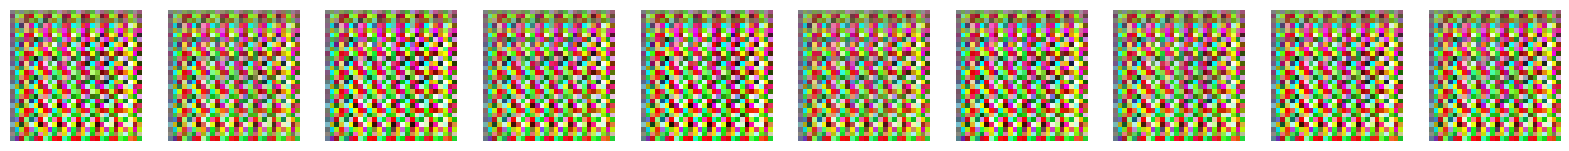

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bars

# Load MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Normalize and reshape the data to have 3 channels (RGB)
x_train = np.expand_dims(x_train, -1)
x_train = np.repeat(x_train, 3, axis=-1)  # Convert grayscale to RGB
x_train = x_train.astype('float32') / 255.0

# DCGAN Model
latent_dim = 128

# Generator
generator = tf.keras.Sequential([
    layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(latent_dim,)),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Reshape((7, 7, 256)),
    layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

# Discriminator
discriminator = tf.keras.Sequential([
    layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 3]),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    layers.LeakyReLU(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(1)
])

# GAN Model
discriminator.compile(optimizer='adam', loss='binary_crossentropy')
discriminator.trainable = False

gan_input = tf.keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(optimizer='adam', loss='binary_crossentropy')

# Training loop with tqdm progress bars
def train_dcgan(gan, generator, discriminator, dataset, latent_dim, epochs=10, batch_size=128):
    num_batches = len(dataset)
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        # Wrap the dataset iterator with tqdm for a progress bar
        for batch_idx, real_images in tqdm(enumerate(dataset), total=num_batches, desc="Batches"):
            if batch_idx >= num_batches:
                break  # Stop after iterating through all batches in the dataset
            batch_size = real_images.shape[0]
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            generated_images = generator.predict(noise)
            real_labels = np.ones((batch_size, 1))
            fake_labels = np.zeros((batch_size, 1))
            d_loss_real = discriminator.train_on_batch(real_images, real_labels)
            d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = gan.train_on_batch(noise, real_labels)
        print(f"D Loss: {d_loss}, G Loss: {g_loss}")
        if (epoch + 1) % 10 == 0:
            generate_and_save_images(generator, epoch + 1, latent_dim)

def generate_and_save_images(generator, epoch, latent_dim, n=10):
    noise = np.random.normal(0, 1, (n, latent_dim))
    generated_images = generator.predict(noise)
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow((generated_images[i] + 1) / 2)
        plt.axis("off")
    plt.show()

# Train the DCGAN
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(128)
train_dcgan(gan, generator, discriminator, dataset, latent_dim, epochs=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


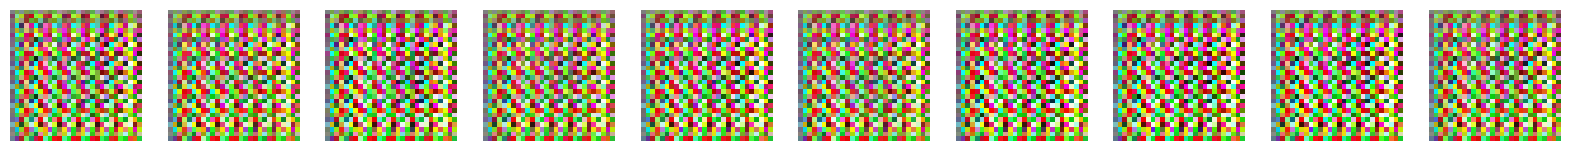

In [ ]:
# Generate and visualize images after training
generate_and_save_images(generator, epoch=10, latent_dim=latent_dim, n=10)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0478
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0205
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0193
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0186
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0181
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0178
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0177
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0175
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0175
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0173


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10, D Loss: 1.7256, G Loss: 1.1678
Epoch 2/10, D Loss: 0.7454, G Loss: 1.5384
Epoch 3/10, D Loss: 0.9325, G Loss: 1.0940
Epoch 4/10, D Loss: 1.0096, G Loss: 1.0947
Epoch 5/10, D Loss: 1.3158, G Loss: 1.0825
Epoch 6/10, D Loss: 1.0854, G Loss: 1.1650
Epoch 7/10, D Loss: 1.0566, G Loss: 1.3806
Epoch 8/10, D Loss: 0.7308, G Loss: 1.5281
Epoch 9/10, D Loss: 1.3363, G Loss: 1.2427
Epoch 10/10, D Loss: 1.0895, G Loss: 1.4290


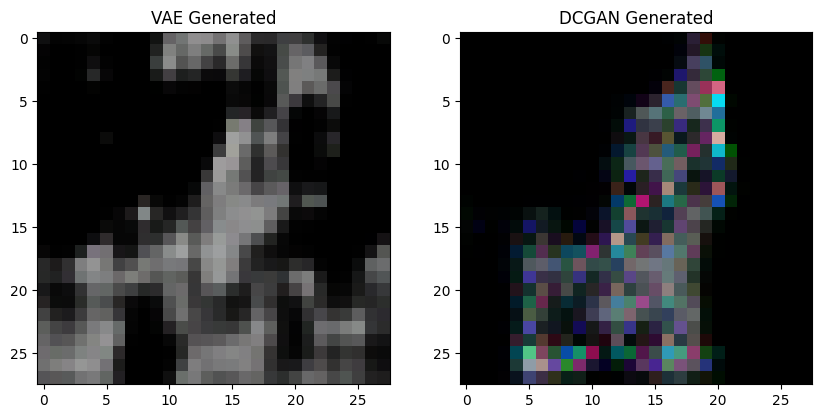

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, LeakyReLU, BatchNormalization, Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess Fashion-MNIST dataset with random colors
def load_data():
    (x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = np.expand_dims(x_train, axis=-1)  # (28, 28, 1)

    # Generate random colors and combine with grayscale images
    colored_images = []
    for img in x_train:
        # Create random color channels
        random_colors = np.random.rand(28, 28, 3)  # Random RGB values in [0, 1]
        # Combine grayscale image with random colors
        colored_img = img * random_colors  # Multiply grayscale with random colors
        colored_images.append(colored_img)

    x_train = np.stack(colored_images)  # Convert list to numpy array
    x_train = x_train.astype('float32') / 255.0  # Normalize to [0, 1]
    return x_train

# Variational Autoencoder (VAE) Components
class VAE(Model):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            Input(shape=(28, 28, 3)),
            Conv2D(32, 3, activation='relu', strides=2, padding='same'),
            Conv2D(64, 3, activation='relu', strides=2, padding='same'),
            Flatten(),
            Dense(latent_dim * 2)  # Mean and log variance
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            Input(shape=(latent_dim,)),
            Dense(7 * 7 * 64, activation='relu'),
            Reshape((7, 7, 64)),
            Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(3, 3, activation='sigmoid', padding='same')
        ])

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + eps * tf.exp(logvar * 0.5)

    def call(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z)

# DCGAN Components
class DCGAN:
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

        # Generator
        self.generator = tf.keras.Sequential([
            Dense(7 * 7 * 128, input_dim=latent_dim, activation='relu'),
            Reshape((7, 7, 128)),
            Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(3, 3, activation='sigmoid', padding='same')
        ])

        # Discriminator
        self.discriminator = tf.keras.Sequential([
            Conv2D(64, 3, strides=2, padding='same', input_shape=(28, 28, 3)),
            LeakyReLU(0.2),
            Conv2D(128, 3, strides=2, padding='same'),
            LeakyReLU(0.2),
            Flatten(),
            Dense(1, activation='sigmoid')
        ])

        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)

        # Labels
        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))

        # Train Discriminator
        with tf.GradientTape() as tape:
            real_loss = self.loss_fn(real_labels, self.discriminator(real_images))
            fake_loss = self.loss_fn(fake_labels, self.discriminator(generated_images))
            d_loss = real_loss + fake_loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            fake_predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(real_labels, fake_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        return d_loss, g_loss

# Load data
x_train = load_data()

# Train VAE
vae = VAE()
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')  # Using 'mse' as an example
vae.fit(x_train, x_train, epochs=10, batch_size=128)

# Train DCGAN
dcgan = DCGAN()
batch_size = 128
epochs = 10
for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        d_loss, g_loss = dcgan.train_step(x_train[i:i+batch_size])
    print(f"Epoch {epoch + 1}/{epochs}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

# Generate images
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
random_latent_vector = tf.random.normal(shape=(1, 100))
axes[0].imshow(vae.decoder(random_latent_vector)[0])
axes[0].set_title("VAE Generated")
axes[1].imshow(dcgan.generator(random_latent_vector)[0])
axes[1].set_title("DCGAN Generated")
plt.show()

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0460
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0204
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0191
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0185
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0181
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0179
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0176
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0175
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0173
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0174
Epoch 1/10, D Loss: 0.8811, G Loss: 1.1208
Epoch 2/10, D Loss: 1.2579, G Loss: 0.9414
Epoch 3/10, D Loss: 0.6830, G Loss: 1.3723
Epoch 4/10, D Loss: 1.1960, G Loss: 0.9540
Epoch 5/10, D Loss: 1.1364, G Loss: 1.2197
Epoch 6/10, D Loss: 1.1331, G Loss: 1.3732
Epoch 7/10, D Loss: 0.6853, G Loss: 1.4705
Epoch 8/10, D Loss: 0.9089,

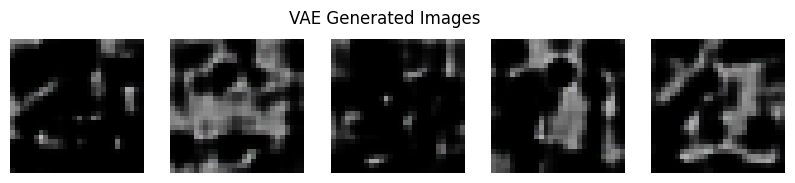

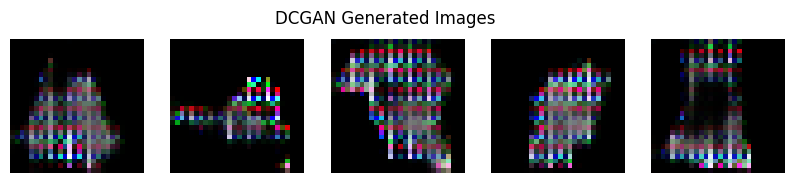

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, LeakyReLU, BatchNormalization, Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess Fashion-MNIST dataset with random colors
def load_data():
    (x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = np.expand_dims(x_train, axis=-1)  # (28, 28, 1)

    # Generate random colors and combine with grayscale images
    colored_images = []
    for img in x_train:
        # Create random color channels
        random_colors = np.random.rand(28, 28, 3)  # Random RGB values in [0, 1]
        # Combine grayscale image with random colors
        colored_img = img * random_colors  # Multiply grayscale with random colors
        colored_images.append(colored_img)

    x_train = np.stack(colored_images)  # Convert list to numpy array
    x_train = x_train.astype('float32') / 255.0  # Normalize to [0, 1]
    return x_train

# Variational Autoencoder (VAE) Components
class VAE(Model):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            Input(shape=(28, 28, 3)),
            Conv2D(32, 3, activation='relu', strides=2, padding='same'),
            Conv2D(64, 3, activation='relu', strides=2, padding='same'),
            Flatten(),
            Dense(latent_dim * 2)  # Mean and log variance
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            Input(shape=(latent_dim,)),
            Dense(7 * 7 * 64, activation='relu'),
            Reshape((7, 7, 64)),
            Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(3, 3, activation='sigmoid', padding='same')  # Output 3 channels (RGB)
        ])

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + eps * tf.exp(logvar * 0.5)

    def call(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z)

# DCGAN Components
class DCGAN:
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

        # Generator
        self.generator = tf.keras.Sequential([
            Dense(7 * 7 * 128, input_dim=latent_dim, activation='relu'),
            Reshape((7, 7, 128)),
            Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(3, 3, activation='sigmoid', padding='same')  # Output 3 channels (RGB)
        ])

        # Discriminator
        self.discriminator = tf.keras.Sequential([
            Conv2D(64, 3, strides=2, padding='same', input_shape=(28, 28, 3)),
            LeakyReLU(0.2),
            Conv2D(128, 3, strides=2, padding='same'),
            LeakyReLU(0.2),
            Flatten(),
            Dense(1, activation='sigmoid')
        ])

        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)

        # Labels
        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))

        # Train Discriminator
        with tf.GradientTape() as tape:
            real_loss = self.loss_fn(real_labels, self.discriminator(real_images))
            fake_loss = self.loss_fn(fake_labels, self.discriminator(generated_images))
            d_loss = real_loss + fake_loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            fake_predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(real_labels, fake_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        return d_loss, g_loss

# Load data
x_train = load_data()

# Train VAE
vae = VAE()
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')  # Using 'mse' as an example
vae.fit(x_train, x_train, epochs=10, batch_size=128)

# Train DCGAN
dcgan = DCGAN()
batch_size = 128
epochs = 10
for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        d_loss, g_loss = dcgan.train_step(x_train[i:i+batch_size])
    print(f"Epoch {epoch + 1}/{epochs}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

# Generate and visualize images
def generate_and_visualize_images(model, model_name, latent_dim=100, n=5):
    random_latent_vectors = tf.random.normal(shape=(n, latent_dim))
    generated_images = model(random_latent_vectors)
    plt.figure(figsize=(10, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.suptitle(f"{model_name} Generated Images")
    plt.show()

# Visualize VAE-generated images
generate_and_visualize_images(vae.decoder, "VAE")

# Visualize DCGAN-generated images
generate_and_visualize_images(dcgan.generator, "DCGAN")

# Increase Epochese

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, LeakyReLU, BatchNormalization, Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess Fashion-MNIST dataset with random colors
def load_data():
    (x_train, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = np.expand_dims(x_train, axis=-1)  # (28, 28, 1)

    # Generate random colors and combine with grayscale images
    colored_images = []
    for img in x_train:
        # Create random color channels
        random_colors = np.random.rand(28, 28, 3)  # Random RGB values in [0, 1]
        # Combine grayscale image with random colors
        colored_img = img * random_colors  # Multiply grayscale with random colors
        colored_images.append(colored_img)

    x_train = np.stack(colored_images)  # Convert list to numpy array
    x_train = x_train.astype('float32') / 255.0  # Normalize to [0, 1]
    return x_train

# Variational Autoencoder (VAE) Components
class VAE(Model):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            Input(shape=(28, 28, 3)),
            Conv2D(32, 3, activation='relu', strides=2, padding='same'),
            Conv2D(64, 3, activation='relu', strides=2, padding='same'),
            Flatten(),
            Dense(latent_dim * 2)  # Mean and log variance
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            Input(shape=(latent_dim,)),
            Dense(7 * 7 * 64, activation='relu'),
            Reshape((7, 7, 64)),
            Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(3, 3, activation='sigmoid', padding='same')  # Output 3 channels (RGB)
        ])

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=tf.shape(mean))
        return mean + eps * tf.exp(logvar * 0.5)

    def call(self, x):
        mean_logvar = self.encoder(x)
        mean, logvar = tf.split(mean_logvar, num_or_size_splits=2, axis=1)
        z = self.reparameterize(mean, logvar)
        return self.decoder(z)

# DCGAN Components
class DCGAN:
    def __init__(self, latent_dim=100):
        self.latent_dim = latent_dim

        # Generator
        self.generator = tf.keras.Sequential([
            Dense(7 * 7 * 128, input_dim=latent_dim, activation='relu'),
            Reshape((7, 7, 128)),
            Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same'),
            Conv2DTranspose(3, 3, activation='sigmoid', padding='same')  # Output 3 channels (RGB)
        ])

        # Discriminator
        self.discriminator = tf.keras.Sequential([
            Conv2D(64, 3, strides=2, padding='same', input_shape=(28, 28, 3)),
            LeakyReLU(0.2),
            Conv2D(128, 3, strides=2, padding='same'),
            LeakyReLU(0.2),
            Flatten(),
            Dense(1, activation='sigmoid')
        ])

        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        generated_images = self.generator(random_latent_vectors)

        # Labels
        real_labels = tf.ones((batch_size, 1))
        fake_labels = tf.zeros((batch_size, 1))

        # Train Discriminator
        with tf.GradientTape() as tape:
            real_loss = self.loss_fn(real_labels, self.discriminator(real_images))
            fake_loss = self.loss_fn(fake_labels, self.discriminator(generated_images))
            d_loss = real_loss + fake_loss
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Train Generator
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            fake_predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(real_labels, fake_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        return d_loss, g_loss

# Load data
x_train = load_data()

# Train VAE
vae = VAE()
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')  # Using 'mse' as an example
vae.fit(x_train, x_train, epochs=10, batch_size=128)

# Train DCGAN
dcgan = DCGAN()
batch_size = 128
epochs = 100
for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
        d_loss, g_loss = dcgan.train_step(x_train[i:i+batch_size])
    print(f"Epoch {epoch + 1}/{epochs}, D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

# Generate and visualize images
def generate_and_visualize_images(model, model_name, latent_dim=100, n=5):
    random_latent_vectors = tf.random.normal(shape=(n, latent_dim))
    generated_images = model(random_latent_vectors)
    plt.figure(figsize=(10, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i])
        plt.axis("off")
    plt.suptitle(f"{model_name} Generated Images")
    plt.show()

# Visualize VAE-generated images
generate_and_visualize_images(vae.decoder, "VAE")

# Visualize DCGAN-generated images
generate_and_visualize_images(dcgan.generator, "DCGAN")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 106s 214ms/step - loss: 0.0475
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 215ms/step - loss: 0.0205
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 212ms/step - loss: 0.0191
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 211ms/step - loss: 0.0185
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 100s 212ms/step - loss: 0.0181
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 212ms/step - loss: 0.0178
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 211ms/step - loss: 0.0176
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 139s 204ms/step - loss: 0.0175
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 203ms/step - loss: 0.0175
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 205ms/step - loss: 0.0173


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100, D Loss: 0.7254, G Loss: 1.2186
Epoch 2/100, D Loss: 1.2870, G Loss: 1.1327
Epoch 3/100, D Loss: 1.4421, G Loss: 1.1892
Epoch 4/100, D Loss: 0.9174, G Loss: 1.4541
Epoch 5/100, D Loss: 0.9560, G Loss: 1.2621
Epoch 6/100, D Loss: 0.6194, G Loss: 1.9035
Epoch 7/100, D Loss: 0.8390, G Loss: 1.5087
Epoch 8/100, D Loss: 0.6681, G Loss: 2.0581
Epoch 9/100, D Loss: 0.5013, G Loss: 1.8235
Epoch 10/100, D Loss: 0.6473, G Loss: 2.6996
Epoch 11/100, D Loss: 0.5304, G Loss: 1.9977
Epoch 12/100, D Loss: 0.6907, G Loss: 1.7508
Epoch 13/100, D Loss: 0.5733, G Loss: 1.7502
Epoch 14/100, D Loss: 0.8870, G Loss: 1.6015
Epoch 15/100, D Loss: 0.8316, G Loss: 1.7896
Epoch 16/100, D Loss: 0.8446, G Loss: 1.8166
Epoch 17/100, D Loss: 0.6838, G Loss: 1.8109
Epoch 18/100, D Loss: 0.8684, G Loss: 1.3502
Epoch 19/100, D Loss: 1.4175, G Loss: 0.8142
Epoch 20/100, D Loss: 1.3235, G Loss: 1.1691
Epoch 21/100, D Loss: 1.0785, G Loss: 1.2774
Epoch 22/100, D Loss: 1.5867, G Loss: 0.8027
Epoch 23/100, D Los

Training data shape: (60000, 64, 64, 3)
Test data shape: (10000, 64, 64, 3)


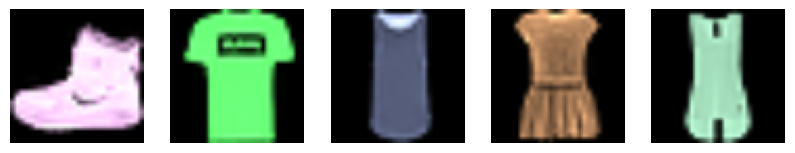

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# Load Fashion MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Add a color channel
x_train = np.stack((x_train,) * 3, axis=-1)
x_test = np.stack((x_test,) * 3, axis=-1)

def add_color(image):
    color_multipliers = np.random.uniform(0.5, 1.5, size=(3,))
    image = image * color_multipliers
    image = np.clip(image, 0, 1)
    return image

# Apply color to the dataset
x_train = np.array([add_color(img) for img in x_train])
x_test = np.array([add_color(img) for img in x_test])

# Resize images to 64x64
x_train = tf.image.resize(x_train, (64, 64))
x_test = tf.image.resize(x_test, (64, 64))

# dataset shape
print("Training data shape:", x_train.shape)
print("Test data shape:", x_test.shape)

# Display sample images
def show_images(images, n=5):
    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

show_images(x_train)

# . Variational Autoencoder (VAE) for Generating Colored Images

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

# Define the VAE model
latent_dim = 128  # Latent space dimension

# Encoder
encoder_inputs = tf.keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer
def sampling(z_mean, z_log_var):
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(lambda x: sampling(*x), name="z")([z_mean, z_log_var])

# Decoder
decoder_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

# Define encoder and decoder separately
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
decoder = Model(decoder_inputs, decoder_outputs, name="decoder")

# Custom VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # Compute KL loss
        kl_loss = -0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var))
        self.add_loss(kl_loss)

        return reconstructed

# Instantiate VAE
vae = VAE(encoder, decoder)

# Define reconstruction loss
def reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Compile model
vae.compile(optimizer="adam", loss=reconstruction_loss)

# Train the VAE
vae.fit(x_train, x_train, epochs=20, batch_size=128, validation_data=(x_test, x_test))

# Generate new images
n = 5  # Number of images to generate
random_latent_vectors = np.random.normal(size=(n, latent_dim))
generated_images = decoder.predict(random_latent_vectors)

# Display generated images
plt.figure(figsize=(10, 2))
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.imshow(generated_images[i])
    plt.axis("off")
plt.show()


Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 653s 1s/step - loss: 0.0911 - val_loss: 0.0718
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 659s 1s/step - loss: 0.0718 - val_loss: 0.0703
Epoch 3/20
287/469 ━━━━━━━━━━━━━━━━━━━━ 3:44 1s/step - loss: 0.0703


# 2. Deep Convolutional Generative Adversarial Network (DCGAN) for Generating Colored Images

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Define the generator
latent_dim = 128

generator_inputs = tf.keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 256, use_bias=False)(generator_inputs)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 256))(x)
x = layers.Conv2DTranspose(128, 4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(64, 4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
generator_outputs = layers.Conv2DTranspose(3, 4, strides=1, padding="same", activation="tanh")(x)

generator = Model(generator_inputs, generator_outputs, name="generator")

# Define the discriminator
discriminator_inputs = tf.keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(64, 4, strides=2, padding="same")(discriminator_inputs)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 4, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
discriminator_outputs = layers.Dense(1, activation="sigmoid")(x)

discriminator = Model(discriminator_inputs, discriminator_outputs, name="discriminator")

# Compile the discriminator
discriminator.compile(optimizer="adam", loss="binary_crossentropy")

# Combine generator and discriminator for training the generator
discriminator.trainable = False
gan_inputs = tf.keras.Input(shape=(latent_dim,))
gan_outputs = discriminator(generator(gan_inputs))
gan = Model(gan_inputs, gan_outputs, name="gan")
gan.compile(optimizer="adam", loss="binary_crossentropy")

# Train the DCGAN
batch_size = 128
epochs = 20

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in range(len(x_train) // batch_size):
        # Real images
        real_images = x_train[i * batch_size : (i + 1) * batch_size]
        real_labels = np.ones((batch_size, 1))

        # Fake images
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
        fake_images = generator.predict(random_latent_vectors)
        fake_labels = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
        misleading_labels = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(random_latent_vectors, misleading_labels)

    print(f"Discriminator loss: {d_loss}, Generator loss: {g_loss}")

# Generate new images
n = 5  # Number of images to generate
random_latent_vectors = np.random.normal(size=(n, latent_dim))
generated_images = generator.predict(random_latent_vectors)

# Rescale images from [-1, 1] to [0, 1]
generated_images = 0.5 * generated_images + 0.5

# Display generated images
plt.figure(figsize=(10()